# 1
## 2
### 3
#### 4
#### Start

# Data preparation for modelling

## importing libraries

In [1]:
import numpy as np
import pandas as pd
#import shap
import matplotlib.pyplot as plt
import tqdm

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import pickle

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

### Setting working directory

In [2]:
import os


WORK_DIR=os.getcwd()

# # Converted data files
#os.chdir('/dbfs/mnt/pegasusdatalake/historical_pipeline_data/API')
INTER_DATA_DIR=os.path.join(os.getcwd())

#os.chdir('/dbfs/mnt/pegasusdatalake/historical_pipeline_data/API')
OUTPUT=os.path.join(os.getcwd())


### Importing data

In [3]:
prod = 'venlafaxine'+"_"
section = 'section1to3'+"_"

In [4]:
#data = pd.read_excel('08_'+prod+section+'final_model_input.xlsx')

data = pd.read_excel(os.path.join(INTER_DATA_DIR,'08_'+prod+section+'final_model_input_final.xlsx'), engine = 'openpyxl',parse_dates=True)
#print(df.shape)
#df.set_index('BMR Batch Number', inplace= True)
#df.head()

In [5]:
data.head()

Batch Number  \
0    HWC220312   
1    HWC230030   
2    HWC220064   
3    HWC220067   
4    HWC220119   

   formaldehyde solution 35% (formaline)_assay_by_titrimetry__nlt_34_0_nmt_38_0_CMA  \
0                                              36.25                                  
1                                              38.00                                  
2                                              38.00                                  
3                                              37.30                                  
4                                              37.90                                  

   ipa + hcl 20% w/w_water_by_kf__nmt_1_00_CMA  \
0                                         0.32   
1                                         0.24   
2                                         0.29   
3                                         0.29   
4                                         0.18   

   isopropyl alcohol_acidity_mmt_0_10_ml_of_0_1m_sodium_hydroxide_is_required__CMA  \
0                                           0.090639                                 
1                                           0.090639                                 
2                                           0.100000                                 
3                                           0.100000                                 
4                                           0.070000                                 

   isopropyl alcohol_ph_nlt_5_0_nmt_8_0_CMA  \
0                                  7.035181   
1                                  7.035181   
2                                  7.182864   
3                                  6.913894   
4                                  7.300000   

   isopropyl alcohol_water_by_kf__nmt_0_50_CMA  \
0                                     0.054710   
1                                     0.054710   
2                                     0.030428   
3                                     0.039537   
4                                     0.050000   

   n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
0                                                0.5              
1                                                0.5              
2                                                0.3              
3                                                0.4              
4                                                0.4              

   section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
0                                               32.9                                                                    
1                                               34.1                                                                    
2                                               33.0                                                                    
3                                               33.1                                                                    
4                                               33.2                                                                    

   section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
0                                            231.000                                                 
1                                            236.000                                                 
2                                            243.000                                                 
3                                            236.000                                                 
4                                            257.875                                                 

   section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._quenching completed temp_CPP  \
0                                       

In [6]:
data.set_index(data.columns[0], inplace =True)

In [7]:
data.shape

(38, 27)

In [10]:
#dropping intermediate weights(lot) variables from file
# data.drop(data.filter(regex = 'lot$'), axis=1, inplace = True)

In [9]:
# # filter total time and name it with section and duration_target as prefix and suffix
# data[f'{section}duration_target']  = data.filter(regex = 'total time').sum(axis= 1)

In [8]:
#reading 
data.filter(regex='target').columns.tolist()[0:4]

['section_3_yield_target', 'section1to3_duration_target']

In [9]:
data.filter(regex = 'target').columns.tolist()[0:2]

['section_3_yield_target', 'section1to3_duration_target']

### filtering out the data for CMA, CPP and CQA and Target variables

In [10]:
#storing CMA, CQA,CPP and Target columns in variables

cma = data.columns[data.columns.str.contains('_CMA')].shape[0]
cpp = data.columns[data.columns.str.contains('_CPP')].shape[0]
cqa = data.columns[data.columns.str.contains('_CQA')].shape[0]
target = data.columns[data.columns.str.contains('target')].shape[0]
total_feature = ['Selected Variables', cma, cpp, cqa, target]
total_feature

['Selected Variables', 6, 16, 3, 2]

In [11]:
#filtering target variables
data.filter(regex = 'qty').columns[-1:].tolist()

[]

In [14]:
# data.drop(data.filter(regex = 'qty').columns.tolist()[-1:],axis=1, inplace = True)

In [12]:
#storing CT, Yield and CQA columns
ct_col = [data.filter(regex = 'target').columns[-2:].tolist()[1]]
yield_col = [data.filter(regex = 'target').columns[-2:].tolist()[0]]
# yield_col = data.filter(regex = 'target').columns.tolist()
cqa_col = data.columns[data.columns.str.contains('_CQA')].tolist()

In [13]:
ct_col

['section1to3_duration_target']

In [14]:
cqa_col

['loss_on_drying_nmt_0_50_CQA',
 'specific_optical_rotation_on_dried_basis__between_0_50_to_0_50_on_dried_basis__CQA',
 'sulfated_ash_nmt_0_10_CQA']

In [15]:
yield_col

['section_3_yield_target']

In [16]:
cma_col = data.columns[data.columns.str.contains('_CMA')]
cma_col

Index(['formaldehyde solution 35% (formaline)_assay_by_titrimetry__nlt_34_0_nmt_38_0_CMA',
       'ipa + hcl 20% w/w_water_by_kf__nmt_1_00_CMA',
       'isopropyl alcohol_acidity_mmt_0_10_ml_of_0_1m_sodium_hydroxide_is_required__CMA',
       'isopropyl alcohol_ph_nlt_5_0_nmt_8_0_CMA',
       'isopropyl alcohol_water_by_kf__nmt_0_50_CMA',
       'n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA'],
      dtype='object')

### X&y- Split

In [17]:
#segregating X and Y variables for modelling
y = data[yield_col]
#data.set_index(['Batch Number'],inplace=True )
data.drop(ct_col+yield_col+cqa_col,axis=1,inplace=True )
X = data.copy()

In [18]:
X.shape,y.shape

((38, 22), (38, 1))

In [19]:
#replacing na by mean in numeric columns
numeric_cloms=X.describe().columns
X[numeric_cloms] = X[numeric_cloms].fillna(X[numeric_cloms].mean())

In [19]:
#checking if there are still na values in X
#X.isnull().sum().to_frame()

In [20]:
X.shape

(38, 22)

In [21]:
X.dropna(axis=1, how= 'all', inplace=True)

### exporting X and y

In [22]:
# X.to_csv(os.path.join(OUTPUT, 'x.csv'))
X.to_excel(os.path.join(OUTPUT, 'X.xlsx'))

In [23]:
# y.to_csv(os.path.join(OUTPUT, 'y.csv'))
y.to_excel(os.path.join(OUTPUT, 'y.xlsx'))

### shap plot before modelling

In [24]:
# model = GradientBoostingRegressor()
# Y = y[yield_col]
# model.fit(X,Y)

# explainer = shap.TreeExplainer(model,)
# shap_values = explainer.shap_values(X, check_additivity=False)
# shap_values_df = pd.DataFrame(shap_values, columns=X.columns, index=X.index)
# shap_values_summary = pd.DataFrame(shap_values_df.abs().mean(), columns=["abs_mean_shap"])
# shap_values_summary = shap_values_summary.sort_values(by="abs_mean_shap", ascending=False)

# top_shap_features = shap_values_summary.index.tolist()
# for feature in top_shap_features:
#     fig = shap.dependence_plot(
#         feature,
#         shap_values,
#         X,
#         interaction_index=None,
#         alpha=1,
#         dot_size=20,
#         color="purple",
#         show=False,
#     )
#     plt.title(feature, fontsize=15)
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title(feature)

# Feature Selection

In [24]:
from sklearn.feature_selection import RFE,RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsRegressor

In [25]:
X.iloc[0:1,5:]

n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
Batch Number                                                                 
HWC220312                                                   0.5              

              section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP  \
Batch Number                                                                                                            
HWC220312                                                    86                                                         

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._charging started  temp_CPP  \
Batch Number                                                                                                                           
HWC220312                                                  29.1                                                                        

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._charging completed temp_CPP  \
Batch Number                                                                                                                            
HWC220312                                                  30.7                                                                         

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._end time-start time=total time_CPP  \
Batch Number                                                                                                                                   
HWC220312                                                    24                                                                                

              section 1: methylation_1.4_charge 220.0 +/-10 lt. purified water._end time-start time=total time_CPP  \
Batch Number                                                                                                         
HWC220312                                                24.875                                                      

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
Batch Number                                                                                                                       
HWC220312                                                  32.9                                                                    

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_end time-start time=total time_CPP  \
Batch Number                                                                                                                              
HWC220312                                                    34                                                                           

              section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
Batch Number                                                                                                    
HWC220312                                                 231.0                                                 

              section 1: methylation_1.7_stop steam_stop agitator and remove about 5ml reaction mass for tlc._end time-start time=total time_CPP  \
Batch Number                                                                                                                                       
HWC220312                                                  25.0                                                                                    

              section 1: methylation_1.9_stop steam_stop agitator and remove about 5 ml reaction mass for tlc._end time-start time=total time_CPP  \
Batch Number                                             

In [26]:
X_cpp = X.iloc[:,6:]

In [98]:
# # run to backup final_selected
# Final_selected_lst = Final_selected_lst.copy()
# len(Final_selected_lst)

22

In [94]:
# #update X_cpp while reading, skip first time
# X_to_select = pd.read_excel('X_selected_features.xlsx')

# Final_selected = X_to_select[X_to_select['To Select'] == 'Y']['Features'].tolist()

In [95]:
# Final_selected

['section 2: isolation_2.9_check ph of reaction mass. it should be 10.5+/-0.5._ph_CPP',
 'section 3: filtration_3.9_charge 30.0+/-5.0 lt n-heptane in reactor at step 2.1 and chilled to 0-5c_chilling started  temp_CPP',
 'section 2: isolation_2.3_cool to 28+/-3c_cooling started temp_CPP',
 'section 2: isolation_2.2_charge 1400.00 +/- 50 lt. purified water in reactor and charge 350.00 kg. of sodium hydroxide and stir to disslove._end time-start time=total time_CPP',
 'section 1: methylation_1.15_charge 600.00 +/- 20.00 lt. of n-heptane to the reaction mass using aodd pump._end time-start time=total time_CPP',
 'section 3: filtration_3.13_check clarity of mlr. it should be clear._end time-start time=total time_CPP',
 'section 1: methylation_1.1_check tlc for completion of reaction._end time-start time=total time_CPP',
 'section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP',
 'section 1: methylation_1.4_charge 220.0 +/-10 lt. pu

In [96]:
# #use only for multiple Final Selection iterations skip 1st time
# Final_selected_lst = Final_selected_lst+Final_selected
# Final_selected_lst

['section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.32_stir 1 hour +/- 5 minutes at 5+/-5c_stirring time completed temp_CPP',
 'section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._end time-start time=total time_CPP',
 'section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._temperature attained temp_CPP',
 'section 2: isolation_2.24_separate the lower aqueous layer for disposal and keep n-heptane layer in reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.2_charge 900.0 +/-20.0 lt. purified water into n-heptane layer._end time-start time=total time_CPP',
 'section 2: isolation_2.19_separate the lower aqueous layer for disposal and keep n-heptane layer in reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._end time-start time=total time_CPP',
 'section 2: isolation_2.8_qu

In [99]:
# if len(Final_selected_lst)>20:
#     Final_selected_lst = Final_selected_lst[0:20]
#     print('20 features present')
# elif len(Final_selected_lst)<20:
#     print('less than 20 features present')
#     print('Count - ',len(Final_selected_lst))
    
# X_cpp_new = []
# for i in X_cpp:
#     if i not in Final_selected:
#         X_cpp_new.append(i)
        
# X_cpp = X_cpp[X_cpp_new]

20 features present


In [27]:
#------------------------------
X_cpp.shape

(38, 53)

In [28]:
# df = RandomForestRegressor(max_depth=5,min_samples_leaf=3)
# rfe = RFE(df,n_features_to_select=25)
# rfe_values = rfe.fit(X_cpp,y)

## RFE(randomforest)

rf = RandomForestRegressor(max_depth=5,min_samples_leaf=3)
rfe_selector = RFE(estimator=rf, n_features_to_select=20)
rfe_selector.fit(X_cpp, y)
top_25_rfe_rf = X_cpp.columns[rfe_selector.support_].tolist()

In [29]:
## SHAP
import shap
rf.fit(X_cpp, y)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_cpp)
mean_shap_values = pd.Series(shap_values[0].mean(axis=0), index=X_cpp.columns).abs().sort_values(ascending=False)
top_25_shap = mean_shap_values.head(20).index.tolist()

In [30]:
## RFE(lasso)
lr = Lasso(alpha=0.5)
rfe_selector_lasso = RFE(estimator=lr, n_features_to_select=20)
rfe_selector_lasso.fit(X_cpp, y)
top_20_rfe_lasso = X_cpp.columns[rfe_selector.support_].tolist()

In [92]:
# common_elements = set(top_20_rfe_lasso) & set(top_25_rfe_rf) & set(top_25_shap)
# list(common_elements)

['section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._end time-start time=total time_CPP',
 'section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._end time-start time=total time_CPP',
 'section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._temperature attained temp_CPP',
 'section 2: isolation_2.2_charge 900.0 +/-20.0 lt. purified water into n-heptane layer._end time-start time=total time_CPP',
 'section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._temperature attained temp_CPP',
 'section 2: isolation_2.19_separate the lower aqueous layer for disposal and keep n-heptane layer in reactor._end time-start time=total time_CPP']

In [96]:
from collections import Counter
all_selected_features = top_20_rfe_lasso + top_25_rfe_rf + top_25_shap
feature_counts = Counter(all_selected_features)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
combined_top_features = [feature[0] for feature in sorted_features if feature[1] > 2]

In [97]:
combined_top_features

['section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._temperature attained temp_CPP',
 'section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._end time-start time=total time_CPP',
 'section 2: isolation_2.19_separate the lower aqueous layer for disposal and keep n-heptane layer in reactor._end time-start time=total time_CPP',
 'section 2: isolation_2.2_charge 900.0 +/-20.0 lt. purified water into n-heptane layer._end time-start time=total time_CPP',
 'section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._temperature attained temp_CPP',
 'section 2: isolation_2.3_cool and chill the reaction mass to 5+/-5c._end time-start time=total time_CPP']

In [32]:
dff = pd.DataFrame()
dff['features'] = combined_top_features
dff['importance'] = [feature_counts[feature] for feature in combined_top_features]
dff.head(100)

features  importance
0   section 1: methylation_1.2_charge 300.00 kg. v...           3
1   section 2: isolation_2.16_heat the reaction ma...           3
2   section 2: isolation_2.16_heat the reaction ma...           3
3   section 2: isolation_2.19_separate the lower a...           3
4   section 2: isolation_2.2_charge 900.0 +/-20.0 ...           3
5   section 2: isolation_2.3_cool and chill the re...           3
6   section 2: isolation_2.3_cool and chill the re...           3
7   section 1: methylation_1.4_charge 220.0 +/-10 ...           2
8   section 1: methylation_1.5_slowly charge 204.0...           2
9   section 1: methylation_1.5_slowly charge 204.0...           2
10  section 1: methylation_1.7_stop steam_stop agi...           2
11  section 1: methylation_1.1_check tlc for compl...           2
12  section 1: methylation_1.15_charge 600.00 +/- ...           2
13  section 2: isolation_2.8_quench the reaction m...           2
14  section 2: isolation_2.9_check ph of reaction ...           2
15  section 2: isolation_2.11_stir reaction mass f...           2
16  section 2: isolation_2.32_stir 1 hour +/- 5 mi...           2
17  section 3: filtration_3.5_filter the reaction ...           2
18  section 3: filtration_3.9_charge 30.0+/-5.0 lt...           2
19  section 3: filtration_3.13_check clarity of ml...           2

In [33]:
top_10_combined_features = combined_top_features[:10]
top_10_combined_features = sorted(top_10_combined_features)

In [34]:
X_cpp_10 = X_cpp[top_10_combined_features]

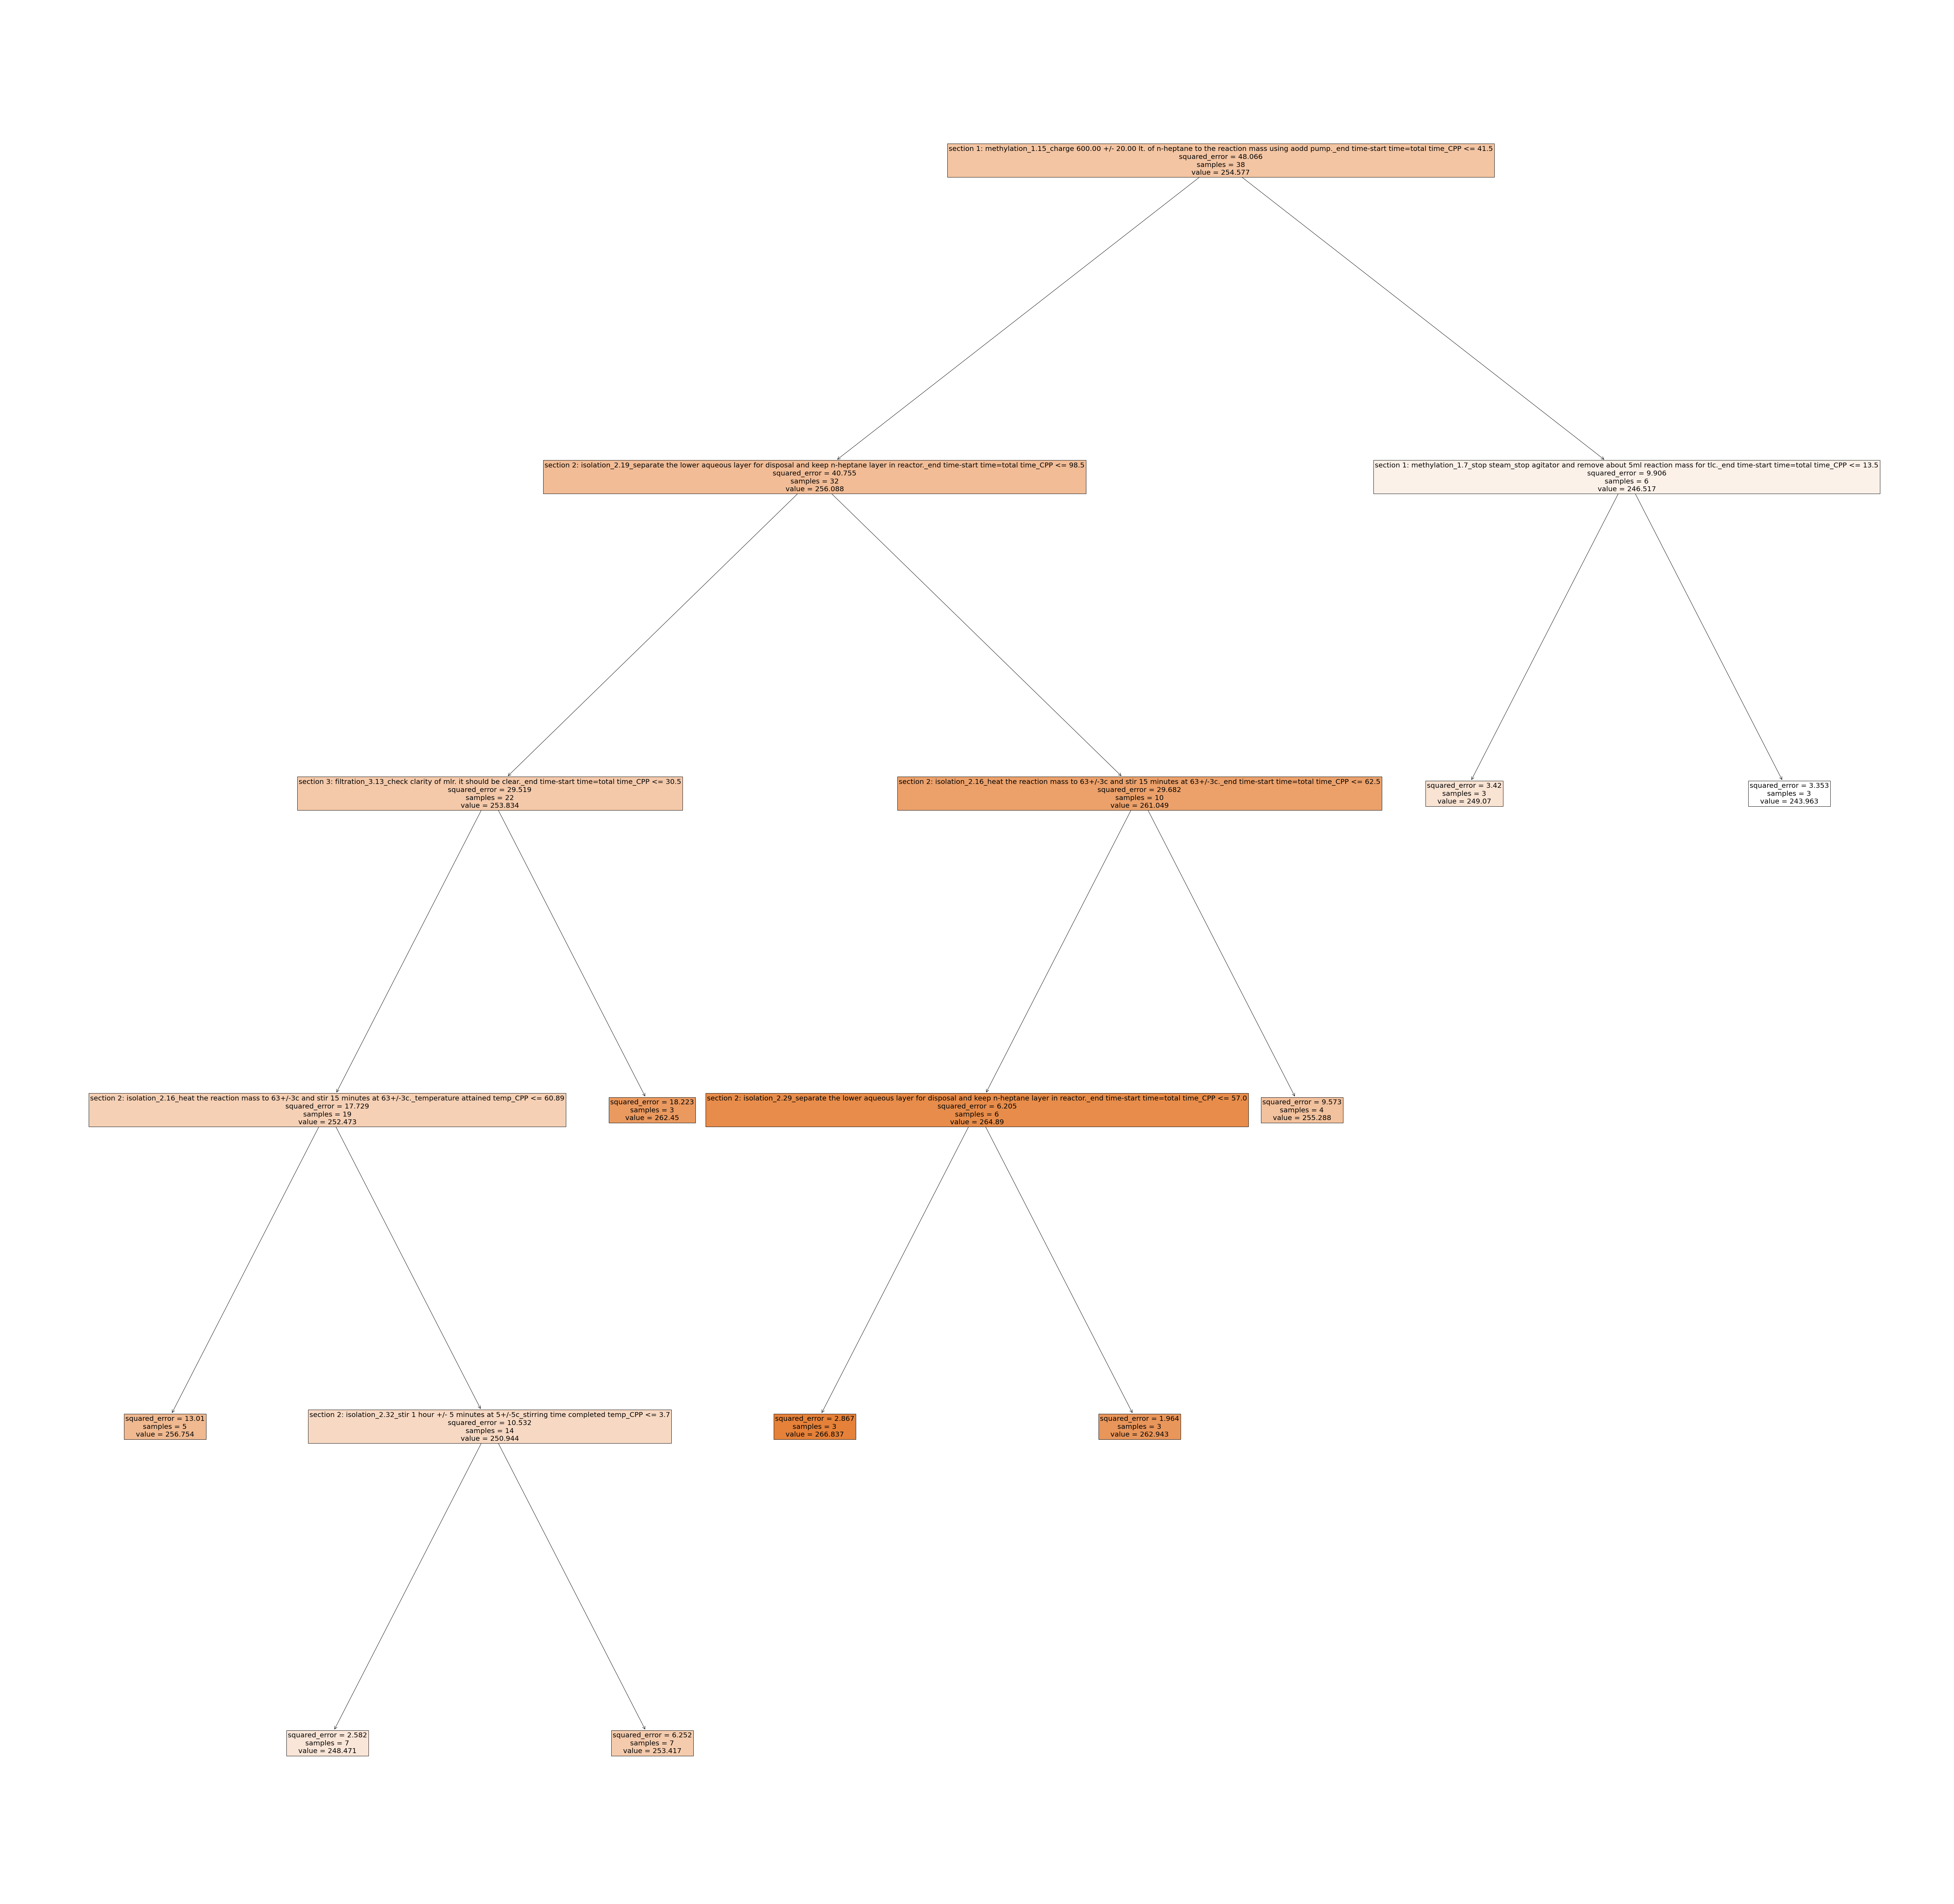

In [62]:
# from sklearn import tree
# ds = DecisionTreeRegressor(max_depth=5,min_samples_leaf=3)
# ds = ds.fit(X_cpp_new, y)
# # tree_data = tree.export_graphviz(ds)
# fig = plt.figure(figsize=(100,100))
# tree.plot_tree(ds,feature_names=X_cpp_new.columns,filled=True,fontsize=20)
# plt.show()
# fig.savefig("decistion_tree.jpg")

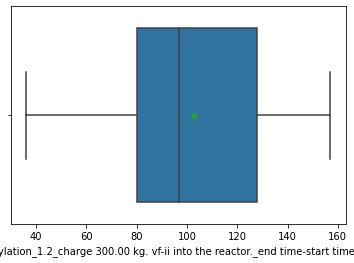

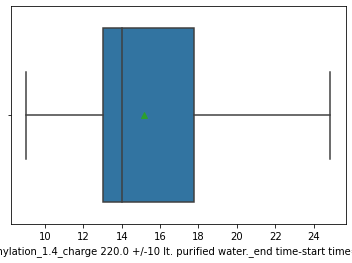

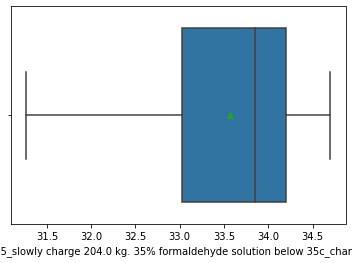

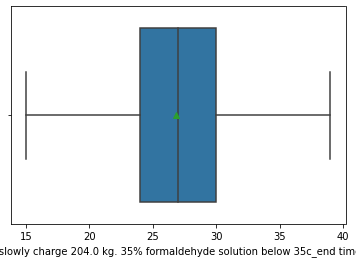

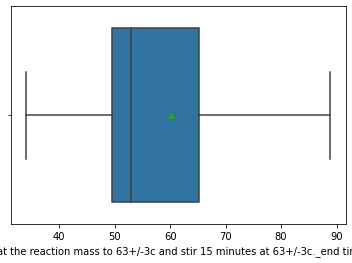

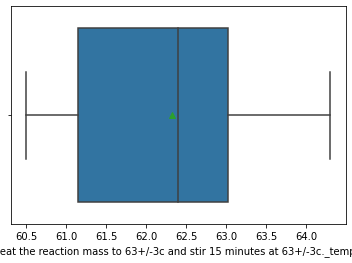

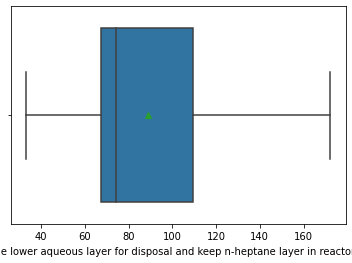

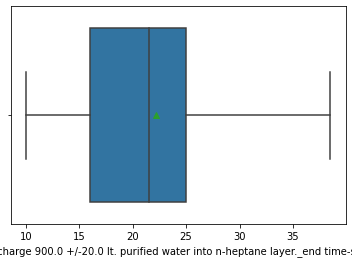

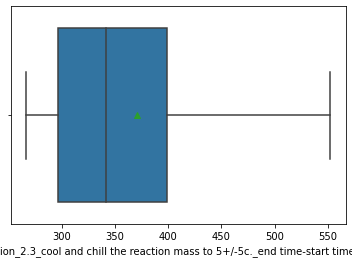

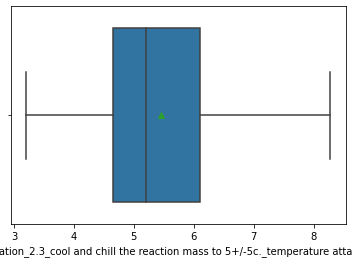

In [37]:
import seaborn as sns
col_list = X_cpp_10.columns.tolist()

for i in col_list:
    sns.boxplot(x = i, data = X_cpp_10, showmeans = True, orient = 'h')
    plt.show()

In [36]:
for tag in col_list:
    X_cpp_10[tag] = pd.to_numeric(X_cpp_10[tag])

for tag in col_list:
    iqr = X_cpp_10[tag].quantile(0.75) - X_cpp_10[tag].quantile(0.25)
    upper_bound = X_cpp_10[tag].quantile(0.75) + 1.5 * (iqr)
    lower_bound = X_cpp_10[tag].quantile(0.25) - 1.5 * (iqr)
    X_cpp_10[tag] = np.where(X_cpp_10[tag] < lower_bound, lower_bound, X_cpp_10[tag])
    X_cpp_10[tag] = np.where(X_cpp_10[tag] > upper_bound, upper_bound, X_cpp_10[tag])

In [92]:
# X_select = X_analysis.sort_values(by=['Ranking'])[0:20]
# X_select['To Select'] = ''

In [93]:
# X_select.to_excel('X_selected_features.xlsx')

In [109]:
# ## Run it once X_cpp is final
# flag = rfe_values.support_
# #change below line
# X_cpp_col = X[Final_selected_lst].columns.tolist()
# # cma_col = cma_col.tolist()

# combined_col = cma_col + X_cpp_col

In [117]:
# X_new = X.copy()

In [118]:
# X_new = X_new[combined_col]

In [119]:
# X_new.shape

(38, 26)

In [120]:
# X_new.to_excel('X_new.xlsx')

In [31]:
X_analysis.to_excel(os.path.join(OUTPUT, 'X_features_rankings.xlsx'))

In [80]:
# X = X[col_list]
# X_cpp_new = X_cpp_new[sorted(X_cpp_new)]

In [38]:
X_cpp_10_col = X_cpp_10.columns.tolist()
cma_col = cma_col.tolist()

combined_col = cma_col + X_cpp_10_col
X_new = X[combined_col]

In [39]:
X_new.to_excel(os.path.join(OUTPUT, 'X.xlsx'))
# y.to_excel(os.path.join(OUTPUT, 'y.xlsx'))

# Model training

## Random Forest Parameter grid

In [24]:
X = pd.read_excel('X.xlsx')
y = pd.read_excel('y.xlsx')
X.set_index(X.columns[0], inplace =True)
y.set_index(y.columns[0], inplace =True)

In [25]:
X.shape,y.shape

((38, 22), (38, 1))

In [26]:
# HyperParameter setup

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 50 , num = 5)]
# max_depth = [4,6,8,10,12,14,16]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
# 'max_features': max_features,
rf_params = {#'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
#                'bootstrap': bootstrap
}

In [27]:
print(type(rf_params))

<class 'dict'>


In [27]:
# rf= RandomForestRegressor( random_state=42)
# model = MultiOutputRegressor(RandomizedSearchCV(estimator = rf, param_distributions = rf_params, n_iter = 10, cv = 3, 
#                                                     verbose = 2, random_state = 42), n_jobs = -1)
# model.fit(X_train, y_train)

In [28]:
# print(rf)

## XGboost Parameter grid

In [28]:
xgb_params = {
#     'n_estimators':[500],
#     'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6],
#     'objective': ['reg:squarederror', 'reg:tweedie'],
#     'booster': ['gbtree', 'gblinear'],
#     'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

## Catboost Parameter grid

In [29]:
cat_params = {'depth': [6,8,10],
            'learning_rate':[0.01, 0.05, 0.1]
#             'iterations':[30, 50, 100]
            }

## Adaboost Parameter grid

In [30]:

ada_params={'n_estimators':[10, 50, 100, 200, 500],
            'learning_rate':[0.0001, 0.01, 0.1, 1.0, 1.1, 1.2]}


## Neural network

## Model training

In [31]:
X.isnull().sum().any()>0
# X.info()

False

In [32]:
X = X.fillna((X.mean()))

In [33]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import catboost as ctb
from sklearn.ensemble import AdaBoostRegressor
import time


# # Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

# Define models to train
models = {
          'RF': RandomForestRegressor(random_state=42),
          'XGB': XGBRegressor(),
          'CATB':ctb.CatBoostRegressor(),
          'ADAB':AdaBoostRegressor()
#           'Lasso':Lasso(alpha=0.1),
#           'Ridge': Ridge()
         }
params=[
    rf_params,
    xgb_params,
    cat_params,
    ada_params
]

# Initialize best model and its performance metric
best_model = None
best_metric = float('inf') # Use MSE as the initial best metric

# Create a dictionary to store performance metrics for all target variables
performance_metrics = {}

# Loop through each model
for  model, param in zip(models.items(),params):
 
    print(type(param))
    print(type(model[1]))
    model_name=model[0]
    print(model_name)
    
    rf= model[1]
    print('------------------------',rf)
    globals()[f'{model_name}_final'] = MultiOutputRegressor(RandomizedSearchCV(estimator = rf, param_distributions = param, n_iter = 100, cv = 4, 
                                                    verbose = 2, random_state = 42), n_jobs = -1)

#     f'{model_name}_final'=globals()[f'{model_name}_final']
    globals()[f'{model_name}_final'].fit(X_train, y_train)

    # Predict on test set
    y_pred = globals()[f'{model_name}_final'].predict(X_test)

    # Calculate error metrics for each target variable
    mse_vals = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    rmse_vals = mse_vals**0.5
    mae_vals = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    mape_vals = ((abs(y_pred - y_test) / y_test).mean() * 100)
    accuracy_vals = 100 - mape_vals
    r2_vals = r2_score(y_test, y_pred, multioutput='raw_values')

#     # Update best model and metric if applicable
#     if mse_vals.mean() < best_metric:
#         best_model = globals()[f'{model_name}_final']
#         best_metric = mse_vals.mean()

    # Store performance metrics in the dictionary
    for i, col in enumerate(y.columns):
        performance_metrics[str(model_name) + '_' + str(col)] = {
        'Model': model_name,
        'Target Variable': col,
        'MSE': mse_vals[i],
        'RMSE': rmse_vals[i],
        'MAE': mae_vals[i],
        'MAPE': mape_vals[i],
        'Accuracy': accuracy_vals[i],
        'R2': r2_vals[i]
        }
    #plot_predicted_vs_actual(globals()[f'{model_name}_final'],model_name, y_test[yield_col])



<class 'dict'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
RF
------------------------ RandomForestRegressor(random_state=42)
<class 'dict'>
<class 'xgboost.sklearn.XGBRegressor'>
XGB
------------------------ XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
<class 'dict'>
<class 'catboost.core.

In [34]:
# Convert performance metrics dictionary to DataFrame
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
performance_df.reset_index(inplace=True)
performance_df.rename(columns={'index': 'Model_Target_Variable'}, inplace=True)

# Pivot performance_df to have target variables as rows and models as columns
pivoted_df = performance_df.pivot(index='Target Variable', columns='Model', values=['MSE', 'RMSE', 'MAE', 'Accuracy', 'R2'])

# Flatten multi-level columns
pivoted_df.columns = [f'{col[1]}_{col[0]}' for col in pivoted_df.columns]

# Reset index
pivoted_df.reset_index(inplace=True)

# Display pivoted DataFrame
print(pivoted_df)

          Target Variable  ADAB_MSE   CATB_MSE     RF_MSE   XGB_MSE  \
0  section_3_yield_target  48.29829  61.381634  71.813771  64.46541   

   ADAB_RMSE  CATB_RMSE   RF_RMSE  XGB_RMSE  ADAB_MAE  CATB_MAE    RF_MAE  \
0   6.949697   7.834643  8.474301  8.029035  6.098896  7.241025  7.806798   

    XGB_MAE  ADAB_Accuracy  CATB_Accuracy  RF_Accuracy  XGB_Accuracy  \
0  7.039052      97.575192      97.132843     96.91124     97.187933   

    ADAB_R2   CATB_R2     RF_R2    XGB_R2  
0  0.032408 -0.229699 -0.438693 -0.291479  


In [35]:
# pivoted_df.set_index('Target Variable', inplace=True)
pivoted_df.filter(regex= 'RMSE')

ADAB_RMSE  CATB_RMSE   RF_RMSE  XGB_RMSE
0   6.949697   7.834643  8.474301  8.029035

In [36]:
pivoted_df.filter(regex='MAE')

ADAB_MAE  CATB_MAE    RF_MAE   XGB_MAE
0  6.098896  7.241025  7.806798  7.039052

In [37]:
y.std().to_frame()

0
section_3_yield_target  7.026021

In [38]:
XGB_final.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [39]:
pivoted_df.to_excel('09_'+prod+section+'model_performance.xlsx')
# pivoted_df.to_csv(os.path.join(OUTPUT, '09_'+prod+section+'model_performance.csv'))

In [41]:
#(y_train['Section1_target'].to_list())

# Pred VS Actual

In [40]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def plot_predicted_vs_actual(model,model_name, actual_values):
    """
    Plots a line chart of predicted versus actual values and saves it as a PDF file.

    Parameters:
    predicted_values (list or numpy array): Predicted values of the target variable.
    actual_values (list or numpy array): Actual values of the target variable.
    save_path (str): File path to save the plot as a PDF file.
    """
    print(model)
    predicted_values = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=actual_values,y=predicted_values[1])
#     sns.lineplot(actual_values, label='Actual')
#     plt.plot(predicted_values, label='Predicted')
    plt.xlabel('actual_values')
    plt.ylabel('predicted_values')
    plt.title('Predicted vs Actual')
    plt.legend()
    save_path=model_name+'predicted_vs_actual.pdf'
    plt.savefig(save_path, format='pdf')
    plt.close()


# Plot and save the predicted versus actual values
#save_path = 'predicted_vs_actual.pdf'
#plot_predicted_vs_actual(model, y_test)

# model_validation 


In [41]:
def model_validation(model_list,model_names,X,y):
    final_df=pd.DataFrame()
    for model,model_name in zip(model_list, model_names):
#         pred_result = pd.DataFrame(model.predict(X).tolist(), columns =  [ct_col+yield_col+cqa_col],index=X.index)
        pred_result = pd.DataFrame(model.predict(X).tolist(), columns =  [yield_col],index=X.index)
        pred_result = pred_result.add_prefix(model_name+'_pred_') 
        #print(pred_result.head())
        final_df=pd.concat([final_df,pred_result],axis=1)
#         print('----------',model_name)
#         print(final_df.head())
    final_df = final_df.merge(y, on = y.index.name)
    #final_df = final_df[[col for pair in zip(final_df.columns, y.columns) for col in pair]]
    return final_df
  

In [42]:
model_list=[RF_final, XGB_final, CATB_final, ADAB_final]

In [43]:
final_df=model_validation(model_list,models.keys(),X_train,y_train)

In [44]:
final_df.head()

(RF_pred_section_3_yield_target,)  \
Batch Number                                      
HWC220089                            251.602322   
HWC220098                            254.230082   
HWC230018                            258.678598   
HWC220306                            259.633200   
HWC220118                            255.207774   

              (XGB_pred_section_3_yield_target,)  \
Batch Number                                       
HWC220089                             250.688049   
HWC220098                             255.891830   
HWC230018                             254.755600   
HWC220306                             260.392670   
HWC220118                             255.665894   

              (CATB_pred_section_3_yield_target,)  \
Batch Number                                        
HWC220089                              250.957506   
HWC220098                              255.835340   
HWC230018                              254.950685   
HWC220306                              260.349794   
HWC220118                              255.222393   

              (ADAB_pred_section_3_yield_target,)  section_3_yield_target  
Batch Number                                                               
HWC220089                              250.488000                  250.70  
HWC220098                              252.885833                  256.01  
HWC230018                              254.860000                  254.86  
HWC220306                              260.462500                  260.53  
HWC220118                              256.706667                  255.30

In [45]:
final_df.to_excel('11_'+prod+section+'pred_act_df.xlsx')
# rf_pred_act_df.to_csv(os.path.join(OUTPUT, '12.1_'+prod+section+'rf_pred_act_df.csv'))

In [46]:
final_df[final_df.filter(regex = 'yield').columns]

(RF_pred_section_3_yield_target,)  \
Batch Number                                      
HWC220089                            251.602322   
HWC220098                            254.230082   
HWC230018                            258.678598   
HWC220306                            259.633200   
HWC220118                            255.207774   
HWC220063                            256.250003   
HWC220090                            253.829114   
HWC230012                            252.415241   
HWC220085                            250.464485   
HWC220312                            260.162304   
HWC230002                            251.891411   
HWC220325                            259.607054   
HWC230031                            256.125078   
HWC230030                            259.149765   
HWC230005                            251.240206   
HWC220084                            252.059087   
HWC220064                            256.416813   
HWC220326                            250.292370   
HWC230017                            252.995515   
HWC220067                            257.981874   
HWC220081                            251.323807   
HWC230006                            254.486417   
HWC220307                            252.325772   
HWC220139                            259.034539   
HWC220065                            256.250507   
HWC220313                            254.230578   
HWC220099                            257.437074   
HWC220133                            256.581156   
HWC220080                            256.003653   
HWC220117                            251.315566   

              (XGB_pred_section_3_yield_target,)  \
Batch Number                                       
HWC220089                             250.688049   
HWC220098                             255.891830   
HWC230018                             254.755600   
HWC220306                             260.392670   
HWC220118                             255.665894   
HWC220063                             257.433868   
HWC220090                             251.930435   
HWC230012                             259.237427   
HWC220085                             246.377029   
HWC220312                             268.506775   
HWC230002                             250.811111   
HWC220325                             262.897949   
HWC230031                             258.261200   
HWC230030                             266.846222   
HWC230005                             242.332672   
HWC220084                             251.325195   
HWC220064                             265.905334   
HWC220326                             249.330917   
HWC230017                             246.562103   
HWC220067                             264.753479   
HWC220081                             246.374344   
HWC230006                             250.646133   
HWC220307                             248.212982   
HWC220139                             260.077759   
HWC220065                             251.403137   
HWC220313                             254.269226   
HWC220099                             251.752090   
HWC220133                             260.907410   
HWC220080                             256.547546   
HWC220117                             249.793015   

              (CATB_pred_section_3_yield_target,)  \
Batch Number                                        
HWC220089                              250.957506   
HWC220098                              255.835340   
HWC230018                              254.950685   
HWC220306                              260.349794   
HWC220118                              255.222393   
HWC220063                              257.226161   
HWC220090                              252.464277   
HWC230012                              258.953104   
HWC220085                              247.163131   
HWC220312                              268.059290   
HWC230002                              250.915934   
HWC220325                  

In [47]:
y_test.index

Index(['HWC220091', 'HWC220172', 'HWC220119', 'HWC220120', 'HWC220327',
       'HWC230013', 'HWC220258', 'HWC220062'],
      dtype='object', name='Batch Number')

In [48]:
list(models.keys())

['RF', 'XGB', 'CATB', 'ADAB']

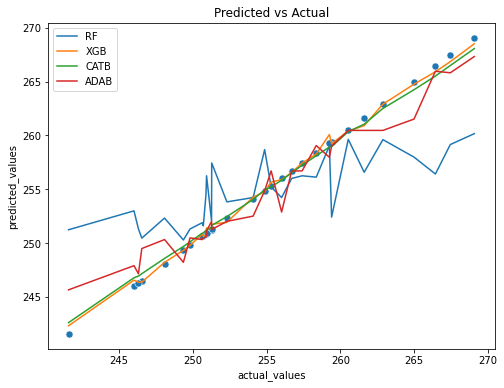

In [49]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

plt.figure(figsize=(8, 6))
for i in range (0, 4):
    sns.lineplot(x=final_df[final_df.filter(regex = 'yield').columns[-1]],
                 y=final_df[final_df.filter(regex = 'yield').columns[i]], label = list(models.keys())[i])
    
sns.scatterplot(x=final_df[final_df.filter(regex = 'yield').columns[-1]], y = final_df[final_df.filter(regex = 'yield').columns[-1]], s=50)
#sns.lineplot(actual_values, label='Actual')
#plt.plot(predicted_values, label='Predicted')
plt.xlabel('actual_values')
plt.ylabel('predicted_values')
plt.title('Predicted vs Actual')
plt.legend()
# save_path=model_name+'predicted_vs_actual.pdf'
# plt.savefig(save_path, format='pdf')
# plt.close()


# Define best_model

In [50]:
best_model = XGB_final

In [51]:
X_test.iloc[0].values

array([3.79000000e+01, 8.00000000e-02, 9.88421459e-02, 6.98147433e+00,
       9.42261675e-02, 3.30476190e-01, 3.39000000e+01, 2.36000000e+02,
       5.58000000e+01, 4.98750000e+01, 6.86000000e+00, 5.81000000e+01,
       6.21000000e+01, 6.29000000e+01, 6.33000000e+01, 6.45000000e+01,
       6.33000000e+01, 6.43000000e+01, 4.80000000e+00, 3.60000000e+00,
       4.40000000e+01, 3.40000000e+00])

In [52]:
best_model.fit(X, y)

MultiOutputRegressor(estimator=RandomizedSearchCV(cv=4,
                                                  estimator=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
     

In [71]:
# # Save best model using pickle
# with open(os.path.join(INTER_DATA_DIR,'12_'+prod+section+'model.pickle'), 'wb') as f:
#     pickle.dump(best_model, f)

# # Display performance metrics DataFrame
# best_model.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [83]:
# best_model.estimators_[4].best_estimator_

AdaBoostRegressor(n_estimators=10)

## feature_importance <a class="anchor" id="feature_importance"></a>
* [TOC](#TOC)

In [53]:
features1 = X.columns.tolist()
importances1 = abs(best_model.estimators_[0].best_estimator_.feature_importances_)

indices = np.argsort(importances1)

feature_imp1 = pd.DataFrame({'Features':features1,'Yield_Scores':importances1})

feature_imp_sorted1 = feature_imp1.sort_values('Yield_Scores', inplace = False, ascending = False)

feature_imp_sorted1["Yield_Score"] = round(feature_imp_sorted1["Yield_Scores"]*100, 3)

In [54]:
features1=X.columns
feature_imp1 = pd.DataFrame({'Features':features1})

for i, j in enumerate(y.columns):
    #features1 = X_train.columns.tolist()
#     print(i)
#     print(j)
    globals()[f'{j}_importances1'] = abs(best_model.estimators_[i].best_estimator_.feature_importances_)
    feature_imp1[f'{j}_Score']=globals()[f'{j}_importances1']
    feature_imp1[f'{j}_Score'] = round(feature_imp1[f'{j}_Score']*100, 3)

feature_imp1['Mean_score']=feature_imp1.mean(axis=1)
feature_imp_sorted1 = feature_imp1.sort_values('Mean_score', inplace = False, ascending = False)

In [55]:
if feature_imp_sorted1.iloc[:, 1].sum()>101:
    print('Inside')
    feature_imp_sorted1[feature_imp_sorted1.select_dtypes(include=['number']).columns] *= 0.01

In [56]:
feature_imp_sorted1.to_excel('10_'+prod+section+'feature_imp.xlsx')
# feature_imp_sorted1.to_csv(os.path.join(OUTPUT, '10_'+prod+section+'feature_imp.csv'))


In [61]:
# #Selecting the columns needed to send to DT
# feature_imp_sorted_cpp = feature_imp_sorted1[feature_imp_sorted1['Features'].str.contains('_CPP')]
# feature_imp_sorted_cpp = feature_imp_sorted_cpp[feature_imp_sorted_cpp.columns[feature_imp_sorted_cpp.columns.str.contains('Features|yield|Yield|Mean')].tolist()]


In [63]:
# feature_imp_sorted_cpp['Controllable(Y/N)'] = ''
# feature_imp_sorted_cpp['Impact on process'] = ''
# feature_imp_sorted_cpp['If N,Reason'] = ''
# feature_imp_sorted_cpp.columns

Index(['Features', 'section_3_yield_target_Score', 'Mean_score',
       'Controllable(Y/N)', 'Impact on process', 'If N,Reason'],
      dtype='object')

In [65]:
# feature_imp_sorted_cpp.to_excel('10_'+prod+section+'feature_imp_for_DTs.xlsx')
# feature_imp_sorted1.to_csv(os.path.join(OUTPUT, '10_'+prod+section+'feature_imp.csv'))


### Read the excel updated by DT

In [66]:
# feature_imp_sorted_updated = pd.read_excel(os.path.join(INTER_DATA_DIR,'10_'+prod+section+'feature_imp_for_DTs.xlsx'), engine = 'openpyxl',parse_dates=True)

In [67]:
# X_new = X.copy()

In [68]:
# feature_imp_sorted_updated = feature_imp_sorted_updated[feature_imp_sorted_updated['Controllable(Y/N)'] == 'Y']
# l1 = feature_imp_sorted_updated['Features'].to_list()
# l2 = X_new.columns[X_new.columns.str.contains('_CMA')].to_list()
# updated_col = l2+l1

## pickle_save

In [57]:
# Save best model using pickle
with open(os.path.join(INTER_DATA_DIR,'12_'+prod+section+'model_final.pickle'), 'wb') as f:
    pickle.dump(best_model, f)

# Display performance metrics DataFrame
best_model.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

# pickle_load

### define product and section name

In [60]:
# prod = 'abacavir'+"_"
# section = 'section10'+"_"

In [58]:
import numpy as np
import pandas as pd
#import shap
import matplotlib.pyplot as plt
import tqdm

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
              

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import pickle

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

In [59]:
import os


WORK_DIR=os.getcwd()

# # Converted data files
#os.chdir('/dbfs/mnt/pegasusdatalake/historical_pipeline_data/API')
INTER_DATA_DIR=os.path.join(os.getcwd())

#os.chdir('/dbfs/mnt/pegasusdatalake/historical_pipeline_data/API')
OUTPUT=os.path.join(os.getcwd())

prod = 'venlafaxine'+"_"
section = 'section1to3'+"_"

In [60]:
# Load best model using pickle
#open(os.path.join(os.getcwd(),'pirfenidone_section1_model.pickle'), 'wb')
import os
with open(os.path.join(INTER_DATA_DIR,'12_'+prod+section+'model_final.pickle'), 'rb') as f:
    best_model=pickle.load(f)

best_model.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [61]:
X = pd.read_excel('X.xlsx')
y = pd.read_excel('y.xlsx')

# X = pd.read_csv(os.path.join(OUTPUT,'x.csv'))
# y = pd.read_csv(os.path.join(OUTPUT,'y.csv'))

In [130]:
# y_actual = pd.read_excel('y_test.xlsx')

In [62]:
X.set_index(X.columns[0], inplace= True)
y.set_index(y.columns[0], inplace= True)

In [85]:
best_model.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=0.4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [87]:
import shap
model = best_model.estimators_[0].best_estimator_
explainer = shap.TreeExplainer(model,)
shap_values = explainer.shap_values(X, check_additivity=False)
shap_values_df = pd.DataFrame(shap_values, columns=X.columns, index=X.index)
shap_values_summary = pd.DataFrame(shap_values_df.abs().mean(), columns=["abs_mean_shap"])
shap_values_summary = shap_values_summary.sort_values(by="abs_mean_shap", ascending=False)

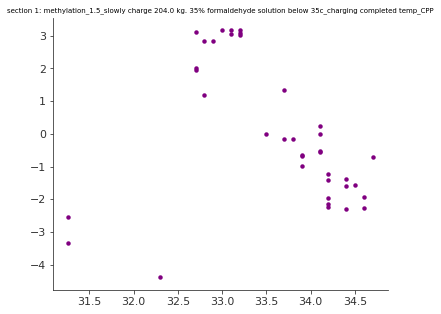

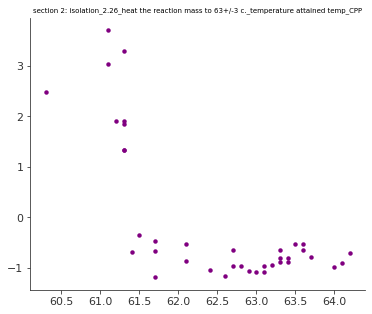

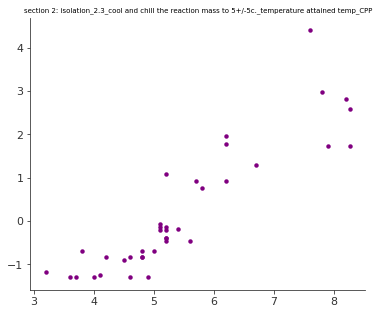

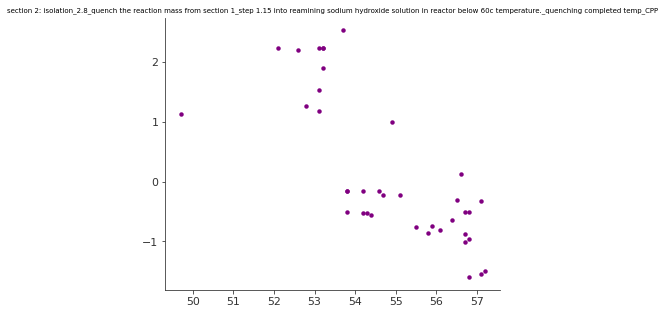

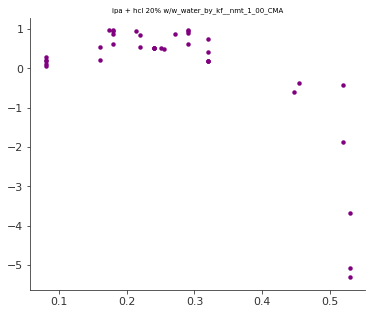

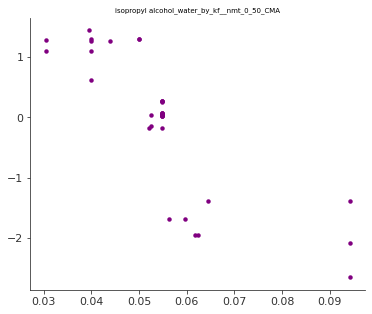

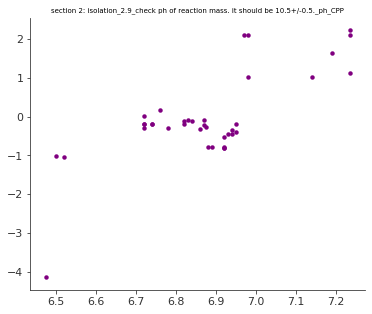

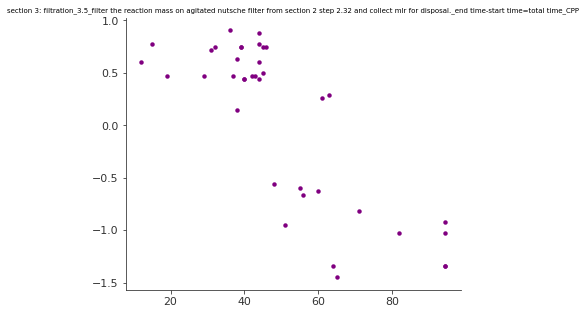

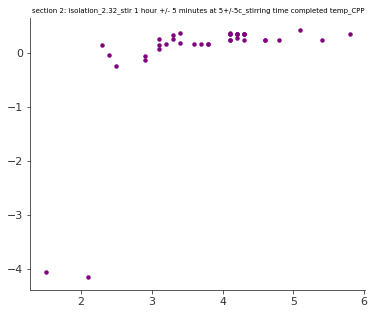

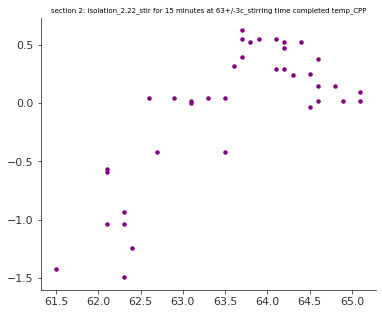

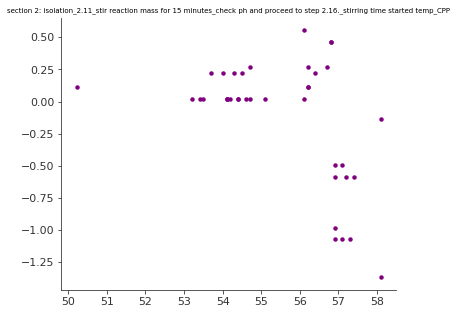

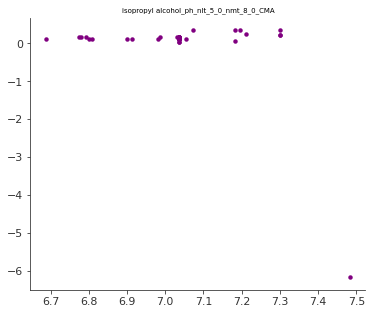

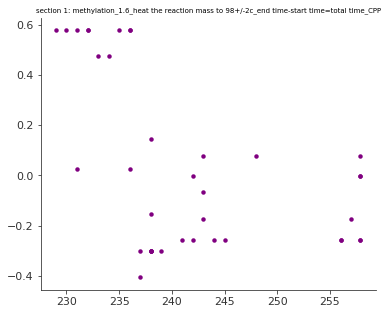

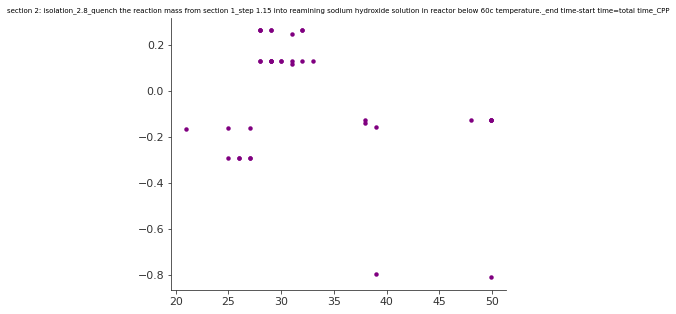

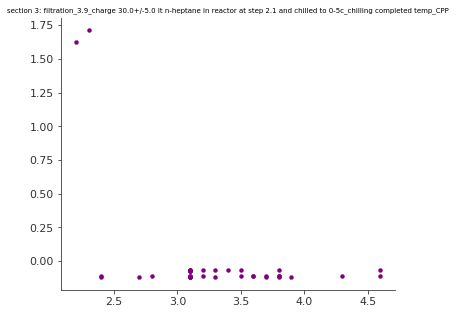

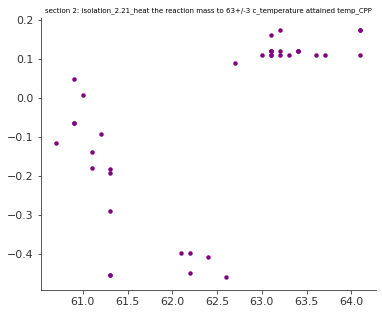

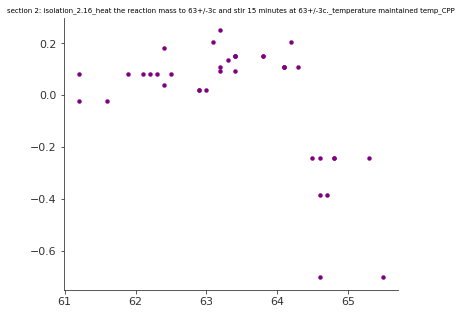

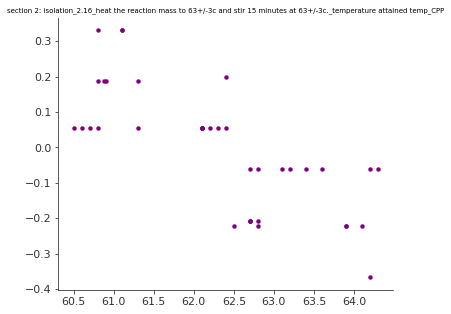

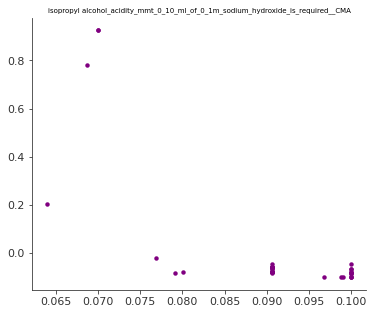

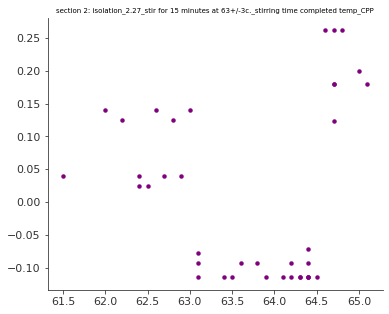

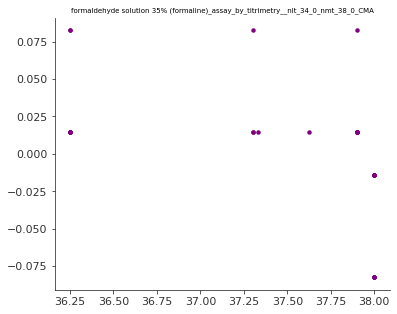

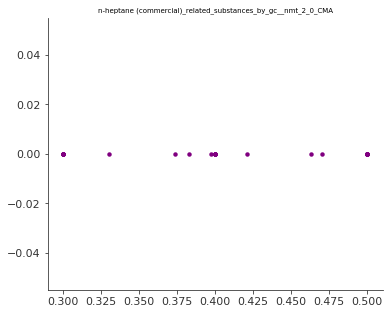

In [95]:
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
top_shap_features = shap_values_summary.index.tolist()
# with PdfPages(os.path.join(OUTPUT, "Shap_plots_fenofibrate_145mg_t047_4.5L_OEE_coating_spraying.pdf")) as pdf:
with PdfPages('Shap_plots_venlafaxine_section1_3.pdf') as pdf:
    for feature in top_shap_features:
        fig = shap.dependence_plot(
            feature,
            shap_values,
            X,
            interaction_index=None,
            alpha=1,
            dot_size=20,
            color="purple",
            show=False,
        )
        plt.title(feature, fontsize=7)
        plt.xlabel('')
        plt.ylabel('')
#         plt.title(feature)
        pdf.savefig()
#     fname = feature.replace('/','_').replace('*','').replace("(","_").replace(")","_") + ".png"

In [63]:
dummies_df =X.copy() 

In [64]:
columns=X.columns

In [65]:
len(columns)

22

In [66]:
X.columns

Index(['formaldehyde solution 35% (formaline)_assay_by_titrimetry__nlt_34_0_nmt_38_0_CMA',
       'ipa + hcl 20% w/w_water_by_kf__nmt_1_00_CMA',
       'isopropyl alcohol_acidity_mmt_0_10_ml_of_0_1m_sodium_hydroxide_is_required__CMA',
       'isopropyl alcohol_ph_nlt_5_0_nmt_8_0_CMA',
       'isopropyl alcohol_water_by_kf__nmt_0_50_CMA',
       'n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA',
       'section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP',
       'section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP',
       'section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._quenching completed temp_CPP',
       'section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._end time-st

In [67]:
y.columns

Index(['section_3_yield_target'], dtype='object')

#### update the Z

In [68]:
X.iloc[:, 5:].head(2)

n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
Batch Number                                                                 
HWC220312                                                   0.5              
HWC230030                                                   0.5              

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
Batch Number                                                                                                                       
HWC220312                                                  32.9                                                                    
HWC230030                                                  34.1                                                                    

              section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
Batch Number                                                                                                    
HWC220312                                                 231.0                                                 
HWC230030                                                 236.0                                                 

              section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._quenching completed temp_CPP  \
Batch Number                                                                                                                                                                                       
HWC220312                                                  54.2                                                                                                                                    
HWC230030                                                  53.7                                                                                                                                    

              section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._end time-start time=total time_CPP  \
Batch Number                                                                                                                                                                                             
HWC220312                                                  28.0                                                                                                                                          
HWC230030                                                  29.0                                                                                                                                          

              section 2: isolation_2.9_check ph of reaction mass. it should be 10.5+/-0.5._ph_CPP  \
Batch Number                                                                                        
HWC220312                                                  6.82                                     
HWC230030                                                  6.97                                     

              section 2: isolation_2.11_stir reaction mass for 15 minutes_check ph and proceed to step 2.16._stirring time started temp_CPP  \
Batch Number                                                                                                                                  
HWC220312                                                  54.5                                                                               
HWC230030                                                  54.1                                                                               

              section 2: isolation_2.16_heat the reaction mass to 63+/-3c and stir 15 minutes at 63+/-3c._temperature attained temp_CPP  \
Batch Nu

In [69]:
# Z = 246 ### define the section's mp starting iloc

Z = int(input('Assign Z:\n')) # \n ---> newline  ---> It causes a line break
print(Z)

Assign Z:
6
6


In [70]:
def summary_report(raw_data):
    """
    Return the language code detected
    :param raw_data: pandas.DataFrame for which the summary will be generated
    :return: pd.DataFrame with all distribution details
    """
    def _summary_report(x):
        x = x.reset_index(drop = True).copy()
        xmean = round(np.mean(x), 2)
        quant = {'mean' : xmean}
        for i in [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]:
            quant[str(i*100) + '% perc'] = round(x.quantile(i), 2)
        x_null = x.isnull().sum()
        x_fillrate = round(((len(x) - x_null)/len(x))*100, 2)
        quant['NA_count'] = x_null
        quant['Fill Rate'] = x_fillrate
        return(pd.Series(quant))
    ans_data = raw_data.loc[:, ~raw_data.columns.isin(['Batch_Number'])].apply(lambda x : _summary_report(x))
    return(ans_data)

In [71]:
summary_report_dt = summary_report(X)
summary_report_dt = summary_report_dt.T
summary_report_dt["Min"] = summary_report_dt.iloc[:, 1:12].min(axis = 1)
summary_report_dt["Max"] = summary_report_dt.iloc[:, 1:12].max(axis = 1)
summary_report_dt["Actual Range from Flat File"] = "("+summary_report_dt["Min"].astype("str") + "," + summary_report_dt["Max"].astype("str")+")"

In [72]:
#summary_report_dt.to_excel("D:\API\Yield Improvement\Amlodipine Mesylate\V2\Amlodipine Mesylate V2 Yield Summary Data.xlsx")

summary_report_dt.to_excel('13_'+prod+section+'summary_report.xlsx')
# summary_report_dt.to_csv(os.path.join(OUTPUT, r'13_'+prod+section+'MP_RANGE.csv'))


In [73]:
len(columns)

22

In [74]:
#identifying top 3rd batch
top_3rd_batch = y.sort_values(by = y.filter(regex = 'yield').columns.tolist(), ascending =False).iloc[2:3, :].index[0]
top_1st_batch = y.sort_values(by = y.filter(regex = 'yield').columns.tolist(), ascending =False).iloc[0:1, :].index[0]

In [75]:
#identifying bottom 3rd batch
bottom_3rd_batch = y.sort_values(by = y.filter(regex = 'yield').columns.tolist(), ascending =True).iloc[3:4, :].index[0]

In [76]:
print (top_1st_batch,top_3rd_batch, bottom_3rd_batch)

HWC220312 HWC220064 HWC220081


In [ ]:
#### READING FLATFILE WITH ACTUAL CMAs
# X_actual = pd.read_excel('x_actual.xlsx')

In [77]:
# dummies_df.iloc[:, Z:] =0

mean_data = pd.DataFrame([dummies_df.mean().to_list()],columns=columns)
mode_data = pd.DataFrame([list(dummies_df.agg('mode').iloc[0])], columns=columns)

rec_data = dummies_df.sort_values(by = dummies_df.index.name, ascending=True).iloc[-1:, :]
old_data = dummies_df.sort_values(by = dummies_df.index.name, ascending=False).iloc[-1:, :]

top_data = X.loc[[top_3rd_batch]]
bottom_data = X.loc[[bottom_3rd_batch]]
top_1st_data = X.loc[[top_1st_batch]]

# actual_data = 

# mp = X[X.columns[X.columns.str.contains('section')]].agg('median').tolist() 
# # starting point...median vals from historical data
mp = X.iloc[:, Z:].agg('median').tolist()
# mp_y_actual = y.agg('median').tolist()
# starting point...median vals from historical data


import ast
try_df= summary_report_dt.iloc[:, -1]
bounds = try_df.apply(lambda x: ast.literal_eval(x)).tolist()[Z:]

# bounds = [(51.0,233.0),(92.0,877.0),(15.0,28.3),(610.0,699.0),(26.0,28.7),(640.0,702.0),(26.2,29.5),(641.0,706.0)]
#bmr limits

In [92]:
bounds = [(36.0, 143.0),
 (28.9, 32.4),
 (12.0, 24.0),
 (32.7, 34.7),
 (19.0, 34.0),
 (229.0, 257.88),
 (11.0, 26.75),
 (19.0, 41.0),
 (21.0, 39.0),
 (6.48, 7.24),
 (23.0, 42.0),
 (60.5, 64.3),
 (42.0, 88.88),
 (44.0, 143.0),
 (14.0, 25.0),
 (34.0, 169.0),
 (266.0, 370.0),
 (2.3, 5.8),
 (5.1, 8.85),
 (12.0, 38.0)]

In [78]:
bounds

[(31.26, 34.7),
 (229.0, 257.88),
 (49.7, 57.2),
 (21.0, 49.88),
 (6.48, 7.24),
 (50.21, 58.1),
 (60.5, 64.3),
 (61.2, 65.5),
 (60.7, 64.1),
 (61.5, 65.1),
 (60.3, 64.2),
 (61.5, 65.1),
 (3.2, 8.28),
 (1.5, 5.8),
 (12.0, 94.5),
 (2.2, 4.6)]

In [93]:
mp_data = rec_data.copy()
mp_data.iloc[:,6:] = mp

In [94]:
top3_data = top_data.copy()
top3_data.iloc[:,5:]

n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
Batch Number                                                                 
HWC220064                                                   0.3              

              section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP  \
Batch Number                                                                                                            
HWC220064                                                   126                                                         

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._charging completed temp_CPP  \
Batch Number                                                                                                                            
HWC220064                                                  32.3                                                                         

              section 1: methylation_1.4_charge 220.0 +/-10 lt. purified water._end time-start time=total time_CPP  \
Batch Number                                                                                                         
HWC220064                                                  13.0                                                      

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
Batch Number                                                                                                                       
HWC220064                                                  33.0                                                                    

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_end time-start time=total time_CPP  \
Batch Number                                                                                                                              
HWC220064                                                    31                                                                           

              section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
Batch Number                                                                                                    
HWC220064                                                 243.0                                                 

              section 1: methylation_1.7_stop steam_stop agitator and remove about 5ml reaction mass for tlc._end time-start time=total time_CPP  \
Batch Number                                                                                                                                       
HWC220064                                                  14.0                                                                                    

              section 1: methylation_1.15_charge 600.00 +/- 20.00 lt. of n-heptane to the reaction mass using aodd pump._end time-start time=total time_CPP  \
Batch Number                                                                                                                                                  
HWC220064                                                  30.0                                                                                               

              section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._end time-start time=total time_CPP  \
Batch Number                                                                                                                                                                                             
HWC220064                                                  21.0                                                                                                       

In [95]:
raw_data = rec_data.iloc[:,0:6].values[0]
top3_data.iloc[:,0:6] = raw_data
top3_data.iloc[:,5:]

n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
Batch Number                                                                 
HWC220064                                                   0.5              

              section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP  \
Batch Number                                                                                                            
HWC220064                                                   126                                                         

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._charging completed temp_CPP  \
Batch Number                                                                                                                            
HWC220064                                                  32.3                                                                         

              section 1: methylation_1.4_charge 220.0 +/-10 lt. purified water._end time-start time=total time_CPP  \
Batch Number                                                                                                         
HWC220064                                                  13.0                                                      

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
Batch Number                                                                                                                       
HWC220064                                                  33.0                                                                    

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_end time-start time=total time_CPP  \
Batch Number                                                                                                                              
HWC220064                                                    31                                                                           

              section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
Batch Number                                                                                                    
HWC220064                                                 243.0                                                 

              section 1: methylation_1.7_stop steam_stop agitator and remove about 5ml reaction mass for tlc._end time-start time=total time_CPP  \
Batch Number                                                                                                                                       
HWC220064                                                  14.0                                                                                    

              section 1: methylation_1.15_charge 600.00 +/- 20.00 lt. of n-heptane to the reaction mass using aodd pump._end time-start time=total time_CPP  \
Batch Number                                                                                                                                                  
HWC220064                                                  30.0                                                                                               

              section 2: isolation_2.8_quench the reaction mass from section 1_step 1.15 into reamining sodium hydroxide solution in reactor below 60c temperature._end time-start time=total time_CPP  \
Batch Number                                                                                                                                                                                             
HWC220064                                                  21.0                                                                                                       

In [96]:
best_model.predict(top3_data)[0]

array([266.12918], dtype=float32)

In [97]:
top3_cpp = top_data.iloc[:,6:].values[0]
top3_cpp

array([126.   ,  32.3  ,  13.   ,  33.   ,  31.   , 243.   ,  14.   ,
        30.   ,  21.   ,   7.235,  28.   ,  63.6  ,  53.   , 143.   ,
        21.   ,  34.   , 271.   ,   4.6  ,   6.1  ,  12.   ])

In [ ]:
# actual_data = X_actual.set_index('Batch Number')

In [ ]:
# actual_data

In [98]:
len(bounds)

20

In [99]:
y.columns

Index(['section_3_yield_target'], dtype='object')

In [100]:
y_max = [y.filter(regex='yield').max()[0]]
y_max

[269.08]

In [101]:
top3_cpp

array([126.   ,  32.3  ,  13.   ,  33.   ,  31.   , 243.   ,  14.   ,
        30.   ,  21.   ,   7.235,  28.   ,  63.6  ,  53.   , 143.   ,
        21.   ,  34.   , 271.   ,   4.6  ,   6.1  ,  12.   ])

## optimizer_1

In [102]:
y_train.columns.to_list()

['section_3_yield_target']

In [103]:
# X.iloc[:, Z:] = actual_data
best_model.predict(top3_data)[0]

array([266.12918], dtype=float32)

In [104]:
best_model.predict(top_1st_data)[0]

array([268.5482], dtype=float32)

In [105]:
best_model.predict(mp_data)[0]

array([257.37384], dtype=float32)

In [134]:
# import re

# L = [
#    "Particle_Size_By_Laser_Diffaraction_D90_Nmt_300_0_Mm_Ten ofovir_CQA",
#    "Polymorphic_Identity_By_Dsc_Major_Endotherm_With_Onset_Te mperature_At_About_114_00_C_NIt_111_00_Nmt_117_00_C-Tenofovir_CQA",
#    "Polymorphic_Identity_By_Dsc_or_Endotherm_With_Onset_Tempe rature_At_About_107_00_C_NIt_104_00_Nmt_110_00_C__Tenofov ir CQA",
#    "Related_Substances_By_G_Method_B_Content_Of_Chlorometh y_Isopropyl_Carbonate_Nmt_0_10_Tenofovir_CQA",
#    "Related_Substances_By_G_Method_B_Total_Impurities_Method_A_Method_B_Nmt_1_0__Tenofovir CQA",
#    "Related_Substances_By_Hplc_Method_A_Impurity_A_Monoproxil_Impurity_Nmt_0_80__Tenofovir_CQA",
#    "Related_Substances_By_Hplc_Method_A_Impurity_B_Nmt_0_15__Tenofovir_CQA",
#    "Related_Substances_Ву_Hplc_Method_A_Unspecified_Impurity_Nmt_0_10__Tenofovir_CQA",
#    "Residual_Solvents_By_Gc_Method_I_|sopropyl_Acetate_Nmt_4000_Ppm__Tenofovir_CQA",
#    "Residual_Solvents_By_G_Method_I_Isopropyl_Alcohol_Nmt_3000_Pom_ Tenofovir_CQA"
# ]

# output_nmt = []
# output_nlt = []

# for string in L:
#     values_nmt = re.findall(r"(?i)Nmt_([\d.]+)", string)
# #     values_nmt = re.findall(r'Nmt_(\d+(\.\d+)?)', string)
#     values_nlt = re.findall(r"(?i)NIt_([\d.]+)", string)
# #     values_nlt = re.findall(r'NIt\s+(\d+(\.\d+)?)', string)
#     print (values_nlt)
#     print (values_nmt)
#     output_nmt.append([float(value) if '.' in value else float(value) for value in values_nmt])
#     output_nlt.append([float(value) if '.' in value else float(value) for value in values_nlt])

# print("Numbers after 'Nlt_':", output_nlt)
# print("Numbers after 'Nmt_':", output_nmt)


In [106]:
#optimization code to run
import math
def cost_function(mp, model, new_data_norm,y_max):
    
    print(mp)
    new_data_norm.iloc[:, Z:] = mp
    ## slicing from 1 as we are not including duration target
    y_pred = model.predict(new_data_norm)[0][0]
#     y_pred = model.predict(new_data_norm)[0]
    y_true = y_max
 

    diff = y_true[0] - y_pred
    cost1 = diff**2
    cost = np.sqrt(cost1)
    # cost = np.sqrt(cost1)*0.2 + np.sqrt(cost2)*0.8
    print(cost)

    return cost                

bound_ranges = np.array([max_value - min_value for min_value, max_value in bounds])
step_sizes = bound_ranges / 10

In [352]:
# #optimization code to run
# import math
# def cost_function(mp, model, new_data_norm,mp_y_actual):
    
#     print(mp)
    
#     new_data_norm.iloc[:, Z:] = mp
#     y_pred = model.predict(new_data_norm)[0]
#     y_true = mp_y_actual
# #     c = y_pred[0]
# #     y = y_pred[1]
# #     cost1 = y
# #     cqa_bounds = []
    
#     num_outputs = len(y_true)
#     cost = 0
#     for i in range(num_outputs):
#         diff = y_true[i] - y_pred[i]
# #         print(diff)
#         cost += np.sum(diff**2)
# #         print(cost)
#     cost = np.sqrt(cost)
#     print(cost)

#     return cost                

# bound_ranges = np.array([max_value - min_value for min_value, max_value in bounds])
# step_sizes = bound_ranges / 10

### DE_optimizer_data

In [107]:
from scipy.optimize import differential_evolution

In [108]:
top3_data

formaldehyde solution 35% (formaline)_assay_by_titrimetry__nlt_34_0_nmt_38_0_CMA  \
Batch Number                                                                                     
HWC220064                                                  38.0                                  

              ipa + hcl 20% w/w_water_by_kf__nmt_1_00_CMA  \
Batch Number                                                
HWC220064                                            0.25   

              isopropyl alcohol_acidity_mmt_0_10_ml_of_0_1m_sodium_hydroxide_is_required__CMA  \
Batch Number                                                                                    
HWC220064                                              0.090639                                 

              isopropyl alcohol_ph_nlt_5_0_nmt_8_0_CMA  \
Batch Number                                             
HWC220064                                     7.035181   

              isopropyl alcohol_water_by_kf__nmt_0_50_CMA  \
Batch Number                                                
HWC220064                                         0.05471   

              n-heptane (commercial)_related_substances_by_gc__nmt_2_0_CMA  \
Batch Number                                                                 
HWC220064                                                   0.5              

              section 1: methylation_1.2_charge 300.00 kg. vf-ii into the reactor._end time-start time=total time_CPP  \
Batch Number                                                                                                            
HWC220064                                                   126                                                         

              section 1: methylation_1.3_charge 384.00 kg. of formic acid and start stirring unde vacuum._charging completed temp_CPP  \
Batch Number                                                                                                                            
HWC220064                                                  32.3                                                                         

              section 1: methylation_1.4_charge 220.0 +/-10 lt. purified water._end time-start time=total time_CPP  \
Batch Number                                                                                                         
HWC220064                                                  13.0                                                      

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_charging completed temp_CPP  \
Batch Number                                                                                                                       
HWC220064                                                  33.0                                                                    

              section 1: methylation_1.5_slowly charge 204.0 kg. 35% formaldehyde solution below 35c_end time-start time=total time_CPP  \
Batch Number                                                                                                                              
HWC220064                                                    31                                                                           

              section 1: methylation_1.6_heat the reaction mass to 98+/-2c_end time-start time=total time_CPP  \
Batch Number                                                                                                    
HWC220064                                                 243.0                                                 

              section 1: methylation_1.7_stop steam_stop agitator and remove about 5ml reaction mass for tlc._end time-start time=total time_CPP  \
Batch Number                                                                                                                                       
HWC220064                                                  14.0    

In [109]:
top3_cpp

array([126.   ,  32.3  ,  13.   ,  33.   ,  31.   , 243.   ,  14.   ,
        30.   ,  21.   ,   7.235,  28.   ,  63.6  ,  53.   , 143.   ,
        21.   ,  34.   , 271.   ,   4.6  ,   6.1  ,  12.   ])

In [110]:
j =['top3']

for k in j:
    def cost_function_DE(top3_cpp):
        return cost_function(top3_cpp, best_model, eval(k+'_data'),y_max)
    print (j)
    globals()['result_'+k+'_optde'] = differential_evolution(cost_function_DE, bounds=bounds, strategy='best1bin', maxiter=60, popsize=15, mutation=(0.5, 1), recombination=0.7, tol=0.02)
    globals()['recommended_mp_' + k + '_optde'] = eval('result_'+k+'_optde').x

['top3']
[121.64425873  31.29966992  17.04286326  32.94148088  26.82905935
 252.88470138  19.70669455  21.00233061  37.52416165   6.93046813
  34.41853315  60.72297931  68.07734765  62.53268962  17.47018233
  71.34227409 344.7717735    4.02269898   6.48619025  25.54726878]
14.514799194335922
[106.48629005  32.06442197  12.86753921  33.47147277  21.31194731
 229.77138989  11.47442088  25.45288047  25.32324665   7.23129214
  25.88045985  61.62801258  83.02294317 115.88407783  21.4885931
  73.99232528 293.53030535   4.98550939   8.12563859  14.87663044]
6.123731689453109
[139.8398604   31.17359344  18.53673256  34.03111989  19.02821036
 229.34180002  18.36826431  32.64151478  27.09153563   6.88966135
  23.62567428  62.92722007  47.1026368  134.4448512   19.51497916
  76.1823913  334.46721265   5.28129886   7.96064486  26.5916822 ]
10.764448242187484
[ 36.51859562  31.22626501  15.70284003  34.3231639   29.2850341
 247.91591115  14.06015882  19.58586421  37.19017674   6.72743756
  27.08669

10.055860595703109
[105.49960695  29.57838108  21.05921908  33.98943563  33.28863122
 241.13950076  13.79865613  34.6312392   22.00814056   6.89806555
  40.22705495  60.94737942  86.55121109 134.88339343  15.39886296
  74.14712453 338.92499184   5.23031391   7.28932862  21.24965285]
9.868116455078109
[ 45.76092008  30.648476    12.04699685  33.06521269  21.05820603
 235.67284577  14.84070076  34.87085592  38.36448821   6.87955472
  41.71183614  64.06637176  66.0476372   64.03200048  22.25769666
 133.54578632 333.37318073   2.98588621   5.5543752   21.71777165]
15.081342773437484
[ 71.79903035  29.50559607  22.45536588  34.06821026  21.74070843
 257.28725501  20.55448133  40.49037179  31.49128845   6.70788257
  33.56954446  61.2446704   55.8862425  140.14885366  22.36336935
  36.583071   336.79653009   2.69624415   7.28369098  22.40827773]
10.842695312499984
[ 95.2513845   30.43609606  12.3107348   33.42013927  19.6880456
 256.81103719  15.99696639  19.40213847  30.11197795   6.7759162


5.597333984374984
[104.73346795  30.36048378  14.84079521  33.95725155  32.29725966
 242.06207344  19.81662035  32.82153772  31.06140261   6.95787885
  24.19448778  62.86432279  59.15260405  58.8895696   20.26335279
  84.8897601  351.60902825   4.19791211   6.46388462  27.50008695]
15.285825805664047
[103.53815476  30.4886139   18.83838752  33.83753359  24.69448027
 241.69027251  18.11355926  19.73687844  32.763205     7.07733143
  33.77960723  61.00589103  47.162986   120.16553209  22.43550442
  43.50933085 367.39652042   5.0564335    6.24559893  36.74246971]
11.728437499999984
[124.95251843  30.90050262  19.22817186  33.51009679  19.57433345
 244.21121175  22.76611222  38.52482489  35.70020218   6.84546894
  30.13775728  62.50061578  53.66298718  68.17932141  17.00603286
 122.07475201 362.00080791   4.85408827   7.65066992  35.66635757]
15.379743652343734
[ 55.03687658  30.13804795  22.77664471  33.29034878  29.18246459
 247.53806169  16.90879183  22.82306537  30.18727977   7.0521348

6.221784667968734
[100.78961946  29.41474808  13.64942679  32.90295117  24.18255905
 255.37786925  14.18581104  27.01348003  32.85906609   7.05833876
  34.49904619  63.69861312  76.59916112  89.3328977   15.0597423
 107.82816496 320.76960908   2.3593352    6.73962554  23.59306452]
10.732221679687484
[ 87.11958575  29.82327666  15.7915123   34.29335005  27.97737405
 257.74247166  14.77518819  29.81989854  35.4230307    6.77378165
  35.12960851  64.01031556  49.77284617  90.18697481  15.58411377
  57.21250134 317.07277477   4.86273966   6.88250686  21.27337412]
8.397932128906234
[ 80.45841899  30.91389754  12.39176989  33.81565205  25.59059645
 236.05968953  25.5643076   40.0999043   24.30454373   6.83195176
  28.72737782  63.77382263  69.53207168 139.13693902  14.21288494
 121.20765608 343.53204185   4.69749827   8.02204565  31.74971699]
10.427442626953109
[ 72.96483563  28.96729319  21.48222311  33.56672388  22.68122359
 244.97476947  17.12783253  22.30301505  24.70175417   6.78925391


3.651624755859359
[ 89.0612205   29.75926724  21.86712632  33.49327758  20.77132151
 238.76552726  25.54118989  19.93861168  26.30731162   6.68316418
  35.07120382  61.21706027  50.06709895 122.05784463  24.49651242
 159.32365067 316.84016088   4.74595669   7.4903302   16.73065493]
11.429700927734359
[ 50.8627108   30.94077624  19.09722275  32.96670257  31.29413261
 231.85021614  21.21881127  30.57251992  24.51785141   7.01332461
  29.47947416  62.18310423  49.27365019 116.36773757  15.52894237
  88.64446879 348.76137305   3.01718664   6.91743959  20.01899677]
3.654920654296859
[ 97.67967278  29.4371884   14.5694547   33.36765438  28.26858495
 238.27673292  14.71365208  22.27866818  34.86469266   6.93673401
  37.15823632  63.22981342  54.3985104   93.67757681  22.913357
  89.29109921 363.86320407   5.41839245   7.42982343  24.89779337]
11.222211914062484
[ 74.99007585  30.46434596  19.95175549  34.44368018  28.5816109
 254.2567329   14.46780482  35.88712277  21.71353102   6.80781389
  

7.533521728515609
[121.47778032  28.99589251  13.94076868  33.74995927  28.50179476
 236.79762256  16.49835147  19.08054616  25.54839977   6.90898194
  39.80364047  64.28201217  83.63484501 128.00797676  22.6406076
  35.95067891 346.85224301   4.10551844   8.60510986  20.39313774]
11.785841064453109
[ 59.38309049  30.27862869  23.38758703  33.31323751  32.00084494
 242.68529067  22.74710272  36.90393948  37.09989044   7.00415005
  31.33037816  62.36087846  45.75178466  73.48709159  24.6557744
 140.65445126 283.06612179   4.04679751   7.85700363  36.65675077]
3.771802978515609
[125.19652472  29.35549775  18.785021    34.34070576  27.90876156
 248.41548928  17.60484677  29.72541464  30.007206     6.91234138
  31.56585312  61.97739421  78.70673775 138.00163402  16.76308772
 103.91025438 299.814941     2.34037542   6.33039011  23.2526191 ]
7.029493408203109
[137.78200461  29.28812555  21.72469442  34.38458474  20.32262254
 232.05624231  17.45138175  25.65407268  32.48753388   6.82943407
  

10.359205322265609
[ 85.05883814  31.86415611  17.10216919  32.76907118  27.59962776
 246.09614859  11.71391841  36.28912458  28.85230447   6.60357695
  37.50843868  61.40157585  51.5581866  100.44761167  20.17701533
 167.45058232 295.31043196   5.7338531    6.71890453  18.79413919]
2.791059570312484
[ 86.6628374   30.01728471  15.58829418  34.29004886  20.15235761
 257.19268509  23.05232835  31.94701935  36.55386088   6.50543998
  36.27028781  63.81144061  80.24428212  66.70720629  19.44133005
  67.01449054 339.42297625   4.01045851   7.63894415  34.82829758]
13.049177246093734
[112.70668778  29.13242553  23.80359754  34.47394808  23.49404208
 231.91815812  12.0506224   23.93365635  36.91585401   6.73067793
  35.35823179  61.98838202  56.45619059 136.95246659  17.10361363
 144.77840675 360.77106598   5.21753119   7.63502032  12.87201479]
10.464155273437484
[ 94.2565795   32.35415463  16.82326707  34.20645825  20.57688769
 229.09089909  23.49050563  22.51763774  23.42938907   6.6919766

1.658948974609359
[ 90.30486719  30.5697965   19.2893675   33.73635435  26.0621245
 255.18083301  25.87847899  23.53288767  38.45351949   6.97186114
  28.56895395  62.91803528  63.73696364  93.48541615  22.66032294
 135.22250052 306.16619815   2.57693722   8.50617322  24.35779489]
7.970045166015609
[123.15028566  29.88115218  14.20480995  33.50367366  33.4199538
 232.64422966  25.06357399  39.92905868  33.21530355   7.16667913
  31.25863033  61.29530303  54.62180182  66.41048991  18.27711022
 138.83306965 363.32864056   4.67349424   5.52855968  30.48263414]
15.537092285156234
[ 74.08313792  29.87327912  23.93974413  33.02964215  20.96360824
 251.9415097   23.08662058  36.07021991  32.02837458   6.68063548
  37.85770556  62.23658875  84.82143235 131.73787375  17.73073172
  73.09649612 271.46666131   3.9657834    8.83650077  25.71885427]
3.298444824218734
[133.6127339   31.85265527  14.90938708  34.582811    21.16753704
 253.83843306  26.37717512  37.67881915  28.67004721   6.98099023
  

12.642347412109359
[112.13615641  30.61168002  23.8546665   32.70947666  30.73392362
 255.54386923  15.71865446  34.38139064  25.43544941   6.48275801
  24.34824259  61.59600827  47.93227544 106.32924064  23.68464429
 138.9078366  348.25535592   5.04357152   5.81869204  37.34652843]
10.645277099609359
[ 52.62259193  30.55488736  22.27860708  33.28192875  20.52445354
 249.45745291  18.85999518  32.75734912  24.65489802   6.61030417
  34.37702186  63.45863449  55.13827094  79.87124323  14.0562725
  90.70490751 365.72207597   3.65876019   8.5938266   33.38820456]
5.516798095703109
[116.23440599  32.12699884  15.60986847  33.98613204  30.27509598
 239.47395422  17.67921719  30.94038217  33.34463869   7.07122841
  30.96145126  62.63886304  83.98042023  68.74350826  21.37478108
 163.67338067 335.36856272   4.4506342    7.46483948  17.83559866]
16.78425415039061
[ 56.81460141  29.64258416  17.72354931  34.67486417  30.41121595
 249.16546097  23.36671872  40.69661968  37.63613328   6.87018255


13.544614868164047
[133.12016587  31.10713494  19.60874363  33.71931014  28.84307979
 249.76159287  25.45362162  32.3574931   25.27740659   6.61745407
  30.56278716  60.87258801  44.0012748   61.61368951  20.38863912
  84.65639669 284.87303371   4.95017237   6.61320375  23.6488897 ]
11.014600830078109
[ 37.25844882  29.20520075  14.60885328  33.69194713  31.6738399
 246.30138979  22.41606663  25.36583177  21.87425935   6.66619029
  34.47961429  63.69870893  61.66891671  92.84907523  22.26108143
  71.69590808 307.27472018   3.25158686   8.16480525  26.66662305]
4.630872802734359
[ 38.11545227  32.03116611  21.21307504  33.9940496   19.93769942
 248.96958051  19.28557375  35.62778053  22.53537368   6.89255678
  38.51279823  61.48005854  65.58718145 136.18633479  22.92946781
  70.79884492 294.60917806   3.94529037   7.12590593  20.65368323]
5.928632812499984
[ 73.61499704  30.92163129  22.34867737  33.44465114  31.68786517
 240.66198515  20.92025444  36.05877644  23.20702722   7.21969055


6.799970703124984
[ 78.83147918  31.47374519  18.64436364  32.87123101  27.67811448
 253.93911527  24.83454789  26.17156936  21.94197644   6.87106484
  38.58990291  62.85704291  51.37466052  88.54332498  18.9493786
 131.50855993 282.32457089   3.20158756   7.00309421  28.21091368]
4.168378906249984
[123.02642782  30.15621979  20.71355006  33.73022648  24.19768433
 247.87736883  19.31393457  26.90432578  29.30864126   7.04659914
  39.80357377  62.47790483  48.57649512 110.70909372  19.29159914
 144.56692858 287.74007905   5.5409183    7.85446473  25.09900347]
5.650953369140609
[ 67.90179522  31.30813836  21.80188795  33.63985726  29.06485741
 243.04502913  11.75496903  27.25627106  24.0918862    6.84970071
  40.46081918  63.82599407  48.51662536  73.36319223  22.75010113
  58.0692532  272.2659785    4.73661026   7.24046281  17.47774919]
3.363447265624984
[ 85.52878845  30.98438702  12.53862905  33.7038535   30.15013926
 244.35267568  20.05353089  30.10223878  27.04170482   7.19956064
  

2.341779785156234
[ 64.11325683  31.28888388  20.13986876  33.97835995  25.82979414
 237.48055961  23.53674173  27.57236721  32.06014737   6.50748573
  33.77531484  61.17339138  70.90787304  59.39681026  22.84408008
 139.89146485 324.89216273   3.42297668   8.24069322  27.30025114]
17.28382690429686
[ 60.38993418  32.29726771  18.51893457  33.42143049  23.81576327
 244.44370823  15.7335112   25.8227585   35.64876376   6.66486473
  38.66346521  63.48895748  61.94837566 112.481319    14.26811225
  78.45608058 266.81485542   4.17130103   8.45615703  36.76255635]
1.897535400390609
[ 72.70639084  31.65722607  19.15930718  33.16798231  28.12891768
 248.12689143  12.71182481  32.50020724  30.49754247   6.95275121
  30.19535107  64.24248352  57.58583799  88.60128773  19.98138955
  99.77583483 356.13607937   5.31361896   8.11156519  28.35214256]
8.331220703124984
[142.93524489  31.32599006  23.1118494   32.80614062  33.31612652
 254.12496139  15.31850999  25.36775583  21.76506745   6.54761126
 

5.289045410156234
[ 81.81113956  31.04974672  20.65164496  33.40163374  27.59919241
 249.00594053  18.50093631  24.16555493  22.42582147   7.02385136
  38.64884241  61.04563492  79.48001645 141.51027406  20.34724304
  61.24918078 280.43208314   3.73614357   7.52273831  26.75729014]
4.453962402343734
[ 70.60974683  31.25937393  20.0773561   33.82448498  29.04281366
 241.73191194  18.91119958  33.95852604  30.46310362   6.90559622
  37.28630545  63.42030391  56.54623681  92.17203727  22.00297401
  56.33844801 313.53537355   3.21866919   6.65955349  17.45517835]
10.025648193359359
[ 44.12340244  31.11167268  22.64906664  32.82908846  25.9789324
 248.45858373  11.4584434   40.10572042  36.83446646   6.52716221
  39.80798689  60.80396247  49.86658663  76.43498521  21.44916603
 126.51303313 275.17268008   5.69899685   5.88034691  24.99544467]
0.7372875976562341
[ 60.22816575  29.68573438  20.7742923   34.11986939  26.49205224
 252.70480532  22.42068554  31.03666705  27.17100577   6.60495747


0.4983654785156091
[ 50.08689268  29.4371884   17.47739645  33.36765438  28.2386963
 250.08929083  16.91040378  29.14042584  29.52198229   6.52051023
  40.52810826  63.22981342  53.22882924  96.23386547  22.913357
  62.16743167 283.77918129   4.25772613   8.33383886  24.89779337]
3.145612792968734
[ 71.06535622  29.88840156  20.72732069  33.88313818  20.02743544
 253.02934812  14.46780482  28.72048826  21.71353102   6.54459241
  35.94316704  63.75067029  65.19698655  75.49700002  21.55513923
  94.17340903 348.14226808   5.27911558   8.77421799  29.46911435]
10.905775146484359
[130.278699    30.75159466  22.26293024  34.41629481  21.88531489
 240.50030403  17.16249365  34.60561773  22.82069706   6.76240143
  40.72542874  63.36678679  48.41243441  56.30285611  17.65338018
  77.87023506 315.91715166   4.28332849   7.9305787   25.59607374]
13.602857666015609
[126.23669503  30.39650531  21.68041031  33.32053509  30.10087343
 252.53756447  24.62474065  36.0196264   21.06458871   6.58085064
 

6.598096923828109
[ 62.26250136  30.71407134  21.12297357  33.18981689  22.26458097
 231.55208196  20.11847689  29.84610614  32.88524116   6.62981104
  23.68772415  63.18595586  60.16096007 123.03136416  17.89572157
  92.93264909 314.0760662    3.35197083   7.7788655   30.08859519]
4.568464355468734
[115.02505776  30.99008876  18.89867277  32.99650107  31.7797325
 233.14892693  16.02420437  22.88201439  24.67554354   7.05206447
  29.03121728  62.3889459   50.51714277  98.79720468  15.7473945
 138.22292584 293.47116641   5.20301094   5.84953696  31.9774826 ]
5.408308105468734
[121.47778032  30.36862293  21.77936516  33.37165955  24.68578633
 240.21129857  22.36747707  19.08054616  25.86448038   6.81021085
  41.91685617  64.16163296  68.90772182  86.17327842  19.23368316
  35.95067891 293.10549607   4.90472384   8.44634677  20.39313774]
7.092512207031234
[ 59.38309049  30.42206961  19.10557227  33.73231278  30.23906956
 242.68529067  21.76577518  30.76606243  37.09989044   6.62488301
  3

5.547498779296859
[117.45588338  31.90234111  18.68310927  33.06296088  29.22913533
 240.56067583  13.30385714  40.03563396  25.40242016   6.61457336
  25.25477583  63.38238452  43.64989629 142.23470901  21.38454257
  56.44103131 270.95579701   4.97943715   5.28370437  18.1503776 ]
2.042677001953109
[ 40.90000484  31.57264305  17.58833979  33.38119829  22.21239922
 234.52895085  15.33093002  23.61543162  26.18956473   6.76303415
  27.69010314  63.96564851  52.1435538   74.1917383   23.94373318
  95.10815467 351.24036123   3.52703749   7.79555409  30.56949776]
5.933118896484359
[ 82.02630794  30.71059325  13.52858595  33.61687098  24.77204356
 237.01917002  13.69809555  28.90305339  30.58828101   6.76722695
  23.04108121  62.84119424  56.38884981 136.29752826  22.2039182
  95.56473796 281.79615596   4.29132542   7.83602818  33.34924918]
3.664228515624984
[ 37.84145634  30.83990439  17.43225688  32.96110128  25.65814477
 234.3002852   11.18856969  32.49342649  23.43949224   7.17875428
  

7.204359130859359
[ 40.45767364  30.09594722  13.51677775  34.14905967  28.2232209
 241.52210665  21.12258871  36.68060096  28.54498031   6.50322293
  31.35492038  61.96823127  60.70295276 119.22003752  18.72424831
 119.38995143 297.00103908   5.21162059   7.72940958  30.98620453]
2.196333007812484
[ 80.16337544  31.90330765  14.55055113  34.01653281  29.24230041
 237.81905457  19.99445178  22.06946704  26.00507094   6.53484875
  23.81519596  62.81497234  66.4226321  138.21407834  22.57570211
 137.78380056 283.12238732   5.11871836   7.80923818  12.18916207]
6.660871582031234
[ 96.7499804   30.70719925  23.47214112  34.46520794  24.6653839
 240.40693823  16.53815496  20.92286451  34.50573369   6.75709779
  27.14584498  63.27375023  75.1461255   99.50166291  21.26516243
  83.12586981 286.73336173   4.07708359   7.75519377  34.31298759]
7.275739746093734
[ 38.65690178  30.43613486  20.29574238  34.30465397  30.33359299
 231.78480012  19.93450434  28.41484731  27.31632298   6.90310272
  3

2.860212402343734
[102.08322691  29.5700985   19.01851941  33.70639135  33.56132589
 256.14150818  26.67491833  30.84614173  25.54325347   7.01653816
  34.9240123   63.38148147  83.26385461 113.06199351  20.03661913
  90.01679443 301.17872725   4.7862509    7.93026424  24.9182242 ]
5.012159423828109
[ 47.80316797  31.62414293  14.74862582  33.33310373  26.76720815
 238.79291657  14.27274335  29.9613103   21.7965377    6.78471878
  36.24832003  62.11603259  56.72119121  63.10154328  24.75465627
 131.29309397 305.0927438    5.11283596   7.25017727  22.72691025]
11.872694091796859
[ 49.88770921  30.8818384   16.35868674  34.12707199  32.63998753
 232.59261214  23.79123821  34.32870759  21.21419816   6.95169316
  27.54254135  62.29678527  60.44086883  44.7378333   21.16951039
 111.07748516 277.67124151   4.94877881   7.31306488  22.61235412]
10.436994628906234
[ 88.0678376   30.43492869  20.10606283  33.32284432  19.10612161
 249.9178366   23.72424104  39.09385066  26.88624781   6.79396624

9.480970458984359
[ 38.1022463   30.62760072  14.63663988  33.13253415  29.31986132
 248.15824526  21.10742343  34.9617308   30.28177776   6.57489983
  32.37369062  63.98988565  66.31089232  55.32474614  19.96105962
  77.90278223 281.3917269    4.03009965   7.13900455  17.5017676 ]
8.336439208984359
[ 38.46407976  31.92156681  14.24364199  33.58791875  33.90683769
 245.3744007   18.66880064  29.63544863  22.31606909   7.06056617
  28.91187952  63.85622527  47.71174942  73.55602596  14.1205414
 124.27395044 275.11073853   4.96452835   7.44496421  13.25737434]
0.20872680664064092
[ 51.89127434  31.32914814  16.33919559  33.53499163  25.71151674
 252.86778922  24.83529307  29.43303526  24.34136001   6.94750182
  33.66695255  63.0343023   52.60750183 112.13593064  15.90380832
 108.30358199 269.04766552   4.73038118   5.11004273  23.48886925]
0.6425610351562341
[ 47.54929171  30.72714776  14.704381    33.92053725  32.8624916
 232.33754173  25.18701589  31.06706386  38.54535343   6.99228879


8.240644531249984
[ 41.2330236   30.89762797  19.74251259  32.90239581  23.20263386
 244.34437777  18.7625663   26.20685252  21.95355511   6.6689507
  23.3249634   63.78990521  44.52079927 103.01025159  20.63605521
  79.60760094 304.79892358   3.59195798   7.07017039  25.8452859 ]
4.756849365234359
[ 37.1872713   31.47661787  20.47314601  34.40654481  30.42923037
 253.11458431  21.86162422  20.43836087  26.30125117   7.22960338
  29.78304145  64.03766168  42.29622981  82.50266773  18.28268309
 153.56098295 353.17469163   5.25506577   5.77620577  32.03337178]
10.085645751953109
[ 47.30114555  30.74222321  19.24324233  33.56710266  23.769432
 248.48745368  19.89289772  33.06664118  21.53953625   6.55435904
  30.07933236  62.86329851  66.31101048 104.33878878  21.62052649
 105.97807734 284.40309343   5.23031391   7.28932862  35.73254446]
1.763258056640609
[136.42871309  32.15097919  14.08148385  33.06521269  31.31592695
 255.67903263  19.71208031  27.35456601  32.70449381   6.94702553
  3

7.443800048828109
[126.63710199  30.20702438  18.79001986  34.0450547   32.5663966
 256.75046134  26.48085572  27.8143431   34.30935508   7.15685306
  29.43200081  62.58109517  45.32593621  65.78180506  19.53522631
 124.7671651  283.4751903    3.84973462   7.90788947  28.09338018]
15.021909790039047
[ 48.52073245  31.08928897  14.16663644  33.30426278  30.11829864
 236.02116128  21.05640996  27.67681661  22.26072177   7.03781148
  36.4315841   62.09057157  75.4255097  118.58454424  23.95670294
 162.29576926 279.37009391   3.89116503   7.15830945  19.16956921]
2.521345214843734
[ 77.85271026  31.72087936  20.89917949  33.11885969  26.50663821
 253.16182662  19.53301352  36.61462972  35.50027269   6.98195695
  39.86227605  61.72340851  76.16328379  71.99801532  16.09408158
  94.07647947 266.64288734   5.64501228   6.56527725  18.67435981]
2.375104980468734
[ 44.67389791  31.70851551  14.41276418  33.77977371  29.92239135
 237.34930999  19.61779827  29.11903662  30.24471756   7.02498494
 

13.382841186523422
[ 51.98668434  31.98466845  15.17443402  34.37198467  25.56306079
 250.39939714  22.62438269  39.01058205  24.91137617   6.74606226
  28.53125404  62.08591006  55.80303419 117.79378645  18.42281454
  65.9365697  319.36338983   2.86474122   7.04138231  27.45990478]
7.276838378906234
[ 76.75948428  30.68845536  12.63424461  34.10179851  27.68410225
 232.37608444  20.66824102  31.1046976   38.850355     6.85397634
  28.58189711  62.67877383  68.07906744  88.98968216  24.54277709
 130.39049256 319.17951815   5.15508266   6.8371034   14.94939054]
12.259992675781234
[118.71164959  32.12861994  23.92109889  32.94148088  29.71757302
 252.88470138  16.79593153  32.13169869  37.52416165   6.6287016
  41.44292736  63.21497379  61.28899943  71.44247306  20.82697787
 135.2060996  344.7717735    4.02269898   6.01373743  25.54726878]
7.483259277343734
[107.69337094  31.90765545  15.28948575  34.28366143  29.82590432
 252.48833005  23.30169699  30.47537886  21.73787921   6.77980968


10.126905517578109
[120.06156515  29.36909395  20.15979579  33.3081675   27.4109693
 242.3757562   23.06899606  40.02425499  27.76197562   7.0544449
  30.5127959   63.8144899   57.24290374  62.0749849   20.44688009
 154.22292218 284.82651442   2.57485466   5.91796418  16.20002908]
16.45602233886717
[ 75.10225125  30.21622282  21.07768001  34.20015904  23.68514274
 252.78672281  21.30640777  37.22335157  28.29775566   7.1438255
  28.72248413  62.94360907  52.55946719 115.19014166  24.50832026
  79.73877788 276.27194531   3.06208173   8.58566118  25.4656467 ]
6.700025634765609
[ 42.80163593  31.21024084  21.22700263  33.53569812  28.74182946
 245.57214478  19.10351017  30.09076809  23.48301133   6.85965273
  39.52760455  63.80866682  51.13021565 101.50571808  17.02503501
 102.30836474 313.15311584   4.52417781   5.94477802  22.65544254]
7.308302001953109
[104.61369623  29.18304112  20.00959429  32.76019687  26.41414617
 229.89162133  12.67405357  38.94627557  33.90975567   6.66853012
  3

6.249128417968734
[131.35924434  29.85896444  14.99625282  34.01295577  25.64465557
 248.33403967  18.50010538  36.04647108  28.79957075   6.62488512
  32.11034286  61.60612644  87.98430711 114.87540571  19.78727761
  78.87139851 273.36845366   3.98497      6.76831745  12.00471809]
4.323957519531234
[ 64.2930139   30.94254877  23.54085716  33.23188367  28.52767125
 243.16276607  17.74674039  29.25774317  27.24121494   6.59651192
  41.24090301  63.16080112  57.00679636  47.53335147  19.09407365
  42.46645542 273.07103003   3.13163388   5.25774338  28.02961746]
11.484876708984359
[ 83.06291969  30.56500772  21.29436984  33.54326089  29.69347393
 248.72769068  18.36826431  25.84414773  26.26477026   6.80529239
  36.99805393  64.19708182  59.36996267  58.63249759  20.41422881
 146.66689861 276.56153337   5.23766005   6.91972998  34.557608  ]
11.934400634765609
[ 87.90604415  30.98954411  20.86575144  33.96769779  25.1606726
 249.90838416  18.11026659  21.39658215  24.21222793   6.68560222


7.969923095703109
[106.84026616  31.25506445  14.90221193  33.34872806  23.03209561
 254.44974659  11.08642204  39.65859189  24.099466     7.10044921
  28.32929606  60.86459898  45.00959577  67.32499471  21.25949028
  86.36972255 282.90859268   2.84948197   6.00439101  25.56857135]
15.057233886718734
[105.43383269  30.49854925  15.69701361  34.20123484  27.84039412
 233.90154746  17.22233985  24.78412888  28.48805971   6.95693994
  29.81986126  62.39697745  53.60130607  55.3794095   17.87701813
 134.75072755 297.27367101   4.6128395    8.03768247  28.84936632]
15.891370849609359
[142.42004735  29.25822118  14.7196414   33.2728024   23.75881579
 242.16833573  19.56882149  37.26721941  28.97408073   7.04272965
  39.3727788   61.75299307  60.32016197  99.26924176  20.21906724
 113.39531667 291.52423085   2.40955071   6.58753054  21.16584951]
6.990217285156234
[ 69.39288786  31.74306304  15.68453909  33.44457763  31.93397116
 250.38677028  19.71943717  30.67350096  33.79242938   7.19694459

11.420576171874984
[ 83.75213851  30.79904176  16.94878813  33.50105137  26.51758843
 247.57639796  21.59500375  22.88400505  25.75259629   6.67205367
  26.60690728  64.17652855  43.11416572 129.36402578  21.84496623
  69.14087617 360.04314083   3.66497432   8.60276701  28.57633847]
8.902418212890609
[ 44.92887086  31.86562923  21.04562002  33.37348017  31.91030121
 236.79446506  15.06083619  34.55852387  28.00007547   6.8114518
  36.67399744  64.23278097  63.24636868 122.9383082   22.63965286
 144.76903493 298.98542196   4.30969593   7.1870053   30.42960787]
4.071455078124984
[135.43199142  31.5986023   13.21098226  33.82681118  32.09588518
 231.17211918  20.80731979  35.2743177   27.52243998   6.60443469
  27.06359829  63.96744294  53.03257182  56.71672165  20.12009742
  48.49675578 277.10278941   4.16247815   6.108445    23.05669851]
12.639082031249984
[131.95719759  32.12147059  18.19548716  33.15119403  32.78343071
 249.13657762  24.92012655  34.70001633  25.08056225   6.7277983
 

14.254118041992172
[ 75.69312915  29.27930571  22.42999412  34.22769101  32.71800237
 243.51434165  12.62371479  25.5646138   22.56794605   7.06686103
  24.75041623  61.01814191  57.63500265  86.5204576   17.38342515
 124.58891324 297.59220276   5.43125896   6.53066958  13.87853974]
8.356916503906234
[ 87.57513413  29.73665737  18.84949291  34.0856971   33.19855801
 248.62809714  18.30694001  38.5948082   38.44533421   6.65212677
  31.6093484   64.13640817  67.60737138  71.61733252  14.92458961
 119.87828486 275.90917513   3.49431914   8.1782152   23.60396442]
3.131147460937484
[ 88.98423707  31.92715279  19.8620721   34.2121131   27.17286049
 245.78207007  25.65765207  28.1171213   33.69048183   6.56203057
  32.41808944  60.66665555  66.8272122   55.98643822  17.39271313
 144.57852223 298.76036505   4.68201252   5.65628321  37.10269517]
15.691709594726547
[ 53.62607339  31.84255304  18.02519749  33.83411405  32.8966581
 252.92528572  22.6407641   32.40004372  22.57983121   7.0137793
 

9.926466064453109
[ 84.42403657  30.0431016   12.8444652   33.12829625  30.73392362
 243.01701657  26.28565187  34.38139064  24.22903619   6.48275801
  30.20740294  63.93574762  58.76271719 138.84192397  21.27966709
  82.73528476 294.27833041   5.61080635   7.45631388  21.91961577]
5.793256835937484
[ 67.35397145  29.76259348  22.98852231  33.28192875  31.5085454
 243.29943243  18.85999518  35.83776963  24.55030295   6.93831485
  36.05096506  63.45863449  60.4545669   53.37268631  20.4141661
 125.55248667 277.8057998    4.98047506   8.5938266   25.68244942]
11.709394531249984
[109.97347203  31.82874165  14.99639815  33.27353364  32.41306177
 239.47395422  21.53077774  28.84981738  27.52139066   6.83189069
  33.32459714  61.08611872  64.67092536 126.96018354  17.08757102
 124.00643936 311.69501761   3.71654521   7.3660473   29.63514733]
6.439558105468734
[ 49.62087394  29.64258416  15.14840109  32.95507613  29.18733563
 243.27576509  23.36671872  31.64325814  33.27809007   7.11044268
  

4.737043457031234
[ 72.89058553  31.34605578  19.91231739  34.37155919  30.91988787
 252.41487454  19.89469028  28.71979924  27.33242481   6.59678766
  35.33402577  64.2570484   44.58340628  51.9089123   17.66597775
  80.52500149 266.90811781   3.68880365   7.24212086  18.88912096]
13.156095581054672
[ 81.98414789  31.39909554  13.49807073  33.04507067  33.13943526
 248.40717613  24.15803176  31.17983301  26.95714933   6.74265229
  32.0030094   64.03687433  61.25657019 118.11178403  19.22024639
 143.77539317 309.7471916    3.79601698   6.6712      28.28606009]
3.896589355468734
[118.09715049  31.6383106   14.42567805  33.32548385  33.58206659
 248.41128488  11.39978486  40.96733647  28.23629024   6.82651842
  25.68882071  61.63063772  70.42677423  98.4674609   19.72320755
  89.16161967 286.01100196   3.97962768   7.19888424  23.50670221]
2.792158203124984
[133.12016587  31.44194069  12.82535811  33.52297108  30.22201294
 249.76159287  22.275922    27.51559714  21.3309556    6.91682697


5.443922119140609
[ 67.90179522  32.00407489  16.74651927  34.07925365  29.06485741
 243.04502913  21.54100751  27.25627106  24.0918862    6.92822888
  29.85897934  63.56115778  55.10328457  77.52194069  17.61629522
 115.64479127 299.55983162   4.02639017   7.24046281  29.40948964]
7.781202392578109
[ 36.41026653  32.31929435  19.64001884  33.7038535   32.96102739
 243.25614555  23.98873286  28.75216844  29.97864873   6.84000819
  30.10087159  63.14773122  60.46451447  49.21547652  19.38752441
 148.6856534  286.12049859   3.57348267   7.75381013  26.49341902]
11.243330078124984
[ 48.72779868  31.61239469  13.51007569  34.12085414  26.27531862
 253.97694789  12.32150888  27.38008234  27.7441596    6.91565544
  26.99722258  63.66997459  44.36104375  76.57165604  23.19045602
 128.14939596 276.15271779   3.20943495   6.16999738  24.96530738]
3.504713134765609
[120.60752932  30.94343122  21.01766643  34.15011918  32.29565657
 254.00878568  15.12822938  34.0154157   22.60972169   6.86611267


16.35377319335936
[ 81.00292677  31.01893491  20.97257784  33.35333419  19.06654684
 245.54098766  24.87800763  25.6877723   38.25989344   6.90400661
  37.60154126  63.8071955   88.60913741  66.13672388  18.29666017
 116.82324626 269.52576383   4.38008985   6.87467592  19.39585856]
13.605192260742172
[ 75.23159544  30.97059176  14.98344706  33.57680863  26.18082762
 244.76237289  26.27761001  40.7721641   25.91498768   7.14552013
  27.84782362  64.17168473  61.26044039 104.6277523   17.94790087
 135.94527259 306.76991728   5.2308276    6.66048267  28.17063508]
4.645002441406234
[ 45.77214332  31.60029198  16.2031664   33.9617824   31.62229251
 248.91078165  22.86256894  34.32771842  25.11670821   6.54221773
  25.95670202  62.61583323  46.89694981  72.9815243   24.19760851
  97.49064268 354.7984499    4.83336591   8.70360796  15.47143626]
10.276105957031234
[ 64.53684979  32.26089978  16.20925123  33.89917325  27.52047465
 238.76382542  18.48403132  36.20277081  25.13340807   7.02105125

3.916120605468734
[ 78.59493417  32.27609838  13.62410534  33.33240928  31.36181639
 252.78672281  26.47899574  32.28799374  21.50445316   6.89261857
  26.78415808  64.29315098  52.55946719  74.30108149  24.50832026
  98.16018581 272.00163572   3.77550962   8.58566118  17.96046253]
4.504438476562484
[121.82599514  30.28236398  17.36725782  33.33011875  28.74182946
 241.87636844  19.10351017  30.20481284  24.59169894   7.04315092
  35.30756731  63.80866682  46.28521993 101.50571808  16.44570972
 129.1942     313.15311584   4.52417781   6.07250263  17.79184935]
9.516798095703109
[ 65.72301093  30.23246422  20.11521951  33.07018034  28.11592795
 236.14648925  21.85456441  34.04355437  33.90975567   6.67426399
  25.42771247  63.67011927  73.39430383  59.77684426  16.43866045
  58.09794877 274.54283172   5.17690007   6.92992812  29.46895716]
12.230573730468734
[ 44.85830185  31.2273314   14.31732011  33.05042927  31.27523623
 245.91718756  18.69830711  34.04124067  25.30647622   6.71646333


16.98409851074217
[113.14911598  31.49737911  19.34498453  33.28542917  27.34095994
 235.60866128  22.3450585   39.09778117  37.97661972   6.86573263
  30.46116688  63.70046279  59.10949706  70.5387423   14.95328221
  90.59900576 280.03010416   3.7458375    7.16473657  23.43077295]
6.050306396484359
[ 68.06693043  30.54659255  17.35629654  32.85725765  28.87418008
 248.97815903  16.69499991  37.11168391  33.36617829   7.03221848
  38.26679793  63.99395856  63.3339039  128.15410086  24.87647273
 143.97915646 293.04434329   5.18634406   8.42291913  19.80323342]
4.878431396484359
[ 56.85411257  30.64073462  12.37052591  33.77850901  31.51981294
 234.44434835  24.61162036  39.21875384  21.34281753   6.95191254
  23.02374336  62.83941346  54.34917867  81.92059577  23.65004968
 152.1908194  311.88185717   3.64662138   7.45015801  31.02335315]
7.702589111328109
[119.64864029  30.90937578  17.34406089  33.85454919  32.88931303
 251.47837285  18.05782316  31.57191984  25.36136945   6.94900318
 

15.172086791992172
[ 40.36412795  31.27586554  22.74647786  32.71439772  33.04138218
 252.1143549   18.56485416  34.78703144  28.76561994   6.98219202
  24.35933229  62.89775229  60.20790986  70.51618045  20.83325035
 113.86945589 345.43800646   4.02564692   7.86432041  20.35914272]
6.140180664062484
[ 48.35257208  31.39122042  16.11689123  34.42565554  23.03209561
 254.44974659  15.90009751  39.65859189  25.0909026    6.50011025
  28.32929606  60.86459898  45.00959577  61.15558333  17.37007264
 117.76654034 279.29556162   5.70636699   6.51947005  16.7606697 ]
10.222822265624984
[ 48.53665889  31.38040626  16.17869704  34.0071977   27.94072733
 233.90154746  17.22233985  31.08051201  25.99895241   7.08527731
  30.19014079  63.20648571  52.9509468   59.81522598  19.65783408
 144.29373445 305.11320519   2.92474332   7.31918981  19.68610892]
14.215238647460922
[114.61740322  31.37193555  13.39526882  33.85870419  23.75881579
 246.37575671  23.06962996  39.26890634  30.56281141   6.9956912

5.030836181640609
[ 41.37310898  30.15879669  16.31535431  33.73311052  28.72443491
 236.59799348  15.44761144  34.12210722  21.1426891    6.65968152
  27.04755285  63.33247002  73.45914325 118.95877006  15.85385199
 145.05386521 297.79538825   4.21785466   6.50784693  29.19487141]
2.666730957031234
[ 70.7021928   30.59853543  18.05006442  33.27367981  24.36207855
 252.21316918  18.82470033  22.42103443  25.87647107   7.19128269
  31.63694625  64.03188371  71.65078027  90.56331378  15.78577855
 109.9377515  289.88063072   4.3972116    8.0153914   25.0390344 ]
4.363691406249984
[ 47.83422594  32.01401014  19.31404825  34.12024324  33.99528468
 243.94297423  22.99863544  29.3516552   25.75259629   7.19949194
  26.60690728  60.75308036  58.05542565 129.36402578  15.48297927
  91.59111916 274.69637825   5.33235631   7.5417269   31.08441039]
1.601331787109359
[ 39.32969228  31.08105969  20.83478071  33.31718557  28.99500766
 236.79446506  26.08455227  38.18196607  21.63464574   6.78516813
 

1.327650146484359
[ 39.73962281  30.52654639  19.08200547  33.69739768  33.3931322
 243.51434165  23.47192468  38.98681562  21.76280012   6.8352683
  34.08071164  63.52707063  43.29221008  86.5204576   19.75188472
 162.87043109 283.90397599   4.27174928   7.03913558  20.85090411]
0.4745007324218591
[ 79.11986343  29.73665737  15.27119183  33.44038193  22.45169308
 244.30243756  18.90721216  40.53004014  38.44533421   6.88523828
  39.20450671  63.42317306  67.60737138  63.54364808  19.42104496
 135.32574447 293.73507527   3.90323423   8.1782152   23.60396442]
14.312238769531234
[ 51.23995419  30.57954923  17.28192073  33.39896545  27.17286049
 252.05554031  21.03245052  35.14149503  23.00352392   6.70168259
  33.25806004  62.25928755  46.78371809  55.98643822  16.95655511
 139.17539434 322.25471011   3.49627045   7.76611202  22.39158191]
12.074293212890609
[ 56.97773138  31.9598883   15.63235307  33.68112907  22.36321671
 254.89559948  15.36041061  32.39391574  21.32543609   7.0137793
 

0.4745007324218591
[136.75890749  30.58446518  14.22144206  33.18601494  25.05964107
 245.57876844  15.50407966  35.12773448  26.85463926   7.01103023
  29.29443643  62.65521863  81.01080477 135.89577434  18.57028979
 134.32939988 286.2959555    4.82381937   5.78843578  24.64069209]
3.416639404296859
[128.24256088  31.14038993  17.60260893  33.01520472  29.05703961
 245.74815804  25.26299557  34.0201763   24.75975877   7.07484796
  26.02800683  62.15344521  46.11094322  55.14333041  15.19545914
  49.63542148 269.04750336   4.54314066   7.41974001  16.16930196]
12.009718017578109
[140.22184601  30.08347082  17.9644829   33.75409809  32.7695083
 241.66762788  11.99281949  38.16875432  22.54932943   6.93877282
  33.93555197  61.29724166  43.73046193  59.28023176  19.77329667
 112.35297562 275.41452967   4.16255889   6.90807988  21.14937952]
12.268537597656234
[ 45.50141676  31.27010208  16.50099956  33.79723897  31.53455038
 249.59339408  22.57180794  31.33893381  21.72428004   6.76126231

0.017255859374984084
[ 44.65616496  31.19316626  13.1068115   33.20760347  32.95233836
 242.40176133  19.28557375  38.18713232  25.55225881   7.18010017
  29.88796073  61.65269207  45.29772143  95.26538644  18.43680974
 112.90676777 290.61829036   3.96867239   8.06961936  24.58271047]
1.658948974609359
[ 36.90363194  31.65857001  15.55342955  33.42815609  29.90232051
 240.66198515  25.53721888  28.23500753  22.8300705    7.14553974
  24.80084923  61.3654302   59.45659943  71.23207026  17.56431597
  94.82453242 313.69899166   5.32749366   7.40068719  23.31347137]
7.588117675781234
[ 48.4459878   30.79840583  18.2408746   33.63038025  29.58537402
 235.40952892  26.26140871  32.37317974  21.0544145    7.12220063
  36.10543032  64.0439864   56.6102362   84.73196998  18.16567509
 125.54875206 287.1068804    3.96436477   7.77838458  17.27833458]
0.20643432617185908
[ 36.62512908  32.13410787  13.52665134  33.40269415  31.54538819
 245.29562934  16.03654555  35.56876845  28.70149306   6.99150

[ 96.730403    31.14162802  14.43109048  34.02105109  31.13268539
 247.74777014  22.28200866  33.01417801  27.51198314   6.78711655
  34.37491081  64.00650852  55.53374328  77.58502727  15.38938073
 122.888969   366.32479268   4.52131343   5.7061169   21.33086911]
8.531751708984359
[ 64.7578828   31.92896252  15.48165153  34.27643608  32.65925006
 253.51317269  16.61947936  32.59185503  31.90579808   7.12389593
  33.61353262  64.1999171   50.41443262  62.48140381  16.43655163
 149.89893853 282.32457089   4.25973121   6.33351813  24.69607111]
9.812421874999984
[ 62.29908992  31.97437781  12.32680461  33.73022648  29.91422385
 255.50281679  17.77294204  39.18927719  23.92192246   6.89888279
  27.2636621   63.52501618  72.2406873  100.57517975  16.21258127
 102.50616438 279.49745434   5.15140408   6.72905321  19.01079941]
0.059339599609359084
[ 54.0264976   31.30182728  21.80188795  33.59563498  30.42557783
 246.4506593   11.75496903  35.57791912  23.56880212   6.9817693
  40.46081918  63

0.20643432617185908
[ 86.02811243  31.41168902  12.21670757  33.45084834  32.69998028
 243.06118799  24.13933367  30.92736117  21.52901966   6.71223511
  40.83758013  64.21152717  47.98940671  80.31302485  17.87552348
  80.87470763 321.28272552   5.01481947   7.78119768  28.18674563]
7.146864013671859
[ 43.36611905  31.8281968   13.99447294  33.97835995  27.36118691
 245.59383748  17.35671162  39.21446112  24.25721537   7.03592834
  24.09713638  63.38336929  60.29813615  69.45219965  17.97839404
 136.17023049 324.89216273   4.24869029   7.25834142  25.67307799]
12.322553710937484
[ 46.32976179  30.75703223  16.31472095  33.32147839  33.17929287
 250.79279887  24.6974268   30.61158394  24.28293215   6.66486473
  27.49555116  62.98154902  66.12417429 110.65407317  17.02207814
 168.98843276 266.35229462   5.15108551   7.71187591  12.77582352]
0.4200573730468591
[ 47.31056209  31.2187836   16.54081633  33.89090018  31.362072
 252.62882157  15.753788    31.44634343  22.98198123   6.8068838


1.927015380859359
[ 44.12340244  31.77719223  13.90540144  33.10909201  28.01195332
 257.55650714  24.30463345  38.237697    36.83446646   6.52716221
  30.90792091  61.22170432  49.86658663  69.66588432  17.29173277
 126.51303313 292.39100669   5.69899685   5.54529424  17.69180416]
4.106794433593734
[ 47.79875448  31.06611783  12.16357203  33.67830106  33.83957864
 252.48316732  25.63919368  31.91456292  22.87648721   6.73649827
  29.18790892  63.29967231  45.42561639  47.41550372  20.18701392
 144.74495758 286.76761216   3.51885383   7.90208581  14.45230855]
11.050397949218734
[ 48.84242743  31.68955454  16.30983207  33.67691883  29.72054909
 250.00325701  20.67588546  40.45386355  21.36955112   6.82835407
  26.5217662   63.75881316  63.86564853  46.9529003   17.0821136
 146.84427112 276.64632397   3.54228783   7.53861841  21.63201998]
10.329877929687484
[ 42.36995877  31.47167992  16.08154971  33.03123909  31.63563372
 243.02705256  24.98261557  36.24998083  23.71124862   6.8866438
 

0.017255859374984084
[ 38.13424883  31.95282288  14.47882417  33.1839914   33.02671032
 242.26982865  26.55247279  33.24428949  26.2224463    7.01341392
  23.1370091   63.52576741  65.43301006  50.51999525  17.44853184
 129.14882932 297.25317      4.30277529   6.98155874  19.15270098]
10.239820556640609
[ 79.91957455  31.60326203  13.35957081  33.35762165  21.97582689
 240.76854622  24.04160473  33.9662013   37.69806201   6.9861503
  34.35949045  62.93066536  52.45386134  83.30366661  16.54744746
  49.02464879 290.66414113   4.22268724   7.16049626  20.79946288]
4.642133789062484
[124.67413071  31.84237046  17.09884709  34.09952637  32.44798667
 236.99393583  17.73158319  36.98608142  31.6418521    7.15823871
  29.26927849  60.9812845   62.62472129  56.95061607  18.48041423
 168.91441754 303.74275406   4.45737447   7.80717933  28.26281863]
15.013105468749984
[113.14911598  30.82818704  17.05867876  33.63401002  27.34095994
 248.5493737   26.58730152  35.90863022  34.26468256   7.080354

6.572187499999984
[ 77.48947883  31.82810329  13.6325361   33.979836    30.18216108
 251.94153964  20.58392231  27.37773016  24.60788378   6.92019928
  26.77428758  60.67486279  49.08535899  55.98256447  18.90033956
 162.23123258 286.98190483   4.14579668   6.44503367  36.77115989]
15.236433105468734
[ 96.32326231  30.80931709  12.83525318  33.91276761  31.91297327
 245.25808108  25.81534186  33.53771197  24.00011244   6.82795426
  23.68704174  64.13608002  70.5010734   80.52794492  18.18430569
 155.38571826 285.08354584   5.6054696    7.38842632  21.15020946]
4.376234130859359
[ 81.81707556  31.42825443  18.19717358  32.71439772  31.67331734
 246.41812595  20.78595983  32.58685805  28.76561994   7.04983932
  28.4531623   62.89775229  54.75481122  70.36740961  20.83325035
 156.70890435 268.32399136   4.81904321   7.86432041  22.68727517]
5.959852294921859
[141.19255828  29.5403483   13.89979209  33.64454059  29.03482162
 238.99641504  21.14812305  26.55860415  25.9709474    6.50011025


11.189008789062484
[ 51.84250308  31.05671976  13.46888327  33.49011281  32.96516054
 251.73154973  21.1912098   33.82187638  37.36635416   6.85813437
  23.65106455  63.09731108  51.23317598  58.32326682  18.85522983
  42.41430647 281.78684859   4.41094075   7.01309536  22.95197329]
9.314558105468734
[ 83.62825785  30.05959417  14.09990849  33.29061551  32.14303405
 245.81955849  26.40061635  31.90486993  36.59987777   6.64187556
  27.33960714  63.02720923  65.08853642  70.64536009  19.4572057
 114.0341744  286.37517601   3.74230998   6.05273703  18.33331162]
6.326124267578109
[ 61.13765048  31.73452171  21.23797668  33.29432138  28.07348024
 244.19409719  21.66311544  36.15979692  24.44065366   6.90843106
  29.97004331  61.8106369   70.77252049  68.52557181  17.86640611
 122.60766227 274.25849141   4.72566641   8.62576223  34.12746539]
9.419874267578109
[ 49.50982533  30.47820789  16.47675927  33.8769912   33.24369198
 249.51533905  19.07275084  36.45160164  27.12955302   6.96054473
 

4.198957519531234
[ 55.48651887  31.4363519   14.7676146   33.54936699  30.80720491
 247.70867391  26.23043554  36.95144157  31.83441087   7.015651
  35.30584383  63.03933351  55.20477743  68.33425452  17.04161785
 102.78813344 281.26777719   4.30919834   7.7358141   26.42933854]
8.787336425781234
[121.9904088   32.1206556   14.50035543  33.53084259  31.65698408
 255.26078956  25.99978822  33.24919638  21.46232567   6.92082421
  28.66964654  61.67784285  45.45634544  87.41819311  16.00299908
 123.28656148 278.05402465   4.29115307   6.86007257  15.26138469]
3.248579101562484
[ 67.55288153  30.32234572  16.33879983  33.60934552  30.365417
 244.88769569  22.09890832  34.62813591  23.26512344   6.70554218
  26.13941147  63.87667563  57.94829247  94.15601186  17.96712568
  81.86070271 279.30723115   4.64983809   7.44404521  26.80875048]
3.322034912109359
[ 63.84646775  30.48614569  13.74030998  34.18258356  30.17404676
 242.10530376  24.66191699  28.34769676  38.41482576   6.9745935
  24.6

11.644208984374984
[ 39.03154818  30.67382132  18.0148349   33.7527471   32.95462843
 242.72385855  25.10943782  34.45576066  25.94705135   6.92859655
  24.71006053  61.36065374  53.03461524  65.58530764  15.61908971
 147.20658091 295.2085089    4.3092601    5.3454159   20.86377975]
12.451734619140609
[111.20024461  31.41577928  16.4989436   33.83920505  33.46210016
 248.30350492  26.07786118  37.7751177   23.34854988   6.78102649
  28.81632912  61.92178272  64.48653877  74.07426892  17.67389306
 142.02838471 310.95115821   4.34301213   7.83071742  16.55469788]
8.632246093749984
[ 77.08223453  31.71762402  15.3145166   33.88775262  20.47092565
 245.49907514  25.40777048  33.85727004  26.01945949   6.98232245
  27.95344669  63.85513062  61.63935621  71.77413117  17.30115816
 155.12164185 292.4673451    4.04136075   7.92426353  16.98946115]
6.681043701171859
[ 49.83717067  31.70587769  19.00815022  33.4112822   27.02677097
 246.26436992  22.98446879  36.76907269  23.30698335   6.61629021

3.469007568359359
[ 36.03949337  30.51930019  13.83860332  32.74624367  32.87636241
 248.54990068  21.62970096  29.57770958  27.69519089   6.66807678
  35.69521615  61.0124807   66.25564576  98.0678263   17.95480848
 139.78429795 301.68427869   5.10304284   7.04054976  30.83747077]
1.360426025390609
[ 85.54373845  31.89030773  16.77987212  33.76896415  27.3215795
 241.60227766  23.39269811  31.88494698  38.4109148    6.68216546
  25.64995819  62.60061504  65.12040275 107.55729204  15.42523524
 137.75382899 290.31186662   5.53199093   7.74434068  24.73088973]
3.690137939453109
[ 48.143033    30.96642451  16.99147203  33.22366243  23.769432
 254.13920573  22.27150134  38.90955649  28.39906253   6.96782792
  30.07887707  62.3062675   66.31101048  79.10258973  14.73845846
 104.32193186 284.62109086   4.91442955   6.83511069  18.90236365]
0.3195629882812341
[ 39.4433375   30.68090221  18.1608242   33.47735387  31.31592695
 255.67903263  17.84301635  33.70407088  28.70130591   7.23106152
  3

8.598157958984359
[ 48.23598478  31.18713588  19.27100213  33.72685769  32.00325616
 244.13469436  22.74463454  32.2379698   31.84775071   6.6409811
  28.26261715  63.17005215  63.05513581  57.66395295  17.78425624
 152.39662708 288.36398742   4.32994668   6.87517453  24.78441423]
8.336439208984359
[ 81.64236241  31.93490561  15.92934916  34.22274692  29.49845648
 255.11315253  25.32828158  35.79139836  37.23668027   7.07733143
  31.10013518  63.18288996  59.22343166  59.56972363  16.17376003
 149.3195372  360.66377552   4.38142664   6.22920161  19.41474194]
14.649717407226547
[ 70.62643701  31.53866558  18.50404652  32.71090579  24.84436994
 245.03820539  19.44095548  36.88606686  26.03398405   7.16675227
  31.01159035  63.60328835  51.85463676  87.06948431  15.2038364
 143.00812228 284.98845275   4.17608075   7.86218657  18.47389048]
2.713178710937484
[ 68.73591458  30.87508304  18.57438268  33.44773408  29.82633279
 246.08765297  24.90243576  36.81242194  34.9900382    6.9959654
  2

0.055284423828140916
[ 37.03171117  30.29017651  18.77529983  33.89888923  32.5565357
 243.50735345  17.77891384  38.67284613  23.40176844   7.11547302
  34.78128012  60.78377605  59.47824119  83.19168967  18.10700268
 160.11195198 282.16319551   3.88991699   7.70501083  16.84299067]
1.231519775390609
[ 50.29339607  32.10561363  17.44943537  33.27794578  30.95198844
 243.08801204  19.34166203  34.37834659  31.8016821    6.98451917
  30.69410359  63.46899363  57.94635387  76.2550877   19.70774078
 121.20765608 276.49561144   3.12092864   7.21330918  22.8052952 ]
0.017255859374984084
[ 40.58262122  30.82137968  19.05718233  33.59360176  26.33049273
 248.98406483  25.72198826  33.79288478  24.32129182   6.82552454
  33.22298006  62.740439    47.04564312  89.58960664  14.50628741
 146.13048924 274.43517877   4.21200907   6.51408095  26.56303704]
0.22782714843748408
[ 49.3687193   32.10213925  16.9589828   32.96627645  31.0083918
 245.47741892  25.42240297  32.36247985  22.74487057   6.9889

11.813459472656234
[ 38.93692603  31.98290369  17.0613847   33.86509283  33.46844639
 242.71949135  14.67156272  34.78635941  30.32423579   6.91558532
  23.85670955  64.22622441  69.71203692  92.99792106  16.31932543
 131.23160626 287.9811983    4.86000653   5.81091082  30.68406825]
2.229200439453109
[ 45.61158112  31.33104988  15.95298441  33.92513245  32.48206883
 244.60037678  26.64928527  32.50237816  24.86397997   7.07748191
  23.70209225  62.9808251   42.56773263  66.85875183  16.63549459
 108.66308384 289.47488769   3.93608479   7.6057983   14.57993951]
10.408216552734359
[ 41.37186827  31.04484723  17.38266898  34.25678063  32.84912353
 240.97247518  13.03661152  36.81441694  24.4747923    6.98866028
  23.3044224   64.17455298  63.70923129  47.11508293  17.56367836
 151.9825201  284.71827971   4.47048068   7.1073818   17.72782405]
10.408216552734359
[ 40.05695551  30.71887406  15.38897064  33.09931433  29.23644729
 248.40360777  25.06202298  22.67864519  27.26921749   6.7195447

3.523939208984359
[ 83.56544204  32.15597925  21.70162151  33.76983987  30.40807845
 229.41725396  11.89030472  38.56911448  24.20057737   7.15844457
  41.36750799  60.8306185   77.30268086 133.23832269  19.38759017
  54.3071438  283.57576665   5.49286883   7.27624942  19.49100464]
3.107160644531234
[106.99836772  30.81986919  16.37247614  33.60697891  28.07186784
 253.65697266  20.21398028  37.57822468  21.27074363   7.06789362
  23.69669652  63.70228956  46.35147421  66.42690899  16.64702598
 155.78843276 343.5442178    3.75388278   7.7282788   29.06082158]
13.475782470703109
[ 97.83777344  30.72951011  16.44487688  33.83911647  33.08781301
 245.45853448  25.5493765   35.69528907  24.70135812   6.94612925
  37.39149845  63.0652892   70.79087312  78.51032169  17.8780724
 158.03490219 279.61384149   4.85137827   7.45651482  17.2182361 ]
3.126051025390609
[ 38.50590411  29.33885771  20.63576676  33.69414121  31.24822337
 257.31767329  21.54524951  28.88752855  23.12003167   6.60052431
 

0.2853222656249841
[133.17863224  31.9014806   17.13863929  33.71567308  32.93016229
 254.28596695  12.62204257  30.75628427  35.13221558   6.71486302
  26.08979167  63.31321273  51.16627531  72.2428119   16.10113432
 139.77210121 282.27181926   4.01956109   6.86721257  19.88363322]
2.106062011718734
[ 49.73557491  30.5918521   20.06684697  33.3086444   33.02013996
 249.25758051  25.64693801  33.88146926  23.30342217   7.23105779
  27.39624462  61.13607813  61.24880745 129.99736245  20.45823645
 158.67787942 277.96349687   2.91171297   7.98530961  17.43399914]
1.685041503906234
[ 44.96864027  30.15879669  17.2464554   33.83515999  30.42599636
 236.59799348  15.44761144  34.12210722  25.95242722   7.18235378
  24.87719116  64.24827902  66.98907748  81.30860177  19.71894069
 158.71290306 273.46147672   4.24652149   7.2105134   21.86970439]
1.827314453124984
[ 94.06350642  31.41233136  18.05006442  33.27367981  31.29162019
 253.33957614  20.14195817  35.13083957  22.58988856   7.19128269


1.658948974609359
[133.01776665  32.12375818  17.64627544  33.54406175  33.41356396
 249.64919586  17.55727362  29.70911106  23.07376194   7.08160146
  26.72987247  63.85856957  54.50480155  73.07697467  14.85080232
 125.73743772 283.85061054   3.86083375   6.56286136  36.18842273]
2.980512695312484
[ 38.87411765  29.88006273  13.37614296  33.40410961  27.61037481
 249.52267971  23.45320438  28.83435588  24.13321172   6.80983118
  26.24203827  62.14676607  63.3855245   76.498303    16.59339348
 168.77986508 286.3306521    4.82734637   8.45979866  24.56694561]
1.025037841796859
[125.86016152  29.38823518  17.6238824   33.26186234  33.67343644
 248.17526783  26.7329551   39.4133402   22.00854535   7.13673754
  33.86801737  60.74406527  65.77416169  70.61767714  20.09339158
 156.49354672 272.16059626   3.5738627    7.64713401  12.39626801]
6.172193603515609
[ 48.19910661  30.86364547  18.07665631  33.51055907  29.70036578
 243.48344526  26.69150315  31.43157144  25.72765261   6.90724689
 

2.052534179687484
[ 37.5882058   29.80772719  19.37825201  33.72428679  27.34244634
 250.76719241  19.9536348   36.55982779  24.59193958   6.81878465
  32.51287829  62.94508732  71.37778971 119.19426483  19.49759085
 148.0628983  276.39869086   4.91395207   7.01777627  22.73461694]
1.025037841796859
[ 56.87463242  32.0727165   12.0390972   33.39005519  33.40163376
 247.09494653  15.3521581   31.69239302  24.77711342   7.0294377
  31.78497399  63.31092481  63.24111229  60.05430034  15.60648122
 113.7586284  297.05338936   3.1866158    5.48277499  15.27180504]
12.197095947265609
[ 60.83649437  30.96407187  15.14650008  33.22245194  31.0059446
 252.48277813  12.64009285  33.81618825  23.14657695   6.99374428
  24.55761244  61.82080353  42.56840351  75.51444759  15.94368165
 120.46748052 288.16782278   4.30337568   7.64534474  15.44199978]
0.017255859374984084
[ 72.50633529  31.95820203  16.31686175  32.88878484  32.37540864
 249.89614028  24.45329053  30.11995363  28.36477537   7.19489869

0.017255859374984084
[ 53.1803556   31.53512477  17.00708349  33.23851046  30.09024178
 254.97007227  18.17899393  33.95160878  22.62916617   6.59350128
  41.64205475  62.93671434  67.38265694  63.67888154  19.17593979
 140.9475484  285.57360113   4.60252635   8.66936492  21.01068229]
8.525617675781234
[ 69.12963298  31.61588522  16.40217916  33.35184957  24.87061934
 253.75422669  18.45068963  36.61284422  27.812584     7.00095741
  28.97522477  62.50800299  57.29867388  81.09991825  17.56713623
 121.9946993  276.1142645    3.49089284   7.90671502  19.92683839]
2.713178710937484
[ 44.13418771  30.82596281  19.33915376  33.48445316  30.77422596
 252.10150592  20.14740597  32.46220714  30.13630088   7.17708813
  32.99833919  61.94045751  44.41385113  64.92659453  15.23027147
 129.4829041  286.06366341   3.60796559   8.07943119  27.64049352]
10.421613769531234
[142.18054564  30.24180934  20.81587133  34.10312768  31.38458938
 240.04883288  18.00762167  40.7034595   21.36967747   6.720498

6.163587646484359
[128.86984084  30.4597203   15.61792196  34.43614191  30.25252853
 242.49702422  24.97998804  38.20623174  31.75276156   7.00252885
  25.07329989  61.78767267  68.19986844  63.39263703  17.91077498
 137.4473023  288.04659184   4.60114932   8.44997892  15.69627969]
13.371412353515609
[129.40163584  31.65752316  16.24669639  34.34699132  33.61306201
 234.6419328   24.78244532  37.92104521  21.21414651   7.01040358
  29.4208007   62.04405347  44.47427953  75.42796132  19.41736135
  78.55994887 289.03732071   4.78359003   7.75612076  23.36181214]
4.790571289062484
[ 67.13641534  30.8038335   17.56144211  33.10450644  33.79273844
 247.01719491  19.55384248  32.75451244  33.99283346   6.96138877
  35.81478721  63.91443989  63.1752307   74.78768921  19.39051486
 139.31554113 273.83142881   4.5105295    7.45795751  16.08386994]
1.531324462890609
[ 96.39384446  31.77294326  17.36478634  32.9584701   24.57177067
 247.97446121  25.94783309  35.16052186  34.84476645   7.03358233


0.20643432617185908
[ 52.90898973  30.58836721  17.30900246  33.52056188  32.95396408
 245.03920999  18.78862176  36.00870689  26.42204066   6.85692082
  37.6922428   63.48089318  50.96287961  77.77261192  16.72141335
 148.99882164 295.45434073   4.16490153   6.26959617  16.7627426 ]
2.116193847656234
[ 42.88119865  29.43093649  17.55149169  34.16425746  31.09405071
 249.93000049  22.62438269  27.28689328  30.51405594   6.92302086
  30.04003075  64.07502049  55.80303419  80.65404034  15.6609217
 159.89930341 280.09919793   3.26247294   7.08572264  16.93120022]
3.745893554687484
[ 52.25074885  30.49853213  19.35062008  33.05497186  23.77730613
 240.39907528  25.66996374  32.78236958  25.56373795   6.8558751
  29.85788186  63.62610468  64.62652655  70.91401609  17.61097293
 159.71377218 280.35435602   4.46544601   7.4085526   29.79043206]
4.658857421874984
[ 51.01380623  30.64313353  19.53707519  33.54406175  22.1432012
 247.57971877  26.72193632  35.40709279  23.07376194   6.6287016
  2

1.658948974609359
[ 64.11954286  29.601657    20.40280584  33.97217142  33.96195973
 246.0081452   19.21501129  37.06859868  24.78865786   6.97356059
  25.5138433   62.74983355  45.21871017  90.48972894  15.80692493
 131.58804802 280.70281287   5.70781486   7.90490215  24.80673857]
2.154981689453109
[ 87.55089568  30.76116717  17.54645993  33.07512047  33.81094441
 249.88235883  14.23457555  30.53732809  22.97952767   6.68818174
  23.2355255   62.44686488  61.6196725   78.89449874  17.9037897
  50.45809274 277.15859918   4.0482572    7.61794523  16.27636075]
2.554395751953109
[ 53.94114752  32.33758276  19.35088379  33.66917954  22.91884214
 233.49323705  18.04475163  30.76613991  36.71310954   7.13398864
  40.46150441  62.36754198  69.58725749  80.6498916   17.27373704
 160.02586136 284.30469187   4.86452758   7.2935389   14.03682407]
0.5087414550781091
[ 69.43016866  31.0485522   23.03299317  32.97778736  30.4297301
 252.28063731  23.4505296   36.77990106  21.9562125    6.67487247
  

1.827314453124984
[ 43.24373163  30.79448785  15.44219514  33.19605309  31.4924351
 247.93658559  25.70171452  35.49484792  38.26362502   7.02441587
  28.55503427  63.21169639  68.99414591  88.23228173  20.9452791
 123.30940581 281.996166     4.33976222   8.54361406  17.20784933]
0.046033935546859084
[ 42.53295301  32.25904266  20.77821006  33.25453095  32.98738891
 249.40891489  17.40067003  31.25090454  30.9685639    7.15262184
  24.49452344  63.98600751  44.31763788  78.91730883  20.85230498
 154.60000443 281.93166467   3.29921781   6.21170793  26.92522422]
0.5996838378906091
[ 45.8717217   30.83327079  17.64609327  33.56994218  32.57895601
 250.87703915  25.29035958  32.45045398  30.25420116   7.17661065
  30.33651957  61.16348477  57.65510107 110.47798695  16.65030925
  96.72443769 288.70498479   4.11052896   8.1453446   25.27128665]
0.017255859374984084
[131.35924434  31.02296923  18.39187725  34.01295577  25.64465557
 242.10386883  25.02178465  36.04647108  28.63090509   6.98722

9.458540039062484
[129.02215987  31.63374221  17.00378937  33.58137283  31.37255386
 247.43882336  21.49288302  33.06246622  21.61279526   6.5704956
  27.48178234  62.07630888  52.2369212   78.02538386  15.94201887
 150.46311205 283.9536808    3.83311675   7.63971226  33.47238265]
2.106062011718734
[ 50.95371519  31.6779141   16.47461389  32.99298261  32.11660303
 248.79456932  21.58751345  35.27020716  24.60022883   7.17622862
  33.06730318  64.13733019  56.42001416 105.05784352  15.56938107
 159.59261318 281.41795024   3.33970281   8.0851215   33.95116314]
0.017255859374984084
[ 49.70393606  30.68635218  16.56507623  33.93109962  30.60566091
 229.81235466  19.40987049  34.78959076  22.90597745   7.11650519
  27.59701439  63.62026192  71.67612881  74.30293167  18.48579287
 166.04795885 289.07921903   4.63922098   6.72052689  25.25405705]
1.521101074218734
[ 49.37027208  30.42168546  20.89002991  33.78232776  29.72983135
 238.98295499  24.35271772  32.6969488   35.42537882   6.97736052

12.063276367187484
[ 47.42255615  31.30930573  15.02383598  33.70467769  31.04582593
 246.36804407  21.57389368  30.36713283  31.66973872   6.70820468
  29.27926202  62.93335476  57.4958628  133.19844273  19.82981331
 126.10944466 284.87775236   4.29169365   7.48472512  16.08514364]
0.24446289062501592
[102.07284292  32.22765398  13.82890751  33.74827833  31.64267861
 244.8687468   13.87449313  28.92961435  34.51271597   7.00862208
  28.14982763  63.43435326  57.46625214  74.7038673   16.23959598
 168.64037116 289.04476382   4.27307736   8.42352007  17.01121633]
2.980512695312484
[ 88.18034426  31.08347736  14.87797829  33.73654969  22.28429274
 255.09896802  23.93800464  40.65717197  21.07944972   6.85036318
  26.09677088  63.39467323  65.55859893  75.83265264  15.78296248
 139.05345901 274.19403154   5.118258     8.41693884  19.34277009]
3.324903564453109
[ 65.65553173  31.11224784  18.17745653  32.70420627  33.76087943
 238.90725378  11.55109387  31.60208118  26.69698153   6.7014841

0.6460400390624841
[ 49.88770921  31.97827603  16.35868674  34.12707199  28.84430245
 238.53388903  26.33142305  29.58197113  21.21419816   6.95169316
  27.232113    63.99533348  61.13135126  82.35839436  18.66361137
 130.41283982 285.59125344   4.00135065   6.66618243  18.95776401]
1.827314453124984
[ 57.48509284  31.89606195  18.17045615  33.36207706  30.53112318
 240.02081489  25.74608858  38.79069524  32.7116767    6.97296823
  27.91425946  61.39015337  82.59478716  96.91507181  19.25132938
 156.2847549  309.40090015   4.31649184   7.91849492  24.13084917]
1.658948974609359
[117.87445206  31.45603527  16.26350127  33.35493721  22.54354187
 246.64145616  25.48953092  38.7615941   28.09962786   6.7981949
  31.86071181  64.18272211  72.66106781  74.47375599  15.441002
  78.49062623 293.75419929   4.20936828   8.20367864  18.41527878]
4.050062255859359
[ 42.27751859  31.54341532  14.01123338  33.87618301  32.02944911
 255.49221551  20.89092394  31.47633152  22.75659783   7.11475099
  2

10.349073486328109
[ 57.25011115  30.62186071  17.34325718  33.5810955   29.1837655
 243.09186639  14.99309409  31.17459922  22.55158067   7.17170607
  36.38130868  61.84426244  56.23987511  71.66073861  15.80707535
 126.31276542 285.14315463   4.34929675   7.9270954   22.77977411]
0.20643432617185908
[ 42.00848077  30.74338592  17.42085337  34.02409423  30.28842405
 251.70919774  26.4384211   38.96087199  22.8947507    6.95305494
  27.34740954  64.20999043  45.74183696  74.44413483  17.28009925
  44.76776258 284.22635933   4.32406547   6.87674121  20.11180094]
2.275648193359359
[ 42.2368626   31.61675772  19.22632505  33.56505904  19.86728522
 230.41343273  25.5759513   28.94085253  24.21535122   7.05476645
  28.69623982  62.54625527  56.2075425  103.14017869  16.88996102
 146.36358603 289.83387445   4.47552927   7.08872631  14.43066877]
0.013349609374984084
[ 48.7330089   31.52436767  22.99782034  33.36070461  19.53922299
 242.36684017  13.09641336  28.11406542  30.30974776   6.76438

1.641920166015609
[ 85.54373845  31.40377829  16.77987212  33.61351883  26.04442573
 241.60227766  13.05626621  31.88494698  23.37528109   7.1228925
  25.42970748  63.56621722  56.19643386 141.32452204  15.42523524
 146.05032567 297.53304191   4.16500164   6.54859462  27.39735106]
4.924512939453109
[ 47.34574826  32.16266734  17.15616285  33.57907515  23.769432
 234.19275713  24.2514155   38.90955649  27.30415158   7.01249124
  31.78076895  63.40839928  46.12710486  68.69087513  16.54830443
 133.34022905 287.41105342   4.6578037    6.2377359   12.89346472]
8.900465087890609
[ 39.4433375   31.48679044  20.68014801  33.27909445  20.40590028
 239.54299518  12.18557791  39.66497714  24.26701059   7.22088003
  24.89908566  62.45191806  47.54076205  99.97576539  17.37460725
 123.69434073 343.78170793   4.90483759   7.4873109   13.76877623]
7.019544677734359
[ 57.56998385  32.18716268  22.65871251  33.56383408  30.62428778
 238.79211142  14.66152769  21.2417383   29.41716668   6.77211305
  30

4.165418701171859
[ 49.84931866  31.39253181  20.30448099  33.65212973  31.65366333
 229.99372628  20.38224781  34.36661586  29.52665395   6.98226612
  27.3187276   63.17005215  78.89511929 106.0462407   16.79615328
 164.73599899 312.50447169   3.89458176   6.83930357  20.47581597]
4.527875976562484
[ 61.77971659  31.80779543  21.7121257   33.61480116  19.29357332
 257.48749306  25.32828158  24.85261868  24.3476066    7.07733143
  31.13428017  62.59445187  62.95865786 118.46592988  14.19211196
  87.75878889 274.36903962   3.44022047   6.54094719  19.41474194]
2.523725585937484
[ 38.14608002  31.68523225  18.50404652  33.09960697  20.4288155
 245.03820539  23.09432046  29.38744114  33.94024426   6.99645291
  31.01159035  62.28754012  54.50923573  87.06948431  15.2038364
 119.30033596 285.34868668   4.2859036    7.86218657  20.89050568]
0.3195629882812341
[ 50.63207272  30.87508304  16.84209193  33.44773408  29.82633279
 229.11561468  25.37763599  31.9138167   22.20663542   7.06459289
  

3.143690185546859
[ 44.74397385  31.80820043  19.36817314  33.49211372  30.81416172
 234.66049804  14.09783179  23.62386425  24.09573531   7.05931118
  28.87556251  60.55603469  65.89498971  82.37888574  18.54558176
  66.07799472 301.92488621   4.68504168   7.77823838  22.05578266]
2.183332519531234
[126.81172422  32.24813438  19.71830838  33.451512    22.17056596
 237.25812016  18.70030734  28.99327285  32.66647448   6.8609102
  34.55235297  63.30408815  71.72365651 106.11243365  19.24067071
  46.91719105 287.60673125   4.95698964   5.1592736   29.27067907]
3.581159667968734
[ 40.10266913  32.05999023  23.92653691  34.34469029  21.42103271
 242.93271051  21.34609263  34.38214979  22.01763236   6.59765586
  33.19278282  62.35354527  63.99386905  77.0201008   18.76155538
 127.03280135 298.35422674   4.17024086   8.44862753  13.33196783]
4.168775634765609
[ 58.4750107   31.08022966  20.99914072  33.98489323  21.30348426
 239.58713674  24.55166398  31.70800678  29.3457969    6.91165688
  

3.780134277343734
[102.21266946  32.26870885  20.40280584  33.2733215   23.2326591
 232.471617    25.633422    27.37656456  24.78865786   7.04926807
  30.99335836  62.8003744   45.21871017  90.48972894  15.80692493
 147.66131839 301.94338042   4.25706047   7.90490215  24.80673857]
6.050214843749984
[ 64.59379306  31.46435532  14.48572036  33.07512047  33.2582271
 231.88988117  26.58339971  27.87964582  21.61540117   7.04990788
  32.68785074  63.80248462  57.98372052  96.59776507  15.53780828
  99.03660439 291.98866205   3.89780902   7.31183587  19.60530963]
2.231000976562484
[ 50.46691195  31.19140818  18.7006592   33.59710183  19.19584676
 233.43493396  22.45709915  22.17092713  28.48673049   7.08127996
  40.46150441  62.36754198  59.98362153 113.33898377  17.27373704
  94.69071962 288.42062303   4.75718556   7.2935389   14.55281582]
2.159254150390609
[ 75.21590619  31.95701302  17.74551903  33.2283833   19.38566995
 233.63811572  17.51424875  30.53238974  26.50282031   6.67487247
  3

2.696760253906234
[ 40.16505882  30.79448785  18.25560818  33.9759233   31.4924351
 247.93658559  13.26803944  31.91027099  29.82719105   6.89274573
  25.46340777  63.21169639  68.99414591  82.48474017  17.81630484
 105.34408861 289.84208338   4.33976222   6.98220855  17.20784933]
2.095380859374984
[ 53.15106785  31.55316149  16.2193235   33.38662157  29.81076308
 247.58501898  18.48195031  26.75041404  21.38394297   6.68671082
  29.53475228  62.95238792  47.16624289 122.75665231  18.39590552
 113.73849325 290.97191038   3.7709108    6.70364654  15.64962175]
3.680524902343734
[ 45.8717217   30.82813431  17.64609327  33.41208743  32.57895601
 250.87703915  24.9677897   32.45045398  26.50147388   7.0297579
  30.33651957  63.04716614  48.87771204  93.36525004  17.4228655
 141.52778056 284.75061263   4.18548148   8.31736427  15.71852554]
0.017255859374984084
[131.35924434  29.85896444  19.94490928  34.01295577  25.64465557
 231.85219082  24.48361582  26.97898253  23.36415008   6.87918182
 

4.198682861328109
[ 86.654407    31.04446505  22.2678757   33.33310631  30.73934889
 255.31387804  23.84532029  32.25594575  31.77579556   6.76058742
  31.80669046  63.43050016  51.57248756 131.18985245  17.83106247
 151.30342771 276.16209351   4.56446217   7.74182676  16.92553423]
2.659711914062484
[ 60.75144716  31.91914773  21.67821595  33.64756389  19.1013549
 247.43882336  16.17167226  31.74126711  33.3929082    7.16561475
  33.24864892  61.98440456  52.2369212  106.12618539  16.82129661
 143.41772719 289.38688831   5.18178533   6.62183684  33.47238265]
0.6472302246093591
[ 37.09949202  31.6779141   19.56539099  33.32157564  21.49594972
 230.35826235  22.52810105  24.67133389  21.91907679   6.93597884
  33.06730318  64.13733019  56.42001416 104.28659453  14.81880367
 159.59261318 298.91933062   3.33970281   8.0851215   15.57031128]
3.086958007812484
[ 44.33566496  30.17571208  16.56507623  33.93109962  30.60566091
 235.55482801  24.65762507  36.02032371  33.75563787   6.98487947
 

4.329450683593734
[ 39.87917836  30.4989229   16.69453848  33.15119403  24.21468794
 236.05436054  20.49007754  28.10212761  21.25904273   6.48826794
  29.57218054  63.70890216  58.01835262 100.15255572  18.45407659
 118.62993499 282.45400133   4.82011549   7.11954516  36.11612559]
2.977857666015609
[142.05393261  31.76580232  13.46888327  33.80948398  33.60734833
 234.58153186  26.28886228  28.39825588  21.59917082   7.08154396
  30.43619786  63.23504713  51.07245437  99.54611579  15.53177728
 168.08456821 286.92450948   4.13527403   8.3008317   19.01136006]
7.002698974609359
[ 55.35626334  30.84893683  19.52808488  32.85919213  22.01088156
 231.92724095  21.18031753  38.21907194  25.28665482   6.98371688
  23.14768871  63.58064891  55.07782543 110.85932837  17.45846222
 114.90127659 290.0617711    4.29220857   6.81285275  23.62076009]
0.5669995117187341
[ 96.25897123  31.66737467  17.48389347  33.58559943  29.71879607
 244.34915797  19.6078323   26.4673494   21.99906846   6.48084956


2.659711914062484
[ 48.35122538  32.27630928  14.72330238  33.94403911  30.41880993
 255.01630869  19.48708899  27.34697137  24.32641527   6.92665345
  24.6783208   63.90358254  58.72781728  83.39714111  17.91619829
  92.55694352 288.32280075   4.53616911   6.65956355  20.59423194]
3.745893554687484
[121.9904088   31.76361194  23.94537107  33.23322829  22.46847363
 244.10935019  24.76524763  25.43699408  23.29406823   6.92082421
  26.42664834  62.56497038  59.72963383 115.61758151  16.00299908
 123.28656148 278.05402465   4.2887358    6.98701435  18.78978095]
5.755048828124984
[ 39.90488328  32.214145    14.77560197  33.60934552  24.4766537
 253.47703775  22.54128133  34.14739831  21.35144008   7.16033506
  28.81323232  62.32189602  60.1450058   97.04011716  19.21093414
 144.32955965 283.67015922   3.93095959   6.63647626  16.79044791]
0.3195629882812341
[ 63.84646775  31.69610185  13.74030998  33.29583424  21.03785093
 233.68661223  16.17875597  26.92308132  25.98796201   6.98029218
 

1.071119384765609
[ 57.95553362  31.84578109  13.7815305   33.45617101  31.21096789
 249.36818532  21.71368162  36.41655765  24.04543033   6.88931552
  33.02371529  63.68992527  63.24111229  76.58633107  14.633197
 132.50986031 280.66459893   5.15252221   7.15086858  20.55109108]
0.059339599609359084
[102.37210004  30.55011562  15.14650008  33.22245194  19.04674125
 230.33363032  25.42088321  28.01511992  21.65356018   6.87468346
  30.75627929  62.8103229   42.56840351 125.88567034  18.81063952
 116.2185014  288.16782278   3.58539662   6.30074861  16.55632997]
4.895185546874984
[ 51.9625213   30.83208253  20.32401142  32.84765573  32.47765971
 250.69007022  25.85032987  32.62920249  23.97421123   6.99832219
  26.80903954  62.3289275   70.08466142  93.56589861  17.34094467
 125.41115638 274.39921775   3.9714047    7.31898724  28.18199041]
0.5709057617187341
[ 42.96614491  31.62801524  17.33457641  33.39614298  21.59565919
 249.62995257  17.61734647  28.51452765  23.6246222    6.99006809

0.6249829101562341
[ 36.68323493  31.69433598  16.97604648  33.709235    21.70005035
 239.73166159  14.08925597  35.59351343  22.99289222   7.04969428
  27.83805694  60.87461364  60.55938352  71.68852506  16.30084078
 113.85150376 302.37680131   5.3351143    6.83303521  19.09950292]
1.735273437499984
[ 40.75306293  30.07650743  20.64249654  33.75908403  21.82265679
 255.45615875  15.45163234  26.8890577   25.37400628   7.02696522
  30.73202718  63.43933368  76.16868711  88.18190664  15.39160499
 154.62868448 315.08543879   3.5782688    8.0279164   29.98130219]
8.264936523437484
[ 52.33769715  31.82926661  19.46088816  33.19772898  29.36575633
 235.01485376  18.75090249  31.77269284  29.03328169   7.21114082
  36.85755488  62.78913941  43.77388444  85.47859763  14.31405367
 103.73844806 276.12736046   3.86267076   6.02258121  13.63276865]
0.3402539062499841
[ 49.94013232  30.69983425  18.62282842  34.69852324  20.49606961
 229.94046425  19.31235529  25.74593077  28.55160775   7.15185575

3.836469726562484
[ 50.83482421  31.57554949  16.05030879  33.22290514  31.94033181
 256.04830548  22.74723986  27.44269833  25.12904615   7.08405503
  29.63408713  62.06497026  67.02044774  94.93328246  17.61621315
 166.77734548 267.86877716   4.45109739   8.19714001  12.40384789]
1.667768554687484
[ 52.0364033   30.81667162  18.24689136  34.12516309  28.30661786
 234.51180896  25.444779    20.67436023  36.33308944   6.62500615
  30.79616126  63.05143727  61.8758276  108.97721362  17.7468075
 107.09403613 280.16920038   4.58348753   5.44306411  21.86043748]
2.564954833984359
[ 55.43804108  30.82653396  20.34963676  33.28464945  29.65966758
 241.22004577  14.836276    40.95353435  28.62573408   6.84088761
  29.84282865  61.31554491  70.83239715 115.06426266  19.3569837
  51.51206435 285.88249639   3.83602768   7.07365152  15.78406089]
0.8389721679687341
[ 88.42036779  30.16866952  19.10867026  33.56246168  31.37702323
 250.06140263  26.03363844  24.68202588  28.83147957   7.22191364
  

6.332929687499984
[105.08680903  29.87257422  13.20460666  33.42019841  21.31169682
 240.21672369  22.53693578  29.28187243  25.92104608   6.9926298
  41.11806653  61.0013046   56.01311901 134.54392415  15.80434338
 127.03280135 296.03514174   4.93803261   6.44005766  22.7305427 ]
5.314466552734359
[ 44.3008137   31.99729859  12.34893111  33.37331942  21.30348426
 243.22504382  12.92930399  28.18439755  23.29583809   7.01567695
  28.67221672  62.92104838  65.69068087  83.57309403  17.51161181
 107.783854   267.75753798   3.40741282   7.10540931  28.88015698]
1.970075683593734
[ 63.62688925  32.17815447  18.72686306  33.60150049  32.10788344
 243.90992771  12.48400421  29.96211391  26.14065027   7.04035286
  27.88075636  62.22128355  72.28743403  63.68628732  16.80017119
 118.45895955 288.74643334   5.52985364   7.61701302  21.40727901]
8.372175292968734
[ 60.64773505  31.1341352   21.09803263  33.44609419  29.6624307
 239.87293456  21.48954109  31.14219368  30.8300371    7.10313187
  3

4.071699218749984
[ 54.41357349  30.81111787  21.98399631  33.54518606  29.7806961
 234.86299081  22.54795884  27.38431394  32.66217635   6.79492216
  31.70989155  61.20764799  85.72429332  86.64541444  14.8769523
 155.9415105  285.06692525   3.49021823   5.23379945  17.60514032]
2.093519287109359
[ 40.71364724  30.96078815  12.92385184  33.76592767  21.42069498
 250.88658849  24.20829681  37.59594477  25.73079601   6.99330085
  27.32559731  61.0660732   68.08098689 118.410907    16.59360108
  63.08208158 284.45645551   3.87834622   5.31217432  20.75055501]
2.263441162109359
[ 50.8627108   30.94077624  22.55261509  34.48508095  24.70378736
 241.20105315  21.40476801  24.88663456  32.72744483   7.07128969
  30.00873084  60.87394254  84.84833238 119.08975991  16.45854961
  63.19850615 272.72300795   5.49865356   6.83671662  21.10534148]
4.107801513671859
[ 45.74592853  29.13414771  18.16068581  33.12431382  32.22107945
 232.4464967   26.3726196   31.99940355  29.95056044   6.73454652
  2

3.239576416015609
[ 37.25062702  29.86166538  17.84030541  33.47125676  32.33322931
 239.34772144  19.45067783  29.55428945  27.33904144   7.00567007
  32.78787164  61.70745868  50.51714277  54.926751    17.73046286
  66.56974365 367.23616223   5.24110936   8.74421497  22.61922055]
12.986280517578109
[111.83962151  31.89962661  13.24979204  33.15890365  30.81049601
 249.4061756   21.13742062  33.74366093  24.23145386   7.08063895
  27.74370533  61.46952528  66.87657717  68.77975867  20.20219077
 151.91077174 267.23214086   4.64552887   8.41897492  19.68979852]
11.561384277343734
[ 39.86642604  30.25396237  13.22827074  33.80971562  28.55700108
 242.83125138  23.08033245  26.1746849   26.57498893   6.80582825
  31.33037816  60.77744283  79.25618399  73.48709159  17.97227277
 140.62001386 288.2088424    4.13211449   8.43828682  17.43243278]
2.431135253906234
[117.79205346  32.01053689  18.13619086  33.04465502  28.19371407
 243.02573038  24.79962828  34.9167898   31.69009052   6.76235015

6.478468017578109
[ 53.72549978  31.12881018  17.31022164  33.71401225  23.84487135
 247.98132753  24.65079866  32.56505215  26.10559784   6.83469633
  30.80264529  62.09896118  58.38199592  57.12233995  14.2113243
 151.31801022 294.90360213   4.91913411   6.95012802  18.84577043]
10.450391845703109
[ 52.22341443  30.25479372  12.63653358  33.22810792  30.41248523
 243.39643729  19.89995414  32.43367886  22.90519631   7.00705731
  28.15525732  63.39141171  74.85553562 105.34959655  20.12497668
 155.5493643  269.1911655    5.7338531    6.94549364  29.98563743]
1.060773925781234
[ 41.42759989  31.81021304  16.47985985  34.63917586  22.57248252
 236.54948395  19.67723878  32.44527503  27.81471879   6.94768155
  30.18180544  60.5238628   51.02109407  74.33454669  16.18738293
 154.22688747 274.81666325   4.37768096   6.34966298  18.25804303]
1.775739746093734
[ 59.92426878  31.42326795  18.40256757  33.11378791  30.2545364
 239.2266381   26.08429982  31.32835497  26.0738627    6.94292253
  

0.9388867187499841
[ 48.62433843  30.89583454  15.88234099  33.92391458  30.92663106
 243.76627366  20.12890633  30.19960747  35.30719412   6.56258662
  27.92952184  62.25590078  59.82317428 127.09846785  21.10248139
 113.52173864 276.84368714   4.25292804   6.24033272  16.79190346]
1.594373779296859
[ 55.12960574  32.17811662  15.00542464  33.01153115  30.97172779
 244.6331582   21.58901616  23.54223558  22.4463844    6.64183201
  40.05789928  63.53611474  78.82648371 110.69456335  20.29293463
  41.34702608 279.660106     5.69261223   6.932722    24.92907347]
1.817579345703109
[120.94979073  31.27719809  15.25100695  33.3763487   33.51743233
 235.91763477  24.02152993  25.71386192  22.12287815   6.50207377
  26.93562552  63.16535222  52.70767724  80.01563231  21.08023465
 117.2440952  268.61982779   3.84262671   8.27503702  13.59031516]
4.675855712890609
[ 37.12589231  31.2718882   13.72580363  34.22646213  25.05171132
 239.53517881  25.58852009  21.44012411  23.07268856   6.56276261


4.662244873046859
[ 41.14151334  31.17739703  19.02192092  33.26053135  27.41191198
 237.2935405   12.97118323  40.56115548  26.99116644   6.76035686
  35.57152167  63.03418542  63.79861445 105.83631845  22.96501085
 160.15752262 277.23713318   4.2482032    6.57497287  32.24256219]
1.051740722656234
[ 64.03534726  31.54856623  15.2245372   33.62579965  30.77868491
 239.90199915  22.69517396  37.42598218  32.97388166   7.06580544
  41.04164069  61.95755138  67.0563522   48.01520841  17.72758476
  91.60951269 284.03948369   4.87312789   6.75619671  15.13513414]
8.787336425781234
[122.72938532  30.61685936  20.31218283  32.99771437  31.00155919
 251.03238805  25.61678858  29.39202351  25.08120062   7.01126719
  34.32189153  61.03645693  51.49479045  90.84132705  24.29436409
  88.78692957 361.96899632   5.09699649   7.05888978  19.33141383]
10.506361083984359
[ 52.95927846  30.88551649  19.05437466  33.26784115  23.4325879
 251.92286098  17.11891208  32.88343759  35.7709033    7.09776252
 

3.129346923828109
[ 45.98905924  30.87365696  19.33789479  33.55523533  21.14795915
 230.38715011  25.9901464   29.18710043  23.45788797   7.06689902
  29.59908611  60.78269045  76.45047681  93.79860598  17.2754515
 124.98096126 291.60265677   3.84675527   7.55743257  21.26452249]
0.8827954101562341
[ 80.7369264   30.56463234  12.98108546  33.9179645   21.18032944
 241.79675959  23.11621306  39.12952513  38.86134812   6.75239147
  33.87159879  60.51995554  48.35905927 116.88059733  19.77632615
  60.21578914 326.76047559   2.37340731   7.12873005  15.22718576]
7.519483642578109
[ 37.06993444  30.41849223  14.31206295  33.57772891  30.2284857
 232.45315421  21.20914571  33.33420966  22.77657777   7.08765387
  32.40249661  60.81143767  56.19114004  57.37245127  17.43053243
 129.06503217 284.47975303   3.93180013   6.71610497  32.36172084]
9.561445312499984
[ 41.43535405  29.93443868  16.48857978  32.93454265  31.89613756
 237.8959641   23.62684285  32.38677665  35.84904168   6.98218622
  

10.657697753906234
[ 43.96639959  31.28189295  13.62372137  33.56117653  33.02381631
 235.80289722  13.76933443  32.34546427  26.82859197   6.64580217
  35.57884372  62.89424465  56.71741692  85.90474546  21.87426855
  73.14038222 292.01355718   3.82957853   6.24818322  27.36728336]
2.745557861328109
[ 42.97319692  31.3798357   17.73450513  33.40333261  33.68012163
 233.46046157  26.70569965  26.50308821  26.91469501   7.1179202
  33.45683553  62.15328469  53.85188892  68.28883586  22.94014897
 154.60261773 279.73506953   5.10837049   7.45195445  29.79105264]
9.479169921874984
[ 36.48928326  30.89372841  16.47503383  33.70532099  33.47533672
 237.21257294  23.25238253  34.03940321  26.26246448   7.03379823
  31.18822765  64.24380795  47.58804746  76.78336278  17.45155339
  86.31971763 290.09301472   4.06047979   8.06743223  18.91827237]
0.017255859374984084
[118.95773383  31.97437781  12.32680461  33.60617548  29.91422385
 255.50281679  16.88789319  39.18927719  24.39619503   6.8988827

0.9513989257812341
[ 96.49802329  32.21459718  15.38896291  33.78441768  21.80798601
 257.35436883  24.36203386  35.68925822  26.37787777   7.00376999
  36.88915583  63.19783551  50.86144716  92.46534549  19.40932502
  70.79204241 325.71737982   5.42517731   7.26897796  30.05533484]
9.348707275390609
[141.80635381  31.65096718  15.34393274  33.56234399  29.64529656
 235.86463146  24.98218534  35.35899478  28.09259302   7.14280679
  40.83758013  64.21152717  43.26862989  83.17850497  24.53486733
  80.87470763 270.56671273   5.7111768    7.52326608  14.35377644]
3.543623046874984
[103.2184315   31.8115511   17.22329431  33.68431616  23.12930902
 241.87001211  17.55513528  25.5853952   31.35685585   6.86026527
  26.67022932  63.95531628  52.87127515  98.59377803  16.28337351
 106.14235421 290.02682605   4.92418344   7.55954158  24.62724116]
5.201398925781234
[ 56.55779026  31.79016785  17.05420416  33.40333065  26.88006403
 246.36960589  21.89686669  35.63449665  24.28293215   7.00255969


14.917661743164047
[ 75.20209111  31.3632811   17.65012167  33.71152745  31.39347278
 243.45588821  17.39969357  31.98379766  26.38560944   6.79642474
  32.06034336  63.60318805  48.74328704  64.05295007  22.72646965
 147.98738577 276.20469491   4.24831775   8.58915412  30.96015381]
11.740430908203109
[ 45.35851071  31.04974672  16.16309238  33.29120319  27.11834594
 233.95195075  23.78601732  24.16555493  22.42582147   7.13379802
  29.68456097  62.02994434  53.40472694 108.85668133  16.41891173
 115.50997938 285.45220376   5.00821507   8.00490598  31.29324474]
1.441785888671859
[ 45.23539085  32.36315717  13.68535928  33.17148037  31.34797748
 246.46408205  22.98161621  22.91380243  22.8832065    7.07379582
  23.83472696  63.78585635  48.61046697  84.70062936  17.5087127
 120.03322776 275.90941756   3.68845768   7.70242441  36.24834634]
1.667768554687484
[ 44.12340244  31.89075283  16.23196619  32.83834003  28.47357061
 252.20241693  18.88787834  32.21011425  38.43564633   6.69922113


10.437818603515609
[129.4820129   29.45191164  18.87251873  33.8287224   28.91606146
 239.87716829  23.36306971  39.2770259   33.79484549   6.8054737
  26.97027987  63.60253771  53.40561655 112.03981337  15.27416053
 150.51670807 278.20091649   4.9653782    7.95888339  12.38820397]
4.580640869140609
[ 44.97458086  31.38860538  15.27186046  33.73949949  25.17405948
 231.38110405  15.46995179  28.94085253  23.13582913   6.60616832
  39.1595491   63.05783655  69.75347098 103.14017869  20.46523589
 146.36358603 289.83387445   5.23125405   7.756045    14.43066877]
0.4161511230468591
[ 52.89319148  29.27794019  18.94359698  33.18014211  28.40774777
 242.79038824  21.02293189  38.37841294  25.86451463   7.04842508
  37.21330637  64.12574583  73.59740364  90.66139016  19.03611847
 131.17882959 271.52321596   4.82992288   7.8296041   16.52762543]
1.475935058593734
[125.68495949  32.29180786  20.39834537  33.41981237  32.64585764
 232.1724511   24.06532511  25.92361601  28.12122399   6.78620763


0.8625622558593591
[ 44.51027457  32.24531823  18.63365472  33.18659897  29.14107193
 245.54669506  21.45934946  33.24255952  24.77895658   7.02857233
  38.1620626   62.74545663  60.64097135  72.98937151  18.67623679
 118.0997362  268.7228995    4.94273719   6.94286689  25.99449001]
0.20643432617185908
[ 46.47508223  32.19440446  21.70162151  33.46520874  20.05965357
 244.55474447  25.68571043  31.82369399  28.05711759   7.11113804
  41.36750799  61.45379572  56.94376783  82.11960235  21.49232928
 101.0446175  283.57576665   5.21284164   7.27624942  20.78152448]
1.689558105468734
[ 55.72765587  30.60878025  15.77298753  33.19330759  28.63982199
 233.6734926   13.83936332  30.20331603  22.16310895   6.94053364
  28.96360988  62.77678912  55.61680864 118.10086653  23.3787691
 162.13305196 335.78313638   5.32220031   7.3602478   17.14021887]
7.096754150390609
[ 37.10800251  31.61152729  18.5362148   33.60028369  24.22198979
 251.58216844  16.78535466  29.03868237  22.34291033   6.97193685

0.17994873046876592
[118.73276446  31.55704424  21.53808494  33.26146877  28.46479465
 243.03020636  25.48686165  37.76269001  23.56301616   6.76785577
  30.18180544  61.5396777   73.24667068  68.88372174  21.3243548
  46.24326697 278.57936106   4.41442728   8.54122468  18.25804303]
11.717695312499984
[ 47.98742385  31.74492024  18.12139319  33.71667569  26.70152719
 232.19191715  25.17712695  30.52423876  25.87615105   7.2061279
  30.02643065  61.74673429  49.8035425   77.67766155  20.71711357
 135.49892483 267.96420383   4.57470627   6.73680526  34.54602269]
0.2601794433593909
[ 43.88848763  31.31721336  14.2649656   33.39182058  31.79862172
 233.61988787  20.20396252  34.13290591  26.99041893   6.61426687
  34.09747649  61.45887254  64.22630054  92.72190425  20.88060818
  79.84744024 274.72473461   2.58941388   8.47305401  26.53661621]
1.087629394531234
[ 85.53746606  32.01991012  19.74858153  33.50565362  31.76850146
 237.1869479   25.13357781  31.56622757  29.20304483   6.95285498

4.365125732421859
[ 36.6412232   30.08336623  15.27669127  33.3146264   28.6287861
 237.25233178  18.41868692  24.28842209  35.65446449   7.21838238
  27.87313488  61.82365628  65.99881994  73.39472743  20.00917258
 159.74014114 277.3012419    4.05572406   5.54869111  16.79190346]
3.071088867187484
[ 73.46723144  31.98242783  15.54041736  33.32393672  27.8076101
 247.1791442   19.43355221  31.98142331  27.93438432   6.82401027
  41.36276486  62.16404661  78.81552273  89.59132229  22.26872578
 148.98309898 279.660106     5.45041409   7.05681887  22.75344618]
3.261915283203109
[ 67.63914287  31.29974446  16.57200212  33.5100059   26.53193504
 253.80206436  16.42128563  33.83536034  22.94725973   7.13346724
  34.84548382  63.16535222  62.07211249  93.20090806  21.25930999
  75.99595346 292.70477292   5.27603794   5.83877526  31.55676829]
3.934003906249984
[ 41.97502084  31.52753104  22.27061871  33.74246627  25.05171132
 240.02539721  19.46360811  32.23198075  38.78686209   7.1180396
  25

0.14744750976564092
[ 91.14050654  31.28264767  13.51535421  33.43877685  33.15365925
 255.09284554  18.03959895  29.64963825  28.66109958   6.91003718
  32.53791098  62.69321581  47.92515417 121.38185911  20.79824298
 160.13259529 268.05232683   4.2482032    6.06318842  33.97850037]
2.208631591796859
[ 38.20886438  31.67430132  12.0033674   33.26921201  30.77868491
 236.82591334  21.78022346  25.57603101  24.86044065   7.06580544
  37.39980767  61.34660081  57.54271752  85.52206204  22.8718852
 138.50976135 343.08213501   5.16450274   8.52612624  15.13513414]
8.058179931640609
[ 54.9608638   32.00641299  17.56636865  33.81961844  30.74297349
 240.75362932  21.06217361  29.79872889  23.80717675   6.94467314
  37.0584416   61.03645693  51.49479045 110.96376093  18.98268361
 109.64758335 286.84961409   4.23991521   7.02456436  19.16034026]
1.231519775390609
[ 80.53925855  31.05013605  19.58859503  34.0351827   26.34183016
 248.38056244  17.78114802  34.75715314  22.85307358   7.00729025


6.567060546874984
[ 67.64296625  29.50379349  17.44303383  33.5578205   33.9583736
 230.52342799  26.4384211   27.28828774  23.34446038   7.02854794
  32.91943662  64.20999043  59.32626285 107.44811631  17.28009925
  53.67205756 272.88817955   4.32406547   5.79072386  19.00513499]
4.089765624999984
[ 55.74139918  31.33309448  18.24306202  32.76870339  29.30212193
 240.14405892  18.81358154  29.19553346  34.27248099   6.77948937
  33.39283298  62.72289023  69.40144448  81.30175085  19.38670692
 129.04880087 266.96009057   3.24686163   5.78736589  25.14836966]
0.11064331054689092
[ 64.44963305  29.14661517  13.75813511  34.00230692  32.85872078
 238.62799956  12.9957157   37.0194032   28.3822999    6.53167678
  37.8190011   63.62525037  68.7228674   76.39222702  24.43329431
 134.66308193 289.38497531   4.81435268   6.39306297  26.19434812]
2.744764404296859
[ 51.26654767  31.88204897  20.14140335  33.25503578  30.49787177
 248.8327311   19.91787658  37.82755271  23.87982542   6.87049806


1.486768798828109
[ 49.31192234  31.00286721  18.2744946   33.55553858  30.35985422
 250.10259595  26.32411565  37.33767343  33.43842203   7.02303543
  31.52291635  62.40841944  62.05967444  80.1439824   14.43659092
  68.60609819 281.91556342   3.78446901   6.25389133  21.24542156]
0.017255859374984084
[139.04343573  31.22278131  17.79764225  33.3205333   27.65087704
 229.97055778  22.10126703  33.4211246   29.93279121   7.16675496
  40.6194889   60.99998099  70.3843138   99.64349926  20.30490307
 105.90723908 290.09760824   5.21531743   5.48521527  28.05330798]
2.260511474609359
[ 65.495758    32.31554217  15.32556694  33.29138606  30.39398474
 231.60924969  13.52221005  34.141921    24.74916956   6.69668604
  25.12743265  60.72942675  53.80801688  92.83899879  18.34634444
 167.6713808  292.30299111   3.94539357   6.95085174  27.81070339]
2.615766601562484
[ 51.57581434  30.43848949  20.55892165  33.60492557  28.17555266
 244.46899426  24.42489093  36.04409432  30.16547571   7.0861168

 126.01499687 284.26713352   2.98294177   8.13794681  36.05067557]
2.916029052734359
[ 48.1257452   31.62329584  17.30653439  33.47372908  29.52381225
 250.79600496  21.5115865   35.13948627  26.41374587   6.94537392
  37.56051336  62.77430646  53.71792582 141.11030432  21.66894833
  64.64676426 287.32753329   3.1417836    6.64784754  13.51008925]
2.137830810546859
[ 54.01997425  31.57021325  21.11542153  32.77328444  31.65366333
 251.12346638  25.17089291  30.95360729  24.31521129   6.82694231
  27.3187276   62.21331194  52.47710092  99.52261365  16.35098769
  54.61393677 268.72748545   4.33092538   5.48750598  12.80290634]
0.8707104492187341
[ 62.28958929  31.80779543  18.50570921  34.31886594  24.19493462
 252.91178627  26.52517845  34.63614947  25.60151431   6.85998649
  41.61171102  63.42033445  67.05639178 112.20953185  22.77080578
 157.19365093 274.36903962   3.44022047   5.5448332   23.10884358]
3.042738037109359
[ 89.47414277  31.86894069  17.2773344   33.131199    25.61601579

1.648939208984359
[ 75.61432577  30.97353708  13.60932334  33.16678818  32.2715408
 243.43550949  21.91055612  40.25492866  29.65288309   7.08222281
  35.46859662  62.35354527  49.1605007   77.0201008   18.76162866
 127.03280135 297.23112001   2.86905159   6.44005766  32.2607254 ]
4.072187499999984
[ 53.09535181  31.00510773  17.45344638  33.24860015  29.43819121
 233.94656199  23.5583259   34.66986003  24.17452707   6.76108108
  38.87510237  61.48143902  55.17786289  67.36752868  20.75484745
 104.77089938 271.0171365    4.7067128    7.89094061  23.88783998]
8.554395751953109
[ 64.5230677   31.30119667  12.93155441  34.16917631  22.93170206
 256.28388208  11.22206444  36.7948227   23.49292431   6.74075895
  33.82536732  63.65471078  75.32732037  80.35676878  16.73014862
 118.45895955 278.59288285   3.28506246   6.35236087  12.76150651]
2.162611083984359
[ 62.81873993  31.65533211  17.78803509  32.70165272  31.33796665
 239.514994    25.58326889  36.64703385  25.91862374   6.7927187
  3

2.469495849609359
[ 36.51957241  30.95435201  16.79762627  33.78728538  31.42245557
 241.51327792  22.25846642  37.21067626  21.60586236   6.60223699
  38.23060522  62.7135141   49.38078992  80.79315877  15.13465391
 140.15771777 274.13735386   4.22613063   5.98739764  20.26198206]
1.103620605468734
[130.99551147  28.94883356  15.14832647  33.92514116  33.83297426
 236.45452072  18.24046954  37.78755966  27.23015212   6.99179777
  33.94451286  63.77539692  55.15376611 102.52470162  20.49873998
 126.22603992 285.84827619   3.52783345   6.77576063  20.85108709]
2.969617919921859
[ 47.97359483  32.23260222  16.46711941  34.12462194  29.01443613
 253.49605919  13.68754348  36.36708572  33.20066244   6.64409729
  30.86688952  63.19843635  65.15895751  97.18881913  19.69346306
 108.70175816 278.27233768   3.39925769   5.88076503  30.98332244]
0.9144421386718591
[119.06937078  31.88916582  20.35034833  34.41554634  30.69238961
 246.50554719  24.23250297  39.90968484  29.44608354   6.92548631


3.357252197265609
[ 40.46378606  30.07167375  16.97764251  34.06664154  25.70591364
 241.86772857  26.10920865  25.71367634  33.82385762   6.7742361
  40.55318106  61.15484668  42.90554196 105.81017112  24.18031247
 113.93533419 282.15219917   3.09593322   6.48148051  19.86636269]
3.203504638671859
[ 50.05487927  31.73334947  13.7393648   33.42879782  28.39238178
 239.94686108  15.91567874  31.15293656  24.2977991    7.07083554
  38.81155855  63.55983803  42.7233102   97.33025301  19.49834266
  74.82188678 280.96457048   3.27326979   6.47057473  26.04793077]
0.20643432617185908
[ 47.40003344  32.04068467  19.79258703  34.08332652  29.40136895
 233.96030473  21.10826477  37.85128978  25.46500259   7.09510923
  35.15710855  62.8726525   70.05993918  81.47172304  19.21845249
 119.55192785 289.22449623   3.11191754   6.08734421  34.72525157]
1.785169677734359
[ 50.21786918  30.57228692  15.41331416  33.43067827  26.2123127
 234.52941976  22.96059964  38.51460894  32.04447784   6.79973034
 

3.102644042968734
[129.80579429  31.1871471   19.3572768   33.87783976  29.67318563
 232.01244436  22.39899192  37.98160907  31.5435419    6.90890441
  36.70708022  62.80262564  72.01523557  67.86687255  18.90137596
  98.80568291 273.74308354   3.67716979   5.24766352  21.94543749]
13.756177978515609
[ 40.98009862  31.4993021   15.98363317  33.8683082   26.40755165
 242.14926883  18.97086869  35.65027728  24.1377682    7.21018317
  40.40459449  61.39148224  50.15114367  82.99002249  22.41407937
 144.01548677 280.97955008   4.38378122   5.83674371  14.39435402]
2.774671630859359
[112.41316887  29.28246942  15.71062109  32.99873819  20.30092001
 242.50786165  26.11272774  32.81210563  25.61836227   6.92799678
  38.27471641  61.27253878  81.39510384 114.42298083  19.10296855
  98.89263428 275.83109986   5.04743358   7.23511438  20.15538214]
3.714857177734359
[ 71.93308918  31.72145687  16.54345373  33.06296088  29.22913533
 242.0308908   21.3598504   32.40173334  25.68725812   6.84483088


0.6953564453124841
[ 54.96509556  31.76485704  13.39310153  32.86084837  26.69720346
 235.37060389  15.4863711   33.68070705  21.00336279   7.07854539
  35.24371813  61.39032838  81.05637805  84.89108946  19.52449921
 116.12742614 277.83729771   3.38802931   5.6555019   29.4346564 ]
0.3402539062499841
[ 43.92996327  31.5801674   14.46370157  33.79125255  32.56869875
 253.9143385   21.40552657  38.03090581  30.94849763   6.808011
  27.44126716  62.93839909  71.4419301   63.93446228  15.81722876
 161.89909598 266.68283669   4.08430779   6.99368504  28.32121843]
10.146497802734359
[ 59.57771544  32.2945572   16.33743353  33.59319202  33.72198805
 233.59249486  17.87853857  40.46147625  24.4342604    7.09287326
  30.19439619  61.14581017  70.32383306  80.16507095  22.4795349
 131.41099105 267.10913197   4.82313844   5.67069809  24.98949398]
2.465986328124984
[ 38.2803402   31.4114254   16.58915474  32.95586734  33.75570151
 237.47755544  15.19028403  31.25241544  22.37934612   7.19986685
 

1.531324462890609
[ 57.0929929   31.92439241  17.96639361  33.35680063  33.50220046
 241.00677433  11.02333821  36.77647332  30.9017962    7.19410329
  36.30435658  60.50812985  68.45324185  99.05032566  23.69945292
  50.64621209 337.21539406   3.32791022   7.07682173  35.98247255]
6.441602783203109
[ 44.91702983  31.33067229  15.24285882  33.42224515  27.74402411
 247.13639067  24.88144287  33.08095983  29.41808594   7.13982382
  33.3843694   61.27785539  58.34011331  80.25883441  18.82313341
 135.54965877 276.73772024   4.30443244   5.91575904  23.55901105]
0.15107543945310908
[ 47.08243496  31.15503718  21.27818633  33.26827083  32.17390047
 236.38444419  15.95229806  32.35493493  25.36557299   6.69592116
  25.80593591  62.12234147  50.63835267 111.45035936  22.79343963
 151.13898673 279.12281842   4.09291366   6.19464824  26.44768347]
1.416212158203109
[ 93.14200742  30.34859646  13.83261517  33.81458085  28.33722503
 246.14738399  23.12986707  25.27717305  21.21419816   6.99919017

[ 39.340302    32.35987389  15.02985165  33.71862959  32.08218137
 245.3744007   26.57733882  26.0682797   35.71659522   7.23262722
  28.91187952  63.85622527  48.5339615   91.88247072  14.1205414
 124.96093924 277.52971787   2.74597317   7.94595017  13.25737434]
2.050825195312484
[ 51.89127434  30.99443431  19.25780598  33.53499163  22.26628392
 235.80551848  22.4751911   37.8991984   25.05879753   7.15144425
  32.07625363  61.54537873  52.45646896  73.13043511  17.75382231
  87.93024881 277.92775938   3.46907979   6.3270336   19.25990783]
0.3195629882812341
[ 80.25966744  31.04714574  15.66644099  33.53311726  33.54247092
 231.84669142  20.11429012  35.78988652  36.18028894   7.08800223
  38.22010938  61.71494151  61.95309008  70.85363444  23.92342005
  45.88089155 281.53021935   3.86345619   6.71631647  32.64059748]
5.923994140624984
[ 43.83783092  29.47061632  17.10575769  33.71149786  31.3262118
 243.84730514  20.89844684  25.37762489  33.83095412   6.48004182
  30.77441994  63.04

0.9957409667968591
[ 50.82588307  31.58781862  13.02116336  33.709235    33.84786082
 237.79716833  26.58236082  28.50909814  36.65525862   6.78796478
  39.87832812  61.95322272  62.32324573  94.96181026  17.5432443
 155.46013974 270.73075186   4.45712673   5.46093409  15.34667531]
0.7113171386718591
[ 40.75306293  30.81677797  22.38434848  34.06028985  26.40653328
 245.45257368  19.4124448   32.28282199  24.67944018   6.79800371
  30.83435353  62.85835592  55.53474871 107.28089248  17.59041917
  46.79561357 288.62810494   3.99474461   5.81189058  27.21626813]
2.218732910156234
[ 52.33769715  31.82926661  19.46088816  33.73856851  29.36575633
 231.00983179  18.75090249  31.77269284  25.80741817   7.21114082
  36.85755488  62.78913941  70.14951053  85.47859763  20.98092305
 136.97817011 276.12736046   3.42688749   6.00931959  15.86723911]
0.12635986328126592
[ 46.83996779  31.68187382  17.02268907  33.49489139  20.49606961
 241.49766247  26.32752347  37.7667475   34.56896272   7.0573293

1.701032714843734
[ 50.43170803  31.941626    14.06747625  33.1601917   29.92083456
 239.10050363  23.83753125  39.10655726  30.37425192   7.22601121
  30.97770636  61.94940544  64.21035478  96.82568449  20.45491335
  92.38028605 283.44383281   4.01807107   7.13257752  29.14580066]
0.017255859374984084
[ 58.22056635  31.35069267  14.24918167  33.77329428  23.98280573
 239.42178382  25.23093171  26.39949151  23.93975666   6.69057477
  35.07854865  63.26946042  60.66235877 115.03699353  19.17911122
 129.92089887 271.95038887   4.34798266   6.12146841  31.29317738]
2.922620849609359
[ 58.98930419  31.89820939  19.55342142  33.21689421  29.23932721
 235.42756331  25.88285997  33.93099907  34.85285264   7.17589739
  31.59539441  60.89846556  42.55858387  75.57087182  19.87505704
  52.57940288 281.27154489   4.6616632    5.23608897  21.76849044]
0.7047253417968591
[ 43.91840985  32.07187703  17.53036707  33.47836841  23.88717255
 230.95503549  23.49689898  38.35590603  21.27970611   6.925070

0.4168566894531409
[ 54.78414212  31.7588718   17.55378247  33.85472663  30.52304764
 250.00799367  25.12930882  38.79196496  21.35588439   7.03759878
  25.16123143  62.9873387   53.08956149 102.47980095  20.35658451
 133.25831533 273.60895705   3.31377007   7.85221923  17.86312262]
1.827314453124984
[ 45.34618818  31.85357744  16.5693203   33.64645692  30.88616412
 236.2171797   22.78048836  30.47537886  23.55916302   6.91756354
  24.24124888  61.31931147  64.5480885  127.79441384  20.60625157
 137.3845507  275.15931718   3.86991542   6.84302968  23.64669581]
0.3141003417968591
[ 60.21619302  31.89008735  16.0196152   33.64944806  29.4261505
 239.955214    23.76596916  37.49851391  32.28090355   6.92753135
  31.66283446  61.66769786  59.42129377  84.46970493  17.69333388
  59.29959614 275.60205033   2.91552076   6.35590917  18.41184329]
1.399458007812484
[ 56.724566    32.17878925  17.47582771  33.45710188  26.21127952
 233.22422958  23.47250285  27.81083193  22.65125313   6.82304588


[ 64.39186529  31.88763914  18.54448244  34.00520747  32.53006234
 242.7320953   13.69661505  37.30164794  28.57197246   7.01230495
  36.11857406  62.31164591  53.68042589  88.54763198  18.81539741
 136.11754809 277.78279918   3.98279198   6.37838092  17.37219925]
1.231519775390609
[ 49.68293713  29.98977203  14.97090102  33.58538476  28.56871005
 248.01162222  23.3286052   30.61945734  38.52968202   6.51048219
  31.51324219  61.50232627  57.7199741  116.20522148  20.34112333
 140.14536344 272.96497105   4.6494808    6.02412727  32.95338571]
1.788557128906234
[ 47.59921489  32.1999951   13.41670235  33.4154145   30.94394131
 230.28652716  24.26865043  35.97312611  21.43934427   6.85460272
  34.4037201   63.18563411  55.37552153  67.97303618  22.03879096
  65.73776525 278.66480678   3.98086144   7.90490215  25.68110336]
9.667005615234359
[ 58.36834258  31.64373832  14.98951693  33.31642492  30.0715801
 235.69185292  24.00975777  40.2451095   24.7764638    6.95583891
  32.68785074  61.42

2.379133300781234
[ 45.10908197  29.94717761  17.99695212  33.75148736  29.6815251
 237.89688511  24.28772372  35.07065053  24.57157344   6.6801253
  35.52944746  61.3640162   87.98430711  85.93439694  22.26453987
  87.68309813 278.46109768   4.02393715   6.20189453  29.75490711]
3.284711914062484
[107.2305157   31.59660642  16.2266765   33.12821665  28.76363911
 250.92091287  24.07957824  36.25472832  23.03351343   6.70992481
  36.85650646  61.41352262  47.16433665  85.81427378  20.45890029
 110.23169426 275.10764918   4.56572287   5.74859853  16.65332773]
1.360334472656234
[ 68.88597009  31.91200771  13.70977098  33.4825424   32.25219834
 231.89853977  16.21144377  36.49898428  23.81225686   6.69732316
  26.74137239  62.77863124  51.32535875  87.77064301  18.61125968
 162.35400285 282.85204088   4.48114173   6.51838795  23.38221232]
1.746320800781234
[ 50.85028885  31.86855194  17.50853839  33.20413492  27.59877379
 229.44048929  22.2338995   33.34095113  27.66268963   6.99921126
  4

0.8664990234374841
[ 52.34700231  32.05101439  13.80308395  33.25542882  30.12813151
 247.43882336  16.17167226  35.67821972  30.42745414   6.87579798
  32.08468615  62.39228277  52.2369212  106.12618539  20.4004066
 137.79998101 289.38688831   3.65393675   6.99266163  33.47238265]
0.2853222656249841
[ 50.95371519  31.10223362  16.16932263  33.40473944  24.59975133
 248.79456932  19.66775497  35.27020716  26.68389563   7.17622862
  36.82448907  63.33156293  45.56497546 102.11054864  21.96228453
 131.90249161 271.31075379   3.33970281   6.6412164   18.07927229]
1.615766601562484
[ 54.13878104  31.55676884  12.40684122  33.41531121  32.61370858
 229.53322972  14.37646616  40.97980917  22.90597745   6.9963228
  37.50217402  61.15064428  62.72882956  80.47130507  18.78714917
 133.58389982 289.07921903   4.40248485   6.85401333  36.62521253]
0.2889575195312659
[104.0625786   30.42168546  14.2780461   33.594993    28.18738711
 230.0865049   24.35271772  32.19795655  27.08774624   7.01465733


1.526166992187484
[ 48.29243717  31.92901464  18.93309482  33.4170989   26.40108663
 236.88488516  19.03741948  38.77088052  24.5935534    7.12058673
  30.43042911  61.11323139  66.79662482  71.33937925  23.52740276
 130.40596045 280.68972692   5.53333597   6.32847407  19.3992412 ]
1.200605468749984
[ 49.62581462  32.11703306  15.76726008  33.60827554  23.76987726
 236.40355485  20.35640903  37.93075941  21.67887763   6.63488329
  39.66715966  62.36146618  54.67845145  63.37164159  20.92775237
 137.8743307  343.40128415   5.36389763   6.78519477  21.45778551]
12.027448730468734
[ 42.29886128  30.86365457  20.89828192  33.20211275  26.04256062
 230.47251458  25.56907279  30.31920158  25.13470858   6.91272865
  36.51931004  62.55711454  50.92679469  89.50377803  21.03496886
  84.43712586 286.71862247   4.02795438   7.10260073  32.59463221]
1.688215332031234
[ 49.4605206   32.08531543  16.50162436  33.27472239  21.2943963
 236.86743109  26.20419589  37.06197886  23.50404381   6.93811647
 

1.000166015624984
[ 59.11778061  29.78072325  15.03727823  33.56581507  29.05666118
 243.8650594   21.94147907  35.93301972  36.61207979   6.84805656
  37.75846936  60.70257828  53.40509246  99.24711235  15.96796064
  98.10449601 271.36529426   3.91612912   5.70620946  16.98068885]
1.877821044921859
[ 67.9080633   31.98364727  12.31700633  33.94403911  30.41880993
 241.58788608  20.36115454  25.08249126  21.87782269   6.81365992
  34.64538634  61.60202477  49.54658832  98.2412306   19.6070864
 114.10660741 282.77341402   3.62224417   5.79323287  13.57432281]
4.872907714843734
[ 42.85148962  31.37266795  16.30670179  33.8529937   31.65698408
 231.74417001  25.06454418  35.68217309  23.19136282   7.02098457
  31.53653415  61.14149359  48.22126759 112.47469297  19.12363843
 116.92062658 278.05402465   4.72985278   5.64455179  35.91053194]
0.8699475097656091
[ 47.94401497  31.72260854  12.93739108  33.8976039   24.12683988
 253.47703775  15.40029417  21.19635032  25.76501498   7.16033506
 

[ 57.37975382  31.7734869   18.10567307  33.41823186  27.74153988
 251.35753426  17.61734647  28.51452765  23.6246222    7.01611201
  38.44185756  62.39925728  53.22606831 111.24519909  20.91693871
 143.33309371 279.61824707   3.71087985   8.54700003  19.33498421]
0.23521240234373408
[ 38.51942404  31.70878864  18.05633805  33.13253415  29.31986132
 234.33291107  22.12490436  32.77405813  34.21579869   6.57489983
  25.37283295  61.91782     58.57098446  89.11547279  21.45714763
 145.19309447 267.59162445   4.16765969   7.04803059  17.5017676 ]
0.21568481445314092
[ 51.52614868  31.92156681  16.83091667  33.67464433  33.90683769
 231.2792354   20.84312703  37.87371847  22.31606909   7.03065527
  31.97457363  61.52757128  64.68365328  95.14773572  19.60858297
 132.14594253 275.11073853   4.58135524   6.78852648  17.23506488]
0.2889575195312659
[ 52.9363209   30.87683786  14.0643268   33.65298198  22.26628392
 235.4143024   11.28937086  34.02949954  21.24647488   7.15144425
  33.82902301 

1.313459472656234
[ 63.06241483  31.72855505  18.68384532  33.709235    33.84786082
 235.89987646  19.20070329  36.72754467  25.2576726    7.17638501
  39.62083945  61.43154554  70.44463084  91.47893466  22.32169334
 127.31784121 272.43308118   3.86637008   5.18226432  12.82444915]
2.655164794921859
[ 58.88704244  31.75583546  22.04531379  33.46820541  28.55127425
 243.64987998  18.94745184  32.28282199  23.71868986   6.78532805
  26.01602784  62.85835592  60.74094523 103.73444037  20.02517811
  46.79561357 270.36774906   3.99474461   5.81189058  21.94535076]
0.8913403320312341
[ 42.71584551  31.28712288  19.46088816  33.35424711  25.56493441
 256.65361454  24.72822691  31.77269284  25.80741817   6.62259457
  36.85755488  61.4357102   57.0520453   85.47859763  18.65567423
 142.47186673 276.12736046   4.14401564   5.11073437  15.86723911]
1.013624267578109
[ 46.83996779  30.60391069  18.62282842  33.13760499  30.18740181
 242.40697957  16.07851815  37.34098878  23.76047726   6.76052637


  86.21761661 269.5368693    3.45620083   5.26519452  21.76849044]
0.4430065917968591
[ 57.37044937  29.77287362  12.28442951  32.95902993  19.41827864
 242.17754766  20.45738664  32.01055926  22.26072177   7.04487876
  31.32893876  61.35696071  64.20328025  90.32155219  16.26709044
 157.56738913 278.51937073   4.63517017   7.54552483  27.70552436]
1.589063720703109
[ 58.85330954  31.79004003  14.31104428  33.69434646  26.63151657
 237.0408161   22.482334    38.86944043  24.16760481   7.0652319
  32.23972508  63.94808393  52.87265543  87.62448488  20.92493777
 153.3182874  279.38383619   2.91091655   6.67694915  23.83669074]
1.160169677734359
[ 67.24399631  31.71904889  17.7961507   33.31838506  31.94033181
 235.55061758  24.92602689  39.97859483  21.18872078   6.80743187
  26.54043649  64.25139064  67.64489172  98.92964769  17.2287749
  67.1134277  280.09364572   4.97365293   7.94475934  18.92558744]
1.826551513671859
[ 47.38944271  31.07904765  18.32676441  33.30415574  28.30661786
 

10.120130615234359
[ 52.678678    31.79234343  16.75533825  33.64711668  32.89549657
 230.85026903  18.39669778  33.68739658  22.65125313   6.962464
  32.59756453  62.42878628  60.63477353 112.10667179  21.26988944
  96.95485261 288.55557449   4.08197862   6.17799798  14.79899843]
0.5641918945312341
[ 55.20316798  30.52690426  13.33043995  33.32661384  31.50427035
 243.08493392  22.97821997  36.44931811  24.85664599   7.00857835
  32.59683004  61.91697022  49.6445607   65.86547893  21.60272008
 165.55811071 278.74429173   3.34375832   6.8597588   12.88985363]
11.528638916015609
[ 58.59254977  31.80718437  19.36817314  32.78040517  33.31619152
 244.01322012  22.05397502  37.55616855  25.94297476   7.21553049
  23.65460114  60.55603469  64.1780812   75.67111954  18.01318386
 123.63063761 274.38544231   4.31362546   6.23314184  29.64618253]
0.3366259765625159
[ 61.82084972  32.22211     21.04226356  33.6854196   19.97362035
 229.62313476  13.63887587  40.02391278  33.45197677   6.864027
 

1.721448974609359
[ 64.54110065  32.30909433  17.14888302  33.59345369  33.21712607
 251.04786173  13.3568603   36.72268631  23.62313388   7.13398864
  34.67600226  63.53320025  43.47397043  80.6498916   22.09296661
 145.30403805 278.47912918   3.88587639   7.2935389   14.03682407]
1.313459472656234
[ 38.85128368  30.65878338  14.7690516   33.15084626  30.74823481
 230.58586577  21.86912572  34.15333479  38.60615308   6.93322573
  31.53938905  62.91269061  53.36062585 107.39628069  24.96676728
  73.52391914 279.86272158   4.5048783    7.80783154  37.17376599]
2.035139160156234
[ 48.87827895  31.7869814   19.70119167  33.4248701   30.78694779
 238.61532383  24.33365471  37.57870653  34.97782127   6.65161028
  38.52866556  61.32272795  49.44911815 122.48434208  20.23195143
  99.37118343 279.64559487   3.89119624   5.20271548  35.379825  ]
0.6321850585937341
[ 49.0820343   29.03657053  14.43583852  33.35841427  28.04439174
 230.37660178  25.9494024   38.67969457  26.01511452   6.80646382


0.2960375976562659
[ 72.25479996  32.13600362  13.64777941  32.92494255  22.40971642
 234.29519255  23.77770778  30.18755413  24.13671215   6.94044908
  26.72773755  60.66898824  47.11028162  71.10900281  21.63930114
 136.05498862 284.72286698   4.61714181   5.13383262  25.23848116]
4.778394775390609
[ 50.05487927  31.5879817   16.04798901  33.48474324  19.28485817
 239.94686108  22.99072377  32.00070355  24.2977991    7.13710018
  37.31687828  63.55983803  42.7233102  111.42016292  20.41402431
 113.31685456 267.67881109   3.27326979   5.10295132  15.24085776]
0.6425610351562341
[ 61.90585898  32.04068467  18.56214801  33.14940939  28.43608304
 247.99867488  20.97211297  33.23926353  24.49308393   6.90605614
  31.9796064   61.84898182  50.51824194 109.42326029  23.74804046
 153.93792945 272.83247046   3.77827012   6.78692305  23.24591222]
1.392347412109359
[ 50.21786918  32.25334546  15.41331416  33.43067827  31.65773766
 234.52941976  19.80444471  39.32121101  29.05253216   7.04876952

1.185560302734359
[117.45588338  29.51799283  18.68310927  33.54201901  29.31660721
 246.80721094  20.96727613  32.54281359  34.77803399   6.86120899
  38.39736193  62.30274054  62.15267853  88.38859826  21.30350385
 140.47461186 268.38491394   4.62892908   6.90475586  37.55592347]
3.667310791015609
[ 47.51979887  28.95612474  15.25657851  33.52386514  30.28021287
 235.52399452  25.74258282  32.6645798   23.68796165   7.01729185
  27.16194256  62.83380972  64.22566906  86.69087222  20.12348256
 108.09175749 280.18368348   3.52703749   5.12900574  24.98663859]
1.264143066406234
[ 36.88089868  31.29316398  15.91763008  33.81419679  19.8597255
 236.19871273  21.37093439  40.13421872  28.19448831   7.09380646
  33.57441141  63.55608099  65.0277912   84.90341968  17.11440915
 131.89226909 278.22822544   3.96156777   7.4720466   12.88663963]
1.533826904296859
[ 59.28070295  31.54341622  20.61722732  33.04510275  26.49887548
 248.46006442  18.74499043  29.60254832  25.27572616   6.92865203
  

0.11427124023435908
[ 58.64414561  31.76913957  16.03756059  33.32059178  33.73757106
 257.81194784  21.34822817  35.48132307  30.37623928   6.77881623
  35.19352259  63.12576437  58.21669893 126.67954077  15.46828674
 136.18179775 278.36564553   3.23137385   5.10146625  13.90489847]
0.9690380859374841
[ 53.1508547   31.71454174  15.34904897  33.77848215  30.61997437
 243.49634394  23.31856621  40.3649063   24.47658871   6.75998516
  32.18426478  61.44511886  77.99808964  87.22933512  21.0284131
  54.96719693 287.11751515   4.49246255   8.00712318  13.64064427]
2.524274902343734
[ 55.86807323  31.44780399  18.74983142  32.94900882  29.99182312
 243.08860793  23.00863311  37.33286911  24.13759212   6.68629532
  35.05578586  63.58928573  59.38546564  80.58582112  18.98105881
 146.41078926 276.62798421   3.94086524   5.19560284  26.23902667]
0.07853515624998408
[ 37.70164119  31.88454383  14.51757479  33.62285003  21.30865233
 249.74335453  23.85010441  32.96397521  26.62172759   6.826433

4.611707763671859
[ 57.75872032  32.10402984  16.67645795  33.73654573  25.94215532
 255.51543715  26.14060632  32.14760924  21.31799916   7.03622057
  41.25298461  60.51276134  52.40625591  91.09162946  20.81554686
 158.0674486  267.33028693   4.040483     6.39934066  14.45101103]
0.18363769531248408
[ 40.00405447  32.17481578  14.81946273  33.41537505  32.89877568
 234.12819235  24.63280777  19.78373562  23.15825519   6.73696794
  36.72691888  60.86327619  50.06084345  71.68391784  15.53681301
 123.83590396 277.73986362   5.70062447   5.2816368   24.35586631]
1.503065185546859
[ 44.20683291  30.60746566  21.18348121  33.4260381   21.30122208
 233.61957954  24.89134296  34.70861667  24.1947239    7.01130569
  36.95819755  60.96720547  66.89558471  67.12244082  22.13739114
 139.68057562 277.23713318   5.32836212   7.03613809  27.29307868]
10.524305419921859
[ 63.37236111  32.11514979  13.89800099  33.72616563  30.77868491
 241.2697466   11.72790913  40.87624944  38.96748227   6.8812841

0.20643432617185908
[ 45.98905924  30.87365696  17.87160453  33.55523533  27.28898611
 249.1622923   16.40076665  37.91993478  31.29268122   6.79473166
  34.6458085   60.81312306  49.18514841  92.63951727  18.7121048
 124.98096126 271.2846208    4.1244903    7.55743257  25.40902438]
0.055284423828140916
[ 48.54457997  32.26515938  12.98108546  33.57455257  32.56617444
 244.39376674  11.36890516  39.12952513  21.7410472    7.20533175
  32.15841046  60.92337331  45.50613347 101.6112581   18.5455469
 125.01935983 271.89717709   4.63293338   5.97890307  13.79680206]
0.15107543945310908
[ 52.76821557  31.67313881  16.0379107   33.60009233  29.8668173
 230.874548    21.24823922  34.99829692  24.41948508   6.86943881
  40.87649011  61.94456153  44.57171592 100.0641911   20.05697591
  34.30935042 277.69968128   3.81293173   5.45108493  26.38288304]
0.5612622070312341
[ 53.32615227  31.8964788   17.93914535  33.43226351  29.57219935
 230.57857271  16.42130022  36.51140983  25.09479526   7.01007

0.030347900390609084
[ 54.04062017  32.31328097  16.35216678  33.76291877  28.1763092
 233.89697885  13.17958469  36.80050155  28.39943227   6.84457608
  38.56763468  61.8297244   58.13355749  96.03222048  22.03220179
  87.77571498 291.722009     3.50119043   5.53733468  21.35759818]
4.434248046874984
[ 58.78831246  31.3798357   14.35759544  33.80383778  31.31096254
 229.63893739  20.99714903  36.54309328  33.55731318   6.77882629
  36.61170682  61.34512926  66.54050061  80.89833839  19.41123729
 136.98576207 275.87327995   3.9296036    5.53359635  25.62084855]
0.9275341796874841
[ 40.56181562  30.89372841  16.47503383  33.70532099  27.62585805
 237.21257294  26.23271452  34.03940321  23.87515086   6.85784722
  39.16761968  62.46458775  66.37811897  83.60537629  22.07443845
  94.49190657 290.09301472   4.06047979   7.14233627  21.87525364]
2.405897216796859
[ 62.29908992  31.25680853  16.65399531  33.27114336  27.82710574
 238.51475636  22.15792275  39.18927719  26.57709355   6.8988827

1.086134033203109
[ 56.55779026  32.05881664  17.93240871  33.01570202  26.88006403
 242.67800633  21.89686669  19.78002871  34.76334155   7.07738714
  27.49555116  63.50737446  61.41080948  67.77991991  19.56125124
 132.22245402 288.08829876   4.4683732    5.60900941  16.18086973]
10.382459716796859
[ 50.12468895  32.23336115  16.28026708  33.50357336  21.6947295
 232.40587244  19.62809326  33.55888092  31.95873204   7.13363018
  29.38250486  62.04950102  67.08995825  93.58147052  19.81059403
 118.60780257 278.87085045   3.82616017   8.2673893   32.84837628]
0.3326550292968591
[ 52.27573801  31.35264471  15.03977991  33.71276837  25.25665749
 243.81874575  22.68739261  37.66723717  24.76240448   6.82040427
  38.22429107  61.53859737  56.69555144  75.23353294  21.68798801
 128.42685902 297.36048107   3.48056832   6.97660155  12.3988715 ]
4.710615234374984
[ 58.27309716  30.8915235   14.652841    33.90964474  24.07193946
 240.26513926  20.44030686  33.72269756  22.17288666   6.83408187


0.24446289062501592
[103.19447983  32.19363162  17.36445896  33.7055962   26.59389652
 230.45241671  21.80633382  38.90896869  21.99673714   6.97130594
  33.95334342  62.16191331  51.34704971  84.29449734  20.98761476
 135.79467424 266.73951193   3.85605112   6.58527623  14.06703002]
1.634351806640609
[ 43.68223078  32.26082108  18.37019959  33.90660931  33.82428594
 252.20241693  26.54538842  32.21011425  23.40348092   6.90245894
  26.15479294  62.20438784  55.86521429  77.85623633  16.06984068
  92.49354975 283.98683874   4.15974846   6.63345756  14.10088143]
2.095380859374984
[ 53.78328467  32.20478246  17.47261428  33.94017362  25.15286228
 231.2129883   24.05300605  30.33902417  23.87570299   6.96610384
  29.40866676  63.50544518  67.11796182  85.08107933  20.05235801
 148.17914036 283.91107105   3.95064433   6.70095733  15.10931507]
1.823408203124984
[ 49.00805644  31.68955454  15.02229982  33.23528235  22.72197441
 240.22443257  15.65168881  34.68945623  21.36955112   6.63252244

[ 61.09984109  31.61675772  19.22632505  33.56505904  27.49717076
 230.61374344  19.73804057  28.94085253  23.29073276   7.05476645
  34.91310496  61.36190399  56.86391471 103.14017869  16.88996102
  68.15207837 289.83387445   4.47552927   5.79467313  36.20226431]
0.15513793945314092
[ 48.53040152  31.59971157  18.46678645  33.54740436  26.87575252
 256.09769524  23.15225925  39.43846502  33.76608256   6.67713925
  31.17066372  61.58636217  51.99030713  98.07640851  21.93964487
 154.01047962 277.14911533   4.84832655   5.56226296  21.71931046]
0.9963818359374841
[ 55.03472419  31.73615176  18.75256466  33.22457418  30.52227623
 243.6226502   19.04552978  32.41346605  33.02516262   7.08746146
  39.15447486  61.04716649  46.76634079  80.03952219  22.4528532
 131.05483541 269.14529805   2.97423913   6.14200818  14.58429273]
1.696516113281234
[ 56.75305216  32.07857797  15.28370546  33.65151297  31.77242081
 232.1563087   12.3779814   36.93914814  29.84834485   6.93839624
  32.31982872  60

6.592237548828109
[ 39.81522911  31.9025201   16.24512872  33.44997402  30.31268741
 230.4372038   19.02511432  34.84064049  21.45374082   6.74233404
  27.76575924  61.06577984  59.26820276 117.07946567  22.99085507
 158.57147913 277.3840098    4.13948082   8.26045201  29.14705024]
0.5563488769531091
[ 47.79528991  32.19536947  16.58721299  33.69414121  31.7067924
 234.32464149  20.42917639  33.41755025  26.57141468   7.14640501
  28.25169889  62.44237363  53.35989707 105.51280789  19.38747325
 115.49621148 277.93413565   4.61339895   7.63218066  16.76359746]
0.017255859374984084
[ 46.78080299  31.61503842  18.49980534  33.32727035  27.96378294
 238.37180001  22.80557379  32.24820873  26.39528599   7.04094138
  32.1630947   62.31657015  59.75790975  80.86412754  21.38627069
 128.15820319 267.86182117   5.10454006   7.58203182  24.09018672]
0.17994873046876592
[ 51.69484359  31.32168353  18.23911388  33.47452684  31.61737694
 245.49090707  19.6977309   39.1666137   21.98581678   6.89231

1.109998779296859
[ 54.5819368   30.54866757  15.50899819  33.71943977  21.57401093
 238.41085612  20.52281228  31.53639716  25.95242722   7.05151802
  24.87719116  60.78899023  67.03738149  81.30860177  15.72267657
 161.12456886 287.14536544   3.67815511   5.92736009  27.86247552]
0.4533825683593591
[ 52.47779714  31.4330431   18.5490541   33.26046362  31.43552312
 232.13534463  17.67568623  30.00160272  21.86816707   6.72179462
  38.38578121  61.30805315  53.78231929 110.23505135  22.88050607
 107.38869011 270.45715162   3.25304055   5.78518772  26.82411962]
0.6901684570312341
[ 49.82706281  32.15353918  16.51398585  33.00381409  33.97319565
 229.86444615  18.4273241   36.98415086  25.75259629   7.12303298
  35.37025154  63.42851099  50.10568959  75.48278253  21.40329516
 164.27731072 284.30276581   2.97118618   7.5417269   22.20969885]
0.9472485351562341
[ 48.42169074  31.04998928  15.95378877  33.24670616  31.88514076
 231.80216514  21.61191398  39.05120688  26.47313141   7.0861194

[ 56.73406959  32.00144755  16.71637716  33.3437998   29.42161183
 229.97708706  19.52247685  37.12370761  26.36613815   6.58441281
  36.62735503  60.84493514  58.73386733 105.99865328  21.15884009
 146.04331268 282.38742467   3.71299788   5.66654329  17.14397349]
0.4362927246093591
[ 44.11495739  31.99984142  22.51410174  33.39789513  26.53606691
 240.38094535  23.03976903  34.17141994  26.87224404   6.89574155
  36.1233843   60.68834728  57.20509049 118.80234283  22.44112075
 163.99535113 278.2929881    3.35982805   7.03913558  18.06462697]
2.135175781249984
[ 37.25479201  32.1792308   16.82303553  33.61419969  29.44681482
 243.09370364  22.29117699  24.04631715  23.75232331   6.77066193
  35.87050785  61.93835988  57.68479829  86.68896604  20.5765566
  58.58887652 276.6492031    4.91993409   7.597777    15.22648209]
2.256788330078109
[ 50.72676803  31.94660101  19.01371065  33.22010878  27.5679974
 248.47692435  20.44650923  31.50046356  24.11625038   6.95113717
  40.58439652  62.07

0.8309460449218591
[ 46.44040936  32.23097326  16.98123418  33.56763374  29.01639888
 234.18974322  23.72186514  35.3979402   22.00395958   6.95401886
  30.15283534  61.46974733  51.1216377  113.66310253  23.07120326
  45.68274124 268.6543798    3.8471303    5.17405824  14.76603453]
1.706434326171859
[ 55.76780019  31.60479921  12.9624894   33.19788042  31.04177054
 232.86301107  19.30997752  37.07650315  27.91284236   6.74225792
  41.46139119  62.28852874  80.39215807  97.50610397  19.53493926
 148.2154647  271.67147278   2.96410887   7.62059319  16.80568234]
1.058851318359359
[ 54.03490039  32.30777277  18.4476555   32.84787489  27.73583359
 243.88035787  22.19569058  39.79523615  24.0886903    7.02642332
  24.17030577  61.84389912  71.97212687 100.69109917  21.28824571
 153.76113639 276.68006909   5.01856022   6.53500755  14.16048447]
0.17994873046876592
[ 48.78258494  31.86065222  15.488491    33.63456924  30.64325601
 232.50855544  22.89764667  36.21453566  24.1095838    7.0806896

0.15107543945310908
[ 42.84301806  31.94880627  20.31730773  32.92331974  30.81997401
 230.874548    12.15331489  31.27438515  23.52845449   6.76510295
  30.14482321  63.27506837  62.08361362  73.95608666  20.05697591
  95.80103215 283.32831847   3.81293173   6.06684366  35.70743406]
0.002973632812484084
[ 61.18514778  30.96868817  21.23857883  33.22217038  29.50438043
 230.4501719   15.79438145  33.38210071  23.23259824   6.63941413
  40.02999977  62.38380335  61.11350641  96.07929642  16.81277913
 110.72196776 273.46145448   4.69910233   6.27489761  24.18492505]
0.002973632812484084
[ 55.29583369  32.21531062  14.60885328  33.26572812  32.42475436
 235.99484698  25.89121365  32.32656177  26.17170018   7.22955355
  30.76893396  60.68558903  48.70375869  92.84907523  17.57418208
 149.67480834 272.29256631   4.29900357   5.56982586  15.79647323]
0.15107543945310908
[ 43.80895442  31.86995746  19.82894131  32.91815464  32.40410479
 235.35370638  25.39053296  34.25858835  23.8398467    6.

0.24446289062501592
[ 48.7979797   31.86874544  18.98894538  33.44930855  27.15490785
 229.71723882  15.14353925  36.69914833  27.50649535   6.98867472
  24.46697593  61.65271734  68.56497186  70.25275584  16.50588101
 109.54002259 288.52303243   4.79512284   6.85044761  14.43777502]
2.512769775390609
[ 43.76704296  31.75191169  21.95251925  33.72900714  20.3949841
 237.21257294  23.25238253  34.03940321  26.26246448   6.90005808
  30.32962573  62.48279017  74.79307856  76.78336278  17.95731054
  86.31971763 276.71357911   4.45663032   6.36360958  27.64650554]
1.141279296874984
[ 51.41334807  30.68549586  18.40994965  33.1561325   27.39422316
 251.17390857  12.92438874  39.18927719  26.57709355   6.89888279
  38.60818496  62.07501372  54.76278601  78.99941801  17.29818665
 156.87143138 279.49745434   4.7884484    7.2906      24.4154957 ]
0.4745007324218591
[ 62.98178162  31.34318278  13.75945522  33.19507586  26.08373875
 243.04502913  22.5293693   32.59817613  32.79282121   6.85919731

0.5839978027343591
[ 54.71514499  31.21578493  16.74937408  33.2558798   29.45487504
 244.45305738  12.72484313  33.48951373  23.76998678   6.75779582
  34.00662717  62.81804001  54.12370152  87.34189718  17.16095079
 160.98527978 278.92728186   3.43980779   6.08099714  27.49199752]
0.055284423828140916
[ 52.5018167   31.2091725   18.01494709  33.20622259  32.20380702
 233.7062177   17.1166426   29.14615466  23.09545161   6.86026527
  40.75545441  61.55253757  66.493357    98.59377803  17.84194883
  36.75962739 290.02682605   4.24769141   5.80328588  22.66131381]
1.056654052734359
[ 40.04911837  30.70288601  22.56828517  33.40333065  30.73083678
 229.66470133  15.20660848  37.90030026  32.6409661    6.81141424
  37.51837825  62.98154902  66.12417429  68.79587749  15.61462743
 118.50289582 294.48393686   4.01045323   7.71936847  12.77582352]
10.663129882812484
[ 56.53008566  31.91124642  18.43924107  33.11623865  22.26247384
 257.06837636  12.62221242  34.72316753  25.27246174   7.18843

1.961134033203109
[ 42.0193528   30.47764768  20.66186519  33.22757639  31.34797748
 243.0104431   21.44719692  39.85718337  30.15017212   6.4877674
  35.24379308  61.54004553  60.31125179 102.52754715  21.4464881
 138.3326891  279.7522906    3.7526444    7.55480704  29.91812874]
1.796644287109359
[ 64.29970929  32.26193945  18.1865348   33.08406355  30.12217636
 239.6322614   18.88787834  33.68282858  38.43564633   6.6348117
  34.21201515  62.72457451  52.9132918  109.59627078  16.06984068
  38.0934966  280.77892514   4.10753937   5.88034691  28.882412  ]
0.5268688964843591
[ 37.8289542   31.19603002  14.61547536  32.9132362   29.68938485
 245.22514136  12.58392514  29.89486048  29.7045752    7.18884414
  31.69696846  62.63647773  78.48874078  97.47429074  21.65888113
 156.13172404 286.15945777   4.38378277   6.70095733  21.76071797]
3.156538085937484
[ 60.79603837  32.2121535   19.47632084  33.23807408  22.72197441
 253.67134133  20.08349964  40.45386355  24.6349365    6.88820773
  2

0.4168566894531409
[ 47.42915526  31.82677816  17.66754716  34.0522957   27.82904873
 253.27090248  14.28950161  31.51790287  28.69302491   6.78329447
  29.10912726  64.05904547  82.6995859  100.69278921  17.49377837
 126.54435583 282.28140341   4.73880979   6.50308819  30.09588433]
1.565595703124984
[ 56.23800011  30.28352291  22.31775166  33.79987121  29.83244289
 229.12420377  16.20231986  30.71052235  25.65187299   6.70004984
  26.72423239  63.37946741  65.26055491 102.46278808  20.61519507
 151.56290742 276.40034119   3.77359339   6.95174579  16.16249081]
1.841810302734359
[ 42.53109563  29.98042777  20.01669615  33.17084891  31.5480194
 233.19105803  20.29708934  37.11967727  22.87259203   7.19205386
  30.93649222  60.71282366  64.60563305 107.77255493  20.30064968
  79.09669276 285.66668819   4.23786258   6.33708549  22.77302642]
1.840406494140609
[ 61.66534905  31.02597861  14.99020501  33.61048488  23.44049179
 234.06533259  24.64695716  35.04750383  22.45992001   7.13960361
 

1.901685791015609
[ 62.41473108  31.66101595  16.33513804  33.17795602  28.89180789
 253.97010863  20.36193117  29.23609548  30.78364299   6.73115609
  37.13336521  62.27799306  56.48972887 116.94376147  21.5326747
 155.03431269 273.80666335   4.29990835   6.87780921  19.63869044]
1.051740722656234
[ 46.08643905  31.68525931  17.56617328  33.388323    23.38416272
 253.58763339  16.68718194  34.33418057  35.1953173    6.68736885
  31.47036761  62.41103471  75.18001997  88.02533644  17.48656316
  99.30462879 276.82454956   4.13737457   6.83386468  16.09886626]
0.057844238281234084
[ 56.43797367  31.1694166   16.44104391  33.23775781  26.51784401
 239.8765878   24.72471183  38.02439638  25.13666272   6.79521007
  41.69341077  60.96013866  62.85310517  90.78233135  19.7028083
  97.26675979 277.42814182   3.46588721   6.00999644  35.96576788]
0.07853515624998408
[ 43.14356343  30.36371066  18.24501237  33.07612675  29.02749935
 241.91951427  11.51496553  33.04206227  24.51979556   7.1460552

0.055284423828140916
[ 49.82706281  30.72507218  19.72716996  33.00381409  29.3262717
 247.40771843  11.61289513  33.77185589  29.03045982   6.65999431
  35.37025154  61.96637882  49.28243366 101.43048166  20.48495242
 143.25098066 276.68866609   3.46207075   7.5417269   26.97298085]
0.4983654785156091
[ 50.0314026   31.87283571  20.83478071  33.43582726  32.88558554
 234.28378313  23.23275056  34.84442141  22.97526344   6.71972403
  34.62185839  61.25212082  71.99685773 102.02730386  16.92965335
  48.0714321  274.51195825   2.8703967    8.36945178  37.31174897]
2.060834960937484
[ 46.72841178  31.89297586  22.07843213  33.2096349   29.16249144
 233.38204443  11.01291093  33.69495522  23.0512216    6.57696576
  38.21666298  60.68611809  51.62445225 108.23204114  21.82520469
 168.15326496 277.17555978   3.91313729   6.88994952  31.10287288]
1.605390624999984
[ 54.29248742  31.56299322  19.02218876  33.48536119  30.58191588
 233.79984034  17.17807     32.27734788  25.53100504   6.4882679

1.874219970703109
[ 52.13516342  31.38226449  16.49606446  33.04068898  30.1066388
 235.48135836  20.75186454  35.36760436  24.23551437   6.88979711
  29.41551398  62.57295037  56.81412996  90.56558312  23.27470934
 104.27519831 295.10975953   3.91872719   6.82531743  32.08582206]
3.086164550781234
[ 47.86369462  31.5834713   21.93193262  33.20083851  33.46468537
 255.57400389  12.42573944  37.1884843   28.38604996   6.81680264
  27.39443387  60.80489735  72.53445384 103.42213566  23.38457723
 147.17902261 277.01820943   5.44826762   7.57771806  22.30056931]
2.398115234374984
[ 64.24844249  30.97582268  18.7496773   33.6401507   23.03948444
 235.60170985  21.80462644  32.31189405  29.89502103   6.8017787
  35.41608408  63.73888734  77.21891649 105.68550247  16.03550441
 154.15089748 283.71784544   4.71267624   6.61965266  30.83897232]
0.24702270507810908
[ 39.81553074  31.44253986  22.4915397   33.33730736  29.47763156
 241.41379602  19.34665314  31.08626977  26.6746081    6.81775382
 

0.20643432617185908
[ 44.73244629  31.13458706  22.31616178  32.84244937  33.3276944
 255.98830617  13.55080066  32.44558497  38.99766928   6.82376047
  37.90809483  61.06235178  70.36381593  88.50559444  15.73365048
 138.21514251 288.46089032   4.42644657   5.45906954  21.82439241]
1.261884765624984
[ 38.51942404  31.74700042  18.05633805  33.13253415  29.31986132
 232.92860858  22.12490436  36.64352949  34.21579869   6.93417547
  24.83009098  61.91782     66.52025372  71.80128164  21.45714763
  82.0248086  267.59162445   4.77506771   7.04803059  22.70792841]
0.3141003417968591
[ 51.9589285   31.92156681  19.91113666  33.29515928  22.17140075
 255.56266592  13.48860281  34.70147061  22.31606909   6.84403313
  35.54718692  61.67696698  60.96903869 106.49323566  14.1205414
 150.46890089 275.11073853   4.96452835   7.44496421  23.40692216]
1.104475097656234
[ 51.89127434  31.38883859  15.36242358  33.09592366  31.99307896
 236.14489328  14.14491261  37.02680612  30.69824428   7.15144425


2.541853027343734
[ 52.33769715  31.87462358  22.09341917  33.1359654   29.96956602
 236.22537933  18.75090249  39.62589185  32.7255111    7.21114082
  24.37178638  62.78913941  61.7718479   85.47859763  18.23645365
 110.49548666 270.40219414   3.31051816   6.69653798  37.85126591]
0.5709057617187341
[ 51.42589842  30.52798847  20.82448506  33.12183754  30.3249336
 239.36417809  22.23572703  34.01417736  27.06055432   6.78950959
  37.11487881  61.87513624  57.98243677  84.04390987  14.74914311
 152.11474791 277.19698728   3.91637399   7.02319646  17.69419182]
0.4983654785156091
[ 55.02218452  32.1119425   23.68084824  32.9676538   32.23865919
 234.22210972  14.00703592  33.39163914  21.97580713   6.65117646
  37.89396278  60.51563202  64.18289902 121.12331396  17.84222869
 164.38658174 281.65375227   4.62249733   6.08593297  17.16177099]
0.14448364257810908
[ 36.54046493  30.72377628  15.98751859  32.72129719  26.82140667
 238.71193956  19.38504818  34.85587325  38.65933786   6.5841391

0.8006726074218591
[ 47.3053645   31.95188379  23.44711267  33.31883622  31.94033181
 231.68668117  17.61212435  30.88093164  28.34537429   7.08405503
  36.76188412  61.44624404  67.02044774 107.07010013  19.62581986
  50.81728461 276.89804747   3.6625461    7.02573266  18.92558744]
0.7130261230468591
[ 57.27267229  31.31177438  19.25617304  32.93190014  30.51295471
 234.28092329  14.0852844   32.9013638   22.62213766   7.00710118
  39.69321593  61.66991536  57.07675952 101.92006792  14.59113257
 148.71447285 278.15034273   4.76795157   7.59635727  17.84665525]
0.20643432617185908
[ 55.43804108  31.64009023  20.01064085  33.08982032  33.81557161
 247.96248519  12.0120776   33.4335633   21.29221742   6.49462537
  32.16913907  61.85330184  47.53117322  94.71124244  20.15803418
  56.62149062 287.69423963   3.72904187   6.20851512  18.48439038]
0.3091870117187341
[ 47.71420722  31.39877591  19.55320423  33.55465905  32.74431796
 252.72957629  21.47242326  30.72467493  28.13393651   6.82899

0.8579541015624841
[ 48.79196801  30.23038958  17.21329156  33.03511325  28.0390643
 234.89849585  18.69692506  39.03257614  36.10176894   7.21426188
  30.43975612  61.58096693  64.88434641  95.57802977  18.76162866
 138.80695255 292.70464854   4.41009313   8.11261936  34.51141178]
2.156202392578109
[ 54.64923428  31.10627839  20.19295643  33.28002031  31.13011178
 234.49251164  21.17976164  39.81081671  22.85141745   7.08591576
  35.14137399  63.85072388  83.68747825 104.95721226  18.37349844
  97.09142349 267.75753798   3.67762996   5.89659222  17.74023053]
0.8939038085937341
[ 43.68219817  31.97069298  18.72686306  33.06526689  31.36030363
 243.90992771  15.65362384  32.96122856  21.97191715   6.58611339
  36.71881446  60.68279444  68.2814027  134.10316201  18.89411512
  79.5972126  270.14144913   2.97215695   6.88306098  15.2148244 ]
1.691633300781234
[ 40.19091689  31.04533177  15.6347359   33.01575692  33.53907505
 229.84563261  20.29836687  37.93440515  21.83514919   6.91273678


0.24851806640623408
[ 55.10770609  31.1631979   18.38428152  33.09409496  31.38318868
 231.35665179  14.2002684   33.37260285  28.09625752   6.85877009
  37.45419885  62.579213    69.11026406 103.53050609  17.25938201
  44.23360056 277.60371066   4.82777434   6.52532205  26.86596245]
0.4274426269531091
[ 48.75872531  31.20148281  19.03471311  33.11355434  29.7806961
 251.20731049  11.79669374  30.72795106  25.01688281   6.84531972
  37.32052039  62.15313581  73.43508153 111.38081257  15.20659207
 158.26477348 281.47882529   4.35094041   7.35723408  18.50852185]
0.4745007324218591
[ 57.13775451  31.50294746  16.57490732  33.55667079  32.04894568
 235.23059364  15.68991893  31.53818947  25.73079601   6.71158623
  32.34835872  63.66088883  63.96084306 130.78748926  14.76463368
  48.18259514 284.44004241   3.36242476   5.49955833  24.32883796]
0.3376904296874841
[ 39.79612116  31.37763214  20.5527706   32.97867623  31.44904524
 239.87645025  13.34955187  25.96803405  21.09731299   6.756700

0.4983654785156091
[ 47.36764851  31.77200466  20.32026311  33.49361453  28.44570905
 232.06457716  24.75344902  36.49935462  21.73850123   7.04809878
  29.66598058  63.3356327   62.41924868 127.84946801  16.70956657
  93.29191486 273.84205567   4.25359553   7.43845842  25.9159825 ]
0.2646923828124841
[ 57.38103412  31.37652673  16.41581315  33.58781682  33.74446753
 255.34365348  23.11290477  35.68358278  24.67554354   6.83800817
  34.62456317  60.83620037  67.15589303  96.0643726   19.07045638
 144.20316999 273.74625849   3.80602701   6.95747678  21.67240488]
0.4745007324218591
[ 60.15326356  31.38706864  23.37702529  33.19374769  31.15686257
 242.43610863  19.47570736  32.39273641  37.860713     6.76600928
  39.5903603   62.34421597  76.36382756 117.4638354   16.93998298
 151.91077174 281.71209322   4.12914657   5.93162907  18.56550498]
0.6321850585937341
[ 61.87735367  31.7634949   18.0505986   33.37224871  29.63938763
 234.11304111  14.04949384  38.1697089   25.68004863   6.688309

1.062391357421859
[ 39.06432113  31.13072268  21.43644505  33.15539939  30.72867762
 229.22965915  21.44177193  33.7732249   23.83847581   6.61907554
  37.60068945  62.92930015  62.65642578 103.4927914   17.10188081
 145.08885238 267.98209126   4.31616863   6.53472721  36.71605872]
0.002973632812484084
[117.45588338  31.90234111  18.68310927  33.12839404  29.31660721
 240.56067583  17.57367863  30.792518    22.90757874   6.69424487
  38.39736193  61.21254222  49.74909243 120.251888    19.88771055
  93.46334161 272.65321611   3.45650545   5.73772843  24.34205834]
1.360334472656234
[ 43.23462739  30.7740494   19.10436688  32.80299607  26.5034432
 238.7638035   26.08460968  34.04662982  28.00694717   6.83692676
  40.22812175  61.46118266  49.95351249  84.00289371  15.79689057
 151.65728867 276.50562265   5.3956802    5.97774222  22.32233958]
0.3823376464843591
[ 36.88089868  30.57090805  18.48421624  33.28144786  31.64785238
 257.61440445  16.709642    34.69853783  28.21189222   6.9092052

2.024366455078109
[ 38.65690178  31.39104225  22.00363074  33.04079374  31.00376631
 257.81194784  11.596591    29.79239886  23.0013852    7.0109959
  37.24474113  63.04590679  60.77022706  99.86046754  15.46828674
 120.23560555 273.39297305   4.78636642   6.76615548  32.09858862]
0.7600842285156091
[ 44.50168771  32.25108779  20.43995145  32.8023408   30.75848114
 243.17447784  15.01916759  39.02216189  23.76834947   7.12781293
  41.78211399  60.69655064  58.50509967  95.34002274  19.70903772
 150.20124405 275.4530286    4.49246255   6.8349262   12.8965017 ]
0.7600842285156091
[ 53.10931124  31.62968936  19.4641821   32.82475971  24.27053234
 230.78658796  11.33566775  20.85979062  22.69674315   6.83580483
  36.07945913  62.57151081  67.1229913  119.927341    15.63504151
 146.41078926 287.75172659   4.87359808   6.56473254  30.1296998 ]
1.931928710937484
[ 46.62073182  30.8310413   17.80825599  33.07674008  21.68499416
 255.36524521  21.24410932  35.5564765   23.98562915   6.87252506


0.055284423828140916
[ 46.87898598  31.21587752  16.67645795  33.68169836  23.90717422
 255.51543715  26.06430927  36.53477236  23.22451193   6.84121411
  40.68439592  62.99650711  55.83218248  70.04470993  20.81554686
 136.52216081 267.33028693   4.040483     5.88544692  34.27498307]
3.741132812499984
[ 59.94485778  31.23124552  18.13996441  33.41537505  30.16587436
 231.41991986  26.18911014  34.24547477  29.35007404   7.15569445
  33.87753648  61.50042263  65.84150848 110.48951237  16.83824476
 141.75379993 276.86412148   4.27550367   7.20488771  28.19862644]
0.030347900390609084
[ 47.58678309  30.60746566  19.16059788  33.39622007  30.06401448
 231.40269236  17.63465409  31.06104223  28.91579011   6.91003718
  33.38395341  63.03418542  74.44946763  99.92501618  15.55695506
 160.13259529 277.28581951   3.6309025    6.57497287  18.29188263]
0.2984143066406091
[113.87924867  30.78660508  20.9667996   33.1138386   30.77868491
 241.84836473  11.5006543   30.59934809  31.26671557   6.925

2.701276855468734
[ 53.15310803  31.26409691  19.49810746  33.69939883  32.70689209
 232.55113227  24.94035687  39.44412749  21.98176      7.02572929
  26.39654669  62.81558925  78.76535655 112.22817544  18.42753341
  78.5232894  278.16959245   4.39174931   7.54638298  20.67823767]
0.017255859374984084
[ 50.61309493  30.92287393  22.99079345  33.2083864   27.28898611
 249.1622923   11.38012505  31.40114698  22.40919967   6.78800198
  35.46409187  60.81312306  70.79895935  92.63951727  19.84954905
 152.84934693 287.21470263   4.1244903    7.55743257  27.64872923]
0.4983654785156091
[ 53.04882031  32.31713998  12.98108546  32.79641825  31.32483897
 231.07767882  13.65293422  31.98833218  30.2791827    6.67935722
  36.39756322  61.39161516  73.41664804 103.64293491  14.24273064
 157.90421087 276.16489006   4.63293338   5.97890307  17.08364128]
0.09755126953126592
[ 45.64972281  31.94880627  20.31730773  33.22493354  29.18631722
 229.94782101  16.05198762  31.27438515  23.52845449   6.9539

0.4983654785156091
[ 47.00355488  31.3798357   18.91971794  33.74199592  28.45636874
 232.47343157  21.90615762  33.29476854  27.50649535   6.93950464
  28.20502522  62.73122936  68.56497186 104.18194431  14.99284887
  55.59946812 279.90761055   4.33835012   6.80662613  31.77077507]
0.2889575195312659
[ 36.48928326  31.57048606  21.56636069  33.70532099  30.11354961
 240.4131069   23.25238253  34.95531873  31.40745018   7.03379823
  33.72977669  63.1288726   64.95387032  88.58737738  17.45155339
 133.41515985 290.85179139   4.06047979   5.79087473  20.59655117]
2.535596923828109
[ 62.29908992  31.37004878  19.2371045   33.02132183  26.60384543
 238.51475636  22.15792275  35.07634779  21.02297993   6.76193199
  30.89417364  60.77379108  62.91567321  67.47591456  14.18169961
 146.51119536 273.60989063   5.15140408   6.41158102  13.0021843 ]
9.000959472656234
[ 54.60457315  31.79189525  20.60379844  32.77635147  27.75482012
 230.38781586  17.29782471  33.54428208  32.79282121   6.67484287

0.038709716796859084
[ 47.06244146  31.72450488  15.885284    33.50357336  29.42852926
 257.06837636  11.66292739  34.72316753  30.05849169   6.73185027
  32.978664    62.23014845  44.89022156 113.81742015  18.52141833
 154.31087438 272.35844827   4.43787968   6.30032279  19.58154764]
0.24446289062501592
[ 46.40942771  31.4654731   22.06133307  33.1906307   32.91029319
 229.10629442  19.7379239   31.90862493  24.20045111   6.70763148
  27.09457022  60.61045872  59.04009733 104.11138354  14.05377469
 144.40336004 277.04347255   5.13154983   6.95291521  20.25189917]
0.5768908691406409
[ 42.21492386  31.70057931  20.97816057  33.44115136  33.00516127
 238.47224347  14.62952696  33.72269756  24.43801888   6.99908567
  41.91641617  63.05132684  52.89085398 108.49076151  15.04798247
 163.78074267 275.32699203   4.41301012   7.36206821  13.68244988]
0.7600842285156091
[ 42.06385241  31.53708426  17.24850992  33.19275592  27.17822192
 248.17168467  19.53333237  35.98654861  26.38975258   6.797

0.055284423828140916
[ 38.11691259  31.23705326  23.43107631  33.59480407  31.25659317
 239.08790897  11.50025858  33.23205926  23.97865638   6.56543874
  38.42572278  62.3618006   75.19963768  94.04536476  14.1833976
  60.70169262 279.21784369   4.83995296   7.89035441  31.39647471]
0.4983654785156091
[ 41.5044873   31.37801751  18.93178054  33.19004534  31.36153617
 232.63374931  15.75278738  34.67940567  21.46502381   6.71594825
  31.50482653  64.00413264  54.39103654  59.90107436  15.74333651
  64.0816359  282.02117287   5.50068494   6.89487808  27.0195786 ]
8.110456542968734
[ 44.63382581  31.17404037  19.25887191  33.27497562  27.53973276
 232.99757894  24.08267723  34.13652804  30.85724969   6.89717613
  41.09623165  60.8986579   59.30524617  94.73781309  16.72467755
  50.04753038 274.53349619   4.41717502   6.13373893  30.02133094]
0.9228344726562341
[ 49.44133383  30.74930584  17.07965242  33.51892703  33.25462215
 244.22476468  19.22591682  33.96024799  27.56976047   6.747001

0.3091870117187341
[ 46.23351825  30.75409026  21.27953647  33.080588    33.01237591
 249.15533688  13.86422512  34.24615045  25.49933249   6.82472009
  36.37286094  63.06875465  59.72141393 105.38056847  14.67865746
 128.64983566 278.47352561   3.2856578    5.83116556  26.00080578]
0.6321850585937341
[ 47.55629555  30.99026901  16.05951309  33.08073492  33.20477965
 251.54153502  17.28299522  34.95649491  25.99989958   6.92639264
  33.22227526  62.73420026  68.70072145  94.38760875  19.09453414
 145.63416036 285.75216541   4.48902815   7.66727965  17.97460153]
0.2853222656249841
[ 51.7974367   31.26180491  18.86871704  32.92431347  30.82767415
 235.96973474  12.05725629  31.82459375  23.72751445   6.77851543
  29.60409425  61.4908673   55.89868834 101.69261273  14.77531932
 152.97424479 290.23553208   4.74109129   5.83551145  19.44919337]
0.11064331054689092
[ 53.42395479  31.32185331  15.97866968  33.14415098  30.3410133
 240.62229459  16.51949661  38.28073152  28.28014795   6.886418

0.20643432617185908
[ 39.81522911  31.28809957  19.38806949  32.89884366  30.31268741
 237.80831055  20.13640472  34.50411922  22.50926224   6.98488329
  27.76575924  62.22965828  59.26820276 117.07946567  22.99085507
 152.29375307 277.06340309   3.87963555   8.26045201  29.14705024]
1.124281005859359
[ 47.79528991  31.59504844  21.23622647  33.69414121  32.90594877
 234.32464149  11.19403196  32.95204997  28.28365905   6.67028009
  28.25169889  61.17829469  78.74482321 105.51280789  17.22339269
 115.49621148 277.93413565   5.45648972   6.3755918   15.6193267 ]
0.7159863281249841
[ 55.12613163  32.07558781  18.00202131  33.14318323  27.96378294
 252.96728142  22.80557379  31.27842496  23.32990756   6.7892426
  32.23353287  62.31657015  62.95942279  80.86412754  17.26541906
 158.42294568 282.12227858   4.35719183   5.87850189  24.0318241 ]
0.11064331054689092
[ 55.48072319  31.47106145  18.23911388  33.19795983  31.36810196
 245.49090707  17.22508564  36.47970608  21.1900008    6.972552

0.3091870117187341
[ 59.44440542  31.3054818   20.06684697  33.00024453  24.49308971
 238.01977901  13.82270321  30.56524939  26.40613157   6.64711646
  25.98078232  62.66601583  62.05105113 109.84875099  14.47719048
  50.50074839 275.60813458   4.59423218   7.43407791  22.06411373]
1.059827880859359
[ 54.5819368   31.75120833  15.50899819  33.66756517  31.88316226
 254.05154766  26.27577547  33.01007235  21.21773915   7.12749395
  37.45954147  61.58010567  57.59355631 111.96787143  18.15156595
 133.92425074 278.2380994    4.71044108   7.97116095  20.21767254]
0.20643432617185908
[ 51.63204795  31.58402695  17.78418817  32.91111119  31.11330612
 238.66414874  15.49330997  35.09967547  28.85437783   6.74803255
  32.6080599   62.38437686  49.46368448  88.45306265  16.62889329
 160.58782117 275.09098207   3.25304055   6.82218974  30.85408964]
0.24446289062501592
[ 63.35217954  30.48749336  20.49552485  33.00381409  29.84043817
 232.14343833  16.95705817  27.9501043   23.07553466   6.69651

0.5341015624999841
[ 56.83039401  31.44469564  19.53175067  33.1590504   23.82528869
 232.88131375  14.17474574  30.73262483  32.9442871    6.56452194
  26.98436669  61.5439321   57.9283624   77.22650997  14.47879364
 149.11844039 281.20420432   4.76205011   7.91889601  35.90567032]
0.6114941406249841
[ 49.40857375  30.967212    19.5522005   33.72397966  22.70432295
 235.87475701  13.30193387  34.02689209  22.7101423    6.48532873
  30.76600297  62.35408181  66.22350458  94.85240606  17.46915112
 144.69013536 276.08189557   3.45521497   7.06059889  12.84693613]
1.501997070312484
[ 53.70491371  31.41523316  22.67029521  32.86124621  25.82563392
 247.30822809  19.00197108  32.75759749  25.32220151   6.48049804
  34.80842875  61.831846    69.68982333  78.8509396   16.50835384
 152.38588257 278.92191585   5.07689362   6.75473992  35.12370357]
0.5746899414062341
[ 49.4438095   31.45995408  22.19881598  33.47296818  25.68560193
 237.41618617  16.33522694  39.4133402   21.61672484   6.6499636

[ 55.16891274  30.98932052  16.57208988  33.62947961  24.06335716
 247.45218668  12.60844856  37.31852988  29.31269305   6.6275107
  32.47253891  64.1265907   67.45741271  87.19973199  18.22579985
 155.98237591 355.50948505   4.83879434   6.46801952  27.72582531]
6.204176025390609
[ 55.31556542  31.44177689  18.42081105  33.20319988  21.71516087
 249.63880469  25.86624179  40.61733453  26.02339517   6.94730148
  28.2208267   61.77278462  60.17981449  81.66990907  16.88012076
 128.43833502 270.86291382   4.72717369   6.75339632  25.23857679]
0.3195629882812341
[ 57.88989443  30.73621557  17.76250654  32.731697    27.19240226
 243.20679137  16.73312401  34.40886257  26.6062391    6.86213946
  28.19992304  61.16827556  59.91471506 126.90622087  16.33895501
 121.58240952 281.67188102   4.49366504   5.8302618   25.05140824]
0.4191418457031091
[ 45.53432889  31.26539729  19.30071874  32.75905457  32.75518621
 233.60417622  13.26148459  35.82886679  22.85237378   6.94918938
  32.68320013  60.

0.24446289062501592
[ 59.65913661  31.07783361  13.11488167  33.30287631  21.78885368
 250.53069821  14.24170647  30.48266697  21.13405435   6.89583277
  39.21914189  61.05859396  56.8725818   94.35225056  19.51491336
 104.2859317  270.03406852   5.04815445   6.17029742  12.84569589]
0.5508251953124841
[ 46.27048333  30.85465224  17.67738037  33.43079177  30.62829039
 242.48463185  15.23172305  37.65941621  32.46896718   6.69538325
  33.07936466  61.60181654  54.36423592  94.38496823  15.52388861
 150.20408976 281.88899599   4.78665896   6.4858648   23.32881512]
0.24446289062501592
[ 42.0658803   31.66279141  21.04633419  33.24672878  24.7467058
 236.41515719  14.96793186  32.8320097   23.15675081   6.5391414
  35.30877663  62.46888327  68.22737183 110.54651003  17.16457035
 138.36042398 268.6957299    4.91082426   6.81569319  21.20746966]
0.8006726074218591
[ 46.71980664  30.93565324  19.66763627  33.25778398  29.34219153
 239.40620107  11.47598823  35.03901755  24.21918871   7.163298

0.3195629882812341
[ 46.59183546  31.35474902  17.44899501  33.10866689  33.72375609
 246.45550828  15.79735185  33.65901576  22.16379081   6.68705096
  33.85587346  62.48546467  61.12117074 123.95813282  17.68717141
 127.61999642 273.39895041   4.44822604   6.42231433  21.14078954]
0.055284423828140916
[ 49.14221571  31.39246839  16.82713093  33.08938763  29.6902864
 233.6800592   13.56156953  35.25689609  27.25428432   6.96620486
  33.67130687  61.27014203  59.73843397  88.65194479  15.78540903
  84.38955979 268.59211212   4.82535397   6.85277044  17.32006729]
0.20643432617185908
[ 52.86521545  31.941626    18.86252582  33.1601917   29.92083456
 242.19506582  23.57764864  39.10655726  32.59004696   6.95706629
  26.12646575  62.5817685   64.21035478 106.07579002  20.45491335
 112.55989113 275.55501197   4.43407222   5.97149423  29.14580066]
0.15107543945310908
[ 57.82377409  30.71205599  21.01594468  33.30855148  24.54365962
 233.9013703   22.18900286  34.52979364  21.32654828   6.633

0.16813842773439092
[ 51.39151741  31.06953367  19.7327023   32.85816697  24.20061405
 233.0392842   25.53156019  37.67632261  32.45074846   7.03759878
  25.16123143  63.41076645  74.14447578  81.81472128  15.05551993
 163.18032968 275.36785005   4.44971732   6.56286136  27.95315651]
0.8732128906249841
[ 54.73274948  32.23345745  17.61901613  33.12883263  30.88616412
 246.33555951  15.80347318  30.47537886  21.1975114    6.77919284
  24.24124888  61.31931147  64.5480885  127.34824592  20.60625157
 137.3845507  275.15931718   3.86991542   6.11160215  18.86745254]
0.21568481445314092
[ 54.64050784  32.00851562  22.39842763  33.30078732  23.44299146
 229.20676463  12.77475259  37.63262489  30.95923286   6.80664861
  35.22443812  61.0239738   69.01271343 109.35790902  18.18284469
 154.65665793 274.17915612   5.05923388   6.33906037  14.49912298]
1.289106445312484
[ 37.12471055  31.44229407  19.09459189  33.45710188  22.51009034
 247.36659838  11.96324108  33.68739658  22.37274158   7.01888

0.3195629882812341
[ 42.63127365  30.74246912  17.53431081  33.74922322  24.29180884
 245.35800201  11.59732849  39.45517155  24.75054687   6.994122
  29.82508029  60.57537812  51.05102067  99.77228451  14.70123361
 114.21565497 297.36305333   5.46750113   7.15452453  37.17376599]
1.381391601562484
[ 51.56545988  31.6648254   18.26346863  33.0710993   29.28523234
 242.0547094   16.60969383  33.88221398  36.19105343   6.8316699
  24.07425038  60.7701077   61.87210217  88.93107099  16.09012082
  43.75330893 269.41623024   2.54756773   7.0762638   30.74035438]
1.487989501953109
[ 44.05304178  31.37531561  19.30326364  32.82782044  23.46558682
 235.42979421  15.32670633  35.36837088  28.40519061   6.78331137
  32.91049961  61.87339374  67.19141454 107.09855906  16.20643798
 148.83195598 274.4177545    4.03776902   7.07340951  25.82731739]
0.057844238281234084
[ 51.02772996  30.90646155  18.94908195  33.55896213  20.45092771
 247.83518687  26.27356634  36.80513542  32.12962223   7.05714538


0.055284423828140916
[ 60.57822901  31.03001861  22.78656045  33.00784102  25.21694886
 245.8877777   12.51015876  38.91876177  31.22642062   6.80018488
  33.60478606  62.63296715  53.10738466 109.54522692  16.88189542
 150.39727658 290.17880569   4.30843481   6.99506445  22.88736412]
0.8006726074218591
[ 49.11630071  30.91309955  17.67783991  33.49577407  23.26394985
 231.53546738  16.16683787  32.47482802  27.71731881   6.93507288
  29.58645106  63.00016173  46.71617854  95.12576566  16.37634156
 150.97947142 276.58982928   5.09530619   7.76566603  36.107357  ]
0.21263305664064092
[ 56.70032739  31.00969102  16.84681499  33.36139472  25.25109458
 244.6840104   14.07110544  34.92618188  24.73264392   6.75252552
  37.89499693  62.15342364  67.16461492 100.26000954  17.91415839
 147.33922332 273.96009224   3.6694043    5.46938286  16.41180769]
0.3808422851562341
[ 51.12353433  31.13021885  17.95329194  33.02018406  19.05442833
 235.066247    19.14735277  35.64960562  28.50550214   6.747

[ 46.13677433  31.43052217  18.68310927  33.50653468  29.31660721
 243.48713079  17.38605947  35.70877373  25.40242016   6.61457336
  26.45711427  61.46721707  49.74909243 100.00250683  18.41802937
 118.55997902 274.88007743   4.612642     6.34569201  25.38471636]
0.24446289062501592
[ 55.06257837  31.4931435   18.26782035  33.24487741  22.74312428
 248.3481051   15.94825668  33.47725427  37.19791284   6.56552921
  29.68282588  62.93189312  64.22566906  93.61381278  15.79689057
 151.2090599  277.61579624   5.5250473    6.33371499  21.81236749]
0.16813842773439092
[ 36.88089868  30.68523395  17.75430463  33.14900085  26.83599784
 253.03005806  23.6521644   31.35052746  29.31799307   7.00586153
  27.88968909  62.69777395  60.5770495   74.81987435  21.17254181
 111.21052012 279.21074472   5.56167741   7.4720466   21.57672413]
0.17994873046876592
[ 54.8624135   31.35928009  18.06184662  33.34500609  26.94046676
 248.46006442  13.34530395  37.5083972   25.4976175    6.68496995
  28.29570876

0.2603015136718909
[ 47.54119869  30.85673914  19.21839302  33.57368261  25.88518755
 243.34024548  19.49511243  39.02216189  22.85807429   6.91331046
  27.02418165  60.69655064  62.52767734 104.21970197  19.70903772
 148.14497712 280.78455133   5.43443382   8.02820865  12.8965017 ]
0.3616467285156091
[ 52.9738625   31.49587432  16.9111377   33.25111648  26.93085156
 238.47266757  15.03593984  34.88363121  24.50698234   6.68629532
  31.13138045  62.14804021  65.58458783 111.1750681   18.98105881
 155.51764528 288.00074756   4.48867112   6.31467425  16.37540449]
0.24446289062501592
[ 56.886283    31.55038893  20.33875109  33.62285003  28.88806865
 255.36524521  17.66955695  34.65124257  26.62172759   6.86150312
  23.34700578  62.54853429  51.44719265 108.95424206  15.80012586
  82.22202113 282.31060081   5.16664528   6.62802018  21.74504963]
0.6129895019531091
[ 39.04240801  30.95366864  17.44302195  32.99346452  22.00737847
 241.86000304  12.04890032  31.82380745  32.34359115   7.19361

0.18925292968748408
[ 41.14151334  31.76702432  20.16245703  33.43877685  27.27383507
 237.2935405   11.25407389  31.35182365  21.71439784   6.6171297
  34.42299652  60.71953939  65.76935816  99.92501618  17.20756302
 126.41070958 280.25009788   4.38017103   7.5874453   17.08098208]
0.4983654785156091
[ 58.6328076   31.54856623  17.75358887  33.34004299  22.98739176
 241.2697466   21.63304262  30.59934809  38.56384525   7.06580544
  29.44235973  62.32208269  46.71879092 126.57507053  16.5758943
 155.25315045 271.07690698   5.00142313   8.37599336  27.62044678]
0.4209729003906091
[ 49.19246249  30.55186741  17.00139552  33.6212893   24.57369924
 241.08310624  14.5143986   35.40812857  34.93147035   7.1224543
  27.02397289  61.88764072  79.19418718  72.05871423  17.67586791
 141.80433874 290.22097139   4.59361955   7.5855632   24.71736552]
0.3195629882812341
[ 59.76148395  30.86380002  14.60875611  32.98233592  25.5179351
 244.19592572  15.91937923  34.72286905  38.27943771   6.77339984


[ 49.26378874  30.26085698  21.97326001  32.82811478  31.32483897
 234.44240194  11.45731053  38.09340765  31.53177468   6.80027124
  36.39756322  61.24471333  73.41664804  99.89354601  15.29740774
 136.66055355 275.86329913   4.47249808   7.40680267  26.88379592]
1.767866210937484
[ 42.84301806  30.87666826  13.91862992  32.92331974  24.09321529
 232.19121555  12.15331489  32.00787668  30.72396482   6.76510295
  27.08289707  63.27506837  62.08361362 120.91430124  20.05697591
  95.80103215 283.32831847   4.80141193   6.06684366  24.32455433]
0.07093627929685908
[ 56.80660837  31.10920294  18.1339436   33.22217038  26.54906754
 244.34382305  13.46355945  33.56391863  23.31160154   6.75290468
  25.33249953  62.38380335  70.93531467  81.71224447  15.39758446
 163.0059805  277.91301434   4.1407145    7.21464684  24.18492505]
0.24446289062501592
[ 58.67328524  30.91078878  17.28193802  33.47751214  19.28568726
 252.35732706  18.84877761  38.40532751  27.32624523   6.84847344
  34.860731    

1.162885742187484
[ 63.42491627  30.53365771  17.75519422  32.90343     23.29057843
 243.73265509  12.23790403  39.00926337  24.03398882   6.85919731
  36.83935335  61.90996744  50.36478739  89.71976084  18.64784827
 135.3488121  290.79901921   5.01222801   6.34000387  19.04481689]
2.192518310546859
[ 55.809891    31.27916005  20.67399531  33.2741834   26.17262459
 237.78487814  25.64213435  32.69868124  22.40879849   6.73202276
  31.72341736  62.35322685  49.26659986 107.2625698   16.89690202
 113.92229674 271.9822453    5.34131318   5.94589923  19.95205369]
0.5193310546874841
[ 54.98785691  32.06083138  16.13379007  33.32358151  31.47501249
 239.5351081   11.9879771   36.49852642  22.79991443   6.99954024
  24.18871847  62.19635356  80.81691432  91.0356739   14.89040922
 111.2742621  268.54168772   4.66253287   6.34460785  32.43840005]
0.017255859374984084
[ 42.8239682   30.97037911  18.84202729  32.92356161  28.24118759
 235.86372082  11.46623721  30.20224285  33.2926664    7.149161

0.055284423828140916
[ 43.13629843  31.53708426  21.32627756  33.56420156  23.52039774
 235.72479554  23.5052575   31.82426487  23.58502197   6.54033984
  35.97637232  63.87208357  58.80150019  90.81250001  18.85348741
 149.99328156 274.75326713   5.77243353   5.37495922  23.48955247]
0.7085095214843591
[ 42.00925388  30.97257647  17.10486139  33.30592008  24.07972005
 250.92301279  15.81473756  39.82370039  21.11878137   7.16302403
  34.40095574  61.39407604  63.05837451  97.335535    16.14813181
 152.81164188 279.38701891   4.91200979   7.12698199  29.56202951]
0.5087414550781091
[ 60.87320267  30.48091042  18.62016746  32.8995031   22.82709759
 243.41103437  12.3543922   33.82955816  23.13231438   7.00380917
  23.58474131  64.02505002  76.09222075  96.19032055  17.90154314
  84.93469183 278.15787085   4.41210476   6.8609045   26.73137082]
1.589063720703109
[ 47.65715547  30.31785521  18.68912597  33.53372382  25.2648334
 232.12869495  18.1660099   32.93262526  37.73093199   6.808014

1.116468505859359
[ 44.34927375  30.59033932  19.45887849  33.7806263   33.25462215
 248.30756155  11.96827416  35.18433034  23.52314596   6.65674838
  27.30913131  62.65367309  70.5950339   94.30695257  15.26122494
 131.89709635 289.23706321   5.70451432   6.72969365  23.26084248]
1.339613037109359
[ 55.18023409  30.482385    16.1239634   33.00319919  23.92075114
 256.52371981  22.2308259   28.62450118  21.69681693   6.90189055
  36.90834138  62.56824728  69.37265032  85.49820455  17.02875381
  99.32933669 282.70636732   4.59825258   8.74419853  18.53861833]
2.046308593749984
[ 47.484966    31.64793876  20.6105396   33.06185238  24.38158545
 231.29693249  11.67918259  33.40851641  30.63057198   7.00585213
  33.55043777  60.67711549  69.35715336  95.31299896  18.75745165
 153.01632328 273.52816676   4.9482395    6.76740503  14.27607999]
0.8863049316406091
[ 45.8850003   30.56795355  19.9677895   33.33380422  22.85603054
 256.94076355  11.11184908  35.04493007  36.22722892   6.79612446


0.24446289062501592
[ 42.69853947  31.25102792  14.07250721  32.96764114  30.09029819
 241.15262031  24.7947438   38.28073152  25.90033714   6.50471139
  33.22821187  63.22081215  70.80286725 102.12034024  14.85013173
 110.46583786 335.66091752   5.72743185   5.72396165  31.34615208]
5.809705810546859
[ 49.27485162  31.26055145  16.92211547  33.09974414  26.01915445
 234.68893749  19.82050699  33.83503045  21.07270495   6.54813373
  26.79538524  61.00961791  67.99356721 102.07160981  18.96340973
 145.18737788 287.01141474   4.65781442   8.56823694  24.60190946]
0.057844238281234084
[ 48.68975823  30.73249743  15.81798488  33.3774112   20.31793705
 247.93658559  15.21744939  35.49484792  32.45261906   6.76468152
  28.55503427  63.33509811  64.43855221 114.68296649  15.34864689
 141.76902203 267.41633004   4.37071196   7.25104689  25.00427331]
0.057844238281234084
[ 40.57231787  30.92157072  19.75804382  32.84708064  20.22393922
 257.1619998   11.21488252  31.79104141  26.60289162   6.83

  57.75808946 278.83847993   3.44219542   7.51287394  31.50857148]
0.057844238281234084
[ 57.73471016  31.58917727  18.37045962  33.07979422  31.07205643
 249.68260092  15.00472529  38.81258199  31.34967641   6.91551799
  33.825403    63.64057865  67.59509559  93.70856715  14.24832588
 165.55783838 282.31176066   4.96703189   7.15978411  32.67166856]
0.24851806640623408
[ 54.1984505   31.63122501  19.07721364  33.51252034  25.07898905
 247.0443866   25.24892905  39.30731397  22.14633564   6.7548584
  25.51742394  60.69965688  76.52946868 108.94219035  20.67041973
 146.08692346 272.19635924   4.96831335   8.6788564   34.19324983]
0.13936035156251592
[ 60.47514435  31.34444497  16.31518943  33.16619238  30.12813151
 253.48511953  14.54739227  35.57554663  25.12268728   6.76362007
  29.85200572  64.24505158  69.16428665  89.17552854  20.4004066
 135.22981785 270.30912336   5.07510168   7.46003231  18.38382502]
0.4704455566406409
[ 51.01099093  32.02420437  13.61874228  32.99298261  22.396

0.2889575195312659
[ 41.86341477  30.51396538  13.85888687  33.32967167  22.64175834
 238.76098443  17.43519098  32.09152378  23.77565707   6.6014667
  33.11807399  63.85094529  74.93538983 101.01449486  14.73569889
 137.8743307  285.29313862   5.68139628   6.78519477  16.59134543]
0.16813842773439092
[ 52.61425957  30.86365457  14.61488002  33.48800488  26.04256062
 230.47251458  11.92732171  30.31920158  24.01152669   7.15600156
  34.53379098  62.31669613  79.40014455  89.92673913  18.08954553
 134.5487808  283.23310985   5.12495499   7.1366499   17.2330619 ]
0.21263305664064092
[ 57.63973797  31.54960024  16.62268528  33.60177034  25.94167221
 242.53842431  11.75514001  32.49657233  21.15875441   6.75398683
  38.08512096  61.59311368  56.9183857  103.86428556  17.50414122
 149.42802093 272.20560114   4.03433781   7.54969383  20.41494671]
0.24702270507810908
[ 56.1106648   30.54014043  20.67662544  33.32010314  31.88595852
 229.60509044  12.33410796  35.60143987  24.20649346   6.6723

1.072706298828109
[100.96947785  31.88437946  17.74096758  33.00436177  32.17390047
 247.96643308  12.3782423   38.24071076  23.62925579   7.2131213
  28.65198622  62.81163824  83.61888552  74.98292671  20.82677985
  77.95110255 275.05802391   4.04958103   6.19464824  30.52378353]
3.009290771484359
[ 37.92956549  31.89788914  17.83360252  33.08228525  22.08375657
 250.10204957  12.41935143  31.70500985  25.08852772   6.99201222
  26.67830992  63.2547368   64.23368107 140.63386626  15.94805996
  95.19843279 290.61870037   5.1408469    5.25487144  31.02615588]
1.869093017578109
[ 68.26864603  30.45027067  21.16338354  33.39381766  23.39686143
 238.5026991   15.2961282   35.39439033  25.73052815   6.79066933
  28.99419164  61.76326859  53.02177627 125.79429053  21.40581985
 144.16783575 275.19673557   4.53860757   6.55966329  29.62674189]
4.206770019531234
[ 56.04953559  31.44188308  18.94422672  33.34314838  28.99177447
 244.20342102  18.6391144   32.90133272  23.71164654   6.65992721
  

0.09358032226560908
[ 51.5315947   30.90982893  17.57219561  33.36880065  28.49659707
 234.58804507  22.2820386   33.33146199  29.99765538   6.95912242
  24.72807522  60.97697762  44.53302136  84.79629073  17.97003646
 144.60672971 270.30439836   4.47318756   7.95256104  12.01991535]
0.017255859374984084
[ 56.05495498  31.29451351  19.00514524  34.33612743  22.71465956
 233.10046648  12.06849806  29.27985503  26.91529104   6.95565506
  25.49085181  63.68930171  67.92839665  79.61939914  18.27798234
 131.24677746 274.39180067   4.59044088   5.96392187  21.03976656]
2.263441162109359
[ 55.55765179  31.70470677  19.0475805   33.23742272  25.70265735
 242.82275771  16.70952948  37.66681189  22.73794303   6.8204182
  33.59816992  60.85055069  68.39570381  76.85635765  18.73578974
 150.17083216 284.76262949   4.11000583   6.28659587  22.53539689]
0.24702270507810908
[ 56.91801005  31.17785155  19.47256877  33.49124622  23.84452632
 230.32472342  11.01188952  31.80262063  22.69200728   6.8167

1.018293457031234
[ 54.99280672  31.04087571  17.78379702  33.29944022  19.11468577
 245.05994897  24.07641804  33.1618865   27.072426     6.9866684
  27.01459362  60.97635705  65.51833942 141.61353182  14.85423181
  78.93402783 286.2162567    4.53239135   7.04816886  26.82427336]
0.3195629882812341
[ 39.89357975  31.55614478  20.15457222  33.81685913  22.15465712
 230.90805323  26.32411565  30.08919845  21.58268709   7.05831036
  32.75544955  62.40841944  64.40605242 104.45361549  16.21455507
 111.73631231 279.33777739   4.99722155   6.41562698  34.06208065]
1.366102294921859
[ 47.03972093  31.90931656  20.30360393  33.10997704  28.28290493
 239.36873136  12.01474831  33.4321511   34.0175328    6.98004636
  36.07593988  62.59439098  65.96369177 112.75713322  18.06794302
 121.5040467  281.79057142   5.01494133   5.755521    34.78137138]
0.6679211425781091
[ 56.72881654  30.88171066  17.72324172  33.29138606  25.77905337
 240.05470108  22.64451565  33.91312165  21.93203264   7.23426106


3.827039794921859
[ 47.82129656  30.98701604  19.87178015  33.26536602  24.81850605
 245.03820539  11.94833756  35.21888078  25.45934773   6.99230128
  31.01159035  61.70402732  86.88506276 117.73788929  18.6844469
 166.01757412 284.61889179   4.22684336   7.65375477  25.49185135]
0.8732128906249841
[ 52.23282191  30.80997982  18.69769873  33.44773408  22.03619117
 238.7305425   25.37763599  32.31107012  24.76953779   7.04113033
  28.97022791  63.28249346  58.0213108  118.08732759  14.71764935
 105.69714624 282.26298234   5.6951748    5.68877124  20.80129904]
0.22739990234373408
[ 50.86681734  31.6734471   17.86144063  33.16387617  22.85077571
 243.35618999  24.18814074  34.89643104  24.86780579   6.53697724
  31.67715153  62.59121579  75.15979237 116.0598039   18.44271588
 152.80198547 270.61340066   5.38246857   6.65153723  20.38482951]
0.16813842773439092
[ 54.80180053  31.11923114  18.48431284  32.75794141  23.15159604
 230.39767137  18.23385184  38.29861846  21.91536899   6.838507

0.3449230957031091
[ 51.55110152  31.58795251  21.83126014  33.59360176  28.64734141
 245.29850241  22.52965627  33.38534036  31.94830891   6.80073299
  30.91366808  62.740439    53.12065196  71.08314469  19.21949046
 128.66100692 274.43517877   3.11913002   6.89515623  14.60801173]
0.9419689941406091
[ 58.23852314  31.37116005  16.9589828   32.96627645  22.3429986
 249.27868979  16.50212407  32.80821835  22.74487057   6.66176365
  26.51482145  61.21256155  48.44832652  81.00189053  16.35184753
 120.75102393 285.50176749   5.62498287   6.85021748  26.64148276]
0.16813842773439092
[ 45.70657101  31.3027263   14.78416251  33.36212984  19.11489097
 238.683576    24.66575042  32.13450966  22.26091607   6.87231161
  32.69231453  60.91568062  54.00335062  88.67671954  16.21177219
 144.06235389 275.01942888   4.58773482   6.69645507  23.78765793]
0.5876293945312341
[ 53.67618298  30.62492422  19.45952132  33.06179572  23.07044988
 250.47060049  12.01268748  36.24201363  30.86948259   6.844156

0.057844238281234084
[ 46.41534307  30.77371338  20.70966992  33.56505904  22.46326147
 237.31872984  11.60216856  34.05470452  24.21535122   7.05476645
  23.95513521  61.83794867  56.2075425  103.49457176  21.12556991
 146.36358603 289.16050899   5.38042654   7.08872631  33.46001832]
1.500379638671859
[ 55.08765453  31.10858954  22.63892891  33.29923763  28.7051633
 246.58721636  12.45781381  33.95949615  33.84411028   6.86458388
  30.81549674  60.52330007  75.45907663 112.32042473  19.83075964
 152.1928114  276.82722581   4.82207765   6.8659557   28.19890261]
0.4850903320312341
[ 58.67597592  30.53083243  15.93940488  32.72355507  24.62218269
 248.51672874  19.45925252  34.05638429  25.49833363   6.94282703
  32.57414297  63.36413121  66.08835807 106.641063    14.89361192
 146.58877969 280.84277253   5.01666933   8.47207214  20.87938213]
0.09358032226560908
[ 56.75305216  31.37994776  18.2838351   33.06842367  25.98656103
 232.1563087   14.87757976  33.53707022  21.67651533   6.73536

0.2603015136718909
[ 54.05278372  30.99668351  16.24512872  33.08023951  24.00664058
 241.95359264  19.02511432  35.40964652  34.205083     6.73687965
  36.01917981  61.90831884  68.36153373  98.98681417  17.70298806
 144.62376305 281.81500978   4.60780397   6.6401149   30.44461893]
0.24702270507810908
[ 47.79528991  30.99695085  17.62786215  33.69414121  19.54826807
 234.32464149  25.32517222  33.41755025  29.78091901   6.65983968
  24.49569041  62.11770153  76.66776842 136.24056483  20.10079442
 155.65558563 280.74123897   5.30583541   7.24639034  24.1822912 ]
0.16813842773439092
[ 40.00307702  30.82441429  14.59769799  32.75517746  24.15381032
 243.2903201   23.13885384  30.97167201  22.46475419   6.98124695
  32.23353287  62.34427008  73.02130239 112.38970901  17.26541906
 119.9987751  274.81508404   5.48011195   7.07067816  24.0318241 ]
0.09358032226560908
[ 59.79273028  31.05768184  17.16546123  33.59508945  24.73848764
 240.78500206  20.36193117  30.64992673  21.1900008    6.972

0.030347900390609084
[ 55.69497086  31.52307284  20.06684697  32.96751367  22.78690823
 252.02425233  19.95837002  34.1685494   26.40613157   6.60327931
  32.12035407  62.74440715  74.29239228 128.0909534   14.51342024
 121.88701139 281.03387775   5.04660656   8.5045399   28.97795013]
0.3855114746093591
[ 54.5819368   31.29501092  18.56968571  32.90056695  21.36856349
 254.05154766  18.67638907  35.98252026  26.29685615   6.70621849
  37.45954147  61.59046469  69.02266619 102.06657526  20.41608223
 161.12456886 276.08011041   3.75501794   6.80162447  21.2347923 ]
0.24702270507810908
[ 54.56498487  31.0950505   14.81052185  33.2813104   20.06212216
 233.31552429  16.05981508  29.57494978  23.46704004   6.74803255
  29.23556838  62.38437686  71.89236589 123.14833315  15.49696989
 121.73545834 281.13227211   5.5121103    6.82218974  37.36745665]
0.16813842773439092
[ 56.10563292  32.03913018  18.7569216   33.60216648  33.97319565
 246.24651138  17.8933595   35.07880437  21.15669767   6.81

0.5709057617187341
[ 58.7454909   31.21767811  17.64627544  33.25306031  23.80577139
 255.95484317  13.07714242  36.099354    22.28536808   6.80941679
  32.4117749   60.68954494  57.23995112 102.65154419  14.53193149
 162.71234472 271.66341861   5.31889348   8.26468452  29.92317785]
0.16813842773439092
[ 41.50428767  31.30579031  15.58705546  33.56212726  22.91299207
 246.55867621  17.84468102  33.40083663  25.32220151   6.81531189
  24.94999244  61.87176833  72.69189958  97.14565532  16.6882864
 164.82239237 287.27552568   5.48414498   6.75473992  16.17237664]
0.16813842773439092
[ 49.63587981  31.82526042  21.4257658   33.20286411  24.32955181
 244.43524393  12.56357072  36.3408562   23.51846974   6.97278023
  27.53290464  61.71269997  70.70145507 108.28693103  16.5111458
 156.60710986 278.46478019   4.84919063   6.96610403  25.77991829]
0.8732128906249841
[ 55.07577415  30.90442844  19.01849687  33.54092542  30.22993777
 250.79525884  16.96017395  32.06164267  24.23551437   7.176296

0.021040039062484084
[ 55.0562949   32.20415252  17.60750751  32.76319063  23.40864392
 243.52556372  15.66014487  35.32174651  27.37386283   6.99471737
  27.3268289   63.32226921  64.87073946  89.4105364   18.54915144
 129.38588959 321.84580286   4.34323466   6.58412792  14.91102124]
5.035688476562484
[ 53.75847424  31.84578109  17.53252469  33.45617101  21.15074208
 238.90495332  15.09711188  34.87841645  26.3168332    6.88931552
  33.02371529  61.318646    60.55895649  76.58633107  14.633197
 168.70588692 267.8328094    5.15252221   8.59952421  31.38891251]
0.3616467285156091
[ 42.67790466  31.60704005  21.09469373  33.20565096  23.17154897
 232.06915227  13.4844595   36.33450607  23.30698335   6.88454657
  35.51422565  61.34007436  62.55130879  92.40977759  22.06672126
 161.88413102 276.66663378   3.91689299   6.25758023  12.09541086]
1.942091064453109
[ 64.66855991  31.47031056  17.99772101  33.3419147   20.49318993
 250.77135106  12.73369124  33.48504815  26.03930983   6.99832219

0.2889575195312659
[ 42.88662696  31.75082962  16.75857658  33.29152113  21.88401868
 236.20270847  14.73826433  34.60793444  36.39241901   7.02400522
  25.55587033  61.94380032  81.71288381  88.37142027  16.03411281
 162.53399302 266.58248435   4.37885911   8.12596979  31.23263223]
0.3195629882812341
[ 53.23415948  31.40676876  21.36428763  33.04820825  33.84786082
 239.73166159  21.69565137  39.84943791  36.65525862   6.7727919
  26.20860457  62.25300019  82.59738765 119.57055796  14.49395241
 137.31135271 288.93973087   3.91717538   6.71031225  14.27925796]
1.199689941406234
[ 51.60622619  31.54012851  22.84725687  33.07678878  23.01524093
 249.92596278  21.13358493  29.81614554  24.7326672    6.68386194
  30.55468145  61.0309551   72.6535277   97.01871623  18.23269377
 133.4724068  280.59959368   5.73516311   6.80104468  28.34487465]
0.3855114746093591
[ 40.75745895  31.40190248  17.65919731  33.03062533  25.18429828
 230.70073512  24.25518397  38.95126029  24.88859656   6.76906476

0.24446289062501592
[ 58.55481952  30.92220774  17.35839791  33.21500107  31.94033181
 239.36172832  13.24478089  33.74215095  25.12904615   6.89524505
  28.53989325  63.39895491  65.39445408 104.04060759  19.62581986
 166.12763417 285.87719429   4.45109739   8.05881308  26.13298937]
0.2853222656249841
[ 57.27267229  31.59321963  20.1526313   33.47400213  20.02180961
 240.28873459  13.13425673  36.62267479  28.86956719   6.686118
  39.69321593  61.40508986  70.50399563  86.70132881  15.83627815
 102.33486286 273.14639592   4.61737831   7.03209471  33.4710174 ]
0.8006726074218591
[ 56.10135532  31.49105319  18.25184427  33.24061263  28.08968637
 253.0216297   20.84480656  35.26638105  30.3355629    6.5550174
  29.25381431  61.05125667  86.00861598  98.73334213  15.57019419
 165.31473341 283.39538937   2.78796903   7.73581165  28.22719015]
0.8696728515624841
[ 47.55456765  31.46586203  16.40649888  32.83140143  30.16589897
 235.05690747  14.70547749  38.19626153  24.08605938   6.97354058

0.2827587890624841
[ 57.14772913  31.37877881  17.71677671  33.46157662  28.0390643
 230.63980926  18.69692506  35.86559299  29.1430555    6.94572491
  24.52293799  61.94682061  45.53282017 107.9198828   18.76162866
 148.95589649 272.27592357   4.51315709   6.12767752  22.7651982 ]
0.030347900390609084
[ 45.62798177  31.58877621  20.05931283  32.97947553  20.5007144
 244.77927137  21.51544693  31.55283999  26.56810208   6.68131439
  24.10028791  62.40428558  69.99532906  83.95609142  16.6004169
 132.37894615 273.96657722   4.28823231   5.91673093  15.15441149]
1.378095703124984
[ 53.57619818  31.03377934  17.20978417  33.34172466  32.10788344
 233.49211599  26.48033337  35.39668799  26.54060865   6.62606291
  28.91295767  62.4259919   68.2814027   86.22820689  17.37283717
 139.64052714 270.14144913   3.8704765    7.61701302  19.29577186]
0.24446289062501592
[ 64.40097035  31.10212325  20.8361152   32.89221521  26.3056753
 242.6081866   13.00902524  27.35167061  35.86178511   7.00266289

0.16813842773439092
[ 52.23346226  32.0193077   17.37480544  33.40531693  23.70451409
 247.99196359  20.86380272  31.09713671  21.9337638    7.00025283
  39.76545799  60.54398735  66.21987851  88.91458073  19.67628118
  85.18006194 287.41207291   5.55256324   6.95053785  36.73191083]
0.07112304687501592
[ 60.26537298  30.70168588  16.30565789  32.80629585  22.18152222
 238.50434433  17.92650138  37.47733345  24.03213464   7.00454383
  27.37258973  60.62212817  53.64721513 117.95496733  15.00731499
 146.34478807 284.93079307   3.49021823   7.07571084  28.86815641]
0.034318847656265916
[ 52.3562698   30.63627888  18.33494342  33.11481079  28.18611823
 254.48304562  12.05169421  30.75436664  21.04489583   7.04689291
  30.92788724  62.08276603  70.39434045 109.76450536  15.92899629
 155.74916969 266.27839632   4.7220713    8.49638208  37.14455375]
0.017255859374984084
[ 41.3354932   30.40583942  20.00569889  34.67565244  22.73655107
 239.43580472  21.22424161  38.41125953  24.54760722   6.

0.16544921874998408
[ 51.25520757  31.37349588  17.10250838  32.94411863  32.4600672
 242.93509171  15.47868549  35.23789807  21.73850123   6.77040105
  36.80442969  62.22515404  76.94899189 102.68632253  16.70956657
 136.2482258  270.46028303   5.17568493   7.12099639  18.840303  ]
0.2812670898437659
[ 46.24339629  31.63375233  20.04388566  33.21090904  31.7720622
 245.30897944  23.11290477  34.90470187  24.67554354   6.5625772
  39.19221012  61.70745868  84.07347754 108.13111699  15.66185525
 152.29123508 279.22864765   5.4665277    6.02987603  27.39214158]
0.4062023925781091
[ 47.67617014  31.61138567  17.99199596  33.19129468  21.38728907
 243.96304202  20.72850249  35.48789038  21.29396071   6.8874021
  25.10188308  61.76582594  55.13941206 103.88772534  15.98329538
 125.63704732 278.90166694   2.56878959   6.64831621  15.55912191]
1.701765136718734
[ 49.70506403  30.21764017  16.96751046  33.39473409  23.51822426
 240.16673537  14.65870007  40.33667205  24.04560573   6.71380214
 

0.7214489746093591
[ 56.46727398  31.68867117  19.06247345  33.03605735  20.58573621
 237.45305008  19.89995414  33.04422947  23.01032218   6.77083827
  35.76418803  61.30820547  53.58179235 118.96670921  20.83768329
 137.51491923 285.35783798   4.70057891   6.21736238  15.75816387]
1.732954101562484
[ 49.68098843  31.47259339  23.53560407  33.23355911  33.01830997
 234.71622266  18.7467907   36.46389678  37.34697122   6.81967563
  30.76278059  60.99904848  82.02610357 115.66363752  14.67031123
 124.19970325 272.64177031   4.40361714   7.5504437   23.46281086]
0.3091870117187341
[ 56.39626974  31.74492024  22.07484215  33.01285768  20.81516393
 252.71174975  16.39517424  34.96640199  21.35579666   6.6675819
  37.81910207  62.64504573  75.21337548 118.18023003  14.83773638
 125.31780724 272.26769741   3.3024182    6.1628225   21.43203676]
0.8006726074218591
[ 62.46579325  30.87260573  21.60536186  33.27331086  21.07138177
 229.73157806  15.25653577  35.70998011  23.55497455   6.75002011

0.07093627929685908
[ 54.13610804  32.03466196  19.98718141  33.03246971  20.95191161
 242.38806432  14.81412352  33.83536034  32.93012202   7.01829083
  24.08742987  60.54638338  58.65952307  70.39970931  15.25018544
 139.72719162 353.1074883    2.57303435   6.19924415  33.71051503]
5.928266601562484
[ 46.19725187  30.7072464   17.39557002  33.23059301  20.55131244
 230.85444243  20.28286553  31.60732703  22.43764655   6.81511702
  30.60730793  61.87419669  61.83600836  86.6386189   15.30602432
  95.8682455  270.64736446   5.02182893   7.11179769  30.11607485]
0.4743518066406409
[ 58.99124858  31.36926699  17.42972639  32.74602899  31.99003355
 231.69362728  13.50723952  27.31338541  21.79040757   7.17929089
  27.92680061  63.89751349  49.32385037 112.55682333  17.72702619
 160.31446302 276.82672227   4.9669185    6.30758172  34.29887523]
1.135572509765609
[ 57.30971707  32.00144755  14.25333421  33.30725396  26.16479401
 229.69104002  12.00276493  36.20302007  26.36613815   7.0635052

6.239912109374984
[ 64.09664787  32.15390366  17.26384791  33.06301381  26.12715371
 232.51123766  23.26779338  29.93374262  25.96045586   6.50092485
  30.15283534  61.58113601  53.70366792 109.62293544  16.75986908
  90.51372756 286.75968478   5.76190513   7.34389596  23.84278205]
0.16813842773439092
[ 36.56333521  31.43665925  21.28853326  32.95536535  24.27718669
 255.83524097  14.70875923  29.2629282   22.39775358   7.15637529
  30.42572724  60.80399544  81.78234504 119.99360653  14.05058756
 120.83172252 279.56355808   4.92606561   7.15062649  30.85884122]
0.8732128906249841
[ 43.36329908  31.49580181  12.83239828  33.14580415  22.84065804
 234.22512681  11.33058072  38.85425109  26.19809751   7.02642332
  32.37583209  63.25643617  57.28752055  86.71054686  19.68827318
  97.6084206  278.56654225   3.00247104   6.13383844  35.21131629]
0.3195629882812341
[ 45.84913441  30.87861656  18.53970613  33.21485375  25.92863478
 250.01895014  15.44534913  33.50390604  35.42635953   6.985992

2.129621582031234
[ 42.87801027  30.61700363  21.91776579  33.01446029  29.02595756
 242.4192494   12.71113745  40.72178305  28.55327668   6.77947188
  33.79280774  60.68259303  55.72825154  89.48371766  16.40349769
  55.38860307 276.35993068   5.065514     5.83674912  33.45172962]
0.4062023925781091
[ 47.86874735  31.23010084  19.11488336  33.03539015  25.11927283
 230.24093427  14.27505515  27.73859508  27.51848936   7.16213019
  25.36767559  61.87214562  53.15606356 137.82680608  15.2548307
 142.76075411 277.84994326   4.81447593   6.28057684  30.48961294]
1.663862304687484
[ 39.7104756   30.90029973  19.24703851  33.40716306  25.16110201
 235.01343512  19.15698957  31.73330469  25.61239855   7.19369617
  35.35410507  61.32576897  78.13883395 109.22322462  17.72914215
 133.25218747 279.66000464   4.8792994    5.56849567  14.78932449]
0.6425610351562341
[ 44.98694459  31.28238551  16.63494963  33.13721151  32.00882325
 249.777629    19.21282543  35.51310993  22.43559114   6.90614876


11.635877685546859
[ 52.59002123  31.91779892  16.95969876  33.46641028  24.96525661
 254.62117599  11.57413077  35.08565598  22.42224128   6.69089042
  36.54428206  61.39724864  64.63331656 107.08990101  16.9555884
 111.81147866 278.60773837   3.6147834    7.36364297  34.04722835]
0.24702270507810908
[ 50.66118955  32.33654199  16.42019082  33.46619446  28.23971843
 243.01970495  15.30578466  28.45020584  32.63612077   6.64291429
  30.04433059  63.7019382   52.57358351 100.07383572  16.65394621
 136.38073918 271.23069505   4.84750147   6.25412839  27.38109824]
1.406049804687484
[ 39.0121469   31.03991108  15.2781093   33.37163825  25.50282927
 248.53619512  16.0040666   35.9126719   35.17011253   7.11677023
  24.1086366   61.74039991  76.93713795 106.58976547  16.08219353
  74.33928571 284.46725146   3.91328848   6.91897348  32.30904642]
0.3195629882812341
[ 53.5290152   31.67519265  17.62974692  33.10866689  33.72375609
 232.82004224  14.35023763  29.29955584  34.37096001   6.7234865

[ 58.01319914  30.72702714  15.38578421  33.22532325  27.79352063
 231.04029895  15.35857415  34.31248978  21.28055209   7.18156428
  24.94857546  62.57654226  70.52182024 101.05734663  20.09752632
  34.16179195 283.00234034   3.34959743   6.30582923  29.52457749]
0.3474291992187659
[ 51.77488927  32.07067199  15.50754224  34.31934216  28.50732161
 232.89223882  15.39830002  36.99423859  31.18518441   7.01478385
  31.45706329  63.06274959  56.24758746 104.50104867  17.03515018
 168.7453283  280.29879476   4.83165543   7.25965022  33.31091455]
1.042341308593734
[ 54.57713554  31.93465979  17.3215546   33.58147578  31.9494978
 248.4363499   12.01923937  30.81820636  25.3361124    6.5352654
  25.2545133   61.829805    59.74320723 117.79378645  15.80509944
 133.13618659 291.24600307   4.6413746    5.33840449  32.07544773]
1.531049804687484
[ 63.91676971  30.81453907  15.82166185  32.97441613  23.58782401
 247.111549    22.0925941   40.09579256  21.58237045   6.66394081
  23.34259406  60.73

1.269392089843734
[ 55.25301889  32.2628089   19.53082372  33.45989126  23.68819455
 236.79703732  18.01739983  34.79792685  23.47066712   6.58471476
  34.68835504  60.84152841  71.12223121  77.59898333  16.68699025
 166.44889788 282.97181455   5.74678416   6.04278931  18.06518935]
0.7085095214843591
[ 53.03695656  31.43716367  15.68875471  33.24338518  26.94286736
 240.35258837  20.99717599  30.66911028  24.21550632   7.00710625
  29.20356399  62.12134352  62.37991445 133.7825402   18.87356333
 143.79529553 268.78290801   5.10324098   7.85384957  28.05257296]
0.20872680664064092
[ 71.24153114  32.09065949  18.40610027  33.25776862  26.07595793
 239.67539029  13.00718221  40.23176807  34.91172051   6.73482537
  26.14416568  60.897601    66.27782983  94.6275588   19.98198314
 157.4734683  275.63006005   4.17506428   6.5724268   24.92801756]
2.354841308593734
[ 41.94836571  30.59657708  14.58220457  33.30214881  19.89308756
 257.21382582  22.68444164  35.15407804  23.01463655   6.8723750

0.07881347656251592
[ 59.35425321  32.1074195   16.48685508  33.05642725  21.47913136
 240.23940233  16.79593632  35.38404928  24.65815069   6.97469579
  31.75751433  61.21572276  82.97112001 107.42570276  14.09899581
  88.78664736 272.5481833    3.54607499   7.25184042  25.84898236]
0.3195629882812341
[ 56.53491802  30.51731447  18.70618792  32.9731182   25.40981625
 254.30074088  15.43491303  34.32963858  36.70396872   7.05747977
  35.96603674  61.57801975  67.80094733 125.45053193  15.62642885
 144.45032798 267.65866302   5.13656669   8.00339353  24.19695512]
0.2827587890624841
[ 68.67605278  31.37262157  15.70083939  33.03835558  29.13173173
 249.75719073  13.08964121  30.68689     32.16891856   7.23414582
  29.08907635  60.70420406  57.67177833 138.9436379   20.92629297
  65.70240003 269.09175129   2.66896985   6.88835125  12.01113899]
3.553785400390609
[ 56.27864272  31.33976506  19.57688994  33.35499272  29.1296344
 245.78032695  17.61267527  28.80082252  26.8406176    6.7800546

1.196210937499984
[ 49.59913253  31.63576384  15.04241334  34.69200566  30.40395221
 249.59521936  12.43884363  33.88993128  26.56854115   6.83101334
  30.1731061   61.79347525  65.115575   128.21390536  17.29973564
 135.91825128 270.7624714    4.77459738   7.052315    16.78945901]
1.735578613281234
[ 41.70841549  31.10324357  17.64343516  33.10888325  32.65506511
 239.45651393  23.44174961  38.27563569  23.27566724   6.89473439
  32.44754139  64.17388018  51.40090039  78.09091462  15.75334574
 132.38678185 269.8491796    3.79467692   6.69197537  31.757775  ]
0.2853222656249841
[ 55.08591097  30.48708096  21.04824438  32.8696537   33.41311784
 231.68886688  19.87463118  38.5210776   23.31492106   6.90825412
  34.65802479  61.99505685  52.13706733  45.66255357  16.32321926
 167.80201863 346.27523831   3.46696454   5.44941249  36.67350097]
13.482618408203109
[ 57.62915297  30.76443815  19.20395624  33.66752959  28.30598164
 229.22965915  19.46155882  33.06453217  23.83847581   6.61907554

2.221418457031234
[ 97.4640546   31.18601944  19.11502743  33.68429421  30.51197604
 247.63152496  11.38207066  28.75394498  29.36799109   6.54998766
  29.54194305  60.94866406  73.15897067 108.01566235  16.33531434
  50.15465643 278.09078389   3.23949486   7.51516839  33.38410678]
2.554395751953109
[ 49.49688806  30.29648947  14.19724856  33.23061127  29.06972487
 232.82453631  16.11814196  27.26535499  37.10515265   6.49781694
  31.05394046  61.55212449  65.03946224  91.65693826  17.35949916
 139.04656387 276.57029871   4.76087031   6.30832008  27.51602507]
2.675550537109359
[ 48.74642316  31.82910547  20.58615667  33.07913476  25.6981429
 231.07989532  14.0895299   32.68969082  22.88194131   7.0109959
  23.55406602  61.54857537  82.80870378 117.58579711  19.20581495
 101.06635716 275.88886312   4.63114713   7.46253354  13.90489847]
0.5669995117187341
[ 46.24336824  30.71290186  15.44077997  32.73115987  23.21921339
 243.34024548  19.85036352  36.47220716  25.20731976   6.94717518
  

0.6083203124999841
[ 44.65355605  30.72334977  23.08125101  33.07689838  25.6993504
 238.51467533  12.7007415   31.2685242   26.27151101   6.89770044
  31.65334182  61.04759217  63.13841731 116.11863193  17.54810957
 153.33603713 276.45335847   4.38784958   6.56576097  26.43410206]
1.141279296874984
[ 68.30374973  30.8883969   17.54390782  32.76359573  22.98187517
 249.99561443  21.36639983  29.75549131  23.97952581   6.98867437
  34.06462844  63.26027874  78.45257218 109.49667625  17.17585385
 122.33190541 274.80854375   3.9917062    7.31637266  25.71856759]
1.833631591796859
[ 49.63095033  30.27857488  21.66979507  33.09821081  30.28246199
 255.51543715  18.13498811  30.72223235  32.67182762   7.03622057
  30.71050589  62.75757362  52.40625591  91.09162946  17.7981312
 136.67011718 267.33028693   5.13710362   8.73671083  19.3680399 ]
1.614423828124984
[ 57.56767999  31.66839004  19.62471173  33.10238337  30.16587436
 249.7577895   20.88530325  30.7557603   31.27429314   6.51740808
  

1.614423828124984
[ 52.3475587   31.01211933  21.30950795  34.45496583  26.6216338
 240.14405892  11.40595614  38.1067365   34.27248099   6.77948937
  27.74696647  62.72289023  69.40144448 114.9732897   19.1378354
 136.83902916 266.96009057   3.61573259   6.40843315  25.14836966]
2.119245605468734
[ 69.75254597  31.54563359  19.74016008  33.36864054  24.54657405
 238.80147989  14.12852179  26.60628486  31.7372786    6.64851108
  33.50263112  61.96108518  63.59539232  87.96577253  19.24172261
 102.03874196 270.06353969   4.95668579   8.08587044  20.9697168 ]
3.453474121093734
[ 42.3969549   31.26409691  22.60857951  33.24765533  30.4174129
 243.14956729  25.44311139  39.44412749  21.42140831   6.90613451
  27.62962576  62.64150949  78.76535655 112.22817544  16.08763192
 133.5514749  278.16959245   4.68234851   7.78757845  17.83477456]
0.8389721679687341
[ 60.9384388   31.64977864  14.49876489  33.24457704  30.4124401
 238.30551262  15.80344216  32.01899847  32.07787185   7.01740443
  24

0.8732128906249841
[ 72.92964675  30.91084833  17.90865341  33.12239333  28.23698651
 246.11286162  15.34049361  28.8365551   23.14062476   6.78592853
  37.63799857  62.30141118  67.68527051  85.3273324   20.49188204
 162.28736516 285.12346235   5.67993795   6.81968713  24.77197241]
0.9470043945312341
[ 56.29692334  31.24971889  15.54030407  33.13370614  25.83127854
 253.44052519  11.27816511  38.41370377  22.60575669   6.82534523
  32.40271286  60.8543437   54.68321173  93.26838268  16.95868871
 116.52999302 274.68127165   3.99682974   7.11686802  34.61181534]
0.22782714843748408
[ 66.33716247  31.84463746  19.48687421  33.74199592  29.10791936
 239.36550233  15.33905352  32.23757011  27.50649535   6.93950464
  31.07339841  62.15328469  63.78577303  73.65586281  18.03513612
 155.12419133 279.90761055   4.79512284   5.62339293  25.62084855]
2.544691162109359
[ 38.61647118  30.63548741  19.52047111  33.18169201  27.11552773
 231.94508084  12.9467043   34.96335378  26.26246448   7.033798

0.5327587890624841
[ 66.27401465  31.56444804  18.25525421  33.03471302  22.52499003
 253.93832631  17.67559019  38.21231665  36.16476256   7.20793468
  32.45808314  63.08113936  83.76987497  86.66447277  15.32191165
 155.45640663 270.61568498   5.70811146   8.12490422  21.59528666]
2.487196044921859
[ 55.18641141  31.28288603  19.07996134  33.29031808  21.40025465
 249.96235965  14.17018564  35.28688511  25.64686663   6.78199791
  30.04660372  61.027899    54.12370152  86.81731326  17.16095079
 152.81698514 283.14508372   4.60315999   5.89912745  27.49199752]
0.19166381835935908
[ 52.85354819  30.90938987  18.69287321  32.93249178  25.35577938
 235.54244386  17.55513528  32.07245429  27.93304297   6.86026527
  25.88622466  63.95531628  52.87127515  55.5558273   17.2694042
 118.49768953 359.31934496   5.30042243   6.60104934  23.16885115]
11.514875488281234
[ 42.26912602  32.2566174   21.59825802  33.06443042  24.25864435
 248.95742726  17.44324997  33.71116784  24.28293215   6.5066004

6.229536132812484
[ 62.79595106  32.10213925  17.35420425  32.96627645  29.74002816
 245.47741892  13.53383483  33.75479935  22.74487057   6.98897789
  23.69712174  63.92618536  81.7596046   69.29573645  20.40529986
 147.33052163 279.51639888   3.77515381   6.85021748  25.09271626]
8.598157958984359
[ 42.98253594  31.07856742  18.41181474  33.01203064  31.86131643
 248.87744049  26.01079562  39.7252703   22.26091607   6.75421149
  28.00468161  62.84015415  54.00335062  59.80673108  21.38584499
 142.61740538 270.71925862   4.58773482   5.92362368  23.78765793]
8.499036865234359
[ 49.71331807  31.99807599  19.45952132  33.47190246  31.04452585
 233.68583148  16.3035592   34.92440218  21.04511276   6.72987748
  26.91199078  61.08103082  63.44085876 110.79760099  17.58124874
 131.74353834 269.21446448   4.09524218   8.78822645  31.29324474]
0.24446289062501592
[ 47.36614122  31.10573964  12.84261949  34.46269194  31.34797748
 248.01987934  12.09297001  38.52422111  24.06162241   6.87363585

0.5876293945312341
[ 55.14365243  30.73456045  17.86032709  33.30581484  24.22056572
 238.30561326  16.80833299  39.26567638  25.55965566   6.76745935
  30.45648363  63.15528821  54.07390964 100.62958627  15.22752948
 111.38663023 273.51668609   4.98847641   5.86531801  34.56108556]
0.034318847656265916
[ 49.01981767  31.04671171  18.82930364  33.53891453  27.59818746
 243.24407906  16.21974361  31.60757208  37.63008579   6.80692618
  35.38882834  63.54159266  78.63451788 138.75712709  18.92290786
 108.66308384 288.46573854   5.21822632   7.76373949  32.8956334 ]
0.2812670898437659
[ 51.17771905  30.5305291   15.93140195  33.40628102  29.00447508
 254.579311    24.4242095   31.18110611  22.72860569   6.99929906
  25.15071076  61.43218243  77.99598841  92.69038247  19.37477322
 119.82772164 274.93188213   3.99570218   7.83958106  28.73244981]
0.017255859374984084
[ 44.46875107  31.66982041  20.37758009  33.44826576  33.10767965
 249.32000001  25.5759513   28.94085253  24.58508372   7.05

2.620313720703109
[ 53.0429124   32.24531823  18.63365472  33.34824374  29.14107193
 246.76829988  12.9043078   33.24255952  23.38652844   7.02857233
  24.4040426   62.19882778  60.64097135  97.0079548   20.75992038
 118.0997362  291.37589612   4.94273719   6.71578952  27.45791748]
2.512098388671859
[ 41.02080715  32.36140779  19.11294515  33.21901025  27.83116599
 249.57424845  11.75334826  30.6384499   21.58710507   6.78548549
  26.41754375  61.53807529  75.55852721 106.33592112  19.76490408
 166.13876468 279.33490546   3.88684716   5.6662437   23.39536283]
0.11064331054689092
[ 58.36731992  30.67147014  16.85998574  33.48184739  31.24379304
 256.36892037  15.72883755  29.09280233  31.842409     6.88862401
  28.27856469  62.4483447   63.69165083 101.24800189  15.37898009
 151.63778174 270.14394062   3.23141837   6.62336257  25.19676728]
0.2853222656249841
[ 49.89168768  30.65766663  17.56452729  33.08917528  19.7910039
 248.66512601  18.41537597  32.23225906  21.02907626   6.94344236

0.11064331054689092
[ 55.04054402  30.87757993  20.87782761  33.23154792  29.88629345
 244.2883131   14.05421588  39.93226829  22.65615637   7.00094812
  30.95120992  63.42720851  60.60563983 120.11359621  18.95325336
  84.49862686 280.48989083   4.9493383    8.79932432  25.72521472]
0.5709057617187341
[ 63.33897632  31.10603408  17.26849717  32.72574142  22.72157516
 238.9352692   12.74494872  33.82862363  32.44737311   6.97097192
  30.4770222   61.90896062  49.25445145 106.80231294  16.0187108
 149.96847756 275.19258712   5.20970394   6.75784272  13.67805634]
0.09358032226560908
[ 62.15603327  31.19371532  20.94184967  33.71567308  31.37875395
 236.00119431  12.57840143  30.75628427  21.3256191    6.67208903
  38.26397727  60.89490229  51.27324804  94.11237674  16.10113432
  73.96449522 277.55626003   4.24647429   7.08934619  30.6164943 ]
0.4983654785156091
[ 64.90931727  31.45813975  20.06684697  32.94265808  21.85118803
 252.02425233  13.35799157  34.1685494   28.14326943   6.92074

1.827314453124984
[ 47.92522747  32.00144755  15.9953977   33.47051988  23.14553606
 248.3797209   13.78272094  28.49656203  26.36613815   6.58441281
  29.4419235   60.65147087  70.77733885  44.22033914  15.99336723
 149.69439711 271.92253474   5.20243639   8.42509691  25.10240872]
10.063245849609359
[ 68.78953521  31.52718066  17.228377    32.9011219   19.23149069
 236.57880085  11.29051638  31.17604067  21.23023612   6.91242193
  37.49189197  60.52444098  57.49445534  90.43231669  17.91400883
 150.44993805 268.43829813   4.77657905   7.75850419  20.66433619]
1.747816162109359
[ 63.00860891  31.52876579  16.82303553  33.78071369  25.19881229
 236.41294002  13.47075723  31.10186423  34.03386391   7.17900312
  29.0847032   62.38137141  67.6116724   86.68896604  23.30357685
 152.8128497  270.34310227   5.56923912   5.96819874  34.8461687 ]
3.144483642578109
[ 52.45626848  31.40473112  16.65208842  33.13296603  22.32158384
 235.9875502   16.78890474  37.38215919  33.19491742   6.79786769


0.2827587890624841
[ 46.22366031  31.57153363  15.63504864  34.00460486  31.75853644
 247.23927875  12.26327845  30.69422534  26.04091265   6.72623839
  41.00898462  60.7932384   59.72207121  96.87881213  17.32013363
  66.68775276 353.06400524   4.34311608   5.30614456  35.03586207]
5.819746093749984
[ 51.06773126  31.8393435   19.25787283  33.69857048  24.15442926
 245.51315273  19.510311    38.77902169  28.64127183   6.90483433
  29.36543676  62.15344521  60.28112637 101.66144437  18.70705475
 134.7405583  291.77427489   3.57292375   6.40367159  31.0869032 ]
2.229322509765609
[ 45.67481015  30.51788143  18.30827024  33.0006754   19.4732437
 236.16737633  25.86624179  32.42730363  24.58758198   6.94730148
  29.1011734   60.93200946  48.94631789  81.66990907  19.53409285
 128.80215155 281.29968656   4.68270162   6.75339632  33.0540471 ]
0.3195629882812341
[ 42.48817052  31.49869261  19.83511021  32.78576885  24.36213407
 240.05205426  26.34896507  26.03986046  34.38107554   6.5310929
 

0.5709057617187341
[ 44.77725481  31.07783361  18.66067341  33.3640695   25.90794453
 233.15699916  14.27008764  35.16922225  22.87833454   6.8240005
  28.54915938  61.02037026  62.09851824  76.39980767  14.62539311
 165.24713599 283.07120035   4.59337817   7.39088912  21.51993905]
0.057844238281234084
[ 63.8662087   30.62857086  18.08334905  33.31392276  23.48887192
 231.13489171  14.88078081  35.80129772  22.02720685   6.77531981
  41.83956524  62.13922418  49.40193346 114.90064005  16.43268395
 150.20408976 268.62038369   4.1025435    5.52123103  32.52071326]
0.11454956054689092
[ 43.64093184  30.76584261  21.48439106  33.03412713  22.97195328
 250.52200305  21.0966248   32.8206088   21.60170339   6.76230183
  30.46811105  61.50357163  59.64948248  97.60660782  14.8349007
 142.40412537 271.48631481   5.2244727    7.21133266  19.40750693]
0.3855114746093591
[ 47.85475638  32.05620692  19.57473882  33.25414931  25.9963229
 256.07799714  25.39010022  28.73104482  25.11486754   6.812326

1.708356933593734
[ 40.20747129  31.81761771  14.64552877  33.56311661  31.62064938
 248.69051427  12.76939234  32.23543358  31.04227627   6.74022262
  28.92777624  60.96636497  53.22352084  99.30979163  17.39739816
 135.85997622 273.05764206   5.00447608   6.64291603  17.50598254]
0.4704455566406409
[ 46.32779201  32.29507101  20.99737519  33.19520408  22.14851296
 241.12979224  12.22271711  31.64473853  28.09353021   6.81555616
  30.62101002  61.58794795  75.92586411 110.93348665  15.27963745
 145.71956692 284.78127063   5.57562254   6.42231433  36.29696707]
0.3855114746093591
[ 45.68017979  31.63819578  17.31727865  33.15506221  25.40227997
 232.67637117  11.49521902  32.7424526   36.95719982   6.67414475
  29.68006749  61.95409205  62.28845923  92.76559886  16.06509324
  82.2098951  266.36489528   4.9779183    6.15589397  22.10236802]
0.16813842773439092
[ 41.9295019   31.941626    20.31569195  33.1601917   29.92083456
 239.10050363  16.90664936  39.10655726  25.83033384   6.694773

0.8732128906249841
[ 61.19544729  30.79686667  22.31699969  33.00011024  33.07162395
 232.74399208  23.63493099  32.73651027  21.92371888   7.13360041
  25.16123143  61.20992441  67.18834795  95.81546615  17.1760895
 158.97132164 282.43097635   4.38695575   7.26891717  28.24660955]
0.5709057617187341
[ 50.35559397  31.81635528  18.67481885  32.9860068   23.71445992
 234.37111418  13.43725298  30.93795826  28.34906436   6.9107159
  24.24124888  63.92332103  68.83196453  89.64535022  18.95174158
 117.11624129 270.19054829   4.31482568   7.49594515  14.74042146]
0.5876293945312341
[ 37.17614256  31.32267507  18.70577887  33.37944961  25.42625716
 236.31858465  14.15788705  30.29353771  25.28170308   6.90854792
  29.29488761  62.57265245  58.27780344  99.99618058  16.6933859
 143.4262086  268.52410244   5.16408769   7.00442911  27.47973173]
0.3616467285156091
[ 38.55842185  30.74901614  17.50312246  32.72381817  24.72754913
 251.10204088  23.93139186  37.99856776  25.07788869   6.88130679


4.647565917968734
[ 56.44849456  32.21739979  19.45353899  33.19033958  33.2195864
 239.02240414  15.03143428  34.81156086  32.46553645   6.77256867
  37.43007345  61.43227883  81.94033969  98.58711472  17.53446975
 147.93357663 280.94269449   4.99877799   6.02638506  24.3520077 ]
0.14744750976564092
[ 42.63127365  31.20842073  19.9509716   33.74922322  22.89514995
 242.91028946  13.07809708  36.77990106  21.22492535   6.79778316
  26.15278064  61.90790547  81.7078819   98.5884308   15.93438611
  96.83636157 275.67526698   4.36046849   5.85026997  37.17376599]
0.7453137207031091
[ 54.74175297  31.16124051  18.81757428  33.07968185  30.78694779
 237.87628397  16.71177118  37.08874659  21.67731832   6.75753944
  33.71214335  62.47225584  78.75008203 122.48434208  15.17999644
 101.64074077 276.13941759   5.70713452   6.81796023  34.25596753]
0.2812670898437659
[ 58.96611217  31.44538155  16.98923933  32.73582306  20.46941352
 245.84981886  19.36348687  32.50783099  23.11234987   6.6739442

0.5087414550781091
[ 50.05487927  30.55736832  21.80028732  34.61671643  19.19464052
 240.61396172  23.83182688  38.42956354  24.15782708   6.8015019
  33.63861081  62.22934253  80.7990714  111.65803386  14.30303563
 158.63111931 284.06957153   5.31316437   7.18659801  29.07979921]
1.599775390624984
[ 41.966113    30.8169313   14.97725352  33.42639346  31.05379189
 244.75960277  12.0489459   38.91876177  23.76194497   7.08045796
  30.82512508  62.82705985  83.51372308  90.87771393  16.3875955
 149.0083775  275.43742069   3.41244388   7.30304543  18.74633743]
0.017255859374984084
[ 39.28729251  31.69004686  17.67783991  32.84703689  21.92428592
 245.75879456  26.07223827  35.01183566  21.22985889   6.81036093
  31.82325132  62.42176512  63.16819269  98.94818667  15.45176142
 155.10107537 280.69613579   5.17591914   5.99427781  17.22238457]
0.034318847656265916
[ 56.70032739  31.91326483  16.68286285  33.01924163  29.35774611
 245.53948762  18.14179527  38.27715446  23.72439208   6.75252

0.019548339843765916
[ 55.43655664  31.47019373  18.78683016  33.37689964  26.56163339
 245.56222375  14.98662882  30.60477302  27.58953163   6.93022067
  32.26356503  61.92800143  52.54244803 100.02500211  14.48988686
 118.66687145 288.56759699   4.6341467    6.25854215  33.5219136 ]
0.2853222656249841
[ 51.94706872  31.35345667  21.35531196  32.97338712  26.06386571
 241.84343158  20.51260884  36.5705588   23.39023305   6.73238998
  28.83052201  61.94438844  77.77559143 136.46805836  16.06051227
 161.5891955  270.69927215   5.60661192   6.9988377   33.1368018 ]
0.3855114746093591
[ 61.45663614  31.82653965  18.48421624  32.94178189  24.81595121
 240.61808843  14.94402732  31.39896435  24.09814399   6.81606318
  25.5652236   61.27847216  70.07811062 109.96256492  14.67801692
  97.30095221 365.93435316   4.61131256   7.4720466   22.27044172]
6.204176025390609
[ 55.95620617  31.10420306  17.66225535  32.87183914  25.91253805
 247.60062601  18.95067733  37.5083972   21.08559923   7.00574

0.3195629882812341
[ 42.05181072  31.24424005  20.22236183  32.95085355  33.20388222
 230.10267422  13.02303812  30.23786718  27.15019749   6.68629532
  28.42495304  61.4227179   47.23269234  97.77823767  14.47244103
 155.51764528 276.62798421   2.87777475   6.22774933  22.60325541]
0.3860302734374841
[ 59.68653156  30.8310413   22.05613613  33.07413456  28.54039269
 240.66117559  22.92850099  35.21922912  22.05552509   7.02266168
  28.63266818  62.82527398  64.42798498 123.88866329  15.80012586
  82.22202113 316.7542239    4.38844557   6.25839413  32.31421283]
5.287031249999984
[ 39.04240801  31.550236    20.61220551  32.99346452  28.62070905
 240.8932904   16.69188409  29.07484588  32.34359115   7.12329161
  34.52548894  61.81991116  71.71841419  93.63857712  17.05146056
 137.93877672 273.41847208   3.77658915   6.17653383  34.6876483 ]
0.7600842285156091
[ 54.81567234  31.53983626  18.6979075   32.9546124   31.0059446
 243.39136714  11.54480398  32.33861032  24.33604145   6.6094797


1.970075683593734
[ 51.08050571  31.54856623  13.89800099  33.05005932  30.77868491
 236.52076351  20.98120402  36.29266419  28.6253362    7.06580544
  29.53037095  63.39918309  46.71879092 106.18329573  16.10716294
  91.60951269 281.9150537    3.49443381   8.37599336  15.13513414]
0.017255859374984084
[ 58.26929461  30.55186741  19.08896194  33.02725089  26.89774089
 235.88880401  11.31752556  37.33628295  33.91945839   6.86734309
  30.33333472  61.3310976   87.16460043  78.22584882  14.87265751
 109.51992754 274.99788267   4.88222419   6.58040507  28.57051347]
0.2853222656249841
[ 56.35488205  30.58277725  18.21879089  33.08640209  25.65559922
 248.97463694  12.80005494  31.75850083  31.07523107   6.75042449
  33.91516811  63.38791573  64.81242478 101.38370682  18.89169443
 132.74943711 271.13354738   3.44513037   7.59148848  27.60470503]
0.24702270507810908
[ 51.08072248  31.25250468  17.17177552  33.56834587  31.59195626
 252.52426364  20.57331388  30.28308359  22.33408353   6.9734

2.410780029296859
[ 59.19921272  30.76478148  21.23857883  32.93907325  31.61793381
 230.4501719   15.79438145  33.38210071  31.26787421   7.12270331
  40.02999977  64.25921226  77.2019883   96.07929642  18.09053067
 125.14900979 272.14907929   4.96311124   6.24296888  32.65710612]
0.3580151367187341
[ 64.04340561  31.55955531  17.28193802  32.76137361  29.62571696
 232.74200911  14.84732701  38.44949285  23.81101318   6.69629504
  26.76243449  60.85049698  75.5978935   76.29995628  21.1115491
 132.19874993 271.24441132   5.38749601   6.40979568  34.57890408]
0.4416674804687659
[ 53.93218813  31.9066565   17.60239239  33.64578557  23.18564585
 233.49708312  22.05907891  39.36712625  25.96793004   6.63524821
  34.1208833   60.80881691  76.78200266  96.00905752  16.19078557
 158.93409467 282.35460827   4.10906483   7.01193468  19.087249  ]
0.24702270507810908
[ 88.81848961  31.516658    17.00217659  34.12693771  33.13751943
 256.60184242  22.42879221  33.09558186  28.97608114   6.8790273

0.7453137207031091
[ 43.93823752  31.12740051  19.61102515  33.10064259  19.61740073
 242.11212791  21.42314279  32.67855079  31.83202298   6.83593437
  38.06684148  60.84351193  44.80034249 140.50166413  16.12186913
 147.98222729 288.02604608   3.08262189   8.72721128  24.25807516]
1.330457763671859
[ 56.562016    31.57846333  15.78166915  33.29194451  25.6584085
 245.32824104  11.50653127  30.33728487  32.31898294   6.85238027
  29.77785977  61.47607391  69.81878131  94.82242941  16.50885173
 138.98151992 338.90663699   5.39510696   6.25728901  19.82026288]
6.507978515624984
[ 60.17586348  30.48181679  16.99932882  33.25156747  22.63045699
 238.20709326  26.33898424  35.68352286  34.87528956   6.73202276
  29.87451842  62.73243954  61.76438929 112.02543575  14.70371928
  42.64429848 275.10743223   4.99498983   6.42970094  18.03134547]
1.549696044921859
[ 69.46250277  30.78660038  21.91410513  32.77959535  24.93555334
 236.83428967  15.540829    36.49852642  27.26771996   6.58068261
 

0.09358032226560908
[ 50.38724813  31.70057931  20.6734959   33.06440188  33.52860165
 243.05023457  21.40022519  32.42054099  21.32260438   7.04600719
  29.11978939  63.05132684  65.46220392 109.48140756  14.07261688
  49.12776413 289.3966944    4.01000981   7.89872562  12.41539858]
1.019239501953109
[ 44.89180252  31.94662807  17.24850992  33.29950251  23.56656551
 248.2675418   16.8527178   38.02783599  25.93116306   6.98511763
  23.40649286  63.44589654  71.81290123  96.49102231  17.77116619
  98.34064585 352.30182412   5.46622094   7.18491771  23.48955247]
6.239912109374984
[ 48.83600927  31.766208    20.22747315  33.37838805  31.37728763
 242.60744167  12.80102365  40.66516952  25.37526046   6.75420345
  32.91575814  62.98617996  46.89338339  88.25727863  14.68779424
 123.7234877  276.83638203   5.06793547   6.80665861  35.88948373]
0.08320434570310908
[ 44.70276981  32.23054475  20.41040362  33.47862392  30.57591246
 254.72647216  12.33882338  35.45496841  33.67719618   7.017961

0.6472302246093591
[ 57.75472952  30.78757776  16.25692253  34.35452834  23.27640244
 251.25312096  20.55162     28.02061476  27.74378362   6.84860068
  27.74133379  63.49672198  74.16171693  82.30627578  18.84387583
  64.0816359  280.45889963   3.8029146    7.21867967  13.73658566]
4.048200683593734
[ 44.63382581  31.26525637  19.25887191  33.27497562  21.96324565
 248.39969029  15.10688435  36.83583177  30.85724969   6.67420139
  36.87695476  61.01956869  84.71010296  98.90904294  15.54087354
 101.12822852 288.35877433   4.97541701   6.80208282  33.54380897]
0.021040039062484084
[ 46.04402604  31.22451799  17.07965242  33.10028557  22.95127749
 236.89638219  14.16845316  31.53188211  25.31214713   6.71854599
  29.90209062  63.06620654  70.5950339   84.99255101  17.93659631
 159.5549868  277.16171226   5.54521914   8.19846391  23.26084248]
0.16813842773439092
[ 59.79509949  30.64973076  17.77943474  34.58207499  19.66489573
 240.24270721  25.1146285   37.94041261  27.49770772   6.6239

2.981245117187484
[ 52.83289113  32.32155963  18.11600675  32.92431347  19.42220593
 250.83264568  18.31358173  40.43521797  23.93669789   6.7078357
  23.66701201  60.93625793  69.6041451  118.83318412  14.77531932
 142.81059897 277.31855745   4.98961684   7.09391742  29.15084129]
0.16813842773439092
[ 42.69853947  31.47484489  18.31972776  33.67030478  31.33424134
 254.83941503  25.19993564  29.5467087   24.45123397   7.12941783
  33.53471721  61.16136934  78.57046102 124.73985563  17.42692081
 110.46583786 278.28196332   4.4545905    8.02521348  16.29742309]
0.20643432617185908
[ 52.16881247  31.60439072  17.72708272  33.51338733  21.307899
 245.36680902  11.01433114  33.56732755  35.68129679   6.54813373
  28.89866889  62.10201601  53.44233991 102.07160981  15.46485778
 138.6547912  287.01141474   3.59175331   6.65585776  29.31594654]
0.057844238281234084
[ 47.68245615  30.73249743  20.19778749  33.05968084  25.54822889
 254.76925894  13.97307122  35.49484792  24.0922744    7.044212

5.026807861328109
[ 49.22445604  31.27265172  20.88212947  33.29325429  28.88638813
 235.6254049   25.88093517  35.06701527  23.59393033   6.82214525
  25.10743286  61.99384819  59.44078864  98.99694118  17.44636543
 153.29214193 276.91245778   5.46981327   7.3357921   26.97304677]
0.08320434570310908
[ 56.67567033  31.35993024  22.17305491  33.6789365   21.44125579
 253.56488212  24.40563865  39.65859189  24.50267885   6.84712743
  34.97702394  61.71763354  74.92372029  95.11289428  19.01281166
 119.93401599 268.94349687   2.39626697   5.59508677  15.59635796]
2.578413085937484
[ 40.54329222  31.10611559  17.81877067  33.37001888  24.52711247
 246.28732995  17.64408665  38.48362831  26.62359745   6.83062572
  39.83252433  62.75150467  58.54677481  97.12637918  15.42560381
  57.75808946 281.43091385   2.78702126   7.93292097  18.21873663]
1.531141357421859
[ 57.73471016  31.64515862  21.24842452  33.36346123  30.16034191
 241.45155221  17.22388578  37.90077593  36.79552951   6.67542673

0.15485961914060908
[ 60.06278577  31.63992767  22.36106583  33.49269739  19.84633998
 230.32665498  13.4623472   39.84167895  25.57427708   6.88058305
  33.59155825  62.12613484  59.06152008  81.76850952  14.94271122
 159.16275289 280.61779911   2.63090027   6.37613755  22.28553407]
1.949201660156234
[ 41.66226426  31.12660704  16.76850978  33.10974874  22.51561894
 253.7257172   11.41458703  34.97585923  25.9417843    6.76848034
  31.10985357  62.40264998  66.32274894 128.04939281  20.34518849
 133.3117995  303.4355897    5.46618864   7.1390149   26.02965086]
1.473554687499984
[ 39.2230243   31.40821814  19.18406922  33.66702174  30.26601114
 248.42873474  19.29870761  32.10567057  21.03937266   7.21480236
  29.52985102  62.50579081  73.63246223 108.10348572  16.26534611
 104.96201497 280.05000307   4.4486177    6.77380436  29.22647504]
0.017255859374984084
[ 41.86341477  31.54381355  13.85888687  33.15722394  22.09259758
 238.76098443  18.39787126  37.44723512  23.77565707   6.60146

1.101362304687484
[ 53.39881689  31.60932232  20.26808095  33.0340537   24.44503384
 244.00530243  12.62944837  40.54356739  25.62864977   6.49267312
  29.00413631  62.99623714  66.76495559  81.6181064   14.22544869
  93.83461759 279.15631964   4.53602067   5.28630156  24.53713288]
0.7453137207031091
[ 62.41806223  31.20898236  16.96131655  32.93670258  21.03785093
 237.4378533   18.75056172  34.7303565   38.62512791   7.2350196
  33.72556807  63.06622992  57.59596972 113.23863032  16.25877888
 117.29059687 275.32610197   4.17338451   6.8521649   32.32359984]
0.8361340332031091
[ 54.7278757   31.32205454  17.73754104  33.03622751  28.59367411
 236.79296229  14.50378889  21.01869098  24.68489994   6.7603923
  30.01083132  60.96430044  81.93442696  80.25883441  14.4333573
 136.11637833 276.71420579   3.06195035   7.34558928  29.32431886]
1.406049804687484
[ 47.08243496  32.11629324  14.76738444  33.09856481  22.7948359
 236.38444419  13.49682173  33.36854818  31.83409015   7.02490256
  2

0.017255859374984084
[ 55.2743404   30.59530132  15.90212643  33.11362194  21.11383912
 246.02962514  22.87694175  33.53026353  29.37394114   6.71583308
  28.36647338  61.38453711  62.67639347  85.16079642  16.04701035
 151.62113629 285.36003923   4.77924654   8.13828358  18.37258859]
0.057844238281234084
[ 37.64104127  32.2865981   19.57977467  33.50647601  23.02268745
 235.78708279  21.73142539  31.32004437  36.73278919   6.63738924
  26.71714429  63.53477145  58.55267754 121.8421339   24.93354979
  77.82361815 275.44657028   5.13017497   7.54144325  28.20010842]
1.492536621093734
[ 67.28754393  31.29451351  19.42896094  33.35936214  24.03788615
 233.10046648  24.05094959  35.05464713  29.2750358    6.82805161
  25.5396327   61.65859351  48.3740332   90.65853098  15.0310119
 136.88622904 288.97537622   4.01684492   6.28743921  17.19033387]
2.524824218749984
[ 36.32447033  31.07646472  14.99008344  33.07578283  19.78786322
 252.84317432  16.70952948  36.72446067  37.70417032   6.82041

0.3091870117187341
[ 51.23294979  30.35764363  20.58334305  33.5121811   22.40059037
 234.92302843  15.26890869  36.52144513  23.63226815   6.76609831
  25.67008606  63.11190943  73.61532029  90.4817502   19.18252934
 144.04005804 269.40049206   5.77274989   6.3380913   27.03771792]
1.655012207031234
[ 59.94534413  31.84408983  15.11624823  33.25572017  20.83453528
 248.5717973   13.36188403  34.06775256  21.56652063   6.63457144
  30.91223328  63.07104907  88.35648435 129.93307308  22.22108706
 123.48809414 267.43929661   4.39337883   7.52440409  26.82427336]
2.372755126953109
[ 75.03262986  30.16435629  21.58410466  33.01231559  24.6282252
 230.90805323  26.32411565  36.45587617  21.58268709   6.7642421
  31.12204094  62.40841944  57.14185994 120.87820078  15.55830876
 143.6540903  289.63858035   4.21248339   6.68690742  15.2486268 ]
4.504560546874984
[ 47.03972093  31.72283832  18.39706934  33.04729747  26.32842106
 250.25848678  24.49474954  28.92922086  31.88351771   6.85843822
  

0.019548339843765916
[ 46.80650229  31.64428427  15.52997125  33.25856375  19.41415694
 229.14575307  15.3106961   32.98940713  23.5175085    7.06600348
  27.78710347  60.88843168  88.67536256  84.76141377  18.25762473
  80.87751812 281.15340222   5.71033935   6.38910675  25.20847677]
0.21263305664064092
[ 39.91310099  31.38013363  19.25523875  33.33600735  24.53395009
 251.6188606   13.84630177  39.5194409   34.21499365   7.20987715
  35.30372169  61.18305512  54.27586744 106.6163504   15.64644807
  47.88204005 282.26298234   3.79488176   8.27715395  25.52332521]
0.4502697753906091
[ 46.36898428  31.18764597  20.5535774   33.18368975  30.39420876
 241.64068513  12.78149714  37.04853818  26.5756544    6.94098261
  34.33939792  62.28008062  68.84137391 110.41096496  19.69509549
 117.65998496 269.96837395   3.62187183   6.65153723  25.07654614]
0.7600842285156091
[ 36.39940673  31.56703344  18.48431284  33.32427961  29.91711525
 247.31930642  12.91794382  38.29861846  22.47115438   6.549

0.3616467285156091
[ 56.18462063  31.69953992  14.59373824  33.58056053  28.24663235
 250.22295715  22.52965627  33.24793064  21.61383015   6.82552454
  23.05926375  62.740439    47.04564312  76.22665851  15.5900084
 128.66100692 278.62346294   3.58455613   6.84748862  26.56303704]
0.07447998046876592
[ 63.6979283   30.70458678  17.36142284  32.85876911  23.89143458
 245.47741892  22.05014462  36.8510459   22.09738603   6.48019489
  30.93693773  61.31371444  58.9405344  108.02627427  18.65045472
 147.33052163 272.35029651   5.31515489   5.34209265  30.61631681]
0.034318847656265916
[ 75.40142415  31.38551592  15.34816477  32.93041928  33.99913709
 233.65115911  16.70003403  35.79762769  29.4605606    6.7353379
  38.36899645  62.40701097  64.28747449  95.52027129  16.21177219
 137.17430805 267.06589372   4.9132781    5.95459087  34.73476504]
1.306806640624984
[ 51.30027035  31.3451222   17.15198245  33.38379474  19.23898061
 255.43985945  18.60863926  34.92440218  28.7176079    6.729877

0.24702270507810908
[ 58.54802331  31.03945344  19.30909242  33.30581484  24.22056572
 244.64070576  22.00499867  39.26567638  21.16203093   6.76745935
  30.73005398  62.42863963  62.3453237  128.33657534  16.3520491
 150.61577883 273.51668609   4.98847641   8.38609354  25.67069122]
0.16813842773439092
[ 62.69888367  30.64201449  17.51599757  33.27823769  24.69517893
 240.92141622  17.51232721  35.90950779  23.39852305   6.88574894
  35.38882834  61.01359327  67.16474884  99.39159368  14.80344852
 124.26393407 273.09574969   4.0637792    7.42745109  26.83566578]
0.7768078613281091
[ 50.16292321  30.5305291   15.93140195  33.40628102  25.76309874
 251.56196374  14.86041443  36.05717251  33.74343896   6.87506831
  29.13126175  61.05063271  73.19913815  92.69038247  19.37477322
 158.79066672 274.93188213   3.8607668    7.83958106  33.23662193]
0.5876293945312341
[ 46.37367391  30.78129305  21.0611126   33.73970485  21.27692316
 239.23711188  16.14224611  32.83172591  24.08575319   7.13983

2.582807617187484
[ 50.7477077   32.24531823  18.96314988  33.34556497  29.41499038
 245.54669506  21.45934946  29.1301454   36.46059962   6.60843869
  26.35778871  62.74545663  60.64097135  72.98937151  14.9727471
 118.0997362  272.27572138   5.31239208   6.31214854  25.99449001]
0.4704455566406409
[ 46.05075983  31.9689187   19.77350687  33.5131434   27.83116599
 249.57424845  12.76520868  30.6384499   21.58710507   6.84022251
  33.09383105  61.89507121  75.55852721  91.77862199  15.42181532
 151.42776539 272.68534663   5.19679402   5.83913932  22.5322619 ]
0.7468090820312341
[ 44.20665318  31.82156345  13.64313417  33.04491115  24.98610748
 236.86176677  23.57702603  31.32333708  21.78538435   7.08814943
  36.42248426  61.96092761  63.69165083  86.1176368   17.06005287
  95.4331985  275.91508102   4.66635027   6.93471669  21.25240619]
0.5087414550781091
[ 61.14872635  30.75252011  17.56452729  33.21792758  32.14870873
 229.08643512  17.85181486  32.23225906  21.02907626   7.19939158

4.126051025390609
[ 46.24867132  30.68088668  12.59022476  33.55143831  23.18923835
 236.80354924  12.49331123  32.67672622  25.50809602   6.75002011
  38.64271777  62.61716318  51.3908192   86.61170073  14.93854701
 163.66035268 277.96997926   4.76594458   7.38186283  18.24730232]
0.24702270507810908
[ 72.38892933  30.94871556  22.48235506  32.76171031  33.9289986
 233.78605864  20.21415359  35.91764854  32.34667634   6.59897744
  26.03667936  60.59908551  71.50974254 123.55020431  18.69757234
  81.08705389 271.33056857   5.4282336    7.1650538   37.18022168]
2.026319580078109
[ 55.04054402  30.21700409  17.08490846  33.37366642  29.88629345
 241.22704802  13.10227605  39.93226829  21.8154097    6.6447891
  32.25365438  61.39409534  47.04188409 120.11359621  15.65861371
 139.31587544 280.48989083   4.7636916    7.6732205   18.66234334]
1.025037841796859
[ 56.86236271  30.88883257  14.40848269  33.32620793  29.12003689
 254.82159556  20.66263009  36.05115056  25.49993026   6.97097192
 

6.856458740234359
[ 77.49754186  31.60921065  16.79428563  33.4314307   31.90828091
 236.88903823  20.85295728  26.80137235  30.35975205   7.03761772
  34.25823625  63.52270062  73.09352585 115.21564613  17.38839291
  77.84653246 276.82672227   4.65557164   6.00163735  24.31018925]
3.831770019531234
[ 54.52763384  32.00144755  16.28721279  33.1261253   25.78024621
 257.11747832  12.38396037  35.43403397  22.77295265   7.12610996
  36.31899181  63.50512935  61.27436776 117.69679432  15.95002075
 153.17015207 292.56290226   4.55766638   7.23114149  26.92421283]
2.150434570312484
[ 58.13577663  31.90252178  18.18669641  33.03729357  19.99592148
 246.36778676  12.3937398   38.48671616  26.82059884   6.92428336
  25.1802023   63.76212382  62.50412516 111.97628408  18.44388669
 150.44993805 279.54692302   4.17157024   5.48511     21.80414553]
0.7214489746093591
[ 43.33671789  31.17025702  16.82303553  33.16944901  23.90132948
 234.86610607  18.07140461  36.58985435  22.49570066   7.15416249


[ 40.85611814  32.12151564  17.26384791  32.94682591  21.64270561
 236.7728919   23.48975787  38.45256075  25.96045586   7.18927735
  39.11030304  61.58113601  71.27544031 100.8360973   14.06658852
 152.94464013 273.04093094   5.16354382   5.72415196  35.50003217]
0.4165783691406091
[ 38.39640368  31.42584084  19.28878456  33.24657494  31.17613886
 242.18329249  11.25428567  36.10184376  23.6853584    7.14292416
  24.44125914  60.64756881  87.97131911  98.85864528  19.53493926
 148.2154647  282.20719838   4.92606561   7.15062649  15.93362995]
0.3366259765625159
[ 52.48982135  31.05607119  16.83923062  33.17246384  31.52623553
 242.10900171  13.83172285  28.8264437   27.52393911   7.02642332
  29.15233165  62.827566    48.45421771  71.42175587  16.29604706
 149.15107661 285.58582913   3.02118344   6.98781632  17.9286105 ]
0.017255859374984084
[ 43.3164475   32.23937741  17.9877418   33.00565723  22.22831039
 255.0923682   19.45346982  33.50390604  21.07391534   6.88248884
  30.67697924 

0.24446289062501592
[ 58.07509678  31.62004054  15.5240411   33.30778277  25.5197313
 236.60125036  11.73023136  39.53528006  21.51525361   6.6849816
  32.17582061  60.72648059  54.15801691 107.57087396  15.97873554
 155.50565713 271.29751048   4.44423222   6.15253159  28.34519605]
0.057844238281234084
[ 43.74594272  31.33871394  14.80045919  33.27145479  29.39305309
 233.88088393  22.42879221  28.33404891  33.77687463   6.75820451
  41.77597733  63.14033503  46.77937961 106.21920311  20.40820404
 157.36495229 286.93459918   4.57020273   7.05112202  26.13821963]
1.595228271484359
[ 55.60379956  31.21932368  18.2408746   33.59074482  26.62492532
 235.40952892  18.19034778  34.27267815  28.29224018   7.12220063
  26.88810336  61.8825599   56.66551904 142.63531134  14.68934662
  40.52558388 287.1068804    5.48889303   7.13691081  17.14962599]
0.2671984863281409
[ 60.52230461  30.82838049  18.37767513  33.15884372  27.88855873
 248.00721824  14.75508518  32.07080556  22.73018774   6.829693

0.017255859374984084
[ 55.62120329  30.79171662  19.85925846  33.249654    22.61530624
 235.86372082  15.60753667  28.86509289  24.26416733   7.14916127
  30.65536845  61.28569039  75.76812775  97.86335596  24.26122149
 120.84951835 274.14070079   5.38100518   7.15569795  36.54331736]
2.962141113281234
[ 37.62898049  31.78981471  21.85611406  33.47938424  20.04163319
 234.34571533  18.69937193  29.26547901  28.13275873   6.7920913
  28.61190524  62.79896612  68.13518706 114.26101413  15.24775251
 110.16892927 272.94281653   5.13698726   7.89456279  22.31102977]
0.3855114746093591
[ 55.09781581  31.28942391  18.60874198  33.43424974  29.64922118
 248.09820061  15.53207939  28.93131598  22.21223602   6.52858318
  28.69110705  61.51844638  60.98499794 114.6018041   14.26517064
 121.45365499 281.29909821   3.75245816   7.53849143  25.83348236]
0.24446289062501592
[ 45.98131655  32.23743896  20.37820173  32.82570585  24.34457195
 253.80584026  24.91135374  28.16282476  27.19999214   6.80974

0.057844238281234084
[ 58.68911097  30.31124942  20.59053607  33.06013071  21.48979844
 245.57564575  13.76965696  33.72269756  21.32260438   6.57728614
  26.17517238  63.08416684  60.93640498 120.18075027  24.21839025
 154.84152252 282.00442306   5.63114172   7.89872562  12.41539858]
4.476911621093734
[ 59.51680652  30.84374921  19.34551174  33.19275592  25.13938692
 245.22122039  19.53333237  35.98654861  21.70639822   6.71221917
  31.83736785  61.69403187  84.92734345  94.96765186  18.22074253
 166.81421336 283.66046014   4.75701457   6.26116656  18.45080176]
0.057844238281234084
[ 42.00925388  31.73829356  17.27179835  33.03331257  22.67469751
 237.14363101  14.02796224  30.12632155  33.48965273   6.7346513
  33.18709957  61.54847466  68.57415122 103.61224517  18.00155955
  86.60874387 275.83954301   5.06793547   7.02409749  33.40860331]
0.16813842773439092
[ 63.38719657  32.23054475  16.61196334  32.80578233  33.05909428
 248.73234237  14.83100873  33.82955816  25.40039136   6.952

0.017255859374984084
[ 62.04942648  31.29419949  18.22333415  33.26825869  21.99322273
 235.00828262  11.13368386  34.60036787  21.58495954   6.79588699
  27.78044337  61.35280366  70.81783455 113.66602556  17.35882958
 159.01022776 282.21118754   4.30926856   6.81663575  18.62709974]
0.057844238281234084
[ 41.76312292  31.8465777   18.01935725  32.87108117  28.21663918
 236.94095992  18.76942808  30.54339266  21.77937963   6.6522326
  25.21110255  61.10395014  82.55137012 111.71636805  20.96866082
  36.73989804 275.66723696   5.40781843   6.1722021   32.50564343]
0.006666259765609084
[ 54.27524955  31.63019548  19.29722665  33.11841743  30.96550362
 249.04183455  20.55162     31.6930154   35.01319775   6.84860068
  33.35360849  62.36162188  67.47752148  94.19349036  15.32294326
  64.0816359  276.26847569   5.50068494   7.60813707  22.55336782]
0.059339599609359084
[ 50.88021441  31.5980346   17.59724288  33.28480064  22.03812483
 248.55084292  11.94356565  36.83583177  23.25866917   6

0.7600842285156091
[ 58.95684056  30.53083243  20.20199413  33.25110887  21.49900492
 233.0801833   14.70307837  37.57070877  25.86352616   6.5073506
  31.82711417  61.20153732  65.2436801   99.09143962  14.85303914
 108.99084162 280.16811121   5.61961795   8.62043046  21.97883638]
0.3855114746093591
[ 53.31276571  30.76092977  14.64819616  32.95256542  31.77242081
 251.30161473  16.50054187  33.57654659  29.84834485   6.96547069
  29.30604339  62.20367323  68.26358328  87.61255784  18.55385613
 143.0289895  275.34024148   5.48424026   8.39018176  21.30576215]
0.20872680664064092
[ 54.5671984   30.72426314  19.40564658  33.05509693  28.8733268
 231.65876985  13.55604326  33.95503229  29.30167      6.96901265
  33.42711514  61.61144267  61.75657517 107.98175728  18.45655095
 153.9825801  286.8335755    4.70740169   6.68238023  20.24282493]
0.030347900390609084
[ 58.96438197  32.10463665  18.68921538  33.28326174  33.41740885
 229.72031222  16.04583503  36.41772867  21.56750284   6.70075

0.4983654785156091
[ 44.20665318  31.02572099  15.78872331  33.17884575  31.24379304
 231.87993568  16.74578784  27.45275498  22.29836633   7.01962703
  36.376691    61.64981328  63.69165083 108.27927107  18.83315773
 151.63778174 281.13691064   3.28941486   8.14072654  27.46264618]
1.361555175781234
[ 58.29963344  31.91088222  19.02168285  33.37335166  25.52982074
 254.12553334  11.00657631  35.72463783  21.02907626   7.19939158
  24.53286902  61.53969994  55.87925618  86.64776851  20.74253334
  63.61693809 266.28679341   3.62149588   5.87933508  26.25736855]
0.4821606445312341
[ 46.16874749  31.00014074  17.09681448  32.98619008  21.11687908
 238.43234483  14.87432793  33.41755025  23.5124511    6.87300201
  28.25169889  62.8128882   74.45389456 105.51280789  14.48477008
 154.5549165  276.56027883   4.61339895   7.63218066  21.18414068]
0.5876293945312341
[ 51.1626147   31.28639236  17.00578434  33.20467427  23.40384181
 232.69038469  22.04897151  30.97167201  24.14036926   7.0077825

1.327344970703109
[ 58.92613096  31.6008121   16.38321747  33.22120503  31.23336981
 239.62515319  13.26099567  37.14177269  22.10579723   7.00094812
  30.51676277  62.47774578  71.0170773   85.30246516  14.77595493
 139.31587544 275.36693542   5.61509121   6.93857053  28.48815125]
0.20872680664064092
[ 56.01992398  30.82302249  16.946528    33.54624783  29.33959846
 254.82159556  14.27008087  37.55225013  34.91879181   7.20499051
  30.17629606  61.82117796  51.7150741   65.90536835  16.04746578
 144.60520037 287.37553478   4.0557197    5.63017994  17.8344799 ]
8.731977539062484
[ 62.15603327  31.57695123  17.13863929  33.71567308  20.50327831
 243.38958381  12.54399286  30.75628427  33.30807215   6.58060022
  30.62295028  62.79510614  72.31841099 111.04207219  17.12792173
 151.08464622 274.7659873    5.11470004   5.49747543  29.31520784]
0.034318847656265916
[ 55.69497086  31.52307284  15.06948506  32.74294231  22.78690823
 252.02425233  12.45732454  34.1685494   26.40613157   6.85547

0.3195629882812341
[ 55.03547636  31.10763538  19.17469006  33.34033322  26.20356207
 245.09527456  20.85295728  38.11036546  21.77116818   7.17929089
  28.85508451  61.81063716  66.55902529 118.59591395  14.85105629
  39.0644386  277.94082588   4.75220855   7.17371524  24.31018925]
0.2610913085937341
[ 43.15185756  32.16620805  21.00431028  33.03274367  23.4820672
 252.51988487  23.41802194  36.20302007  31.34101152   6.58441281
  30.48253148  60.79679932  70.04700519 105.14615982  17.81772191
 163.64035509 299.14972626   4.96318673   6.1619556   26.38770846]
2.027204589843734
[ 51.68912874  31.90252178  17.68286962  33.43385341  25.80035026
 241.36265735  14.4517942   34.20013226  23.9624158    6.83394643
  31.25478352  61.49386978  52.50296759  90.43231669  19.62918552
 115.30269298 270.17648994   4.77657905   6.57682658  23.80543468]
0.22782714843748408
[ 62.36420871  31.81194966  19.6028435   32.94803449  26.4042355
 234.53330563  13.40326095  29.38129204  27.90112179   6.89526361

0.6365795898437341
[ 42.5241738   32.18371866  17.8520335   33.33128464  27.33011299
 242.49893399  16.58834012  31.03573319  21.3104384    6.83184206
  30.39810543  62.40182436  48.45421771 113.44591903  19.4665905
 149.15107661 277.49067559   3.02118344   6.98781632  17.9286105 ]
0.07447998046876592
[ 60.40973514  31.38312513  18.93512894  33.59700844  27.93997357
 248.79958229  14.7411669   30.57748754  22.35736053   6.68573342
  26.98914329  61.67849176  61.17974253 100.56282311  15.62301616
 126.78138235 273.57568919   4.9627643    6.53264767  12.27968431]
0.4200573730468591
[ 47.11111691  31.04310165  17.00808235  32.93789648  26.25274329
 244.11997488  24.97590207  34.9637068   32.44761193   7.06131428
  28.12392441  62.15833224  82.746822    98.116327    15.90734409
 138.16643067 271.54677447   5.06227746   7.40760272  14.29404538]
0.09358032226560908
[ 52.12180662  30.28334123  19.39349096  32.78164756  32.15043568
 239.68884929  12.44659771  36.42486939  32.31416093   6.74251

[ 49.04193613  31.32576328  18.37767513  33.47300282  26.91387865
 236.95135943  14.75508518  29.94044391  21.4299177    7.01363015
  30.30616771  61.87853562  56.67504982  91.68244231  16.0665583
 139.09126114 270.94809276   4.51446576   5.55180335  20.16741569]
0.15107543945310908
[ 53.41379294  32.08833014  16.47440709  33.18314413  29.54855076
 235.7490816   12.71113745  29.68115046  26.2214622    6.76032253
  24.93422877  61.51272192  68.90833417 123.5889391   15.26166532
 115.1384188  266.72018745   4.86000377   6.19500638  22.05038322]
0.24446289062501592
[ 40.9905006   31.4753203   16.30901486  33.19460198  26.83187562
 239.17621531  14.76027328  35.41119834  22.14808174   7.20983651
  36.49396238  62.53948243  75.99739857  95.86933902  14.84995389
 151.2600189  278.94932562   4.40611755   7.15017027  31.40885324]
0.20643432617185908
[ 38.10796273  30.6958436   15.44271937  33.2874493   21.73940984
 255.97888543  12.62941022  29.9742719   26.64013717   7.02827561
  30.62590695 

0.017255859374984084
[ 45.43538541  31.50333432  20.87472652  33.249654    22.8171542
 242.1544097   24.35112019  32.81274119  31.77615789   6.88745309
  25.25113095  61.28569039  66.95029383 119.18459867  24.36845907
 138.10399153 276.62234696   5.27652206   6.35855256  13.90590566]
2.022321777343734
[ 53.06179623  31.93553169  18.90960227  32.94126875  24.82335053
 255.13493046  13.49685339  32.96742128  34.38252087   6.84937618
  28.61190524  61.92735545  66.62370143  93.12652817  17.47297102
 134.23698845 267.78958623   4.73793233   6.79747981  24.29717092]
0.5876293945312341
[ 53.06928098  30.69939354  17.31304284  33.39149736  29.64922118
 239.81413149  16.02196742  34.3723286   23.55323172   7.09889614
  35.2616178   63.54654372  54.32263492 107.89743147  14.80892387
 159.26964209 281.29909821   4.4205133    7.97181419  25.83348236]
0.20643432617185908
[ 53.39463028  30.99068169  18.91785376  33.06609782  25.00156458
 232.11912527  15.70834955  35.80540977  32.29467898   6.73682

0.3195629882812341
[ 53.95234342  31.89581761  18.6317484   33.37838805  24.28515395
 236.59329958  12.46270778  31.13996158  25.37117778   6.82564128
  26.59396527  60.77477948  57.02946514  88.25727863  15.8991016
 161.93901334 279.24481156   4.98934804   6.46600006  24.44683057]
0.0018444824218590838
[ 56.34895087  31.81937008  16.61196334  32.80578233  26.04708298
 248.73234237  14.83100873  34.10296204  25.64731646   6.88972484
  32.30755308  63.35053272  54.24721792 112.6391296   16.32780187
  77.52541376 278.53900894   3.98377017   7.01364835  15.24662483]
0.5876293945312341
[ 54.83057913  30.87113337  19.17817805  33.40026215  26.778565
 242.75391243  24.21543012  34.20848656  26.13728111   6.87412644
  27.66911552  63.62380084  65.62105535 138.30361119  21.83603971
  74.69123613 273.78992448   5.04696926   6.46874637  24.56586745]
1.166364746093734
[ 49.89067224  31.21434946  23.28755174  33.3271806   22.86438309
 229.75540905  15.19375764  33.12928842  29.82081351   6.6674175

2.012159423828109
[ 53.60370969  30.66980579  18.24591015  33.2126608   32.11772287
 248.39969029  13.69005231  39.32539878  22.77143713   6.67420139
  25.40600194  62.05256442  84.71010296  98.90904294  22.57006408
 157.15955491 288.35877433   2.34137916   7.33119558  33.09999568]
4.008955078124984
[ 44.18171073  30.89198014  19.19841463  33.0480744   29.45696313
 244.22476468  12.91218617  32.61311586  23.27189252   6.85441375
  30.00504996  63.88033795  64.48751016 131.5671285   15.8977983
  94.55564143 283.4757852    5.23867443   6.95350063  20.05147958]
0.059339599609359084
[ 55.36678301  31.25146224  19.2691291   33.3755504   24.91970991
 246.18723247  16.20501579  31.79164871  21.39680426   6.94029498
  40.52481871  63.07327052  58.79635479 111.30953606  14.21891843
 148.45969937 277.655879     4.70407495   7.16317753  24.11761315]
0.5087414550781091
[ 54.98662343  30.95795542  16.65523934  33.19525294  21.50652934
 249.212473    11.73236011  34.13209365  29.94538471   6.7557729

0.5876293945312341
[ 43.12429553  31.13612222  20.15741844  33.45347492  27.95294665
 236.11296961  16.04583503  33.11539432  35.84601666   6.88003612
  25.26729833  61.86290217  64.20204343 111.60317547  15.32796731
 152.5622717  275.6025813    5.44165324   8.3798843   27.14266897]
0.6129895019531091
[ 56.00581831  31.35791955  17.26453231  33.04785595  22.60077361
 229.16783971  15.19226225  37.40894379  26.36486349   7.05549267
  33.19266258  62.49573885  76.55546415  94.85839293  14.67141204
 119.74633012 266.5772739    5.68976195   6.32404215  33.56962567]
0.21263305664064092
[ 51.71046959  30.74381542  19.70314148  32.84117753  21.49731677
 248.50557927  13.11318459  31.32403417  28.98268923   6.82119312
  26.28467214  61.442289    49.22164844 104.51636382  18.97173267
 118.90266886 278.79498739   2.57458914   7.52320097  27.70222266]
0.9945507812499841
[ 60.97422575  31.26826518  19.50279342  33.22182427  24.06862729
 229.083899    11.79736199  34.62610135  28.26824967   6.61822

0.3195629882812341
[ 48.44736401  31.1694166   17.96161199  32.7537472   20.83718022
 239.8765878   22.35018509  36.86341675  24.31927293   7.11161749
  27.39766367  60.96013866  77.92588001  89.11828719  22.30624157
 165.09603338 286.88052966   5.64944246   7.10917312  22.15739654]
3.232862548828109
[ 51.1829254   31.62176852  16.95949796  33.0553544   23.45139679
 245.90834571  22.9976346   30.57160582  25.72776566   6.9656308
  30.85530467  63.36596866  42.77846034 100.93316703  15.68444797
 116.40897649 279.30281454   5.0563703    6.33169752  25.81005376]
0.09358032226560908
[ 55.18610451  31.29319795  19.11320136  33.27211079  27.32857904
 256.2055259   15.7149768   36.86537015  24.67453728   6.65853852
  40.00874277  62.26224735  65.24088791 107.5969098   18.51582238
 141.22631775 286.44542031   5.29687516   6.92759525  25.962525  ]
0.2812670898437659
[ 45.19839564  31.02430312  16.29578143  33.19574081  25.41711344
 234.38650392  21.08552528  31.5111873   23.79495852   6.9252304

0.24702270507810908
[ 47.33311027  31.7042372   18.35327311  33.10279426  25.27726499
 237.14053394  13.98864873  32.5375686   21.58269244   6.81810071
  26.61315125  62.59226852  68.92486506 119.9126964   15.26587915
 161.95708369 282.75242703   5.38747634   7.86344505  26.18667675]
0.16813842773439092
[ 56.77294944  31.37195146  17.86756468  33.01416474  29.42607328
 234.03590837  14.27388606  36.9125004   22.36436455   6.92568294
  25.37855943  60.82172096  66.35633941  91.56297675  14.25017386
 140.25426897 283.90623874   5.19067277   6.032582    21.3264659 ]
0.19315917968748408
[ 40.56912814  31.18500273  19.24930177  33.28444084  23.23659961
 254.06725757  12.31791846  29.89337317  25.78598442   6.82712534
  34.58008886  62.35564504  65.63415596 108.62573743  15.45700977
 150.15668121 269.52703431   4.95254083   6.21842311  26.94277051]
0.19102294921873408
[ 36.80913773  31.01793408  16.31680368  33.09079673  24.99828558
 246.20155879  16.58055406  32.5864593   32.183222     7.04

[ 44.62889834  31.75096155  19.54995817  32.9072941   22.28620473
 243.56812251  21.16479581  32.51816735  23.3528532    6.8223619
  28.27765361  62.48444853  51.93537649  78.8509396   14.22563588
 164.82239237 282.88292169   5.67496449   6.75473992  15.04152555]
1.018293457031234
[ 61.47026736  30.70000931  18.76513212  32.86683303  22.34627439
 245.24086824  18.59130123  32.20109734  22.18433656   6.9850632
  28.50359646  63.45205739  75.81088367 111.26358432  14.18443175
  75.23827132 284.13687941   4.46020838   7.19960546  26.26263997]
0.3195629882812341
[ 49.79217041  31.89085977  19.64924168  32.93277633  26.25023279
 251.94374628  16.96017395  34.82196527  22.04380318   6.92695012
  27.51674254  62.14397394  66.31627876 118.73681889  17.33843813
 166.38036798 274.21141193   4.26580816   7.95287373  26.48257019]
1.141279296874984
[ 49.30957512  31.46319064  17.80700724  33.54637063  23.38163829
 237.15875488  19.96408969  38.25046248  24.60669521   7.19288368
  33.26144239  61.00

0.20872680664064092
[ 54.07434204  31.50320196  13.7815305   32.92466125  21.28354558
 249.36818532  20.52179737  31.88388385  21.40367657   6.96098883
  33.02371529  61.70499711  60.48352799  76.58633107  15.90788967
 128.37328371 278.74230794   5.15252221   7.15086858  20.55109108]
0.09358032226560908
[ 52.29213505  31.32723414  18.07897287  32.87850482  25.4635567
 257.42318613  16.7006151   33.04273427  23.30698335   6.81733797
  34.57017242  61.44243693  49.95026813 105.15256156  21.21003703
 132.59367555 272.05687826   4.94752573   7.6976959   30.1838837 ]
0.2758007812499841
[ 64.66855991  32.08254506  17.46763707  33.30992575  25.04473048
 250.77135106  26.01266959  32.62920249  27.12009758   6.6448583
  32.08231529  60.88293897  72.10261931 108.31209425  17.94744678
 159.6182687  278.7824355    3.26884572   6.37058119  26.51798286]
0.057844238281234084
[ 56.31974548  31.26221921  19.08607293  33.05832941  19.92328125
 236.63413246  24.96197308  31.04045151  23.88432185   6.5928

0.8020764160156091
[ 68.85233683  30.86572707  19.96785422  33.69053346  21.53333299
 231.3028398   13.76586363  31.69722217  23.28488724   6.63364496
  34.70889083  61.40996094  60.0101509  113.64166243  17.16457035
  86.85905811 291.54986633   4.52922356   6.60554257  31.24514246]
2.402998046874984
[ 50.48511484  31.00452843  14.63301596  33.42392918  33.77903984
 256.07799714  19.57441753  38.95112026  22.76421341   7.00647505
  26.13378839  61.16280111  66.46817848  82.41873111  15.02303209
 112.43230007 275.11186302   2.86282668   7.59565302  21.01020129]
1.131391601562484
[ 79.15272215  30.55340993  19.72292867  33.42482343  31.74489664
 247.0010336   17.33643658  35.11591023  27.75810778   6.83232118
  27.07132896  61.11850904  65.99176554 110.98750463  18.13489061
 117.31042806 284.97152801   5.20537453   8.08146831  26.48954773]
3.268659667968734
[ 70.48756249  31.35602847  17.38712917  33.32460951  31.21383464
 243.99641466  14.10058321  36.3445222   23.17680717   6.90803443


 146.01001769 282.17497957   5.75051378   5.76184671  30.76238659]
0.3366259765625159
[ 67.34837541  32.02186135  12.56658486  33.02797465  28.85341108
 247.532126    20.7563054   33.9179696   25.51415963   6.53081256
  28.6182525   63.44835251  50.8576745   98.20706918  16.08219353
 162.19207013 284.46725146   4.19887992   8.42708444  30.33703963]
2.052534179687484
[ 55.26777689  31.32108516  18.32404253  33.46662291  29.99573202
 239.667509    24.92089146  36.62951819  37.08215339   6.57620269
  27.87292705  61.57595899  70.32134175  93.34883694  16.36650651
  43.85446407 274.8053664    4.78548222   6.42231433  21.31702657]
0.20387084960935908
[ 45.42490324  31.2010156   21.46959554  33.04430091  27.50929981
 238.66135876  11.49521902  32.89577875  28.61822529   6.98011226
  24.775236    62.70689304  45.93533744 112.66809401  16.68155413
 153.82109864 280.89122012   5.07700565   6.43054739  34.62729413]
0.3449230957031091
[ 50.95774928  30.68765404  19.95779378  32.9967238   29.48657

1.172987060546859
[ 63.68522632  32.07067199  15.50754224  33.29939676  24.7679882
 232.67134458  23.49750608  34.83015993  26.42204066   7.12207404
  32.48533981  60.94256268  53.27849143  82.91727398  20.32302523
 153.61737789 278.70951508   3.79948962   6.60929988  26.887126  ]
0.3195629882812341
[ 52.03709123  32.1396119   18.51768948  33.67221591  31.71047659
 243.80063339  15.48381532  25.87118829  33.72710617   7.03747771
  25.81574757  61.34995497  84.44910448 108.8535566   20.02026275
 108.83764369 273.5022306    4.76207533   6.70451663  25.49718683]
1.667768554687484
[ 55.97732483  31.45888684  19.3948097   33.82058585  29.22298373
 256.79487281  21.69469604  31.9455013   21.92352108   6.99791431
  41.87389017  62.8546407   57.13820875  90.05862734  18.60521178
 149.35883566 275.40135186   3.42945864   6.13136233  22.85025631]
1.231519775390609
[ 40.87004773  30.99062275  17.45650001  33.13113612  26.6908516
 256.45085132  25.53156019  35.75651108  24.77275468   7.00776618
  

5.638776855468734
[ 60.60567013  31.12458625  16.46549569  33.49722482  22.91451545
 249.92389921  11.90556432  37.18111858  30.03832779   7.15656617
  35.14216014  62.31413733  77.4752816   86.05335315  16.08783436
 161.66491989 342.76590114   5.49233079   7.41145546  21.15191413]
6.429090576171859
[ 51.15992855  31.00727336  15.81271065  33.24338518  24.76447336
 235.86980166  17.86329549  32.09067254  22.94418391   7.00710625
  26.78030897  60.50507363  68.44161423  90.36323748  20.18430187
 140.14536344 324.90277327   5.70846779   6.6346698   32.69816293]
5.113782958984359
[ 51.60016879  31.18036063  18.35940905  33.19928925  26.07222766
 255.95203003  14.78681078  39.3141164   29.34255113   6.82155118
  24.91993622  63.0643463   79.39377316  68.26284265  18.83908493
 167.76930218 276.47644117   4.86580279   6.49361376  31.25938215]
8.638746337890609
[ 41.94836571  31.8001873   21.04706254  32.92032028  24.39778284
 254.45676357  22.68444164  39.02519876  23.01463655   6.79580536
 

2.249158935546859
[ 50.7045808   31.04087744  12.74898728  33.10070151  31.2398918
 232.42161898  16.15883518  29.36537861  24.42302555   7.09588532
  33.0997592   62.41500035  60.24163372 110.69699606  18.15401225
 146.54281068 286.31859228   3.08205993   6.4407941   31.40576423]
0.2889575195312659
[ 64.2930139   31.72214099  19.04250087  32.88601555  22.97572483
 243.83197013  23.31176493  27.23102625  28.31860741   7.08750381
  28.89076626  61.91661162  42.31961128  53.61112127  22.43253709
 152.59849906 293.68931246   4.86092381   8.71089344  20.14761981]
12.473524169921859
[ 66.89493149  31.70821278  17.09161332  33.42121375  26.78357319
 246.68890121  23.56292921  34.3514684   25.84165445   6.96061933
  34.33814213  62.64614689  82.97112001  59.53175468  18.81641589
  95.37764236 275.33241086   4.53192838   6.17750865  30.3694939 ]
10.112196044921859
[ 69.87847933  31.99319457  22.47961576  33.19559124  31.04166003
 241.85929945  14.84171947  33.34095113  27.66268963   6.56622502

0.09358032226560908
[ 59.02586624  30.69508154  18.26988603  32.72173504  25.92987834
 238.24950353  15.14603689  32.08650774  27.03598745   6.96729094
  23.22851373  63.50566644  56.85514987 128.14063536  16.51170949
  51.48033111 362.01463636   4.54896807   7.25556992  23.95564081]
6.465894775390609
[ 68.04515361  31.07211528  17.65154644  33.26340503  24.76387199
 250.53166859  18.50094709  32.83569954  27.51631714   7.0925544
  23.92750547  62.77872219  50.68659744 109.48048801  18.39521822
  63.28999257 270.58687517   4.89794385   5.75855342  15.21862033]
2.846998291015609
[ 49.59913253  30.85029451  15.04241334  33.74726831  20.15940781
 232.69251301  17.52598266  30.99616204  28.03197261   7.21730421
  27.18700418  61.30340606  45.31558407  63.04985613  17.35414932
  51.97479952 278.03219446   4.10297263   6.62530517  24.65825802]
8.900465087890609
[ 43.60626284  31.80240863  20.71728998  32.87113254  19.69527588
 245.85444383  13.98308492  30.01568355  27.03243422   6.70919261


 133.88452902 321.74906471   4.50967504   7.39521771  23.72874174]
6.717237548828109
[ 57.96350403  31.20728451  18.24554276  33.22729122  25.46847622
 238.49862398  16.65052934  37.0631075   34.67031628   6.85981442
  35.74997017  61.74595535  74.29121592 100.63273868  19.17338996
 160.66158082 275.26703146   4.70655083   6.99929981  18.18345514]
0.7768078613281091
[ 65.84293146  31.55195794  18.86536057  33.71578802  24.84122809
 240.7933333   15.69650174  32.37344832  27.60396626   6.78464056
  26.96345092  61.04813339  73.12040999  96.76370732  14.28744534
  75.17700181 281.43054403   3.35627191   8.13261036  23.14507873]
2.354841308593734
[ 61.758486    31.21309213  15.77943623  34.06040936  24.06162325
 247.63152496  11.4376466   31.25241544  24.61336787   7.00324826
  33.28512845  61.78583546  52.89154963  73.69639222  20.53582101
 120.37709323 279.7622652    4.65263154   7.51516839  16.55897823]
1.373426513671859
[ 56.42016671  31.10525982  16.09230494  33.26396243  25.30330189

9.381574707031234
[ 53.45545465  31.26270767  19.78730294  32.86354473  27.25170004
 253.0923872   23.12564084  36.63217406  37.57347765   6.80995434
  35.81379057  61.05142582  60.83844818  87.01187827  20.18394564
 126.65771689 341.89489858   4.44495967   6.82011402  33.58227312]
5.214490966796859
[ 73.4612628   29.93549352  21.3795377   33.48645857  31.36023723
 248.09465134  22.80853972  39.3715003   22.55123405   6.70624879
  32.47139694  60.7584185   70.21835613 108.7558533   15.1528908
  89.03963802 275.23954201   4.7148557    6.94483873  32.45713587]
3.875684814453109
[ 41.20617909  31.14088151  19.27421948  34.21831534  19.65942008
 238.25849594  17.01763243  36.41781323  22.32350695   6.70908573
  24.21025395  62.94577883  68.45069959  70.89937872  19.19209064
  71.29646575 272.51407777   3.98699865   6.94324124  27.68395278]
4.669630126953109
[ 54.3060287   30.19213889  18.26017004  33.73267634  23.24319498
 233.99281585  14.10957478  34.30515624  21.90680721   7.01753435
  

0.055284423828140916
[ 50.09818241  31.18540836  19.47256877  33.04039249  23.84452632
 250.54246536  18.85027042  38.83262089  33.18062945   7.20613624
  24.51028687  61.2125574   65.14674277 108.65404472  16.70047004
 101.5570601  282.83441128   4.66300081   6.94083019  23.07052794]
0.3195629882812341
[ 47.08373168  32.01978929  17.75472701  33.27711886  26.97246459
 249.27016441  14.35233355  34.23646149  26.2863396    6.82044383
  29.06422283  60.50266103  51.33664895  90.30336325  19.29431487
 135.73823771 276.23068717   4.7856369    6.24460624  36.80799264]
0.5983447265625159
[ 63.07674192  31.30872639  21.65163707  33.2073405   25.27015728
 246.80050944  11.34861733  40.96833976  23.34446038   6.58339153
  27.34740954  61.60397307  56.90226257  71.20544247  20.87518317
 146.05567858 278.99788422   4.32406547   5.57538333  20.18583673]
0.7740917968749841
[ 55.74139918  31.33309448  20.24770072  32.76870339  27.78869052
 240.14405892  20.72010876  29.19553346  34.27248099   6.7794

0.2812670898437659
[ 61.45438556  30.82180988  22.26187674  33.27397203  27.23694116
 249.78919162  12.8093675   30.858647    27.45193981   6.88662363
  38.30050572  61.5654689   78.77784312  51.05094086  17.54691238
  43.25212715 289.04637845   3.93877772   5.62448114  14.80752387]
10.191206054687484
[ 66.55773158  31.3495013   18.05172442  33.63133996  33.17253527
 233.12440907  20.45758098  33.02961306  21.42303191   6.77699598
  30.19015326  61.82907694  60.49982237  97.20707775  17.66618388
 121.64845294 281.39999531   4.83066763   6.8059504   14.06242324]
2.943037109374984
[ 74.73185001  31.41227304  17.90865341  33.3318037   26.0258588
 240.25297518  20.86153484  38.89818559  33.67846917   6.91884969
  23.46773254  61.26764415  48.30907715  93.36506711  16.7090223
 132.56446755 269.77329993   4.60466155   8.11448236  22.42111958]
3.497358398437484
[ 48.1923307   31.75214716  17.20330377  33.74055625  31.21953796
 243.46417627  12.87895069  30.35938145  26.48369282   7.02627589
 

1.432966308593734
[ 57.36505854  31.15611719  18.74669084  33.37273451  20.76626661
 244.13939095  17.20715911  32.98873461  24.27627933   6.83850735
  34.12033218  60.64668826  46.5805525  103.17612221  18.62400096
 121.23978734 311.36429608   5.1116683    6.66962768  13.75404987]
6.343275146484359
[ 52.39460503  31.27982549  19.3633311   33.23898935  24.80702322
 244.54217686  17.67559019  29.58135338  23.84146264   7.00376999
  26.56046533  62.18176464  55.99263187  93.85514734  15.87123046
  99.78551049 273.1063124    5.52880527   8.09700477  20.98747123]
0.09358032226560908
[ 55.99699764  30.74276815  16.74937408  33.05272372  21.00871082
 250.37185285  15.27959382  31.07537731  23.4896932    6.7917766
  31.43065825  61.57573433  43.62618239  84.11859675  16.84589681
 104.66879791 272.59893268   5.58172678   5.63376608  14.87025631]
0.5984631347656091
[ 69.17102462  31.11147207  14.57999577  33.41394132  23.6889314
 235.01107165  24.93776373  35.91038208  32.47960596   6.77253526


[ 50.53532341  31.3451222   19.45952132  32.8952474   31.04452585
 240.01173521  15.93373625  35.26619857  23.9312408    6.72987748
  38.86416672  62.17008827  61.14007097 110.79760099  17.12619177
  54.235484   272.54011397   4.09524218   6.33779855  20.03588292]
0.055284423828140916
[ 46.7822002   31.10573964  17.94337259  32.85891523  25.20738126
 232.22486569  14.51321641  36.45235702  21.95999316   6.87363585
  31.85447532  62.89603237  43.2746105  114.91740518  15.37399132
  34.81685633 287.32174286   4.14733284   5.91016149  22.58549138]
0.8635693359374841
[ 44.12340244  31.45174053  13.66932126  33.44581822  21.52290791
 246.40351588  18.52650378  39.50391324  21.4347588    6.9943559
  30.3524409   62.72457451  57.42293894  76.97595134  15.08813322
 103.1132397  282.56287905   5.58070021   7.42402506  19.8231396 ]
0.09358032226560908
[ 54.20005015  31.22901128  19.13628626  33.03419922  33.83550211
 239.38758254  20.05903214  32.90516264  23.02832965   6.88555989
  29.27371838 

1.286756591796859
[ 62.88292412  30.78886343  17.66550223  33.5925595   20.33969572
 244.32575172  16.08316522  27.17060611  38.97991698   6.82771361
  27.26026254  60.95744482  51.40367392  99.92737662  17.24532218
 108.99084162 281.62798867   5.03632118   6.93263257  18.24555004]
1.979749755859359
[ 56.75305216  31.41702383  13.68243241  33.26807827  25.57425102
 237.83222678  18.92586712  34.87153807  29.84834485   6.97037531
  29.30604339  62.74242301  64.0283916  130.99610207  17.46645354
 138.77495031 275.34024148   4.76124461   7.50863191  25.79578456]
0.3195629882812341
[ 46.06739359  30.72426314  19.40564658  33.15089461  27.82904873
 253.27090248  11.38595572  37.36791757  30.51708744   7.04306633
  33.31409688  64.05904547  56.47343099  79.97729758  17.03308747
 152.05650861 277.70565216   5.15873314   5.35391401  28.32969767]
0.07490722656251592
[ 46.47334958  30.60413919  14.18424051  33.51566885  29.78257844
 241.29611571  26.56689568  36.29138638  22.06329828   6.7515855

9.326215820312484
[ 51.17098045  30.66858776  17.57966484  33.15293191  30.66253048
 248.09392294  14.04417224  33.66413637  24.29811633   6.91824851
  31.24113703  61.67638965  66.86201029  73.03923285  15.53001455
  57.31140171 278.28685166   4.13182821   7.76397488  19.66589826]
0.2853222656249841
[ 52.58208308  31.45892532  18.78526151  33.40728909  31.16656972
 238.56411688  13.90620221  31.46170518  24.16707368   6.68551774
  28.81098425  62.13039811  55.75075622 102.3691447   19.45348957
  99.30462879 267.82178162   5.03504575   7.35059646  15.62048697]
0.16233642578123408
[ 56.43797367  30.41978848  16.44104391  33.42369064  26.51784401
 246.28008251  24.72471183  34.54765742  37.97086394   6.79521007
  32.94254145  63.25014029  44.92037458  96.61672668  19.7028083
  97.26675979 280.63487908   3.46588721   6.00999644  16.33704711]
1.158857421874984
[ 56.73119741  30.91741189  20.30853424  33.51933652  21.44844566
 248.13538356  26.20959013  36.32868552  21.68647688   6.81857759

0.3379650878906091
[ 54.56498487  31.07455496  18.14947826  33.59353599  19.89548655
 236.31504321  16.15710049  29.57494978  21.40481249   7.09295942
  33.50512089  62.39443723  52.71004031 108.27227699  16.3350927
 143.19632269 277.32599052   5.52703711   8.11035662  26.74540106]
0.2827587890624841
[ 54.06999474  30.78551495  17.45624665  33.6345077   20.37064804
 240.37623176  13.4108084   37.97364497  21.88557084   6.8496074
  28.20854452  61.91509407  44.99798245 114.68399621  16.56718002
 130.61627304 271.1426117    3.83228556   6.52776113  15.80827237]
0.5876293945312341
[ 45.56721161  30.89241     15.75912398  33.39412753  29.15771372
 244.25043702  12.16294275  33.27985629  22.36436455   7.02656918
  30.44450337  62.59276889  76.5585994  102.34920008  16.60766969
 149.35112669 275.60888645   5.43956992   7.15848594  21.3264659 ]
0.20872680664064092
[ 46.69210814  31.00394367  23.02745753  33.71235387  30.50026137
 241.2898344   13.3062204   33.19424352  28.36157424   7.1565217

0.034318847656265916
[ 43.28876126  31.62271719  18.66597137  32.86683303  25.08145291
 248.96543506  25.03364966  35.8094384   22.18433656   6.84265725
  23.05553275  60.54508117  45.31199827  82.90543052  17.36835093
 145.07459561 271.40121072   4.46020838   6.55121732  31.09904051]
0.23374755859373408
[ 49.79217041  31.60847247  19.23005282  33.15649485  27.51242939
 240.60564125  16.96017395  39.26055891  22.85706991   6.99543393
  33.22350801  61.25033725  54.14537513  76.94239108  14.66294372
  91.58678549 268.18309452   5.72453675   6.31747643  18.39454898]
0.20872680664064092
[ 59.13053469  31.46319064  16.60971845  32.96085054  28.74717002
 237.15875488  22.79446655  34.06754372  24.60669521   6.74109406
  26.62018587  62.00131188  53.1817494   93.22690359  21.61935023
 122.84406747 270.07061524   2.92799013   6.76431221  18.19813462]
1.976697998046859
[ 45.81943268  30.52798017  13.61967147  33.29382387  30.41913299
 250.65601703  19.40920445  32.76299106  21.58258004   6.743

0.3004626464843909
[ 62.15015744  31.48504001  13.7815305   33.80334543  20.62020887
 243.69437394  16.18802498  35.23636289  29.45638527   6.56124741
  33.02371529  63.68992527  63.24111229  76.58633107  16.4114163
 142.43798199 280.66459893   4.88344006   7.15086858  20.55109108]
1.082929687499984
[ 53.34706652  31.70587769  17.42296269  33.06369221  19.04669803
 231.6817734   22.98446879  37.02170852  26.27960488   7.01443196
  35.51422565  60.50119007  73.87690546  92.40977759  17.08820939
 138.41571014 274.02742992   3.91689299   7.20953987  13.11431384]
0.3405322265625159
[ 54.50850459  32.11098433  18.63556475  33.66662433  22.0234437
 243.31804394  18.37159696  37.29368969  23.97421123   6.99832219
  32.08231529  61.93173081  47.77855802  84.12442275  19.14357542
 106.73256107 270.19458066   3.99620858   6.37058119  28.18199041]
0.3195629882812341
[ 58.18202314  30.9968389   20.40207506  33.05832941  29.83396352
 236.63413246  11.56090255  33.23876108  30.95099161   6.88778623


0.3004626464843909
[ 67.87813323  32.32306649  17.73999852  33.92452048  19.27914071
 247.0010336   17.60613948  35.18162065  26.02897488   7.13523795
  27.07132896  61.31680766  65.99176554  63.45587299  18.13489061
 146.10943811 286.49464618   3.79969949   5.24521566  24.32572811]
13.237882690429672
[ 64.22744221  30.50377265  17.17436569  33.24500294  31.21383464
 249.25706825  12.99100813  35.29684871  26.39092002   7.02400522
  31.35736675  62.30695461  61.4564772   99.86533599  15.03663393
 164.15638962 290.70810467   5.18742902   7.21763942  35.49198773]
1.432966308593734
[ 48.41575933  30.48339499  18.19254489  33.709235    33.84786082
 239.73166159  23.77330846  28.50909814  36.65525862   6.65298631
  28.43142878  60.62910082  62.32324573  87.62242756  17.89712644
 137.31135271 278.67995913   3.90772976   6.16718337  14.05444806]
1.561658935546859
[ 47.56253109  31.59357186  18.91591806  32.93178486  25.80713324
 237.45761101  15.45539598  30.9258474   24.7326672    6.68386194

0.021040039062484084
[ 56.99154544  31.72642264  14.93455818  33.22415806  27.53059801
 247.5680516   13.80375078  33.93099907  21.04925064   6.87965565
  27.54027208  62.71378708  49.18831995 110.17036233  18.95611115
 112.34184612 280.2208985    4.38276662   7.51868758  24.89100478]
0.2853222656249841
[ 65.5654273   30.6254437   16.80384795  32.96102927  21.1489483
 233.3655294   14.87173652  34.86441406  24.09953474   6.93822049
  28.25984885  63.07239848  51.15703464  85.55529104  20.00383894
 166.60030792 271.81278402   4.03678479   6.32980029  29.61814078]
2.713178710937484
[ 68.16510491  31.26174657  15.04281016  32.89873343  29.80628156
 230.33185698  16.65068913  39.38517933  21.69334374   6.95544282
  24.432695    62.32631103  42.33267792  89.77901085  15.4592458
  49.76832418 279.38383619   5.32627608   7.05760597  16.51337022]
2.327009277343734
[ 53.82989915  31.04145226  16.05030879  33.3261927   31.94033181
 232.4937841   18.55803628  32.21849917  32.95194196   7.13902288

0.19166381835935908
[ 60.96561599  31.30909486  18.90068065  33.59716981  21.18530646
 252.59912952  16.30722727  36.59403267  33.51965949   6.89868341
  24.65455096  61.35282959  60.04761805  88.69764236  16.48788114
  91.91601271 266.65236722   5.31995868   7.2434782   33.87108488]
0.3616467285156091
[ 63.18934866  31.72309884  21.5820406   33.72492857  19.23422518
 257.8283798   15.01319823  40.73364969  21.69870971   6.76854877
  29.46665216  62.25377925  78.05811996  77.23238961  18.53133149
 121.80273306 277.62577515   5.06406147   6.36319154  26.15058952]
0.3855114746093591
[ 68.17773407  30.56083821  17.16158215  33.63293151  23.15906686
 244.04582435  12.75042543  33.93475515  24.45242573   6.9149627
  30.65762152  61.34979388  87.95074295 108.49311573  20.53366575
 142.44149168 274.75958845   5.08293744   7.72772658  37.98875496]
2.784040527343734
[ 59.04744304  30.73745147  19.14095213  33.42829523  26.55066802
 249.71963014  14.73600607  36.4557364   28.60833598   6.8608004

0.21702392578123408
[ 54.78822228  31.52554226  20.73093223  32.98924242  22.67397894
 254.29623107  15.94526712  35.67953337  26.27467928   6.78331137
  30.18731208  62.55186943  44.91509715  84.71941013  17.24361743
 142.30963349 277.76421855   5.68398229   6.18274134  14.68412427]
1.018293457031234
[ 62.61174082  31.08241433  16.79762627  33.54589618  19.72333254
 236.0994821   24.22392084  37.21067626  21.60586236   6.81178994
  41.00052914  62.49758449  60.69405802  97.76073343  18.21192645
 111.22599066 286.69538538   4.69036262   6.35971373  15.00643126]
0.8798046874999841
[ 52.62790332  31.51306768  15.92496203  33.18367057  23.95966363
 242.12359657  16.95377264  38.6092214   25.04794343   6.73704279
  25.60666394  61.14147693  63.53498037 108.96504307  19.23187559
 140.73311801 275.21402244   4.93596598   7.27083414  12.7048068 ]
0.9483471679687341
[ 62.01960067  31.03552169  18.34454028  33.48806975  19.39955417
 245.9897995   16.97576564  35.71920963  21.47604626   7.220322

0.017255859374984084
[ 63.34736344  31.61726244  20.96502281  33.21908456  28.20311278
 244.70894395  16.16683787  32.99373617  29.10213396   6.93507288
  28.15977009  60.99353413  65.78046101  57.66145964  15.12472967
  69.77701283 301.78684128   4.50172356   6.97732961  23.66511883]
10.793470458984359
[ 57.34517877  31.91326483  19.98696742  33.62960407  27.48192822
 237.25531703  14.68375535  38.29801517  22.17738504   7.13718449
  37.89499693  62.37397384  56.05217991  81.89635431  19.67028754
 150.49765865 282.99523891   4.50317462   5.46938286  18.01978905]
0.8939038085937341
[ 58.11382412  31.30154007  16.3258054   33.18322289  26.09851547
 243.12925145  16.98955809  35.64960562  28.50550214   7.22150467
  24.50660046  62.10368796  50.77349885  75.19485055  19.78686595
 146.9411223  285.91153896   5.07641032   7.61309361  17.85361702]
0.09358032226560908
[ 56.61374871  31.09923371  14.35819038  33.28245293  32.4600672
 241.40566684  13.25881487  36.20538896  23.51658654   6.9023

0.9519177246093591
[ 53.84164878  30.65941422  21.33387355  33.37342817  30.21041833
 239.2110444   17.64704615  34.81245987  35.37486327   6.91739846
  27.0608346   60.77769283  42.99182249  77.3174708   15.50572165
  75.07099986 278.70659836   4.6904566    5.92688896  19.35481626]
0.9727917480468591
[ 60.34974259  32.08908932  19.08436576  33.08014096  24.27441109
 239.99937206  14.89456063  28.07778285  27.85698038   6.64242856
  34.74693657  61.10620843  51.98943266  98.00308083  14.52561724
  85.7792989  270.2170743    4.72580335   7.29624872  23.46723947]
1.897535400390609
[ 70.69132304  30.07406449  18.39637563  33.30172454  22.58945853
 233.42989918  16.45567577  38.16047503  34.23002872   6.81967044
  34.05555078  63.18516205  63.0188475   76.38539926  15.12278787
 110.78645291 267.39134763   4.95606431   6.96559066  22.99153976]
2.518812255859359
[ 50.47789886  30.71472812  18.7532388   33.01247588  26.52144901
 243.27358542  16.44121425  29.05711545  24.73948642   6.81297665

0.9483471679687341
[ 51.48178696  31.43298743  17.04221287  32.99346452  28.62070905
 237.72576119  12.04890032  33.34621134  23.15530707   6.82935961
  34.08042354  60.65848662  50.1922135   71.55483017  18.72793218
 154.41457433 266.96433905   5.24526348   5.49840749  20.51046964]
0.022535400390609084
[ 61.07529358  30.64340997  20.01761325  33.40381206  19.77048175
 232.91661075  12.64009285  33.81618825  23.14657695   6.5937945
  30.55041053  63.09187202  42.33794505  80.23128639  17.03195563
  78.89558553 276.10369264   5.12076871   6.70740266  23.32221047]
0.3855114746093591
[ 39.26509242  31.12760189  23.19513391  33.52887576  32.66512036
 238.31267509  15.08935509  29.95756475  30.33822461   7.02162995
  31.01465568  62.43193728  47.45288445  93.02589     18.89255345
 164.39652372 287.00808987   4.0205567    6.10687262  18.98093831]
0.5709057617187341
[ 61.4593042   30.87626856  16.68776209  33.28220458  24.08574802
 235.16611699  12.83280095  35.1882613   28.02921792   6.67622

11.465498046874984
[ 60.57239017  31.48697073  17.56496135  33.18311637  27.81699743
 234.0944795   13.30945811  32.71309051  25.15018342   6.81995904
  27.72997294  61.77066504  48.78170315  97.97034437  20.47632757
 168.84869846 277.42146514   4.9493644    6.81740417  35.77524489]
0.24446289062501592
[ 65.88468967  30.87244891  16.26107854  33.56834587  26.62349114
 238.28077775  20.77389758  29.50177692  26.98471984   6.79140876
  34.50348644  63.27268543  52.38236369  86.50872888  19.85135964
 108.65048562 279.12370968   4.14950407   6.84008498  13.93803382]
2.063489990234359
[ 46.03000891  31.61736173  17.06963875  33.19070472  27.86264368
 248.2675418   26.39281901  37.22835013  22.97683308   6.98511763
  30.08806981  61.84787952  64.4548633   58.8308433   19.24865846
 160.85583523 283.66046014   4.79757168   6.14443058  25.25686299]
8.598157958984359
[ 50.01292298  31.18995789  12.22431429  33.38916388  22.21982881
 241.97196     20.85027431  31.22866882  25.96045586   7.1437573

 150.28327138 277.23186048   4.69910233   7.14825471  15.72003709]
2.780836181640609
[ 53.39594441  30.87631744  17.28193802  33.29220295  29.62571696
 241.56062558  14.11252079  39.22897285  22.1694147    7.03506421
  26.76243449  61.03333657  44.04001999  87.09503191  18.62055407
  90.9104042  277.05613404   4.94986501   6.30003005  36.03374811]
0.017255859374984084
[ 48.35525507  31.83572809  15.5240411   33.19213065  24.83700312
 242.71170589  18.07732206  34.24371963  32.8946648    6.75027268
  32.17582061  63.52886472  65.7728453  105.44969514  17.35625175
 162.81398678 268.97954241   4.44423222   6.51009742  20.85439173]
0.057844238281234084
[ 43.74594272  31.46395866  17.25844829  33.41738993  19.78450968
 235.93575587  19.18687241  31.88965241  31.07390765   6.5122578
  33.10976911  63.25335023  64.08752315  89.31403661  20.40820404
 149.88945727 279.98323247   5.0106499    6.96987151  13.84707223]
0.7223645019531091
[ 62.02148449  30.79840583  20.01502459  33.31030612  28.593

0.4704455566406409
[ 57.69070374  31.41508321  15.95458176  33.00792923  31.42637077
 230.64157799  12.46326598  32.67855079  34.04484386   6.65423257
  40.10743772  61.09113747  58.4260885   83.19522022  15.57839212
 128.48429552 270.68797203   5.5720702    5.97935016  15.14522619]
0.3092480468749841
[ 41.23008256  31.57846333  16.99575614  33.35845855  25.73925756
 241.16866963  12.07587567  34.30731899  24.70758216   7.10525453
  29.45015143  61.53830624  54.6404816   78.20238593  16.21975751
 167.06186453 273.01673591   5.69477019   6.66978987  31.312029  ]
0.09358032226560908
[ 67.13164714  31.59051747  18.21780186  33.06922273  22.19697394
 242.96176958  12.610726    29.02457744  25.85293518   6.73306546
  36.73794341  60.77076148  61.12006466 102.51787932  14.81999912
 153.46316237 279.91875591   4.82759232   7.05395742  26.38009505]
1.475294189453109
[ 57.2590829   31.57284577  18.53520943  33.08245719  23.3009056
 232.13957573  24.7697831   27.4798674   23.32088162   7.0639020

0.09358032226560908
[ 52.51717784  31.45293391  17.67897396  33.55691549  25.45395003
 248.7697561   13.90623032  23.99863166  23.07416054   6.84486659
  29.27945339  62.89292389  62.8025991   84.15260806  15.09746332
 161.39365048 284.8445386    5.68317607   6.88516756  24.42583695]
2.012159423828109
[ 57.2294962   31.38632922  17.56306329  33.49477153  23.72090649
 249.19114676  12.10771434  37.45253922  21.32260438   6.80998318
  29.13662431  61.16035132  56.33932913  77.38386256  19.2675674
  85.67778238 280.36599096   4.15310017   6.58398017  12.41539858]
0.9483471679687341
[ 56.92325805  30.82934758  19.15281881  33.42351949  24.78669985
 245.67887224  20.21332602  38.50864282  22.75529292   6.87089364
  23.40649286  61.77890226  56.84621911 103.72153131  19.51189478
 136.20619748 279.94606572   3.13570206   8.75745942  23.48955247]
0.5876293945312341
[ 53.95234342  31.63368276  18.6317484   33.42043406  22.19923073
 251.9480208   14.82231748  38.39852701  27.87483052   6.7618471

0.4573535156250159
[ 58.3821896   30.23733349  16.25529278  33.20914236  25.38881627
 248.39969029  15.10688435  36.83583177  22.83333685   7.08388493
  25.28051179  61.01956869  84.71010296  78.68597959  16.90779681
  73.05142946 288.35877433   4.97541701   6.02694166  15.07664283]
1.496900634765609
[ 63.12792935  31.36303809  20.46744075  33.14932129  23.67657389
 246.0969924   17.53410159  36.25718153  33.42219907   6.74168126
  27.59406128  60.63286416  53.78233384  87.42926698  20.24394171
  83.98347592 275.90220565   3.872536     7.32635837  28.77931691]
0.2576123046874841
[ 66.55022916  30.07863573  17.67583772  33.12001991  23.61206005
 238.69732503  14.00997213  22.6813896   23.00446374   7.07613493
  34.87669043  63.07327052  57.42576001 130.46716542  16.66768717
 118.33699879 269.88560722   4.89964551   7.09364232  18.54107643]
4.753645019531234
[ 50.04796502  30.74618735  18.20433442  33.25367617  26.56996815
 229.48601482  11.32871808  33.40851641  24.02083237   6.93086572

1.496900634765609
[ 55.37286032  31.77372262  18.20573613  33.48143343  21.5082889
 244.64442155  14.15691622  30.67774952  23.23045563   6.72461821
  35.3776597   62.07186543  55.62936946  94.12234248  20.25711568
 137.80965197 278.28196332   4.06140689   6.55056681  14.70307815]
0.8798046874999841
[ 62.93388785  31.59322023  16.78588148  33.32355899  21.307899
 239.68240795  11.19237685  33.56732755  24.09254736   6.54350417
  28.89866889  61.35678567  53.44233991  89.64975991  18.3073634
 162.45790985 287.01141474   4.22284927   6.65585776  22.48414617]
0.057844238281234084
[ 43.24373163  31.57622361  17.65407577  33.53111076  23.88341489
 246.85438365  13.84399699  37.58583565  21.7750434    7.02441587
  29.44577295  61.07230116  53.4270167  102.82582715  18.07366084
  99.71729755 273.37989947   4.37071196   6.77153184  16.75786431]
0.3195629882812341
[ 55.96782518  31.07151811  16.96789277  33.79882621  26.67160492
 250.17978231  17.07984708  39.00948355  24.40532157   6.8241127
 

0.057844238281234084
[ 51.84313679  31.35993024  18.6078828   33.6789365   23.62808926
 255.10823303  24.40563865  39.65859189  31.86809287   7.22198166
  24.77161845  61.07325909  51.85358962 112.72400565  17.4173593
 130.06779479 286.87294196   4.09003372   6.70247903  24.59599416]
0.3195629882812341
[ 57.61952625  30.66624834  18.64058321  33.55888936  20.88374229
 249.4650471   21.36064627  31.91574097  28.33479349   6.98869882
  27.70413536  61.92117365  53.23733497  77.67053999  19.84719916
 101.61317795 281.43091385   4.84011357   7.44508408  13.93994911]
0.3195629882812341
[ 58.78103064  31.42837927  15.94448696  33.45233632  21.37189485
 253.89113767  16.47024549  34.03165775  29.45241959   7.09037775
  30.21186424  63.02164967  69.87673799 128.81548002  15.94716191
 148.42570744 287.90536861   5.12326597   6.76403627  21.75793959]
0.09358032226560908
[ 61.6655982   30.49940601  21.20935607  33.17306808  22.34119848
 235.64797206  17.07460144  26.20825652  28.82953584   6.8858

1.719953613281234
[ 45.45847477  31.5562986   17.32309381  33.12585963  24.26408095
 245.4444504   18.40391129  29.57494978  21.86816707   6.92342628
  30.18890394  61.62218184  72.92308739  85.80100043  18.655215
  87.56713005 277.32599052   5.56648093   6.22243566  15.99231797]
0.3616467285156091
[ 52.04321717  31.7042372   19.039277    33.22727962  23.99407334
 234.11787979  18.3842908   39.21040617  22.17192659   6.81810071
  38.36649318  60.59174751  68.92486506 114.75945285  14.43413694
 142.30120494 308.93738808   4.53490838   6.40554022  21.96159905]
0.7625866699218591
[ 56.52921644  31.39014332  21.73090421  33.0758302   20.92044854
 229.17648756  12.75813781  39.30129617  24.08315813   6.56255602
  30.66804234  60.89272209  53.57661096  82.60743348  19.1102937
 147.89582454 275.59545049   3.59089709   5.41218667  15.21972875]
1.071882324218734
[ 60.64870105  32.05354584  17.58571752  33.60523119  30.50026137
 231.94634737  11.28983688  34.08117572  30.13267565   6.84029077
  

0.5087414550781091
[ 55.88726528  30.08622148  17.34845648  33.47281759  19.05806555
 242.44185016  21.83560351  35.71508469  22.52596397   6.6096
  32.2404375   61.52312281  86.18502623  75.38126104  19.04887915
 164.32261401 274.48548202   5.16649983   7.62140871  21.95506124]
1.101362304687484
[ 61.55821884  30.96632309  20.60827515  33.35883647  31.06892924
 248.99894991  11.38975643  35.34587152  37.33237268   6.5870448
  26.65732685  61.46450742  71.82316025 115.82985922  14.14739764
 126.10397788 277.28916882   5.2439104    6.44829979  23.6589894 ]
0.08320434570310908
[ 57.80643718  31.20881712  18.40563339  33.20163978  30.66034869
 238.10117321  14.49036515  31.23165886  22.59618544   6.60463619
  30.10849516  64.21412769  55.67536093 110.89452293  18.3857588
 111.47567222 273.31947746   4.39049535   6.34427736  31.09904051]
0.24446289062501592
[ 49.79217041  31.05632529  19.78032189  32.7171156   28.75018493
 238.24498669  14.36030157  32.27277215  21.64798909   6.59405614
  

[ 63.22010182  31.03336197  19.03823936  33.27079371  22.68267729
 238.13448463  19.69251905  37.08788065  21.42447073   6.93197122
  27.84362797  62.97457473  59.38526706 104.03271877  16.79623562
  76.55854519 280.39607809   4.8801149    5.78617552  33.11064544]
0.7214489746093591
[ 51.77096796  30.87059997  13.7815305   33.23651639  19.06326562
 249.22306525  15.51692807  35.42895391  23.2122925    6.87616873
  27.28318171  63.68992527  42.37736354  76.10786285  17.22418733
 162.09542007 280.66459893   5.66170125   7.15086858  34.07608809]
0.3616467285156091
[ 55.04561779  31.14706069  22.46488522  33.72605538  29.48738873
 232.06915227  22.98446879  38.79244816  22.56298167   6.80378105
  29.47163361  62.234813    60.15819437 104.40912506  16.77251757
  51.53512007 288.16581784   3.77190223   7.20336378  26.6986744 ]
0.002973632812484084
[ 64.66855991  31.08917329  21.3515791   33.56130605  30.42314114
 250.77135106  11.66612613  40.8898839   33.73316098   6.74632075
  30.98062414 

0.20643432617185908
[ 50.09332512  31.49999822  20.90304083  33.13830424  26.17320161
 231.3028398   12.26674368  38.5582529   27.95435594   7.00365785
  35.30877663  61.50357163  60.0101509   97.60660782  17.16457035
 140.82253607 271.48631481   4.89004101   6.60554257  20.54381152]
0.5669995117187341
[ 66.05556943  31.32681351  19.79680064  33.54217449  28.33547875
 237.80156327  23.08643645  35.78939054  25.76315104   7.00647505
  25.52827011  62.68589333  61.40167628  90.49175636  20.66632679
 161.13066724 276.95958038   4.96494543   6.50232279  20.41700865]
2.767316894531234
[ 62.59069002  30.38631267  17.1396726   33.26666283  31.74489664
 248.45426463  11.52421059  39.20981492  23.55644049   6.83860971
  26.36038782  61.737236    80.71382614  60.38613428  18.13489061
 147.63410686 272.37347895   3.79969949   7.90040053  36.42418028]
10.135725097656234
[ 52.23578093  30.61616283  16.77294111  33.24500294  19.2458915
 254.54489083  15.35272175  37.56978532  23.17680717   6.8614566

0.2853222656249841
[ 53.01583845  31.58661935  14.06747625  33.14150395  23.22622237
 235.82217978  21.32912805  38.86656238  24.52246875   7.16866913
  26.0739989   61.76770439  64.21035478  99.74816127  17.86490058
  92.38028605 279.88762644   3.38226177   6.69984831  20.27566543]
0.3195629882812341
[ 57.9379114   30.7905279   17.14519688  33.59473687  26.76797915
 245.61194868  14.69899707  36.75063367  25.80022422   6.97414206
  28.86352085  61.71020717  42.49385485  98.57616841  15.00506184
 100.05204944 267.08499879   4.32818342   7.2309643   36.16326338]
0.017255859374984084
[ 58.95565611  31.28979897  22.3446898   33.44848647  22.56858506
 239.55725213  12.28406045  32.83234254  28.56482977   6.96517054
  31.1990215   62.07014558  55.60527463 111.47533885  20.61651607
  77.14349485 277.64413516   5.51023912   5.90731658  13.37498152]
0.8098278808593591
[ 52.4088611   31.32759018  18.39291935  33.62181649  22.68809262
 243.59974114  20.46096088  39.93657327  23.82035752   7.0651

0.6472302246093591
[ 57.55246488  31.00612385  19.59525404  33.1495387   25.2426353
 250.42750626  15.28396507  40.22164821  29.52998452   6.81285257
  27.77830836  62.36905034  61.68518316  71.08552554  19.62935749
 118.6616715  271.0204627    5.06402044   6.45224916  18.86745254]
0.3855114746093591
[ 49.60397261  31.03580213  20.00427959  32.92111994  23.17632108
 248.01046321  12.43202326  35.33572647  26.80070843   6.85307958
  33.89281036  61.45802441  66.11599471 109.07180137  15.89448109
 158.09381206 275.47307981   4.96188177   6.69876476  31.39445761]
1.104475097656234
[ 61.95116069  30.78243153  18.01676627  33.02198584  20.25693427
 248.13954167  22.41613191  37.28042588  28.72870887   6.74387134
  29.83072464  62.28804262  46.05483532  88.69764236  18.6001688
 124.94125232 277.85746761   4.67189793   7.14003691  18.23562627]
0.057844238281234084
[ 58.19704574  30.77929631  19.04881402  33.72492857  24.16747753
 248.90790156  11.94186676  38.45075459  29.40210432   7.0989751

8.866224365234359
[ 55.91316556  30.89202438  19.25822545  33.25062277  21.54760638
 241.21845351  11.72169172  36.57140094  24.20266221   6.81539937
  24.86903022  63.70850157  47.11042571 104.12574475  14.92907197
 151.9307759  272.34953781   5.70480967   6.82872049  18.60698867]
0.16813842773439092
[ 63.55625518  30.9661731   18.80933623  33.35657759  30.78694779
 247.03891833  14.78713835  33.13543119  38.04822776   6.8248189
  33.71214335  61.35298706  59.58089165  86.6727442   17.78576321
 101.64074077 273.05331047   5.51107265   7.97062133  33.26694199]
0.2812670898437659
[ 55.76764163  31.39764929  18.72684553  32.98924242  23.83962829
 248.62904914  11.91536425  39.07489047  21.94450663   6.60044648
  37.45870027  62.38378121  60.63695376  92.17256883  16.7051899
 151.4411213  275.40510137   5.06662552   7.17054817  19.05562868]
0.021040039062484084
[ 53.54002685  30.76566234  16.79762627  33.55896213  20.45092771
 229.97441977  13.94084074  37.21067626  21.64462636   7.057145

0.5876293945312341
[ 73.00530502  31.45404505  19.97811504  33.3378506   20.99901773
 235.58857504  16.47833126  31.78835561  25.80377355   6.65122345
  31.50378384  60.70626649  55.01943052 111.96257351  14.61248847
 160.72932822 271.08379157   3.36958325   6.61037787  19.64697316]
2.908491210937484
[ 49.62899894  30.96972281  17.76210573  33.38746094  23.86464433
 244.75960277  14.98573279  33.17323618  23.64769573   6.68437775
  33.0289528   62.92776363  52.51465756 103.90833624  18.09895243
 123.58433106 275.43742069   4.03434971   7.10172183  16.49271293]
0.057844238281234084
[ 63.34736344  31.28890378  19.89147733  33.58002412  28.20311278
 242.7791751   14.88031748  36.85762984  21.54529105   6.78662695
  33.88211628  60.99353413  65.78046101  95.18725209  17.29239319
 164.50982722 279.77321878   5.04514042   6.88135078  19.51057405]
0.2723828124999841
[ 70.03665292  31.91326483  15.96913752  33.58748628  19.82982229
 237.25531703  16.20602366  38.27715446  22.76012334   7.02304

0.0018444824218590838
[ 47.87934707  31.14604994  19.99886987  33.25277947  30.20627104
 254.28952231  11.80966419  33.10109324  26.62351473   6.82351497
  33.31709324  61.92233195  75.66730617  70.3682735   17.02956048
 117.10286393 275.83923511   5.10670864   6.27259084  32.73019021]
2.884931640624984
[ 56.24470414  31.65933578  18.48421624  33.36200493  27.39760304
 254.69681134  11.40729892  32.82201887  22.49297274   7.07558271
  27.63073842  62.20778807  43.88177171  72.84599798  16.4969988
 141.50417752 285.55146326   5.40404193   6.50642465  20.19710402]
0.20872680664064092
[ 64.24211537  30.87203703  16.75476699  33.37342817  30.21041833
 239.2110444   13.43223787  31.21532201  27.7208158    6.53530021
  38.27975034  60.66037962  88.49812125  86.47238194  17.53960426
 126.83891184 273.69627587   5.7363887    7.17595263  23.19301443]
0.2812670898437659
[ 52.52883191  32.08908932  15.97636942  33.27892812  21.00511604
 232.64878686  12.77275438  35.79492012  26.16328176   6.5764

0.24446289062501592
[ 65.01393373  30.30649066  19.28622806  32.92365491  23.2289108
 243.12953637  20.60071319  34.83849993  21.62884336   6.93332841
  28.3518385   61.66172443  48.24517753 109.25238042  15.04117698
 127.51928986 276.32814024   4.76465189   6.28700239  13.1888282 ]
4.250745849609359
[ 39.04240801  31.550236    17.54035861  33.58226298  19.62010111
 239.20273928  11.79263492  33.34621134  25.09012846   6.94693594
  31.12142066  63.31734962  66.9139664   69.71874012  16.93538481
 167.85002681 281.64236897   5.65888916   6.17653383  17.64314004]
2.895307617187484
[ 54.40934988  31.12215324  18.95287157  33.11959134  31.0059446
 247.16840433  18.16537946  35.24281583  23.61675803   6.94074754
  29.60330016  61.82080353  64.27502546  78.0510457   16.57230894
 156.16004972 280.18496976   4.30337568   6.31262601  23.32221047]
0.017255859374984084
[ 39.26509242  31.51191728  18.73679162  33.26664224  25.21841893
 246.03224362  23.58895787  34.97572481  28.18240779   6.7917608

0.5087414550781091
[ 56.76997547  31.92521875  16.58673374  33.3899753   27.81699743
 238.51865053  19.88203067  32.79441677  23.32717242   6.81117975
  26.58984936  61.3156648   58.62860145  92.33691993  17.48005835
 143.52810909 279.6601911    4.51161378   6.81740417  23.41741787]
0.24446289062501592
[ 51.85356265  31.39461038  17.75927652  33.56834587  19.269166
 252.52426364  15.25087048  29.50177692  22.33408353   6.87381125
  30.31873963  61.87985297  65.78090444 100.09524675  17.88017793
 122.89043967 267.21339521   3.59117911   7.30271785  22.6969852 ]
0.5876293945312341
[ 59.51680652  30.82934758  17.45684403  33.08606331  19.34037509
 248.2675418   18.4011413   36.22463691  25.86490993   6.86732486
  27.55040781  62.0802762   58.48954021 101.47126097  16.00649287
 156.37068798 315.09168492   3.79253889   6.23151235  26.25348598]
5.303754882812484
[ 68.38117849  31.04061012  19.64548826  33.00929242  26.12715371
 241.97196     11.88842835  38.45256075  23.03085541   6.73230754

2.410871582031234
[ 62.32413569  31.66124408  22.19881882  33.19213065  20.19544386
 250.6596516   12.37912198  34.24371963  32.8946648    7.01499034
  32.17582061  61.39050333  71.44109307 105.44969514  17.35625175
 162.81398678 285.98895328   4.44423222   6.51009742  17.55052639]
0.8732128906249841
[ 68.65415791  32.10275812  16.53729693  33.53569261  24.58484386
 246.11080828  15.82676851  31.88965241  31.07390765   6.69560654
  41.77597733  61.8167971   59.59076232 117.85150029  15.8839415
 105.88446335 272.44369667   3.92645256   7.37414297  17.53093389]
1.475294189453109
[ 62.02148449  30.72039571  18.90049816  33.2448107   24.48281729
 244.54343294  18.19034778  35.26593415  22.66205544   7.11972884
  23.83664517  61.20970434  47.71614246  88.57283872  20.53193876
  53.82951142 278.59056933   2.62035677   6.1918269   19.6236732 ]
0.7313977050781091
[ 60.52230461  31.1119647   16.11762255  33.3986197   31.10758649
 245.29562934  12.09106238  38.22680065  21.95247368   6.77373386


0.9702282714843591
[ 69.32978447  30.59424998  20.27788238  33.249654    23.24108062
 245.15427949  15.60753667  29.53856363  38.37132474   6.5756598
  39.5861832   63.91500094  60.99563361  92.41691287  16.60320922
  66.2648363  284.13092446   4.30560949   6.62701998  33.91299546]
2.028944091796859
[ 74.03635653  31.19535046  23.7947434   33.03387741  26.07418604
 240.00000863  14.52785414  36.29401917  34.38252087   6.73532997
  38.62850894  62.57442969  77.32570455  92.99921092  21.84545463
 148.95121117 292.58528973   3.75750195   7.7497904   30.52219912]
6.809919433593734
[ 55.8476488   30.34878381  17.54028474  33.46893328  26.21692325
 246.60826401  19.53570825  26.93210514  30.68287671   7.0105736
  24.36884452  62.73660741  51.48799837  81.23933263  19.56902047
 125.23266241 281.29909821   5.16644707   6.28486518  20.60695695]
3.013593749999984
[ 43.35678599  30.74998514  18.02251661  32.81020342  19.38128282
 249.98512425  16.51702375  36.7734932   32.29467898   6.94714727
  

0.8389721679687341
[ 46.08409688  31.9988849   19.12967646  32.91442795  22.62588206
 239.85250844  15.79521447  38.30617799  35.73016277   6.49115158
  30.31539087  63.26537395  62.9098968  139.71449591  17.27842816
  77.82431163 267.17285821   3.78681083   7.54438006  30.77274903]
0.057844238281234084
[ 61.04417799  30.18321853  22.26981261  32.99839236  26.19350911
 252.58328322  25.59842898  38.12171615  25.19470474   6.50896082
  35.18000779  60.67443661  63.80900837  79.89889985  16.56225938
 155.6140392  276.37489726   5.15538266   5.44832943  33.19751932]
1.978010253906234
[ 69.94760245  32.34885601  19.53227708  33.167022    21.12880773
 244.95511253  15.35857415  34.53260814  29.21519635   7.02275589
  27.48851962  60.668414    69.65736885  83.15157709  14.81860639
 107.40741434 280.48587829   4.00666955   7.36708025  30.80972377]
3.266828613281234
[ 66.77643244  31.38236607  21.25725542  33.66716821  24.17706587
 255.77420048  22.0152164   33.56239478  26.42204066   7.030769

6.465894775390609
[ 45.8850003   31.16127648  19.2890792   33.44918564  20.98639854
 232.14233387  12.11251936  30.74701935  35.68372812   7.1035362
  28.5823181   60.74907911  42.90212162 104.97510967  17.5057988
  47.72450331 267.51168875   4.78751375   5.18737821  33.7159345 ]
0.4080029296874841
[ 56.9465659   31.4694558   18.90359917  32.91760831  26.18106176
 250.78318734  14.62759903  29.93980752  23.08542485   6.97097206
  29.96237222  61.27943159  71.06632196 100.53346691  15.98971668
  93.16987676 272.01347809   5.17725541   6.13298534  21.62850053]
0.09358032226560908
[ 41.35902755  31.32788263  17.81601924  33.05549223  24.68443264
 234.75561232  15.77682983  35.37566163  22.21496626   6.94999969
  25.19064181  60.50134631  64.98161129  96.08963205  19.03210422
 131.47240862 272.46132863   5.62982603   6.92455854  19.07351018]
0.2603015136718909
[ 57.37155457  31.65550624  16.77134985  33.31430058  30.37399069
 243.68356142  17.92637682  31.87540979  21.15198393   6.60184505

0.7438183593749841
[ 64.65438913  31.57622361  17.85402253  33.59730059  32.26091547
 243.29608459  12.75465606  34.85250781  25.40830269   6.89372291
  34.75170498  62.4288223   44.39477563  87.58380422  18.07366084
 151.25629228 273.45167529   4.37071196   6.0417664   12.73074083]
0.6083203124999841
[ 58.17984227  30.92157072  17.32426469  33.55706183  24.73535557
 235.01833253  11.2365558   39.87643342  26.60289162   6.8241127
  28.42316057  62.26617926  42.42712456 111.30692506  17.49148717
 129.43131329 282.66292948   5.64576137   8.45170283  27.81018448]
0.16813842773439092
[ 45.8717217   29.99042711  17.97661197  33.39099094  32.57895601
 250.87703915  24.9677897   32.45045398  26.51845168   6.50171658
  33.66721974  63.04716614  55.40027362  77.86059149  17.4228655
  52.44537343 278.70612185   5.54450284   6.72573028  15.71852554]
1.621015624999984
[ 63.57479687  31.45179833  20.63116638  33.51132685  19.3933696
 242.04274839  16.15883518  35.30919807  37.11509104   6.50593511


0.16813842773439092
[ 79.50833034  30.84165094  21.87532076  33.08764828  31.93523117
 230.17559865  24.82673465  33.40228544  23.25905733   6.92347187
  30.21186424  61.09458552  43.62898134 128.81548002  20.3216879
  97.52237279 287.08731694   3.96430965   8.17965721  30.46620105]
3.644849853515609
[ 61.6655982   31.28649688  18.9503385   33.30821917  21.91433616
 229.62770953  17.1185977   32.77742044  26.32585907   6.98638142
  38.36103356  64.14638012  72.9504435   74.76779941  19.79929865
 146.08692346 282.86496245   4.07890028   8.15260495  22.07064105]
0.013349609374984084
[ 47.75788807  31.07741078  19.94879213  33.00901626  20.09451845
 234.95513757  12.57494331  27.52732451  21.51286296   7.2389549
  29.3558647   61.17328593  65.45096985  82.41909183  19.35381047
 141.4644787  274.66538093   5.21821128   7.27650329  21.32117085]
2.297742919921859
[ 54.8874495   30.83363277  15.7951061   32.99298261  26.43860253
 235.35472728  20.91512726  35.27020716  24.65614372   7.0730032

1.141279296874984
[ 69.69244211  31.95468228  18.5930643   33.50933465  28.28179532
 244.10950173  22.45986938  33.90427861  30.46319103   6.89331734
  27.39692582  61.71585626  74.81099829  97.0619798   17.4630575
 104.96201497 280.05000307   5.04731233   7.50338926  15.95390369]
2.452955322265609
[ 74.99647888  32.22581094  20.62747029  33.48599811  24.59750811
 242.28514173  25.38336011  39.18106728  25.12099764   6.71550589
  36.72327098  63.61513345  44.30216864  60.44237225  18.37064206
  85.67581151 276.00349034   4.77420624   5.79456913  25.61945776]
10.743635253906234
[ 42.29886128  31.69612833  19.53701542  32.94933147  26.04256062
 255.04408823  25.56907279  31.01387864  25.13470858   6.48725076
  34.53379098  62.67319208  63.76009405  91.57896814  15.74150739
 158.25202637 272.59239378   4.02795438   5.99407902  22.25250964]
0.9344921874999841
[ 45.18365981  31.21833683  21.53919272  32.99231085  26.73260332
 229.89607163  13.247385    28.19810731  25.84038296   6.69702167


0.3855114746093591
[ 47.6506202   30.94348539  16.6776081   33.23417049  28.86184913
 253.59297093  22.48829504  29.7985057   36.28648416   6.68700614
  34.76791151  61.96845003  77.14553831 137.31757121  16.91509024
 159.69117559 271.27653926   3.57063348   6.2782837   24.49515399]
0.055284423828140916
[ 54.29682392  31.21931026  14.9311012   33.83331963  27.82076917
 241.47715242  18.8487941   40.94681711  29.96560552   7.01588789
  29.44628163  62.66164344  48.98843056  82.35800103  16.29795705
 105.75572578 291.58757382   4.20041445   6.8521649   28.37597083]
3.469007568359359
[ 44.91702983  30.0740938   17.15668678  33.35750601  28.59367411
 242.0495486   14.07263082  25.68112101  28.38747361   7.13982382
  29.86601457  62.22479019  43.03004198  72.97276551  15.58832351
 109.16056147 279.37655098   5.65217788   5.41801324  23.68626061]
2.845106201171859
[ 50.17718383  29.91258882  17.47020446  33.02744009  22.06546758
 237.56394276  13.72387702  37.89417765  22.62873969   7.096057

0.11064331054689092
[ 44.36341414  31.11430111  18.57138777  33.04867473  28.5137043
 231.67470246  21.57137027  31.14337003  21.98811927   6.73894359
  30.49548112  61.67286762  48.27677211  96.83976453  17.63318598
 159.32775417 280.77673543   4.73262646   6.56918883  34.49453117]
0.5506762695312659
[ 48.5228853   30.96262172  21.14946755  33.3619252   24.10097133
 252.52392293  13.81732665  23.03988051  21.98042719   6.77503772
  29.18963071  61.23434473  62.06706764  98.03773205  15.09264448
  83.49512678 282.89133047   5.28195109   7.03272152  34.79965081]
2.036024169921859
[ 72.791719    31.10153233  16.20585717  33.50647601  30.26752807
 238.39479184  12.4485463   33.86702478  27.71027746   7.1945103
  37.50467783  60.69835563  46.59606526  97.10715859  15.99058381
 111.53956315 321.5205442    4.61087464   6.95648914  12.29880445]
7.677656249999984
[ 38.8702519   31.7808719   16.04637076  32.8601823   30.98328618
 247.99815397  20.49202366  28.65316048  26.11409496   6.65471168


3.814191894531234
[ 39.85086583  30.2779075   18.07607315  33.1273948   24.13449794
 254.35532073  17.90103741  34.23416333  34.40065142   6.95875037
  31.55264092  63.35530393  75.60058923  97.90968222  21.23640966
 109.25138635 284.62109086   5.11323654   7.49822054  17.27905465]
2.216230468749984
[ 68.37074156  30.91683043  14.69413751  33.55945477  31.27877722
 249.45925525  24.05127328  36.95886264  26.48307309   7.19868092
  33.46518031  61.32907604  61.23398344  85.78146156  20.73999519
 103.75117166 276.81684786   4.07548616   7.30593129  15.4106739 ]
1.370924072265609
[ 75.69315857  31.95521588  15.11624823  33.46790741  33.91577092
 232.42092869  12.21929478  33.29889641  23.76691479   6.81883465
  29.86068061  63.07104907  44.41774568  53.98274851  16.5988408
 121.74071581 270.25070928   3.86832282   5.99974317  19.47092119]
10.461011962890609
[ 64.22272959  30.57401931  19.31846474  33.12101635  21.2532625
 244.90289697  12.58584231  37.64744922  21.03604348   6.8178863
  3

2.029584960937484
[ 60.78579749  31.05014319  15.03059717  33.03163337  29.92437356
 244.40735051  14.0439897   32.62407643  23.59836071   6.72384332
  35.36989093  61.19534741  43.14574464  87.88967523  19.45291967
  93.92114779 329.98623031   4.53134182   6.13612997  15.44095705]
6.723829345703109
[ 78.08529399  31.22271412  17.59103632  32.70630744  27.45287314
 238.85288607  14.49272289  33.05233843  25.2705717    6.74765808
  40.03372742  62.11526739  62.12319942 132.81063701  21.39733148
 155.78279236 268.59520777   5.37147967   6.39435785  34.08351931]
0.9757824707031091
[ 47.82129656  31.64428427  16.73272415  33.26536602  30.27365628
 234.32812625  11.74629182  38.0950919   35.28250284   6.86769682
  29.64951544  60.56408974  45.9023241   84.76141377  19.74556303
 164.52028859 274.37332459   5.75975232   7.16832548  30.75606584]
0.2945422363281409
[ 62.06138544  31.1385102   19.25523875  33.71640153  28.327843
 236.74061954  15.57194858  40.01445894  37.85810518   6.92856104
 

1.397230224609359
[ 51.69952562  29.87800077  16.96257703  33.36141689  22.53812739
 237.46398776  25.32375738  27.13542804  27.47153575   6.5367179
  27.43500638  61.09342529  71.87857923  79.44893884  20.41689472
 167.49989124 286.13511763   4.87190413   7.13779216  28.49243625]
2.977857666015609
[ 61.21584496  31.28921468  21.00335062  33.31904383  26.78332202
 236.74835083  24.10110037  36.28312821  21.97823124   7.02122678
  36.2266153   62.71159204  62.61817661  94.20461062  20.0903388
 121.20765608 276.49561144   3.12092864   5.86672257  34.46926173]
0.8939038085937341
[ 43.42414252  30.1482252   17.58883233  33.33266041  19.22438121
 236.98119193  12.11857014  30.7977381   27.93761262   6.99895
  28.5292842   61.60444598  70.14723217  93.32508894  17.71042854
 101.36171689 287.98814251   3.8335148    5.73960928  15.66155407]
1.722883300781234
[ 56.44797816  31.72304037  16.30813415  32.96627645  26.53914939
 235.26351315  19.63823095  37.03381713  23.49031899   7.01776345
  30.

2.531934814453109
[ 44.32634243  30.69570368  13.18070704  33.30581484  24.22056572
 238.30561326  16.80833299  35.8961434   33.17627158   6.76745935
  30.45648363  62.96471315  45.23531385 100.62958627  18.0875949
 133.55116757 282.41563705   4.98847641   6.20814804  26.3269051 ]
0.16813842773439092
[ 62.69888367  31.78975712  15.77645463  33.46158194  27.30349258
 236.58088803  22.89969827  34.9118929   35.17898056   6.70236464
  37.99363776  60.73269969  57.93047116  90.31004616  17.19232781
 142.26171324 274.56237879   5.00422509   5.92426337  28.40727575]
0.14744750976564092
[ 76.3319544   31.23429732  14.97001893  33.40628102  22.96798206
 231.01521106  26.11910533  32.76676417  33.96152968   6.93767777
  30.65374449  60.8749031   53.82684534  84.01479223  15.14681236
 160.15552992 274.93188213   3.99570218   6.12299294  16.24552099]
3.242384033203109
[ 54.47649979  31.18189778  16.36006042  33.58359872  19.86728522
 254.86243217  16.40481435  35.71074939  21.9610165    7.1398319

  62.86185187 278.23348353   5.44554457   6.02491759  28.76601992]
0.14744750976564092
[ 44.47616019  31.66333626  18.13508786  33.04080107  28.38682851
 241.74780236  21.6270184   37.01799511  35.4068846    7.20354788
  27.56764945  63.90647757  70.47046192  99.42219721  18.78459871
 118.15020338 276.1082811    3.51750336   8.55364535  14.4475216 ]
0.017255859374984084
[ 52.0643265   31.75258421  16.0623173   33.12301663  30.25855439
 234.07767234  14.4354409   31.76440002  30.64278221   6.73597613
  36.3763574   63.13107797  50.21818791  85.00602204  17.86005726
  46.37718941 289.4986054    5.78257166   7.69031112  33.33238212]
0.16706665039060908
[ 55.57815725  31.64382508  19.04592467  33.15517248  31.24379304
 234.42887828  22.68009921  34.91354564  22.30805471   7.08814943
  23.21129254  60.96127473  63.69165083  81.62727072  18.05142384
 164.06301659 275.91508102   5.5834288    6.68630866  12.10882105]
0.20872680664064092
[ 65.65304956  31.22669566  19.57068037  33.81146867  32.

1.172987060546859
[ 52.75552659  31.53251399  12.01201954  32.91333313  27.40887842
 250.10671975  15.49829502  31.37596248  25.13429429   6.75534455
  23.21526956  63.40294294  44.35825302  79.65309131  17.31569974
 146.77551828 288.87970898   2.85077196   7.31428587  18.70216204]
0.13859374999998408
[ 74.39574792  31.71226208  19.03858618  33.14414382  20.62654916
 253.76963079  19.14027214  32.8148952   22.65328225   6.95768806
  24.16767756  63.34467337  73.43276548 127.38679976  19.19256921
 154.42662535 280.48989083   4.98729161   5.22989837  28.4109561 ]
3.137128906249984
[ 53.5973389   30.83817008  16.56852     32.84226268  19.41759353
 240.17995313  14.03192907  38.30892313  23.76975311   7.18211989
  25.46209814  61.05392887  50.03470733 102.88774128  18.42802402
 125.98425497 284.59387754   3.39814579   6.62337287  14.90293929]
0.3195629882812341
[ 79.93024002  30.75095041  17.13863929  33.59163576  26.73851803
 236.00119431  12.11953919  40.2552716   33.30807215   6.8930265

2.577192382812484
[ 64.45934721  31.24098535  19.11837084  33.72672855  21.56305142
 241.24905067  16.9399497   31.83440853  26.32193884   6.83134066
  38.5301646   63.05206705  85.26507391  89.42237973  15.47608115
 154.26440924 273.17862413   4.94155293   5.85552788  19.2821186 ]
0.5508251953124841
[ 50.62580922  30.56033339  13.89679133  33.78480893  26.64268213
 257.08480399  16.78890474  40.07418691  22.11733489   6.85841009
  28.60907488  61.97198206  54.91947363 129.04744599  15.5466936
 168.92560159 274.38675187   4.46030579   8.34653104  16.38526129]
2.095380859374984
[ 45.04913269  31.41840631  17.66883824  33.02750714  33.98927829
 230.79143216  21.77540526  28.82048553  35.26636723   6.83036318
  28.30358592  64.18219266  57.97273615  77.22650997  15.0924707
 104.87447276 280.28494566   4.76205011   6.76697799  35.90567032]
0.061387939453140916
[ 49.90138685  31.68599956  19.65576128  33.66516327  20.50804225
 231.32359261  13.18728927  34.81495801  27.3616189    6.75217608

2.070173339843734
[ 70.08494045  31.93347137  15.88394945  33.57809919  32.21151924
 247.06848457  16.92984299  37.78107313  23.91630944   7.03715904
  35.51174487  62.35243629  51.28829749  84.56216512  17.2551814
 106.96539424 280.22231232   4.62409954   7.17077578  31.0869032 ]
1.531324462890609
[ 68.1216006   31.46021553  18.02676417  33.68079015  24.88916273
 234.63597036  17.14451969  34.03352537  21.374353     6.93107963
  37.08776464  62.5740369   53.08876227  72.69124903  18.1585035
 110.03028224 286.11920246   3.33957544   8.5174009   12.05213933]
2.101697998046859
[ 48.38155327  31.49869261  13.49594574  32.7327248   29.39065096
 229.53363882  15.3111813   36.61595003  30.93044926   6.50625211
  29.30760605  63.46422881  54.48780463  64.69824985  21.85153317
 141.97623637 281.67188102   5.3028158    7.35701739  12.98713089]
10.121046142578109
[ 63.22010182  31.15530139  22.95664968  33.74566076  23.93506241
 251.9565503   23.34644298  30.85161879  34.36820271   6.75673329
  

0.20643432617185908
[ 50.24315258  30.81961637  14.82748899  33.61229348  24.15796168
 230.74867047  13.00937111  39.08386029  23.11983666   6.78938755
  26.24212325  61.49906641  75.80286835  81.10844715  17.56819549
 142.24518368 268.75303977   5.33512611   7.32350674  14.58843637]
0.15843017578123408
[ 60.95243715  31.34607021  16.55341595  33.14913527  20.05495522
 252.37439251  11.32002852  28.73036796  23.74034816   6.48882466
  33.07936466  61.92861615  60.13128248  79.66603191  16.92667017
 150.20408976 278.731328     5.0520764    6.16094285  17.52191282]
0.16813842773439092
[ 71.25631399  30.60138861  17.60783459  33.16764576  21.73553662
 231.3028398   15.27752497  36.44136282  23.15675081   6.64603412
  25.51108069  60.84540994  60.0101509  124.64740028  14.23804428
  86.85905811 279.9445146    4.82628167   6.60554257  20.27627964]
2.048627929687484
[ 60.75924553  30.76247188  16.67409877  33.51978784  19.03856028
 245.74462977  17.05896267  38.42054141  23.80111103   6.5953

0.6890393066406091
[ 49.16753672  30.48507026  15.76606273  32.70878064  21.89825448
 253.80527459  25.33759487  34.23736269  28.09353021   6.57620269
  37.20630688  61.71973822  70.32134175  87.84821189  17.21228446
 168.89177077 289.18416288   5.05624672   6.79755539  37.98268353]
1.290540771484359
[ 39.69006607  31.50647624  18.12084289  33.67596845  20.19264446
 237.02940127  18.2899452   35.68072706  23.62819968   6.81865415
  27.84881976  62.77916237  60.5570286  104.93069157  19.07626382
  82.44497012 268.24332266   5.68357665   6.01136151  34.75751997]
0.034318847656265916
[ 55.30150171  31.37452393  16.3740682   33.49156703  25.19863608
 238.52627104  21.85674333  36.62627506  36.86375722   6.57304246
  34.65869116  62.73377245  64.21035478 105.02763975  19.73105771
 130.30152539 281.30431574   3.38226177   8.05834375  33.77812328]
0.24702270507810908
[ 57.9379114   30.7905279   20.29603657  33.59473687  22.83551367
 237.20311459  15.68189936  38.07129215  25.36595916   7.1570

0.5709057617187341
[ 57.25497102  31.44739057  14.02202499  33.57150625  26.6908516
 251.5684827   16.30117703  29.15205523  24.86160576   7.21352917
  36.12672511  62.16108093  71.162806    92.04197555  19.99375371
 148.99177875 284.44913186   3.86217388   8.04452244  32.40625951]
0.20643432617185908
[ 61.99157571  31.1295591   16.83512465  32.84348723  25.93350916
 254.43148959  18.74491318  32.35530192  27.62046121   6.97803021
  33.54217295  63.13643269  49.52447277  85.25988788  18.64334191
 156.56806466 276.27238448   5.46163278   6.45224916  23.96244642]
0.2827587890624841
[ 37.17614256  31.24690348  14.37539039  33.23812894  31.38756883
 248.01046321  13.13413683  35.92798697  28.53955307   6.74732338
  28.2951001   60.85298566  50.46879568 100.98785057  15.89687592
 153.47695091 269.34194601   5.54978116   7.53511119  12.79505414]
0.4200573730468591
[ 46.27221551  31.09280991  17.47582771  33.60551163  27.96479685
 239.92682663  22.74848763  26.46781267  36.62359751   6.881306

0.9737072753906091
[ 55.81824715  30.82092988  19.93904181  33.3535392   33.2195864
 252.32185068  23.15822395  32.06092601  21.35386492   6.8664483
  29.1055289   62.47264691  58.00175331  96.86665172  17.47985505
 162.06362413 280.19252622   4.61313291   6.85882988  19.2444029 ]
0.8389721679687341
[ 61.15579423  31.45727468  19.25822545  33.25062277  23.72560792
 246.56793472  15.10681463  31.59077223  36.82301317   6.88905515
  28.50619572  61.55853661  59.21235992 127.15383674  14.46106964
 161.45867048 270.84764107   5.70480967   7.37556611  18.60698867]
0.3616467285156091
[ 68.70370113  31.70339677  23.24347587  33.74065822  22.75036259
 230.97423406  11.10982294  37.08874659  36.28359292   6.84669416
  28.15942081  61.38388715  63.95419687 105.02980937  18.18712067
 122.73678627 276.65254742   4.18303757   7.97062133  12.34074511]
3.451368408203109
[ 61.61466335  30.79673548  16.73043742  33.98676665  22.05852171
 248.62904914  19.39517546  31.44656579  23.65464939   6.75556691


  87.80378116 360.04545396   5.05068758   8.25546036  27.31432916]
5.978193359374984
[ 57.90076887  31.80057362  16.31388254  33.7416324   27.27965
 233.88613151  14.68664774  29.40482991  22.48136756   7.19327991
  28.27669737  61.84593162  60.94555047 113.90626878  15.04877724
 140.08785149 270.40133913   4.71925206   7.98976723  17.37322924]
0.017255859374984084
[ 64.70137041  30.88940668  16.06623409  33.56059382  32.76350032
 248.69959156  14.24561166  33.83296689  27.35319062   6.65122345
  30.35634011  62.79421131  51.84742682  74.36839878  17.00716706
  51.07530457 271.08379157   3.36958325   7.23615606  29.30844405]
0.24446289062501592
[ 60.01264632  31.06815392  17.76210573  33.4065067   27.73890639
 238.06927611  16.14280543  40.01064545  23.80880386   7.199369
  33.02888203  61.36775538  49.13949253 103.90833624  18.09895243
 154.49963981 276.19158779   4.03434971   6.7411344   19.86903987]
0.017255859374984084
[ 41.74193985  30.91025465  15.73766179  33.59573989  20.257387

0.4168566894531409
[ 74.10168683  31.97184019  19.35626352  33.09455399  27.72147356
 229.22965915  21.44177193  30.83960844  22.69470183   7.19137585
  29.58870291  62.05887507  65.80712279  99.04839184  15.87565414
 154.34859183 266.07498584   5.58830042   5.82862713  32.06756197]
2.528608398437484
[ 41.79966505  30.90910396  14.1324116   33.41007619  20.24716335
 245.56222375  14.43717718  34.79312071  22.5908544    6.89777965
  24.29717974  62.10495169  49.13309919 100.02500211  22.13888627
  52.92718805 281.70143329   5.69290541   5.47303858  25.78541836]
1.602491455078109
[ 47.87934707  31.82240688  18.82728665  32.96793478  19.37996414
 252.98253509  11.27143481  30.65641252  35.20795856   6.80497825
  28.39198728  61.68229778  63.00405767  93.04889781  14.57910945
  46.39052677 277.7670103    5.05688748   5.8695968   19.09830689]
0.4140148925781091
[ 49.47522582  31.61703321  12.75779383  33.00708451  33.26362066
 254.69681134  11.59006781  27.68267875  21.64901709   6.75883634

 102.65858871 275.28703414   5.53725669   7.5904326   14.81149287]
0.09358032226560908
[ 52.36868117  31.53191446  19.18866491  33.58691735  31.33907038
 238.67944799  12.69110946  38.39854043  22.26965417   6.76049959
  29.04651599  61.65300758  56.29004225  90.44334217  19.05366943
 118.62152327 285.34107562   4.63114713   6.72600219  17.04105635]
0.24446289062501592
[ 60.1443759   30.74948513  19.33778757  33.58767616  21.67179719
 243.34024548  17.42999575  37.06192537  33.24471752   6.94037065
  34.62239062  61.90317306  43.87018662  69.29395963  16.87107253
 164.71521461 267.40345186   4.49246255   5.57914434  19.38902923]
9.223463134765609
[ 63.10887067  31.91958217  19.71789086  32.82225735  30.98627912
 245.48496598  13.02303812  39.83465532  30.46847827   6.71798002
  28.93931782  61.18891351  71.82647834 115.60588456  18.98105881
 155.51764528 315.36966518   4.9270869    6.22774933  16.5970518 ]
6.455518798828109
[ 41.39641728  30.8310413   14.90177033  33.12905432  30.09024

0.017255859374984084
[ 76.65460701  32.10402984  19.18960815  33.49683037  33.16941279
 243.85898952  14.73676454  40.82274016  21.96756092   7.06376262
  31.10797359  63.7629251   49.57891638 110.3581488   15.45022956
 159.25280371 278.42317928   5.74342286   6.42130948  17.3028437 ]
2.701002197265609
[ 59.87245631  31.5618513   18.10760147  33.48865428  26.63171701
 234.37999566  21.53723742  36.66018165  26.35135695   6.87660495
  31.69549316  61.46862177  55.2137265   89.03146765  19.55398047
 154.96421152 273.61016936   5.09667964   7.52562854  14.02646233]
0.059339599609359084
[ 55.62576913  31.31948012  19.83309919  33.42489562  25.05164099
 240.72631812  23.60850895  31.31970847  32.75293564   6.96749957
  27.23528224  61.07484157  44.29257604 109.64329134  16.75186778
 145.23976365 270.44056404   4.20738871   7.95999729  12.1947016 ]
0.8732128906249841
[ 77.29525625  31.54856623  20.68537339  33.31423773  30.77868491
 236.52076351  20.98120402  35.87659912  28.6253362    6.543

0.4340649414062341
[ 59.44976911  31.78592146  21.02876154  33.94479853  28.32394393
 241.5278976   11.41569169  37.56694388  22.05339538   7.01740443
  23.86774467  61.29945864  49.18514841  81.08307797  16.6331227
  91.23846075 269.83914036   5.30131903   6.40730067  30.53193472]
2.154981689453109
[ 65.82190823  31.33827959  21.97326001  33.68773037  31.32483897
 231.07767882  13.65293422  38.09340765  38.21358775   6.67935722
  36.39756322  61.24471333  73.41664804  73.95832004  16.5902
  44.25651199 267.96035832   4.55630011   6.60200757  23.94758138]
1.998884277343734
[ 61.31191829  31.09520474  20.31730773  33.25714125  31.50184979
 242.09970406  23.05197132  35.47774502  24.6027466    6.92886814
  33.3079155   61.84313499  56.7891549   73.95608666  20.05697591
  95.80103215 267.70551826   4.67145324   6.06684366  12.97253112]
0.8389721679687341
[ 61.18514778  30.81054015  17.66152301  33.22217038  19.9090509
 249.67170569  23.09069405  33.38210071  23.23259824   6.55023505
  40.

0.09358032226560908
[ 64.34220998  30.89372841  18.53926885  33.57339931  32.36203192
 249.02396807  16.87679845  30.05415048  21.56122821   6.65298286
  39.35099058  60.81755771  64.21584806 105.05700467  16.40053832
 155.49383412 271.53574035   5.76302788   7.07570742  17.96617685]
0.2812670898437659
[ 57.69070374  30.85695301  16.65399531  33.35632133  20.25148426
 229.22789883  12.46326598  37.46240794  33.81134711   7.19071672
  37.19311478  61.09113747  66.17606462  91.42543572  15.90042703
  37.87467976 282.1132537    5.03603149   6.25996989  22.13389447]
0.048200683593734084
[ 41.23008256  31.57846333  20.00185657  33.31805648  25.73925756
 239.44093585  21.93746927  34.30731899  34.78717333   7.1697566
  27.24356249  61.6389342   49.91564229  88.68097776  14.39926913
  86.79216468 276.59941424   2.98813117   6.55505934  15.62894298]
1.256269531249984
[ 52.82910703  30.82425159  18.21780186  33.22584839  28.57667639
 235.64048822  12.2001762   34.82104173  23.42467507   6.88750

  72.05891792 274.55012174   5.50728803   5.94032599  31.98858426]
0.4748364257812341
[ 65.2970522   31.60798072  16.02318164  33.2672543   19.88884708
 251.04383588  25.98371175  32.29273951  28.11592439   6.6307516
  28.39725068  60.64186249  83.05013119 100.75615756  18.83733031
 108.90054957 270.42579419   3.51563156   7.00588291  28.46227587]
2.000959472656234
[ 55.09784933  31.70057931  19.9874885   32.91356466  24.60027319
 248.78508137  19.2499329   29.88225415  27.40981493   6.6188453
  29.13662431  61.18173621  65.82125194  94.47724489  18.69628822
  38.19134652 280.36599096   4.01000981   7.89872562  12.41539858]
1.950330810546859
[ 65.48297177  31.04126174  22.33485836  33.45199653  26.05115426
 257.55153378  14.85882861  35.98654861  24.69344035   6.48791921
  38.47707051  61.62967354  71.81290123  90.81250001  18.34287869
 110.76821197 283.66046014   3.13570206   7.16452697  21.52453793]
2.028944091796859
[ 54.53144667  30.94194018  18.6317484   32.89993437  20.765096
 23

4.137708740234359
[ 41.76312292  30.86949024  18.01935725  33.20193605  24.97870126
 250.99821267  18.76942808  37.83472361  21.77937963   6.6522326
  28.15235533  62.08940656  50.99202299  86.65557277  16.46251041
 143.06675109 285.70694468   5.11331436   6.1722021   15.17178585]
0.4646435546874841
[ 54.27524955  31.00416763  19.20828474  33.66042526  21.21318795
 246.22087108  11.69311334  40.66581721  35.01319775   6.67841827
  40.36005673  60.72055458  53.20321405  60.8319271   14.48560611
 144.24255386 275.14096021   4.79490786   5.62767731  15.56616913]
9.594526367187484
[ 37.12624362  31.90539745  18.14542541  33.45888249  25.35462727
 229.22459123  15.96279541  35.10054674  30.39369474   6.75444242
  38.93595063  60.69471099  84.71010296  98.90904294  18.89762763
 101.12822852 279.27833261   4.74458108   5.89888154  33.54380897]
0.20475585937498408
[ 57.57765515  31.26880172  19.19841463  33.40346228  31.60923765
 244.22476468  21.09873352  33.55540472  22.68485355   6.53454287

2.919447021484359
[ 50.28441443  30.75409026  18.68137199  33.47074714  26.37624411
 237.54315139  17.94347115  37.29591163  28.096036     6.83118031
  31.81959357  61.85949098  65.42376115 108.59009324  17.88470251
  83.17166412 283.09200469   5.73595835   5.9747842   19.49983121]
0.13566406249998408
[ 76.42270226  30.83544009  23.07126664  33.29890235  31.88823393
 251.54153502  23.16137828  37.27650454  26.73852216   6.65973441
  29.54223959  62.32964528  70.08346773  67.1785459   19.11771591
 122.99475435 288.50338466   3.62161835   5.87791596  21.61028262]
13.144392089843734
[ 68.25061406  31.4463786   19.14511652  33.78450954  19.30363408
 250.83264568  15.15078729  38.17800107  27.73594606   6.7078357
  23.99256052  61.49024554  50.79900937 113.40246643  16.21316587
 134.5285328  285.42598824   4.85900864   5.95100929  34.6342845 ]
4.298719482421859
[ 51.94463596  31.36492317  18.20573613  32.92375018  24.96246622
 251.50052541  21.36272864  34.12712868  26.22445456   6.97574341

8.787336425781234
[ 62.9624534   31.82631875  14.82648886  33.35833984  31.21503075
 252.63473996  13.003673    34.3352835   30.09884734   7.04289228
  36.96581704  61.93614141  47.12740149 119.60948426  17.738208
 105.89726166 274.71578345   3.24526492   6.35125074  34.22430069]
0.20643432617185908
[ 68.0130972   31.19614782  18.43689973  32.95299282  21.90273408
 244.14478296  25.88093517  37.51076651  24.35290924   6.70340965
  28.65574957  61.97081804  74.41672373  79.89200827  15.05331404
 152.24538916 275.88336642   2.45754729   5.91014069  28.38873788]
3.602796630859359
[ 51.84313679  31.35993024  17.38639741  33.48026032  27.72427061
 240.2682626   15.98245799  35.51415101  22.28693124   6.58829506
  34.99744777  63.1289927   71.84885442  81.70504216  15.9320475
 109.77388436 269.37840372   3.85900891   6.36881391  12.81967052]
0.8352185058593591
[ 40.54329222  32.14750063  17.81877067  33.53922809  20.36648627
 243.72103161  18.39956656  34.32950843  29.89851353   6.82263914
 

2.701002197265609
[ 50.18062648  31.60522423  15.34761434  33.36224858  30.1211572
 230.32665498  14.85388146  39.84167895  35.40242868   7.23549835
  27.61218968  62.97735853  51.37207777  83.98622913  16.40819351
  80.89452533 282.12843565   5.19547846   8.14569386  34.59818455]
0.19563476562501592
[ 51.20237131  30.83372838  19.22418686  33.14771191  25.02256076
 249.03089088  24.92109753  34.97585923  21.67017941   6.92869709
  24.26630859  63.58393099  59.32056271 108.09708468  16.08852611
 167.28971239 278.82567059   5.45886033   6.31913534  19.79573084]
0.3616467285156091
[ 39.2230243   31.29126024  14.48955858  33.33705512  19.93430711
 252.29180572  11.41388697  32.10567057  24.07489204   6.80385404
  23.02350556  62.70595419  52.21786918  97.86738925  18.66039323
 104.96201497 269.50807996   4.20191151   7.50338926  29.44806388]
0.057844238281234084
[ 64.56746745  31.25105319  20.95076612  33.48599811  26.63259775
 246.11969097  24.22723739  32.93287223  21.69625014   6.69883

10.723920898437484
[ 66.00849857  31.42950606  16.59395351  33.63834591  21.21526627
 250.23663762  17.79639236  36.25658529  27.1196453    7.04088095
  29.62809655  63.08050474  45.85130697  79.74549203  17.18529055
 166.46096852 269.18877143   5.34198334   6.60283784  15.09926514]
2.487196044921859
[ 43.53479467  31.38525129  15.76483665  33.50607371  20.52955332
 242.72010086  18.68313532  30.00447347  21.76913506   7.12726008
  27.88172962  63.12880238  43.90081613  78.91951815  17.23753926
 162.02887827 280.54161024   5.43395928   6.27893355  28.37597083]
0.09358032226560908
[ 51.74207819  31.65001665  18.43178627  32.98317638  19.50432409
 234.61404665  17.28462944  36.88301899  33.70408563   7.20084783
  27.67144823  62.75367411  54.46956435  84.6821559   18.43133375
 161.03011205 286.12262019   4.30307207   7.02258081  16.96718858]
0.3195629882812341
[ 50.17718383  30.79781289  19.18602812  33.54166006  21.69160736
 252.03956611  23.37377164  40.24854664  27.51023768   6.788662

0.24446289062501592
[ 45.36172992  31.59368103  16.01453793  33.20629922  25.28645066
 231.54165979  13.38175972  37.64642924  30.10613614   6.7266568
  25.48935818  61.6975421   43.36235702  91.4288665   15.83075972
 142.41679548 290.44579379   5.07268555   5.84969337  13.94545759]
0.8692761230468591
[ 44.36341414  31.19188708  18.57138777  33.42561523  28.5137043
 239.12915947  13.68091394  36.6315508   26.76468167   7.22661958
  27.18879301  60.50500998  64.80385259 109.96550783  17.63318598
 138.41259754 287.61307839   4.3725964    7.86660808  28.62856509]
0.3366259765625159
[ 55.2743404   31.17533586  18.90733112  33.43946099  19.90341439
 250.26893098  12.49502126  34.91930753  32.39928816   6.93331771
  41.25540922  63.82782383  45.97363994  79.47267737  18.22864239
 142.06415903 275.43081777   4.69762471   7.48961822  18.02459964]
0.7768078613281091
[ 58.05316317  32.2865981   16.20585717  33.34918006  19.25098439
 238.77014507  21.3256599   31.93489561  23.48252091   6.9957041

3.758802490234359
[ 39.85086583  30.6133876   14.9387558   33.44122175  29.46035387
 254.13920573  11.40969965  33.42585623  25.23425586   6.98524834
  30.07887707  62.87497436  42.06521834  79.10258973  18.91785021
 166.48403461 275.39375222   4.72670119   6.83511069  26.03075738]
0.017255859374984084
[ 53.14545513  30.61856329  20.07366722  33.49620789  27.82120036
 234.64187871  15.42546904  36.84022117  24.51164098   7.09184602
  30.67071052  62.39031847  47.92386599  95.3840536   15.65466398
 168.36441311 278.90875984   3.82777013   7.04344241  17.25937321]
0.5709057617187341
[ 63.64649084  31.30327455  15.11624823  33.15784503  23.17993363
 236.36385897  11.77081305  31.78545035  23.22202949   6.50834122
  35.89143955  61.65712639  55.17082163  99.71373057  19.5799093
 123.48809414 275.62365966   5.46112802   7.15494899  20.85808461]
0.021040039062484084
[ 48.99187868  31.00286721  18.48113295  33.1749824   23.24820588
 230.90805323  12.99756893  37.33767343  29.72233747   6.7642

0.057844238281234084
[ 59.14543842  31.47868936  19.11331232  33.04134457  32.58910963
 239.72477892  12.48927127  34.63712767  21.7682397    6.83722317
  25.66220563  61.61198035  47.48002083 105.30273847  17.07510269
  86.06413273 267.31429827   5.32992824   6.06386331  17.21373414]
0.059339599609359084
[ 50.39356527  31.00820944  19.06186968  33.02615536  20.05925299
 245.88070862  13.60672753  27.49399932  21.15816334   6.94151086
  31.4661482   61.67929863  50.33528343  98.22541306  17.57488476
 151.87275359 283.49456314   4.59828056   6.70164666  27.15071129]
1.970075683593734
[ 53.31879847  30.60671828  16.99630132  32.70630744  21.44874752
 243.7074341   19.50436444  38.18084731  27.77085239   6.96965862
  36.32886857  60.65030341  61.84933525 132.81063701  19.73512318
 132.89463021 266.24329462   5.37147967   6.39435785  14.14621575]
0.2827587890624841
[ 47.82129656  32.03791853  19.46541655  33.40914304  30.27365628
 251.81703896  11.50709853  32.34954366  23.1699135    6.685

1.162336425781234
[ 45.2221827   30.80611592  17.80664155  33.27184543  32.35606967
 250.61085327  14.55681138  35.80425509  25.38919714   7.18764876
  25.43812974  62.41533603  61.77973505  91.80265227  17.80786513
 145.11713519 271.24225271   4.54308683   6.20586087  18.20498289]
0.017255859374984084
[ 51.13661651  30.85320296  18.09952485  33.48302275  24.61872394
 237.91640935  11.72301827  29.63239843  25.43935714   7.06274583
  31.31587307  62.68480522  60.05315037 118.66867777  16.86198499
 116.89076619 276.39418638   3.82157045   6.81856404  21.85917377]
0.3195629882812341
[ 59.17112545  30.96911034  16.96257703  33.4524374   22.20665542
 243.95685146  14.82097992  38.0839045   27.74280443   6.67790644
  26.94666149  61.04321926  47.86640257 101.8544933   16.44357621
 167.49989124 275.39496676   3.75513926   5.36439689  28.24618172]
0.19166381835935908
[ 56.8456681   31.0838055   18.57197098  33.38001633  31.87268597
 230.67774768  24.10110037  35.3331319   21.88425627   7.0570

0.16813842773439092
[ 50.96894485  31.69113755  15.13291484  33.14081873  26.68807801
 243.98626575  14.52956828  35.48250551  27.03392625   6.99890793
  27.1178479   63.27548452  69.64211164  86.78041387  16.50750228
 126.84110154 285.59180672   3.69795163   7.05250458  20.35663271]
0.017255859374984084
[ 43.09644986  30.42195482  17.3802723   33.19459405  28.11559171
 236.16402984  11.94497711  35.21058564  30.10258903   6.76855684
  30.57031703  62.15211356  71.71899738 118.02520075  20.37160926
 144.28062459 276.85626509   4.87500813   7.20874617  17.779999  ]
1.025037841796859
[ 58.52687847  31.24065965  17.04746428  32.8701253   22.72353407
 240.44936664  14.30011993  32.47432584  21.85388235   6.69709546
  36.30903434  62.08276603  58.08035485 105.89432913  16.05659209
 155.74916969 273.64104899   5.5349571    6.50454692  27.59854012]
0.021040039062484084
[ 58.9895916   30.97604907  17.69309093  33.33696065  29.49555119
 241.21527456  11.87712966  35.97830637  28.25292038   6.61

 147.33922332 270.91050358   5.7237369    5.46938286  16.86698556]
0.15485961914060908
[ 67.96585452  31.1251492   15.20107792  32.95612451  26.09851547
 236.04029322  14.62528469  34.3079197   28.61128145   6.925021
  36.95222956  61.27773941  74.18366423  98.40140619  19.78686595
 105.78331271 285.14130048   4.89141788   7.39582781  21.8021692 ]
2.101697998046859
[ 55.99535884  31.00623931  15.48299166  33.16352839  19.95375625
 247.60991126  17.35750348  35.17464568  24.60604824   6.97153887
  30.59028367  63.2443239   54.0579628  104.7598103   18.72795192
 148.13103349 327.09358578   5.4906619    6.09211016  20.48414103]
6.239912109374984
[ 45.76999908  31.1005596   18.7016188   33.59016024  26.69680576
 247.68811837  16.96378119  34.11437054  28.06265916   6.83800817
  30.96434544  62.63742623  46.49102128  91.72489959  19.07045638
 153.40693857 301.42650033   5.09828827   6.55041171  18.07141953]
1.701032714843734
[ 52.74058928  31.12011516  18.65396073  33.43243217  25.48260524


12.337568359374984
[ 49.88357812  31.47347981  19.10958636  33.34539944  22.49992065
 246.15229353  26.36091802  39.05435711  24.59438532   6.6958347
  30.66529205  61.68229778  81.36546596  95.21104151  18.13348056
 139.7344402  275.83923511   4.22142746   6.83382733  17.37438644]
0.057844238281234084
[ 49.47522582  30.96412361  18.5834303   32.86743571  33.26362066
 254.69681134  19.67289367  38.54816896  34.48429001   7.15594798
  27.63073842  61.27947809  43.88177171  61.98412805  16.235846
 112.08338516 266.50309549   4.59966808   6.92670408  12.71311866]
8.598157958984359
[ 64.24211537  31.43176779  18.5927189   33.25724516  23.20624043
 249.82610594  12.97295965  40.13098811  24.30774246   6.64111768
  30.88224844  60.66037962  65.05517569  90.50664236  15.57193097
 123.84005475 274.57654894   3.10105611   5.58497447  30.13573694]
0.19166381835935908
[ 61.95453176  31.63490907  17.02916434  33.38081866  27.42390514
 230.36629806  12.77275438  39.66129178  21.2537558    6.6749248

0.3195629882812341
[ 42.05181072  31.06786248  17.58717238  33.25856127  23.45751761
 236.09135118  13.02303812  40.83807489  26.37464708   6.61023162
  26.2595184   61.58400609  74.15738254  82.90142648  16.74512058
 142.72888924 274.0451422    5.21889178   6.22774933  17.60902742]
0.16813842773439092
[ 41.39641728  30.8310413   20.01458945  32.71681992  24.08829505
 233.23322     12.39387039  36.57660013  25.18241231   7.22436281
  30.82985927  63.75643934  51.09151882  93.75730357  17.30154075
 125.37142741 280.13082451   4.0863829    6.83117569  22.07249713]
0.8732128906249841
[ 57.42704238  31.15814104  17.57739671  33.1277962   21.29492039
 233.8964471   12.04890032  35.61131971  27.098751     7.05345045
  35.09755665  62.53302308  66.9139664   93.63857712  17.68643842
 136.7070281  286.26965005   4.31453946   6.69667898  25.75552394]
0.5087414550781091
[ 48.85678151  31.41863909  20.01761325  33.14002454  29.18751932
 241.51417296  12.64009285  29.87668576  23.63550927   6.77030

0.055284423828140916
[ 67.5770259   30.77584812  17.2693049   33.05005932  25.9627477
 236.52076351  11.05893243  36.29266419  21.4845316    7.19504459
  24.54633494  62.76533169  69.67364078  75.25748771  16.10716294
 150.82921071 269.48476061   5.1594861    6.36822823  15.98822579]
2.487196044921859
[ 59.1809169   31.25667013  18.71512795  33.61435846  23.95752966
 242.93151895  18.88638936  33.18595058  22.59020611   6.65899621
  30.26656455  60.81791217  49.19454427  65.76623189  14.87514177
 129.6578408  278.0550349    4.97351833   6.43759286  21.45877103]
8.412763671874984
[ 49.40089069  31.08616968  18.78819277  32.91066323  26.37116685
 246.15102176  18.9494568   29.49943164  27.75792948   7.09084211
  26.58765179  63.38791573  49.65585635 110.15654978  18.11292126
  73.69083657 279.20788795   4.26446483   7.09133945  37.8030155 ]
0.3195629882812341
[ 51.85356265  31.20049458  17.75927652  32.90133801  20.31456899
 255.65182309  15.25087048  29.50177692  22.33408353   6.8812190

0.5508251953124841
[ 42.84301806  31.12881921  20.02476709  33.5075053   27.41198861
 230.84937611  16.31991884  30.71817421  31.54642377   7.16991547
  31.9199234   63.96946012  62.08361362  73.95608666  16.65749273
  95.80103215 283.32831847   5.02591559   5.10426156  27.77247904]
0.4918347167968591
[ 53.46046497  31.36514622  19.68652526  33.22217038  20.50310772
 256.25634537  17.69209036  31.15640708  28.77942237   6.53663818
  28.73518283  61.72006152  42.66866965  96.07929642  14.14153705
 110.72196776 282.39911456   4.69910233   5.78858912  24.18492505]
0.7453137207031091
[ 53.39594441  31.21751159  16.13340546  33.1310631   28.9367863
 251.44477741  16.76955438  34.14814238  22.85224136   7.03705286
  26.76243449  61.10990602  65.33980359  69.19198876  17.89754328
 156.43168046 268.59870369   4.94986501   6.42957133  26.23229993]
8.598157958984359
[ 53.57020655  31.16231156  16.68992116  33.20519126  32.77407727
 234.9856833   20.28521701  33.78190655  25.53918218   6.91593589

0.7214489746093591
[ 57.69070374  31.26793063  18.30320544  33.10064259  24.23385521
 241.24843996  23.77371649  35.33903007  24.78093624   6.88589627
  40.10743772  60.8986812   63.99717319  97.71858627  14.57608938
 159.29815279 272.21694323   5.03603149   7.9778287   12.14360822]
0.5508251953124841
[ 41.23008256  32.14892558  16.99575614  33.73734318  22.29816624
 235.76179444  16.05047823  35.83131769  24.70758216   6.733014
  27.60252693  61.53830624  53.09943672  56.12733534  16.21975751
 167.06186453 286.74971698   5.69477019   8.01040701  35.23309162]
8.412763671874984
[ 54.68709642  30.69030398  15.13064231  33.22584839  21.38798961
 234.47014547  12.76586925  28.57370017  36.19312771   6.80888005
  26.47894722  60.85400023  61.68640613  69.40299491  20.09362232
 144.36657338 266.85277369   3.65920803   7.05395742  26.38009505]
10.462202148437484
[ 55.70689282  31.57284577  15.61686609  33.06146352  31.47501249
 240.87964912  15.76572942  37.31647902  23.32088162   7.00054048


0.7873974609374841
[ 71.65226151  30.12777812  17.72058711  34.07615827  22.42595386
 251.88309959  13.80853389  36.39891829  21.32260438   6.99908567
  27.16238618  63.63824881  65.46220392  94.47724489  14.07261688
 151.93527388 274.72702118   4.01000981   7.89872562  12.41539858]
4.523237304687484
[ 59.51680652  30.82934758  17.24850992  33.41566813  27.05107569
 256.26665173  15.49822511  35.98654861  27.58043328   6.79211366
  36.79888489  61.84787952  44.62530446  76.40837921  20.07893034
  90.22006678 273.48032368   3.13570206   6.71738525  23.48955247]
0.055284423828140916
[ 58.05783291  30.59703052  18.6317484   33.37838805  24.28515395
 236.59329958  14.14740625  26.96223487  25.37117778   6.82564128
  26.27230211  60.77477948  42.09990813  88.25727863  14.59851306
 133.80063593 279.24481156   3.75448141   6.46600006  23.52294358]
1.878339843749984
[ 60.97768744  30.12319831  20.61703029  33.63061827  23.24891919
 248.97007367  13.63149195  25.1158997   24.07995574   6.677061

1.722944335937484
[ 52.71438057  31.8815101   18.0596257   33.0575023   21.96324565
 248.50191821  12.93164632  37.29064264  32.32027224   6.55097429
  29.70543483  61.44285267  46.78975891  72.86111212  15.54087354
  84.5127213  270.4306078    4.70787267   6.43598455  17.1201221 ]
0.057844238281234084
[ 44.55612475  31.26880172  18.85582987  33.53427479  29.37151223
 254.01108682  11.84064021  29.23416447  33.38215798   6.8693616
  37.56861204  61.32847121  56.25934041 131.5671285   16.93323288
  83.98347592 287.4500206    4.86338655   6.49059409  31.33625721]
0.4745007324218591
[ 52.37446703  31.25146224  23.88290893  32.91242754  25.76344514
 247.76210288  21.13224374  37.93922244  27.37263236   6.7812584
  29.58959954  63.07327052  76.02297443 115.9709779   16.66768717
  53.07017413 269.45949285   4.00002245   6.35753991  20.21829686]
0.6114941406249841
[ 77.72456237  30.43651684  16.65523934  32.9417623   19.78157297
 238.76347278  12.9271732   33.40851641  29.94538471   6.8521249

3.229291992187484
[ 60.69541037  31.60651774  14.96785708  33.4026066   19.92490058
 257.65290452  13.37244716  35.73385107  23.87653493   6.7078357
  32.27651063  61.04359921  61.34238089 114.43095124  17.88631124
 142.81059897 274.28188253   3.21972179   5.57107718  22.69786894]
0.19166381835935908
[ 67.40397767  30.9778707   18.93491517  33.77681949  24.89752469
 254.45530274  17.55291432  33.62563258  36.3262173    7.17076401
  24.8777655   61.72260261  57.03971747  75.28559181  15.21185174
 137.80965197 271.30359162   4.90327386   7.81770397  27.4472826 ]
4.523237304687484
[ 59.55097802  31.07507037  17.67581318  33.07729709  28.99367536
 251.54344579  15.40170554  33.73783007  32.13446087   7.18413354
  24.17420289  61.35678567  43.6785488  105.72965191  18.58594942
 162.45790985 269.36928981   4.62214095   8.10548337  14.85454534]
0.017255859374984084
[ 43.24373163  31.07145313  21.96666411  33.59730059  29.26712184
 231.66272665  18.09423459  35.49692909  34.87768209   6.772760

9.192396240234359
[ 80.31322217  30.32346582  15.01003876  33.54045617  21.01501665
 235.58503809  25.88093517  39.66231642  21.63358327   7.01184247
  31.5862495   63.38000473  44.08006021 105.48893632  18.31675329
 134.83870666 269.13196598   5.44654939   7.3357921   15.85678392]
4.475172119140609
[ 51.84313679  30.46305849  17.38639741  33.05822522  26.50495394
 249.89180166  13.85690888  32.99458381  26.36916496   6.61329635
  28.54159773  62.36453431  67.88271656 112.72400565  16.05367127
 159.1390531  283.81461462   3.85900891   6.35583568  34.58263519]
1.025037841796859
[ 40.54329222  32.14750063  17.81877067  33.36148163  21.96399912
 251.85859776  20.00776383  26.86789788  28.33479349   6.89850241
  26.01526006  61.37662942  58.54677481  97.12637918  14.46494776
  57.75808946 281.43091385   4.76529943   5.85806142  12.01777515]
2.371961669921859
[ 45.82533907  31.61559336  19.60234     33.1077428   30.16034191
 249.71219011  25.77904985  36.66484617  28.59114414   6.65682384
 

0.5087414550781091
[ 46.53604048  30.20876714  13.13155716  33.49269739  19.93328197
 245.76815755  17.94177079  34.87486317  25.15141972   6.88058305
  33.59155825  63.47087213  56.70341631  85.9337159   20.29292465
 110.02049368 280.45656574   4.80388722   5.63916385  33.60820725]
2.180128173828109
[ 71.78814943  31.85525827  17.42715995  33.06167199  23.63848024
 235.97341434  14.47556951  34.97585923  23.22637942   6.86790106
  26.0412858   60.98580728  54.69376962  97.75917826  18.54465053
  94.20710633 292.55344351   5.45886033   7.26887926  19.79573084]
3.624708251953109
[ 47.63205365  31.95468228  16.64009652  33.33705512  24.44323957
 242.91711766  24.35263697  39.45048885  22.31068252   6.95680967
  23.74953156  61.63443019  58.2597174   97.86738925  15.78127969
 149.36314192 288.3898105    4.46192804   6.88886374  29.22647504]
0.3195629882812341
[ 64.56746745  31.23170032  20.84699212  33.40458651  28.28778927
 242.28514173  18.39787126  38.49604536  21.69625014   6.80333789

1.327344970703109
[ 52.86733922  31.828498    17.23751477  33.02962549  29.66067739
 250.34322331  12.903361    38.45955179  23.55679471   6.99867593
  41.80556009  60.60285819  61.94466552  55.72554572  17.08516588
 109.5097404  278.96607658   5.39989297   8.29423192  30.33121681]
8.207471923828109
[ 74.19588037  32.32705042  15.4145698   33.03508155  20.92826128
 241.28296441  17.79639236  39.9746356   29.00670684   6.60537896
  32.21349071  63.67753449  45.16458963  77.14434629  15.67836689
  98.18701276 269.18877143   5.58911919   5.40947605  24.49515399]
2.262678222656234
[ 62.43039761  30.62582545  18.16545043  32.77545292  24.39900581
 230.57144248  18.8487941   31.82680544  22.37341718   6.61383696
  31.42221029  61.13089021  57.59596972  93.47082655  19.33401662
 105.75572578 270.44914957   4.52876359   7.39599817  28.37597083]
0.24836914062501592
[ 49.02748112  31.65001665  19.50819299  32.92904996  26.74691475
 236.74575991  14.55012958  29.42244935  23.00963976   7.12758979

1.007032470703109
[ 62.79578649  31.77553063  21.30920728  33.554678    26.5049119
 248.82188313  15.29751814  38.8067637   23.78450727   6.60478486
  31.9197223   60.75100532  51.95192274  48.56376201  22.24752489
 107.63396642 286.5477886    3.72641382   5.69098942  13.94545759]
11.845777587890609
[ 61.04601376  31.56505074  18.57138777  33.04867473  28.5137043
 232.07230054  13.48786751  31.81443436  34.95134553   6.81723619
  41.09475355  61.77736348  71.51691521 127.73009872  21.22357481
  59.09685529 277.71124892   4.48570328   6.44438391  14.83768807]
0.4301892089843591
[ 60.83202503  30.96262172  18.90733112  33.3619252   26.86387345
 248.67313593  18.1115422   35.455047    32.66104071   6.51639583
  25.04236577  62.849453    81.89432897  78.26548508  20.55522515
 120.81840092 270.12182962   4.91918855   7.28058363  17.59816458]
0.21568481445314092
[ 71.3796285   30.77765888  16.20585717  33.35606165  30.26752807
 245.90869115  13.70142877  38.00972229  25.36244059   6.79007587

0.5709057617187341
[ 45.79224714  31.75861074  17.38472577  33.3717424   21.85450376
 230.70073512  13.35655338  32.46276677  21.27530813   6.87421498
  37.55619605  61.48526038  47.17629636 101.24776975  15.57807517
  84.92738288 271.30766718   3.93734308   6.80296051  25.52195833]
0.2814160156249841
[ 60.82101136  31.24566243  18.35387235  33.19401999  21.49900725
 229.37188499  13.26236943  31.29702547  30.96472937   6.92401435
  30.60124137  62.58589368  44.12360485  96.360841    18.71112783
 160.57088314 278.816865     4.86072847   7.46413246  19.23544393]
0.6007214355468591
[ 61.92871037  30.861197    17.44637866  33.44245477  25.67007902
 253.27721071  18.22449478  32.31348893  21.35949251   7.08134735
  25.93394389  60.89959177  47.63731134  72.81298423  16.58502923
 155.13184212 268.16122884   5.14252525   6.64944908  24.09013091]
0.09358032226560908
[ 45.9023423   30.96240297  20.16424586  33.5462807   31.50317066
 232.35288298  13.50442027  31.82784888  24.84781124   6.93898

0.019548339843765916
[ 61.84308278  31.59099447  16.98462581  33.32563165  19.07423951
 252.55934758  13.36838746  36.97294133  32.81377508   6.97414206
  28.86352085  61.71020717  49.32657195  89.98878212  15.29426865
 141.84477905 282.41083982   5.63340108   6.88986006  17.1818659 ]
0.09358032226560908
[ 57.20783579  31.01883733  15.59709364  33.14280906  23.75439316
 240.57519595  12.41627907  35.62789304  22.12874774   7.12055211
  31.59174412  61.36852747  48.14590793  89.26948116  17.85365302
 134.34960791 281.52933845   4.97398985   5.82265384  25.68751998]
0.22739990234373408
[ 50.38502477  31.81725147  18.7100513   33.02094099  23.97441435
 239.61820668  21.83626264  39.1844349   21.10793028   6.89618876
  32.32831846  61.34686725  48.07979691  54.45499473  16.39981185
 153.64891475 282.97180386   4.03678479   7.109958    15.07273832]
9.168531494140609
[ 49.2422274   30.62182114  17.47581766  33.68767909  28.3317407
 234.00770742  19.18032218  38.51214523  21.69334374   6.4847

0.017255859374984084
[ 51.50506192  30.80083835  16.99203271  33.25761065  21.53425937
 255.3392149   26.22076435  34.09198853  34.03717696   6.95204371
  25.19556599  60.67637125  51.55374121  75.51102204  19.09655743
 147.84909673 285.50551567   5.08200139   7.91014598  37.85042073]
0.09358032226560908
[ 52.90928266  31.32267507  18.64230268  33.47325947  27.99323344
 248.01046321  13.78511844  40.61139562  33.12591507   7.06971794
  28.2951001   61.57941049  62.77437611  73.69312754  15.89448109
 148.096832   278.01305611   5.64937097   6.26145295  31.39445761]
0.20872680664064092
[ 67.4233426   31.87020905  17.20875717  33.45163034  27.60722289
 245.9316617   14.19819083  37.16942542  22.65125313   6.88130679
  34.540183    61.43394892  52.19950411  88.69764236  15.58657989
 134.21767057 280.14534019   5.32621677   5.40256819  18.37920853]
1.707227783203109
[ 67.80962569  31.21598293  18.04203605  33.26589242  19.52367569
 245.37275527  19.72245629  36.19577723  21.08680661   7.061

0.9467297363281091
[ 58.52747875  31.95586357  18.08399813  33.20285003  30.74020109
 243.66305521  20.99717599  39.86230956  27.13815864   7.00710625
  27.94507022  62.34562228  68.44161423  90.36323748  17.99327767
  58.72417291 280.72327623   5.27278423   7.12943956  14.70880602]
0.20872680664064092
[ 51.60016879  31.11403811  18.50554967  33.48824325  28.46971454
 234.70095443  13.86893593  35.87940825  22.33361051   6.68770983
  27.29699431  60.50549445  79.39377316  89.14338178  18.81831645
 167.76930218 271.09857078   5.78129482   6.49361376  16.86810402]
0.8243273925781409
[ 55.32356807  31.88361948  16.14535846  33.30214881  19.43493156
 248.15083806  25.70667353  36.84394308  24.13286173   6.71664146
  27.20895086  61.96074862  63.62476115  82.00784939  17.42379407
 129.95922504 277.59130569   5.12422239   6.81081038  14.14447617]
0.7223645019531091
[ 47.97125352  32.21739979  19.56887111  33.19033958  24.12610517
 241.02266244  19.59246384  36.22024067  23.8658203    6.87255

[ 57.80275748  31.52683375  14.6532059   33.28709991  20.867188
 243.56824348  12.18038625  30.39068772  22.940186     7.0807208
  32.64144435  60.52482176  54.04904304  75.77265828  20.13343319
 135.35879919 280.97060145   4.39866181   6.84771992  12.07730265]
0.034318847656265916
[ 45.8717217   31.41235716  17.64609327  33.41552874  23.8172104
 247.59011513  24.9677897   33.85929721  27.24513469   6.9132936
  25.5383663   61.09172061  69.95348112  79.83221254  16.77952369
 154.36530872 273.77312104   5.11314245   8.31736427  15.71852554]
0.3616467285156091
[ 61.38315698  32.24151956  18.02669354  32.96529288  24.0105817
 241.90980871  11.04173121  34.58806472  25.23841464   6.4937891
  36.12164873  62.13429473  53.21860616 109.35244623  15.36844668
 164.14491282 285.26957867   3.8873964    7.70478513  16.38485629]
0.24702270507810908
[ 63.969464    31.05421222  21.53148144  33.12914252  26.77099201
 241.42307403  15.94923993  38.10669581  26.46958118   7.11021175
  26.32209471  62.49

[ 54.75430565  31.12136319  18.98102     33.6789365   22.51254754
 253.56488212  15.5697742   34.39514831  26.8835487    6.79640506
  28.54159773  62.57096631  46.37896184 112.72400565  15.47171051
 158.41419401 275.5206921    4.61343837   6.36881391  16.18366051]
0.057844238281234084
[ 40.54329222  31.40703309  16.54063526  33.2950433   27.86884382
 229.89975228  18.39956656  38.0660031   24.95968162   6.67676512
  30.65462513  61.37662942  51.45349389  64.47070448  16.29733424
 139.13605062 272.14513268   5.34034354   6.03118192  13.14323709]
8.828565673828109
[ 62.85064891  31.74347127  21.24842452  33.1077428   20.14732281
 252.6491877   12.17251252  37.25645702  23.25905733   7.00836379
  28.63423514  63.02164967  42.18058505 100.46281333  15.94716191
 154.67226897 287.33870606   4.86370912   7.40377347  33.25913406]
0.8732128906249841
[ 55.56706149  31.35483518  18.95708503  33.29157314  21.3198034
 252.88844946  11.99986217  31.92655593  22.23307536   6.55348104
  29.26263231  6

1.607648925781234
[ 52.3179011   31.39059991  17.68751723  33.49269739  30.47081805
 230.32665498  19.74480912  39.32945537  23.50782399   6.93472324
  26.07545872  63.2361852   55.78598147  81.76850952  17.6297059
 120.47919681 279.50023134   5.75206253   6.37613755  14.18014241]
0.24687377929689092
[ 65.86649283  30.96307107  22.09474015  33.55216449  25.42313204
 243.32690997  14.21489416  34.97585923  31.47368227   7.01794252
  30.24876852  61.1629228   59.32056271 103.40919954  15.07616189
  97.23189222 280.65251378   4.02395771   6.41808631  14.9323196 ]
3.266828613281234
[ 63.68659693  31.44840617  17.59641366  33.33705512  19.8312632
 242.9397996   15.98584453  32.14105991  22.31068252   6.95680967
  30.20760223  61.61959632  54.16070903  97.86738925  17.4630575
 129.28000974 278.14558782   3.81338229   6.83105585  29.22647504]
0.3195629882812341
[ 64.7283364   31.23170032  20.22749256  33.48599811  25.18182793
 242.9617193   18.39787126  40.43802626  24.65683942   6.86586783
 

0.4430065917968591
[ 62.07865799  32.05349949  20.56374957  33.39490678  20.72666909
 231.97205743  14.12729483  36.93426659  25.836068     6.81422674
  30.85232249  60.73491275  50.57340939  78.86573363  15.51962195
 163.56533362 280.70530656   3.20729839   6.42463843  15.44518646]
0.9380627441406091
[ 53.29657321  31.908064    18.27851514  33.40516558  21.0413253
 249.6906999   12.43275561  38.45955179  23.55679471   7.02176828
  40.42612351  61.9225747   70.10881163  88.13569379  17.49529697
 158.95959201 276.29315682   4.89993917   5.91279005  30.33121681]
0.6425610351562341
[ 44.3574758   32.32705042  19.4368934   33.10113808  19.87679094
 234.835016    17.1713166   31.89836137  25.06362745   7.00564232
  27.66130434  63.6130458   61.45367373  99.27708058  16.15710437
 147.57788928 277.8057471    4.80429852   6.78325897  12.26897719]
0.3195629882812341
[ 52.52899957  30.4984022   17.98300164  33.50607371  20.52955332
 241.03297865  12.98251592  38.30624425  24.19821423   6.8240151

0.057844238281234084
[ 54.91386938  30.99604184  17.73983724  32.97007512  22.33536091
 255.20310193  20.69951231  30.10268374  28.57797472   6.76795123
  29.85329979  61.24301809  47.91674078  97.07336016  18.93276846
  49.32093841 277.89742328   5.62927399   7.72097732  25.98313623]
0.2801953124999841
[ 54.19866647  31.47985814  20.17425595  33.02349361  24.72229514
 238.93777916  12.23368636  40.11692752  26.98298587   6.71523864
  35.80119808  61.95213004  55.27801085  81.96827895  18.45731465
  79.53617081 286.5477886    5.48405298   5.6937208   17.39037517]
0.7085095214843591
[ 44.36341414  30.81249458  20.78097192  33.34676463  22.45620108
 241.44790812  21.08782825  38.74356695  26.31191253   6.60985011
  31.39294627  63.87942895  56.01685502 102.55259202  17.19681623
 147.16122178 287.3501234    5.00914734   6.56121176  14.83768807]
1.018293457031234
[ 55.2743404   30.96262172  21.51619947  33.4102725   26.8326854
 256.49803365  12.04343184  36.68370718  25.85980362   6.834064

1.199689941406234
[ 63.57511025  31.35320235  17.33568051  33.44245477  22.22226895
 238.14591512  18.22449478  39.19406927  23.51185758   6.95038208
  28.67227591  61.67395507  54.03754422 109.00698595  19.16141053
 120.911658   274.61480159   4.76164654   6.98421025  22.08971926]
0.3195629882812341
[ 45.9023423   31.25658105  17.44462879  32.72129719  25.21279175
 236.96061417  20.87227854  31.82784888  21.95880149   6.86959107
  31.01772902  61.95758109  43.49441237  92.10787685  16.3594649
 144.43080047 275.90511365   4.78382052   7.03610464  37.82787353]
0.5876293945312341
[ 64.23782102  30.43973983  18.82648322  33.50848182  19.89980174
 235.93687156  25.10526342  35.48809343  37.72617781   6.74446886
  36.59728302  62.87497436  62.50351029  82.90322317  18.91785021
 147.74443266 275.25238136   4.5731159    7.03439098  26.03075738]
1.516523437499984
[ 64.92625325  31.03501526  19.15908694  33.37360699  27.82120036
 234.64187871  21.41152491  37.98783636  29.99785328   7.05621532


0.20643432617185908
[ 45.89206619  31.11101845  19.01651919  33.1795254   21.13149842
 235.0226635   12.87713033  32.02454226  35.58834241   6.97354058
  28.14091955  61.83157344  55.67403841  83.30933228  15.47816727
 158.07665274 284.00121502   5.31447579   6.38960625  14.37099689]
0.09358032226560908
[ 63.61582092  31.16946751  19.07651856  33.24545785  24.0041548
 240.70549618  15.70357528  33.58133377  21.7682397    7.13352898
  29.15848488  61.61198035  43.0686651  101.21556102  14.74829608
 164.28276763 272.09712358   5.4712925    8.57395923  15.45474004]
0.09358032226560908
[ 41.12274054  30.94244564  18.01422317  33.02615536  30.3500184
 257.54361695  16.67082753  39.12195368  36.37800481   7.08820492
  31.4661482   61.19430335  50.07452994 117.45552552  17.57488476
 102.31563134 283.37801113   4.53134182   6.76697215  15.80549173]
0.017255859374984084
[ 46.71933919  31.13931145  18.7612236   32.70630744  21.29448283
 247.82491147  11.85128583  36.23128408  21.76430148   6.768

0.7511425781249841
[ 52.964529    31.0190816   17.79889711  33.00106664  32.35606967
 233.82343085  14.55681138  35.80425509  25.38919714   6.91528692
  25.43812974  62.41533603  52.7107445   98.62679688  17.80786513
 145.11713519 276.50343208   4.76088789   6.43545822  19.03205426]
0.2853222656249841
[ 43.57694528  31.12771697  18.43575954  33.12168661  27.07533294
 242.67702033  19.84985585  36.09809753  32.4049737    6.64765454
  25.96201888  62.16309676  44.55075814  66.45925185  16.39130721
 140.84213571 268.45116579   4.90333154   6.62946696  19.36103501]
8.336439208984359
[ 64.63732486  31.56979607  16.98291174  33.46151887  32.46985247
 254.48921183  14.7114686   38.48074727  29.01018163   6.86552911
  30.26523905  62.36470103  46.89300244  98.72147479  14.64457769
  97.06984404 275.44127502   5.06901093   6.36861016  28.49243625]
0.059339599609359084
[ 51.49439604  31.28921468  17.20895971  33.18177023  25.65802262
 237.12316369  11.69584532  36.28312821  31.8016821    7.05702

2.128858642578109
[ 51.9716899   31.3305329   19.43448419  33.18351221  29.49555119
 243.5857599   12.78825168  36.66116501  22.71938116   6.61467683
  30.26378343  61.86498477  59.32099589  97.94045414  15.54588275
 144.6467528  277.38843176   3.78427125   6.11484384  36.48083379]
0.24446289062501592
[ 47.43649191  31.35819534  18.22511322  33.19961652  25.85376373
 241.50094349  19.06625738  38.30918375  28.88886117   6.85640902
  28.82968374  61.32311597  57.49881794  77.85597945  16.63326814
 145.21985736 274.86987527   4.99635873   6.76642808  12.87900425]
0.3616467285156091
[ 55.14365243  31.25255957  17.86032709  33.33239571  24.22056572
 238.30561326  16.80833299  40.21344611  25.55965566   6.81929908
  30.45648363  63.15528821  54.07390964  88.13025642  17.37349711
 145.01860687 274.15493033   4.98847641   6.0078166   18.34348439]
0.034318847656265916
[ 62.69888367  30.64201449  19.8446385   33.13142142  25.87815122
 239.02281732  14.85838562  34.27815605  35.94559675   6.8012

0.057844238281234084
[ 65.77207221  30.96094366  14.94394773  33.2423959   26.6794466
 251.50517155  13.64357891  29.80409339  24.69167388   6.82106122
  26.33079648  61.30349287  51.56305333  99.33921652  15.99484616
 158.31341672 276.55787808   4.79910383   7.28656913  21.17249989]
2.052534179687484
[ 52.27988715  31.07405726  19.14332257  32.80623346  20.07005888
 236.73705454  16.01526387  35.84609563  25.23592534   6.84032958
  34.03095575  64.27721696  62.81695122  85.25155164  17.04083046
 156.09282265 266.28608024   5.20467257   6.06402862  20.28051928]
0.5508251953124841
[ 59.70403054  31.2125622   17.98867501  33.29852124  29.34891011
 240.86644977  15.0824709   35.86478322  22.89919476   7.20354788
  28.76187511  63.11393555  70.47046192  99.42219721  16.62147262
 139.17579965 276.1082811    3.51750336   7.79605558  14.4475216 ]
0.017255859374984084
[ 53.82732935  30.97343387  19.11294515  33.34432707  25.50427668
 249.1805227   18.47527672  37.46059155  22.16781992   7.0304

0.12486083984373408
[ 64.24211537  31.33017631  18.47075504  32.92605765  23.91374383
 239.2110444   12.97295965  33.2945794   38.1089042    6.91739846
  29.82848988  60.66037962  65.05517569  86.52824035  15.7482333
 153.50065928 278.70659836   5.437884     6.23418234  24.42290805]
0.3616467285156091
[ 59.14890855  30.77542836  20.49234315  32.94264239  27.23353818
 243.48788161  21.02695531  37.80137501  22.7545921    6.90424045
  31.99529975  63.38233187  85.32259638  75.96280314  16.91206849
 152.56752966 271.26262977   5.48906517   7.21167186  22.60568903]
0.6129895019531091
[ 54.2481808   31.34658805  20.44796265  33.48046499  22.32797304
 240.59562188  24.21830941  38.87064865  21.82892661   6.86253075
  24.1176909   61.90830477  48.67241387  81.89758816  17.44927059
 109.08074139 277.18206434   4.34541324   6.63343348  19.52636034]
1.141279296874984
[ 46.56490487  30.8931221   18.38033072  33.10478045  26.99289663
 239.4870954   14.1901918   21.9421522   29.67179607   6.8551374

0.6460400390624841
[ 53.00712688  31.550236    18.57998744  32.99346452  28.62070905
 239.19730469  15.71648771  33.34621134  32.34359115   7.12329161
  34.46338245  63.31734962  48.66357613  90.76263149  19.60490318
 113.71210767 279.14413399   5.49631714   6.11318258  15.30808981]
0.019548339843765916
[ 54.73531455  31.31940273  20.01761325  32.92535346  19.85694629
 231.52503996  26.19371345  34.55250172  26.66637535   7.03638323
  29.13219679  61.82080353  46.60036884  78.02271803  15.94368165
  96.08795997 280.18496976   4.30337568   7.28700473  19.84797897]
0.5669995117187341
[ 48.39323053  31.4771139   16.92755986  33.17119144  20.22446159
 230.36603409  11.55223383  40.60535598  30.33822461   7.23441255
  24.866961    62.92540887  52.74925257  87.86998182  16.56638181
 111.51481721 287.00808987   3.11555457   7.4909196   36.22407252]
0.3326550292968591
[ 54.65159005  31.26647763  19.11725871  33.3024982   32.98097724
 239.74765835  14.92914189  37.60598573  23.76361857   7.1427

0.09358032226560908
[ 51.85356265  31.35462562  15.71931589  33.56834587  28.05597735
 242.00813702  13.88548363  29.50177692  21.71971683   6.69199704
  23.19912893  62.31047746  55.00104405  91.85747932  17.07023252
 127.99447942 273.9312357    3.59117911   6.3177857   24.06484671]
0.24446289062501592
[ 53.38630072  31.19793183  17.27721033  33.51663344  31.62826808
 231.94412452  12.99836585  31.52392396  33.35839855   7.02363909
  30.22195784  61.84787952  55.58776482  91.24290015  20.35083599
 132.25083952 273.63911725   4.54814819   6.23151235  33.54806705]
0.030347900390609084
[ 62.92949854  32.23097326  18.54861389  33.50969518  22.06174831
 244.99949207  23.72186514  38.45256075  35.017724     6.6485808
  30.0293667   62.03157259  49.97361204 109.60845969  17.28925601
 155.66679404 276.82166266   3.46839252   6.21417027  20.77322004]
0.057844238281234084
[ 54.39442978  30.729743    18.98541113  33.09793311  20.71864485
 243.61806103  16.05156603  37.42672334  35.2336027    6.7

2.487196044921859
[ 59.09694598  31.20452839  20.12697675  33.64959614  25.95939356
 249.79985989  16.84750014  35.79257047  25.95426712   6.81833278
  27.15919129  62.92737009  56.82392258  98.10547426  14.96991482
  83.15178923 269.68344678   4.62377433   6.3901074   19.1729529 ]
0.6114941406249841
[ 48.02817186  30.9902934   17.00217659  33.37985114  19.44692523
 250.99529662  22.42879221  34.59326039  31.63585573   6.59966564
  41.77597733  60.62955144  46.77937961  73.11295911  20.40820404
 134.81537806 271.65675543   5.73600145   6.69139373  26.13821963]
0.3328417968750159
[ 62.02148449  31.230967    18.3979028   33.25097325  23.34043509
 250.48997931  18.19034778  34.36728407  27.59171257   6.62399481
  32.418167    61.20970434  50.26394021 100.69549992  17.39060756
 165.64271812 268.53949103   5.43278269   7.77838458  33.32836166]
0.16813842773439092
[ 63.35590542  30.63765485  16.84521894  33.04834778  19.28847322
 251.56207262  16.68161784  29.94044391  26.24836342   7.013630

1.744093017578109
[ 73.36488505  31.71242013  15.39479808  33.72013798  25.60304277
 254.34001655  15.60753667  29.53856363  24.26416733   6.65865367
  35.80095771  61.28569039  53.10962268  80.82580845  20.38943804
 157.7560985  273.18905642   4.46727707   6.82206399  17.64063568]
1.475294189453109
[ 37.62898049  31.35897188  17.09166795  33.64581867  25.08786471
 248.75417038  12.82273476  34.35180958  22.36347022   6.94537193
  37.13806697  61.34902864  77.32570455  84.43036699  15.24775251
  86.67334944 277.29423621   5.13698726   7.71002797  30.86138624]
0.2827587890624841
[ 58.38239878  30.58387886  15.6024234   33.93491756  28.59280292
 243.31175588  14.1776205   37.53843749  30.68287671   7.0105736
  35.44841071  61.02994371  54.86571474  81.23933263  20.40304899
 166.42743838 285.95619547   4.76150162   6.56177146  12.82301427]
1.231519775390609
[ 61.48570749  31.72963983  17.39166686  32.81020342  19.38128282
 239.21247906  11.45117172  34.6682375   25.02677876   6.71028652
 

0.059339599609359084
[ 58.17329423  31.70020481  21.30753366  33.06733271  27.90920852
 248.73234237  15.09131698  33.82955816  24.57815062   6.95273231
  24.66306594  62.02031498  56.32588734  85.08406315  15.59628349
  70.94741914 269.34441547   4.81408739   7.3125753   26.44117786]
0.5709057617187341
[ 44.86253243  32.11939679  20.4782525   33.33990375  24.57959343
 242.31394336  11.65486449  37.96467771  21.49626144   6.93152171
  23.46897538  61.25208828  49.70416505  87.62886925  16.26328531
 144.32355104 275.51002586   5.17586197   6.98881523  20.60790359]
0.9152966308593591
[ 41.3674879   31.25967524  14.08870929  33.64836562  26.75445465
 245.78316689  12.08040808  32.14911471  22.61001711   6.96346566
  28.90487771  61.96016225  54.85218719  71.23151477  16.27332305
 118.72364468 283.28231121   4.14806297   5.7613353   16.62987898]
0.15107543945310908
[ 51.49807488  31.16974047  19.17194216  33.41785861  20.189078
 243.232661    11.30510037  35.54153811  23.48263608   7.04032

0.9419689941406091
[ 45.8850003   31.18062161  19.2890792   33.04103725  27.49640607
 236.59545094  19.97539494  35.24118144  28.78140215   7.03629939
  29.43643042  62.91703822  57.22445372  87.47961707  18.26365991
 164.24777516 282.60982679   4.78751375   6.25760623  33.7159345 ]
0.017255859374984084
[ 50.41198443  30.9260388   19.56425428  32.96568278  22.59835233
 237.65516286  18.43638605  33.80918918  29.72537004   6.74835247
  29.60598457  62.81533886  71.65006105 122.98403225  17.02439777
  85.86196655 282.40703159   4.33233758   6.13298534  26.303087  ]
0.6114941406249841
[ 60.08670314  31.22853581  16.44739057  33.17484855  21.90276977
 233.03382826  16.65678927  39.99597059  35.74227737   6.94999969
  27.40683328  60.89738962  45.59802203  96.08963205  19.05977226
 162.88977017 282.43737536   5.09732552   6.10490302  35.53807446]
0.09358032226560908
[ 71.38306517  30.79654277  20.1342207   33.10575611  20.13540717
 230.96416609  12.77808445  34.92464774  22.41087391   6.647

[ 72.22260753  30.98881298  17.0148447   33.28709991  20.867188
 230.43485334  14.64475983  37.05620341  24.46130532   6.67710335
  31.77376672  60.99322474  59.67211268  82.19641613  18.61679897
 135.35879919 269.57700445   5.45584309   6.73667922  12.07730265]
2.713148193359359
[ 55.60306098  31.30166267  19.38194978  33.41208743  32.57895601
 250.87703915  24.9677897   32.45045398  23.17182798   6.54399231
  34.41459939  61.75956048  48.78128963  93.36525004  17.4228655
 141.52778056 284.75061263   4.18548148   6.45816358  15.71852554]
0.5774975585937341
[ 51.7883961   31.09774029  16.876489    33.45109554  23.68161901
 241.90980871  13.01696816  35.44743281  24.13579583   6.50593511
  32.65208278  63.40167901  68.76956482  82.90036437  14.93221191
 129.7282056  285.26957867   5.77751012   8.02240955  16.38485629]
0.16813842773439092
[ 60.16582445  30.91762115  17.0508675   33.12914252  22.97572483
 248.7344784   15.86768812  36.44106947  21.04702728   7.11021175
  26.32209471  60.7

0.21263305664064092
[ 76.13312391  31.05361493  16.73116299  33.23618172  24.23249182
 232.71999195  20.17100693  35.62769633  24.29944254   6.4824388
  30.30557354  60.64273461  48.41687101  88.91454981  18.01190943
 139.29460807 274.66538093   4.55533273   6.41986531  17.97929024]
2.000959472656234
[ 51.55447714  30.83363277  17.68712567  32.99298261  24.79928502
 241.65868258  19.205086    35.27020716  24.65614372   6.99927169
  33.06730318  62.91291086  55.70055825  87.40892489  19.28372859
 159.59261318 283.54432988   3.33970281   6.70707835  13.54842615]
0.3195629882812341
[ 60.10302018  31.2726169   22.50553074  33.4509203   22.68479005
 234.70075236  12.30531727  33.12612203  23.15582677   6.96729094
  31.11272052  62.37724798  46.19018891 120.79211033  16.51170949
 137.8179309  268.29317728   2.98117754   5.67307657  19.81647074]
1.390089111328109
[ 56.77399663  31.22840896  19.35633454  33.28939457  24.63089713
 251.60297717  14.01083098  34.81961421  23.37151628   6.80891489

0.2801953124999841
[ 51.14503206  31.35561782  20.31489545  33.24422639  25.3534057
 236.42162519  13.58693741  39.17632546  34.92621794   6.98391492
  26.03127385  62.28054106  57.84176958 110.5280498   15.51395518
 152.92934642 283.31568225   4.62386884   5.87189735  16.08668156]
1.007032470703109
[ 63.12074434  31.24002486  18.21607109  32.9863278   19.86646804
 230.02375841  18.77689308  36.62924051  27.71140235   7.19058064
  29.2538797   62.43116803  48.76505525  92.02486044  16.11853831
 163.86811224 270.53577998   2.96022644   5.50632243  18.78052123]
0.5302258300781091
[ 58.01336135  31.60624606  17.04993717  33.5145472   20.00952002
 235.61071349  15.27869847  40.15402763  21.16530017   6.87364554
  28.06070042  61.70346417  58.90495671  77.84186072  20.49726446
 136.32114429 272.6734156    5.58894254   8.23790588  17.18972171]
0.3616467285156091
[ 66.52060499  30.8483694   17.30836635  33.47681028  25.2959514
 247.21209757  24.82578137  40.80475179  23.86963734   7.20135148


0.3195629882812341
[ 37.92956549  31.05623448  21.48169084  33.17646955  21.53307977
 255.93891266  17.9887813   35.85874411  24.51586099   6.64930264
  30.80735503  61.55581113  48.92458222 103.95223758  20.09876369
 126.12271602 284.580161     5.44874779   5.83516376  33.59553222]
0.5193310546874841
[ 54.76658009  31.96800002  16.69982039  33.01455217  27.37837871
 239.32723863  13.71477158  36.06417323  33.63569436   7.21659762
  34.91660272  61.40066295  69.92371301 123.07186237  18.338179
 145.17749078 277.78817982   5.30904384   7.52594329  21.27787311]
0.019548339843765916
[ 59.93200901  31.29523769  18.3674962   33.30034595  25.40020434
 243.81343406  23.12564084  34.07589671  24.72939941   7.07013513
  39.64758964  62.1707489   45.73917264  81.34315132  19.56845929
 161.23213375 280.47802145   4.49051611   6.41510241  33.5140866 ]
0.5087414550781091
[ 55.60529216  31.65201019  20.99844597  33.57503473  25.09251343
 242.45775027  14.29356257  39.21113461  22.44328965   6.624862

0.9115429687499841
[ 60.8793094   31.14857108  15.79284165  33.55649902  30.98328618
 247.56960545  11.79196217  38.424432    23.23808306   6.82537092
  28.00507324  61.95510346  42.41643593  64.18103662  16.26297264
  47.15662651 274.86227528   5.0823673    6.21701732  32.16784727]
8.728773193359359
[ 68.01268451  31.19668358  18.55101872  33.19381277  29.84990673
 242.69058418  12.35117796  36.67264456  27.44781989   6.62547168
  27.1900153   62.03630221  64.36197942  93.22801858  14.65894006
  96.14542257 284.38814299   4.83985063   7.79094378  15.07975308]
2.685316162109359
[ 67.74492514  30.80059965  19.30760729  33.05861595  20.35650585
 243.09186639  20.91864932  40.32898863  22.78957287   6.70935841
  31.40122764  61.6238788   43.95783471 113.53674125  20.07558811
 101.5570601  283.34342729   5.26343002   6.0379988   34.41561239]
2.262678222656234
[ 76.41300806  31.16612478  19.6897236   33.06743042  27.77921384
 249.28871392  15.04424646  36.4058435   32.82986834   6.83114777


0.2853222656249841
[ 58.10328568  30.35406459  15.11624823  33.28268442  27.49666074
 251.44362564  13.36188403  36.95348215  24.85928363   6.89722076
  27.01459362  62.65452813  48.19273819 129.93307308  18.25131619
 158.30685401 276.6589768    5.03803584   6.25141912  26.82427336]
1.328840332031234
[ 39.89357975  30.22676477  17.57420779  33.73248897  20.89267512
 244.46464446  14.54507592  37.79221203  21.58268709   6.91110145
  34.02171829  60.7115342   58.70817017  76.09917416  15.55830876
 136.38877385 276.99364755   3.78446901   6.02351873  15.70632744]
2.180128173828109
[ 47.03972093  32.20115567  17.60468023  33.24888256  25.69585495
 248.87782791  12.95389362  34.24052038  23.83693212   6.8585864
  24.46239284  61.321802    51.67413372 111.18019586  18.06794302
 118.40812936 267.00070214   5.51602281   5.92294853  22.4573412 ]
0.4954663085937341
[ 70.10388205  31.06492247  16.84217734  33.44237504  22.10395315
 244.69800782  13.87769737  30.30155832  23.55570859   7.03012059


  36.06280549 278.98646355   4.56960731   7.45530341  23.71989646]
2.803175048828109
[ 55.07896795  31.3749306   18.01422317  33.32157957  30.3500184
 242.85687033  11.20130817  32.40267873  31.83978144   7.08820492
  28.86515654  61.19430335  61.63680968  93.96894027  15.93484961
 144.43199504 283.37801113   5.7539607    6.76697215  15.80549173]
0.20872680664064092
[ 46.71933919  30.79969037  19.27842189  33.08631624  33.20237968
 236.55282818  15.4532031   38.85384187  27.6401407    6.59320149
  33.51706543  60.65030341  53.8618874   90.36615637  17.61207147
 110.22907762 270.91772859   5.66427343   6.8494225   23.40491669]
0.2812670898437659
[ 66.27949185  31.64428427  19.77965983  33.33250782  25.25535666
 234.42979039  12.82139895  39.99979625  22.29377381   6.56173597
  27.66095553  63.67759765  56.71946468  76.68110403  20.02872478
 133.28904109 281.15340222   2.78615325   6.38910675  15.8010398 ]
4.655408935546859
[ 54.6668365   31.12839104  18.99143159  33.65067502  20.1376185

8.385267333984359
[ 58.15858079  31.52875329  18.6930761   33.4524374   32.46985247
 231.93185403  24.40597591  36.37001086  29.01018163   6.65612011
  32.33153624  63.06609625  81.71492046 106.1832449   18.04623478
 167.49989124 283.74362762   4.87190413   6.45221549  28.49243625]
0.23137084960939092
[ 63.51647252  31.28921468  17.89776188  32.97430797  29.58790219
 234.4275724   24.10110037  36.28312821  31.8016821    6.71873882
  33.29774489  64.22564553  62.40803481 100.84623786  20.80804517
  90.32902749 276.49561144   3.12092864   6.95330636  17.05306952]
0.21568481445314092
[ 64.8126524   31.03951482  19.14347801  33.27136717  20.03653717
 233.27059163  13.50637555  33.24191707  26.2307659    6.48720818
  35.21539527  61.10823903  87.00206515 100.63766045  18.97304971
  96.10824173 281.53538088   5.50251812   7.13306979  12.00245299]
0.9115429687499841
[ 48.93493739  31.72304037  20.20237317  33.7357039   24.54482337
 232.98896843  26.59531987  38.64912926  22.95581484   6.78065

3.438276367187484
[ 64.5076371   30.63627888  17.04746428  32.8701253   28.18611823
 243.15834715  11.74682119  40.96378552  21.92223453   7.04689291
  27.98654628  61.52611945  70.39434045  91.99327902  15.37849341
 166.70004479 266.27839632   3.83108585   7.86403742  14.91304225]
0.017255859374984084
[ 63.09043712  30.97604907  19.65812133  33.33696065  29.49555119
 241.32279146  11.87712966  35.97830637  23.60822975   6.61467683
  27.70878413  62.95478047  64.14344558  99.3946984   18.40411244
 146.08131856 277.8556323    5.27941511   6.90845186  14.4834417 ]
0.9737072753906091
[ 48.44439651  31.89020587  19.56351268  33.35542705  26.14572641
 238.24167394  11.88757305  32.43497631  30.82609366   7.06101181
  25.33660725  61.67424619  44.15025102  94.02092406  15.69067204
  88.757607   283.60602045   4.10946984   7.34380882  20.91417535]
0.8732128906249841
[ 55.14365243  30.92238101  19.91313108  33.33239571  27.59688219
 241.23569908  14.9475442   35.17816137  32.81581675   6.91080

8.466352539062484
[ 45.12674146  31.13021885  18.62826919  33.34244975  26.09851547
 253.14139798  13.92950103  37.24800612  23.24457372   6.64895053
  31.90034971  61.88280646  70.30689974  80.6040718   17.08828685
  65.31267944 268.34292536   5.44058131   5.80520291  21.8021692 ]
0.034318847656265916
[ 61.87019175  31.63771234  17.7396498   33.40313091  23.5843986
 257.54563143  11.21869698  36.02392268  33.80821417   6.99252374
  30.813551    61.23409617  50.53900163  95.77847677  17.56513952
  95.52863965 280.34665913   4.90060048   6.79903286  15.32718702]
0.3195629882812341
[ 42.478038    31.3940858   19.36046878  33.28966654  24.64466385
 254.67246204  25.03733426  39.56620002  22.92466109   7.21507919
  32.42812165  62.36581201  63.17408882  96.04340183  15.53041439
  62.95473368 274.05746411   5.01016225   6.99979415  15.29882328]
0.09358032226560908
[ 41.55345635  30.93119     20.60458758  33.14109922  19.11574036
 244.7417601   15.32239216  33.97847393  23.17795982   6.83435

 106.97210079 275.83923511   5.39054044   6.86169898  18.84835513]
9.228132324218734
[ 57.69744493  31.61703321  18.23989441  33.28144786  26.18654947
 254.69681134  11.00457704  36.69884155  22.69641362   6.95125741
  27.45493833  62.36888504  43.88177171  88.53146576  17.71549845
 112.08338516 268.98446007   5.57381043   6.27839707  15.54491708]
0.09358032226560908
[ 62.39197643  30.83728278  16.75476699  33.61521411  30.21041833
 239.2110444   13.14729476  37.2844443   23.2849664    6.66399826
  29.80863616  62.1930716   50.96799639 116.57645615  19.83736559
 126.83891184 280.31808574   5.52327364   5.9519298   27.4324337 ]
0.3366259765625159
[ 53.84524185  32.08908932  17.63121227  33.77212933  28.43287507
 239.99937206  17.45467785  32.64369855  21.2537558    7.19330405
  39.52796634  61.11368854  54.34243949  91.05221241  16.91206849
 131.45704626 279.01692686   4.99653987   6.60136418  33.24082224]
1.005537109374984
[ 59.22591866  32.39992776  18.39637563  33.2101794   19.820268

0.23960693359373408
[ 42.05181072  30.84251939  20.22236183  33.07128906  21.77681567
 237.36548625  21.73265949  39.81835466  21.81282624   6.68629532
  35.20949957  62.6816472   76.22278931  83.65512105  18.98105881
 154.97407142 274.71366952   5.27124118   6.64655028  19.11768682]
0.5746899414062341
[ 60.99856712  31.13474084  19.39118635  33.46429067  23.65347431
 236.91255018  17.93502954  38.49573049  25.53051381   6.96156471
  33.33195567  63.25921666  47.47708328  67.39859355  15.93315946
 162.69607723 284.7891857    5.49864525   6.54136881  23.86308688]
8.674482421874984
[ 53.00712688  31.12692682  19.02974813  32.99346452  28.62070905
 236.64570046  16.26248783  33.31906162  21.50692105   7.12329161
  35.58194401  63.31734962  55.18854196 110.4313915   19.60490318
 113.71210767 274.12348586   4.97876697   6.11318258  22.48585817]
0.019548339843765916
[ 48.85678151  31.41504918  20.01761325  33.11959134  23.12453886
 231.52503996  11.4339191   33.81618825  23.14657695   6.7261

0.8732128906249841
[ 45.20126537  31.01424734  19.59647072  33.52353654  29.85558927
 252.78906089  22.08859737  34.48628981  21.19378796   6.76586836
  31.62583163  63.00071116  57.19142029  77.27857667  17.0357747
 143.05100726 287.91999603   5.40229988   7.03756743  29.23143348]
0.08320434570310908
[ 65.02187359  31.34744299  20.95937976  33.51906631  22.60294493
 238.00507667  12.090575    33.25606953  27.22873809   6.52964694
  25.34663342  62.96439013  50.43818068 106.65865031  15.40410418
  67.65087701 288.98655615   4.04473024   6.49142182  16.79009431]
2.908491210937484
[ 51.08050571  30.73840194  14.43682788  33.17372159  23.58230176
 244.12376898  20.98120402  40.40916612  28.98738269   7.06580544
  26.60816165  60.87517827  56.43422338  88.85623655  16.99914642
  91.60951269 281.9150537    5.19004423   6.8317892   15.43362298]
0.09358032226560908
[ 44.07176886  30.38877301  17.84222934  33.31535206  32.92330485
 247.83078636  20.86827949  36.32396213  36.86893824   6.943727

0.22782714843748408
[ 42.00848077  31.2895609   16.3438048   33.5578205   30.86596513
 249.9609623   15.73246432  39.04682516  26.27168014   6.63409295
  31.55540536  64.20999043  52.80421052  71.20544247  15.90671325
 160.18563365 279.08825407   4.32406547   7.42551641  20.18583673]
0.24446289062501592
[ 47.44844005  29.92454022  19.49351391  32.76870339  25.79616778
 247.32752524  12.26880731  33.00143653  23.07542797   6.70135198
  23.94873825  62.57443986  51.37655501  93.66370223  17.9139696
 132.63541464 277.90700566   4.63029929   6.16291028  31.44684273]
1.327344970703109
[ 43.43222685  31.10038348  17.95648956  33.53406605  28.03024619
 243.01891194  22.3238692   39.01298495  37.4100624    7.07574845
  30.43733076  61.30077261  77.79279652  72.47585336  20.52713693
 134.63095226 274.03032075   4.90103935   7.33614168  22.89337672]
0.046033935546859084
[ 64.96303582  31.72745427  15.77514176  33.0659794   28.18867605
 247.37335492  21.30799276  37.34639372  28.6390977    6.8037

0.3195629882812341
[ 61.90760414  31.56692397  19.97262665  33.59886973  27.23694116
 230.26057495  14.56614348  33.01198533  24.37516835   7.21846229
  40.32577054  62.59910437  72.70544287  87.99493037  18.27165975
 152.15552538 272.80881041   4.87415239   6.27552516  18.7633243 ]
0.2646923828124841
[ 55.22588191  31.09853078  16.27719645  33.12298424  23.49094489
 232.02781971  15.10749285  35.69345589  33.67081364   7.04253589
  41.91731589  61.82907694  69.71766227 116.60123807  22.04403817
  77.88416769 281.39999531   3.78205864   6.8059504   22.3481679 ]
2.647565917968734
[ 63.13065864  31.18570713  20.41957725  33.49296142  28.84391624
 240.83921775  20.27034428  38.89818559  22.13904989   6.69017216
  25.19075929  62.9412907   67.19637401 114.88116985  16.29147477
  66.48042315 292.45598818   3.21929816   6.81968713  14.24296899]
2.841383056640609
[ 48.1923307   31.34919243  19.57578866  33.8433647   31.21953796
 244.72300857  14.40754952  32.69253698  21.88490822   6.77063689

1.275098876953109
[ 52.52835056  31.64428427  15.38561891  32.90811402  21.55012221
 237.51621052  21.55922426  33.33199512  33.21791682   6.93024803
  23.36619639  61.02995992  50.72613962  81.70358617  15.82522853
 157.11638106 281.15340222   4.22684336   7.12704303  32.42820742]
0.5876293945312341
[ 65.73548097  31.34053362  18.99143159  33.46384823  21.87623074
 233.72194238  13.54681926  32.43462137  28.94113284   6.56443718
  29.99592507  61.55334442  46.02692833  77.39639696  19.48423225
 142.0233746  269.88461033   5.64392119   7.61760761  20.24876186]
2.128858642578109
[ 70.91413281  31.07707162  16.1253438   33.53395888  28.50232736
 234.30845484  18.23643778  31.59271197  24.43887629   6.81198308
  27.79770091  61.57789822  71.96225103 108.82017864  15.71777845
 138.22871391 273.92789329   4.51997116   6.80211629  24.81687538]
2.052534179687484
[ 57.36505854  30.88112048  15.21672566  33.41024238  20.76626661
 230.39767137  25.18079367  31.72979894  24.27627933   7.19029828


2.255415039062484
[ 51.69952562  31.06195071  18.92807697  33.46472578  25.38822903
 248.62949035  14.82097992  36.20008843  29.01018163   7.1735293
  32.19164113  62.67531269  47.86640257  69.69058901  16.44357621
 166.29614168 291.81047111   4.68770089   7.94716386  24.34466437]
4.762983398437484
[ 49.82367883  30.9265679   18.37884416  33.3314698   31.87268597
 255.7595542   24.10110037  36.28312821  23.3796643    6.64700016
  32.61363978  62.12945255  62.61817661  78.49225511  16.88998338
 131.39212913 285.62927094   3.12092864   5.2305272   17.05306952]
0.11064331054689092
[ 59.12254535  30.98764146  16.87302236  33.43132146  28.82222823
 240.80490826  12.82241679  39.82426214  22.00915712   6.90297209
  23.51329158  61.53353231  60.10673253 110.06691983  17.61485412
 159.15531754 274.97400045   4.53897053   8.58258538  36.61311168]
0.2853222656249841
[ 53.69998651  32.32743452  18.22408774  32.85647089  27.61448642
 235.10242172  26.62184388  36.9143815   24.72664705   6.83668464

0.16813842773439092
[ 65.79651175  31.18582155  19.34737177  32.8701253   22.5881024
 243.15834715  12.46666294  33.41722986  22.14011312   6.87106425
  40.78889431  61.52611945  57.27339125 112.9981283   16.43517142
 115.16107325 268.52547267   4.17847448   7.13413835  14.91304225]
2.101697998046859
[ 58.9895916   30.00472457  17.69309093  33.33696065  29.49555119
 244.50932999  11.87712966  40.17765372  28.25292038   7.02950559
  26.44771234  61.16902175  78.08091089 106.09354812  16.88706843
 126.0801701  266.80878535   5.35184454   7.99179146  22.06921748]
1.060773925781234
[ 50.68030055  31.64939583  19.81392117  32.8522018   24.96611868
 250.13654758  17.71777578  32.19621808  23.45334717   6.77943568
  33.24524252  61.32311597  44.15025102  96.13694582  14.19062453
  75.79308231 278.10750066   5.28805753   7.34380882  23.63055942]
0.3855114746093591
[ 48.56531809  31.25255957  17.86032709  33.26520025  26.05797696
 257.39410182  13.32415986  40.21344611  31.48823802   6.81929908

0.4430065917968591
[ 66.37747804  31.58486863  16.75973094  33.27258377  26.60013628
 238.25665795  25.03733426  37.33690982  27.13099569   6.91041683
  33.86286725  62.36581201  80.75948962 101.80314777  15.44954411
 143.64183773 267.07450936   3.28516595   8.05048001  25.91769169]
1.799390869140609
[ 76.40151106  31.27937618  21.99412768  33.09253675  30.2465985
 236.08595825  12.54185637  33.97847393  32.1752457    6.96778375
  24.62211164  61.38145901  66.40701964  88.51364723  18.57939897
 115.43543351 282.42968927   5.02124554   5.98722188  30.02188137]
3.388471679687484
[ 45.38036879  31.51331933  20.83648571  32.96780606  27.74406892
 230.84665647  24.71387721  33.73875872  21.60317635   6.71380214
  37.18856599  61.28859704  56.91488017 135.32809538  17.60502669
  92.61029298 283.06612179   5.17914706   6.39128884  21.52414316]
0.22300903320314092
[ 47.91497616  30.79958855  14.94394773  33.2423959   19.41800214
 251.50517155  11.62312337  33.38782625  23.87823142   6.82115627

0.07490722656251592
[ 69.37904244  31.25353942  18.35207436  33.45036225  20.70693383
 241.06454433  11.43270379  40.89561718  22.52986142   7.16961141
  30.58034664  60.86052317  43.45911364  70.12988328  15.61206904
 120.20293622 270.54795155   4.7942908    6.93376693  18.40098725]
5.514906005859359
[ 67.56216381  31.47493955  17.6613181   33.01247588  25.06458083
 230.47394322  11.52655012  29.11350034  25.66679214   7.00758181
  29.41606164  62.6371984   71.76342942 102.6164304   15.74007819
 103.7383559  284.85109436   4.38077354   6.76409171  27.46381494]
2.406965332031234
[ 60.85238157  31.90250823  19.06247345  33.14645592  19.6654926
 240.19557397  14.86397383  28.59933317  37.62425823   6.70272705
  36.47260167  62.68338256  60.62387944  78.35270848  18.33411103
 105.74609953 266.4235031    4.78615512   6.96933402  18.65957004]
0.24702270507810908
[ 56.46756083  31.43574551  17.53486211  33.36642243  33.01830997
 242.50377524  14.07914716  35.43421965  25.74902178   7.0904877

0.055284423828140916
[ 59.59575632  31.12692682  19.02974813  32.99346452  30.22380705
 249.29166558  16.26248783  35.32611941  21.50692105   6.78865682
  39.98818787  61.90904612  76.24425469 110.4313915   19.41334276
  84.86999542 274.12348586   4.86437591   8.4049478   13.41589368]
0.8352185058593591
[ 48.85678151  31.35929405  20.01761325  32.96670948  22.39159974
 241.81528461  11.92983687  33.81618825  25.86011207   6.91692335
  35.60361443  61.82080353  64.27502546  79.33395831  20.23980248
 137.34459549 280.18496976   4.30337568   6.1331044   14.40963382]
1.330457763671859
[ 61.98308735  31.92383932  17.78167145  33.26048182  23.50236639
 230.36603409  14.76639005  35.11215453  21.7199327    6.73486185
  35.69493763  61.27340275  68.36973106 128.99569346  15.18807846
 148.92952802 319.23004444   3.81715814   7.20863694  13.14189529]
4.586011962890609
[ 59.47105334  30.92350658  20.0419284   33.1413193   32.98097724
 244.78817958  25.79090359  37.9863629   23.76361857   7.094908

0.017255859374984084
[ 51.08050571  30.77624273  17.7405517   32.85799062  22.67570402
 238.80687242  12.01669882  34.83162412  22.80025332   7.06580544
  37.57937076  63.39918309  53.0580702  109.95740316  15.32158557
 109.00156562 270.68319502   3.55495159   7.8598012   13.08891898]
0.5087414550781091
[ 52.60079124  31.10065407  17.91296197  33.22741585  23.30547321
 247.83078636  16.94036104  33.18595058  35.52682115   7.21438496
  36.1233648   61.3582733   62.74877173  89.88859243  15.73728083
 108.98595632 282.19950005   4.93026736   7.42464912  17.06918008]
0.5087414550781091
[ 64.43398468  31.02685453  18.20944231  33.30152713  26.90366847
 252.87844827  18.9494568   29.49943164  35.54579933   6.95391956
  29.52298407  62.57357981  48.00752524  94.75910353  21.28478357
 111.54905375 267.79036206   4.9493644    5.97117939  12.28391001]
0.17985351562498408
[ 55.26433201  30.07448773  17.90188689  33.56834587  19.269166
 247.48738675  19.27577617  29.15229014  22.33408353   7.10732

12.759199218749984
[ 43.43222685  30.49217795  18.0707788   33.81057332  19.52497193
 229.9636699   17.20454418  38.28870929  29.95076455   7.07574845
  29.84991853  62.17133198  63.52137301  83.95140839  18.29964589
 154.3951227  271.34259394   4.90103935   6.42894891  20.9697168 ]
2.142713623046859
[ 53.09532097  30.65019821  16.36190414  33.50806913  25.07805185
 232.34760217  14.59147282  35.75925212  30.81943593   7.22166204
  35.49307105  61.48730414  42.47118236  88.19273527  17.80834748
 117.01315117 276.98773205   3.89209103   8.03884434  28.7782945 ]
0.3326550292968591
[ 59.44976911  31.58669853  20.64030754  33.50166522  22.69332469
 237.96864389  24.2267499   37.56694388  25.82937371   6.68047753
  28.9585022   61.38806782  62.48113574 117.72116574  16.83370699
 145.46460437 284.74261568   4.57643383   6.39247799  14.7323808 ]
1.244276123046859
[ 72.16706307  31.79039744  20.66904557  33.10096802  31.32483897
 257.36073521  13.65293422  39.7725554   21.67487402   6.51301526

0.3844128417968591
[ 68.39280174  30.45920963  18.5013222   33.37217642  26.32842106
 250.25848678  24.49474954  37.91293992  24.61800167   6.99274729
  27.38279178  61.50008592  82.32343763  66.50634156  21.22634125
 166.1167402  267.00070214   4.67110446   8.5850291   22.4573412 ]
12.592329101562484
[ 62.84333202  31.00879017  19.42059055  33.21331563  19.38245435
 247.09334792  12.52473593  30.30155832  23.00804705   6.70063121
  30.01035087  60.63449762  63.71332031  88.92051513  14.96307256
 107.55964975 274.9116941    4.14606403   6.30110354  30.40383158]
0.2960375976562659
[ 55.16792422  31.78324543  20.80500135  33.26045526  30.2275831
 234.54368637  15.12291151  31.94639933  24.39491321   6.88622171
  31.82089745  63.12766023  66.00119922 108.29043046  19.10138636
 147.88372225 283.05002853   4.87415239   7.85872286  26.72305935]
0.8389721679687341
[ 63.60646435  31.75482339  18.55343566  33.09058974  26.76401426
 253.42725496  13.45098219  35.60553341  32.74703809   7.0425358

0.6083203124999841
[ 47.82129656  32.00299655  14.56164476  33.01124004  29.40394874
 251.24342751  21.55922426  27.195746    23.88051649   7.00790104
  29.6465383   61.6570041   64.4182415  109.98730223  20.15009309
  82.75940045 279.15480597   4.22684336   7.00006412  13.78518591]
1.667768554687484
[ 59.59432055  31.02494472  20.47020331  33.08196665  19.30401124
 247.18351777  14.29305791  36.56624225  35.24733416   6.56443718
  36.82077949  63.18751745  51.25720033  96.31151951  18.34813915
 128.36211068 270.98769554   5.13610807   7.66574355  28.38560273]
0.5746899414062341
[ 62.94822918  31.27027149  19.01696737  33.19627558  22.14088756
 234.30845484  18.04849464  34.62331128  22.79117126   7.13666544
  29.33057003  62.75047386  57.93666566  96.51645875  19.01100457
 107.60180633 286.65908744   4.51997116   6.94545391  31.54129304]
0.3195629882812341
[ 49.79119551  30.87815899  18.19951398  32.96121687  27.45727782
 230.39767137  25.41102733  32.74542199  24.27627933   7.1409319

1.516523437499984
[ 68.49279951  31.29019252  18.08711939  33.10734003  25.7962645
 254.25175273  22.77786024  35.80425509  25.38919714   7.18764876
  30.01916041  60.64595057  61.77973505 112.86685129  19.75451558
 144.29774814 271.24225271   4.54308683   6.49525419  18.20498289]
2.359296874999984
[ 65.56659827  31.11505087  18.63570628  32.74625404  27.24968132
 251.97463304  16.92794716  33.26670857  36.95725423   6.97562796
  33.16770103  61.44818672  44.30981119 124.23156803  17.54906072
 163.48156374 279.52580136   4.85446886   5.60007077  26.37417864]
1.475965576171859
[ 62.23869414  30.63883681  16.2294552   33.21213511  24.25450753
 254.48921183  11.18360907  24.55172211  29.78804125   7.23353197
  38.19371843  60.57085197  61.77336266 106.1832449   16.50050457
  96.22361494 279.43823034   4.15745332   6.36593153  16.07898917]
1.805372314453109
[ 65.3535378   31.28921468  17.75013237  32.89715616  31.87268597
 243.08801204  24.10110037  36.28312821  31.8016821    6.68468533
  

8.096052246093734
[ 64.5076371   30.89962896  19.16528355  33.48452703  22.05474301
 243.15834715  11.74682119  38.3007183   30.2412757    7.04689291
  27.98654628  61.52611945  73.58542019 103.85025632  15.37849341
 111.65292853 275.48217131   3.83108585   7.07619975  18.88062007]
0.3195629882812341
[ 66.21217884  30.74555102  17.69309093  34.1038404   21.87028701
 241.21527456  14.51849123  40.11533073  38.24304201   6.61467683
  29.16994345  62.95478047  46.49365593  97.94045414  15.54588275
 128.73864114 267.71875865   5.2049207    6.87603743  26.41460325]
3.938917236328109
[ 48.44439651  31.85995799  18.22922345  33.42993491  20.64192256
 246.41804206  21.62749046  34.8254942   36.63903778   7.0366354
  31.62959543  60.74720477  54.70159628 107.70005005  21.67140082
  79.07299581 276.01379108   4.60164231   6.16232386  23.69959805]
1.426588134765609
[ 55.14365243  31.25255957  23.32719552  33.89681445  27.21450673
 247.2662287   23.7287364   32.83437055  25.55965566   6.81929908
 

2.552686767578109
[ 54.88184359  31.27937618  15.40748685  33.38860539  31.34610565
 255.96223973  12.54185637  37.95003356  21.89509097   6.99377253
  27.55024581  61.00341276  47.63778605  89.28771586  18.78534216
 134.82946866 272.76574836   5.52017141   7.05262611  16.39502374]
0.20872680664064092
[ 56.70979343  31.08636746  18.0335304   33.47249969  25.60870641
 247.34760726  15.49882855  32.22551728  22.28332876   7.07113828
  33.31643332  62.20094425  57.18694488  97.95823767  18.84068186
 131.74111129 283.06612179   3.94687271   8.06135072  26.88244436]
0.3195629882812341
[ 64.0423308   29.98433654  19.50201555  33.62516027  24.30293993
 251.50517155  13.770053    37.75385526  35.42812107   7.12255389
  35.88327067  61.59752256  72.25385349  78.42082518  14.19633508
 158.31341672 270.51484665   4.21520329   6.53297394  21.17249989]
2.331892089843734
[ 56.73612278  31.07405726  18.20157102  33.37429152  28.15464007
 239.95612983  12.66596088  39.39664364  27.35078048   6.7845758

1.249952392578109
[ 70.54864307  31.80692753  21.57377442  33.66244336  23.85411771
 247.0145832   13.11026533  21.93417069  24.23934688   6.73309255
  39.28001654  60.85823195  46.1442486   91.81982025  21.56860478
  98.44384891 274.88485839   4.1404732    5.60431466  15.387774  ]
3.902570800781234
[ 46.56490487  31.42062905  18.38033072  32.9460112   22.47219869
 232.54516361  19.29256578  40.76865803  22.9546747    6.62853491
  35.14284058  62.05993226  71.48056965 106.1723839   16.52459321
 114.31035754 280.03469359   4.34669463   5.74856442  16.24350175]
0.3808422851562341
[ 57.85672465  31.01477908  19.06247345  33.52877706  24.41723364
 248.45205965  14.08388912  39.45139747  37.62425823   6.8110363
  38.31533736  61.13216045  49.57242865  78.35270848  15.63004276
 160.53464429 278.6417474    4.05095641   5.34738323  20.94148067]
0.3808422851562341
[ 47.15965225  30.45821261  19.71650984  33.05883462  19.95146988
 252.06190322  14.43221731  37.68137579  22.58490331   7.09048776


5.589338378906234
[ 63.54945696  31.12692682  19.02974813  32.99346452  28.62070905
 237.84951851  16.26248783  33.31906162  32.69260358   7.16645929
  35.58194401  62.26404337  60.82000616  84.99012279  18.38310088
 113.71210767 274.12348586   2.47924388   6.11318258  19.105055  ]
1.320570068359359
[ 58.54142046  31.31940273  20.01761325  32.94625053  31.0059446
 240.76453461  12.64009285  39.15458412  22.35841982   6.77030775
  23.90918328  60.6589761   53.77099026  75.82370624  15.94368165
 157.95454965 283.98522939   2.55971927   6.71713986  23.32221047]
1.423322753906234
[ 51.79362718  31.4771139   17.78167145  33.39769856  20.60559257
 230.71723716  25.22707763  34.48798424  34.90046179   7.19502178
  35.69493763  62.90745673  64.94231859  86.27284151  18.33377271
 131.64826149 274.17332995   5.58007463   7.4909196   20.37882655]
0.10667236328123408
[ 54.65159005  31.13847453  19.11725871  32.89341556  21.77979104
 239.74765835  14.66081341  38.59537493  23.76361857   7.07577256


0.3366259765625159
[ 63.73728318  31.53095731  18.22251944  33.21062357  19.78112113
 256.47561987  20.92941289  34.47396362  24.15386716   7.14117931
  36.01649358  62.07635343  47.80796631  93.11074855  17.01984126
  48.2785235  270.17318304   4.29602497   7.0842234   32.37196081]
0.4502697753906091
[ 65.34339229  31.94509544  17.7405517   33.5405072   19.39645835
 232.44845115  14.10927478  36.85310113  32.10553404   6.64189816
  26.94019387  63.67349899  56.95366858 118.35559815  17.23910913
 150.36375694 281.9150537    5.7506035    5.66989373  15.13513414]
2.908552246093734
[ 61.43757447  31.25667013  16.00317334  33.14284704  30.86609764
 247.83078636  12.88624458  37.2758742   34.79454455   7.12154887
  23.7544775   61.17445393  54.84717513  83.69320125  19.48745805
  37.49145922 271.48202624   5.61068342   5.57013581  21.4003046 ]
0.13337890625001592
[ 52.95927846  31.01333973  20.05249617  33.09080062  22.37888676
 243.2938194   14.02530951  39.07431574  22.7132328    7.105591

1.062391357421859
[ 56.07076788  30.73552531  18.51717391  33.41023473  25.07805185
 232.34760217  17.2201228   31.107112    25.80963031   6.95364425
  27.94365392  63.22193171  44.56661745  88.19273527  16.44541105
  97.0136846  276.28495788   3.85949146   6.74218129  28.7782945 ]
0.013349609374984084
[ 52.25418534  30.67615441  17.33957632  33.35375924  27.70927716
 237.96864389  14.12715203  30.70459495  24.00281852   6.79289076
  26.39045012  62.92712751  47.36948271  92.34553795  15.22874108
  36.49690762 275.70843342   5.61352774   6.08867649  13.28759423]
0.8683911132812341
[ 53.83571269  30.39082304  18.13380781  33.23333221  22.62963581
 232.34101117  13.3859532   38.09340765  34.40837123   6.67935722
  34.9277478   61.71683208  67.79811977 103.64293491  17.24264817
 126.11275665 281.36779715   5.75564827   6.60200757  25.57113862]
1.114454345703109
[ 53.71767472  30.58260694  18.05493654  33.31938224  21.62864426
 244.25774529  17.59761791  35.05755393  23.86621791   6.832149

0.8677502441406091
[ 48.28238366  31.62143298  19.07106549  33.22585838  24.06301626
 244.36889476  18.67145024  31.86230572  24.95312469   7.02627589
  34.19588505  62.50094537  49.92337865  81.78524076  20.0214372
 146.49985381 272.37846321   5.32179742   6.51866672  17.70326648]
0.2827587890624841
[ 48.7979797   31.65302499  16.66571354  33.46548325  22.58615388
 246.19304673  15.14353925  32.61164689  32.96850427   6.86906044
  30.33080512  62.15328469  68.56497186  86.74306225  21.04038423
 109.54002259 280.61263815   3.92002688   5.7561447   13.16981982]
0.7502270507812341
[ 57.29555176  31.11133311  15.82261995  33.11528336  26.21417374
 243.8893424   11.00894774  31.49150638  24.86394314   7.15746446
  39.4499505   61.2978222   64.45970437  98.62644864  14.39593663
 158.1965244  273.65347373   4.08274098   6.05696535  21.01111533]
0.5087414550781091
[ 54.79163532  30.97800865  18.5495505   33.10064259  24.88933925
 239.26299396  17.84516188  35.83842081  23.6281899    6.7762392

0.5087414550781091
[ 56.55779026  31.23452658  18.68845558  33.43636963  20.9737217
 256.35878402  16.64920245  29.32038705  26.71512636   7.14433884
  31.37261327  61.73859137  54.66149848  95.99000405  21.45904807
 136.82878298 273.59374504   5.15108551   7.55570976  31.30378778]
0.12235839843748408
[ 42.47876366  30.98940765  17.12581974  33.4495851   23.75973523
 236.85933565  11.46718526  34.42592923  27.7960108    6.50426116
  34.08862459  62.40812416  60.11102343  90.20317697  15.48604911
  65.76350833 277.06933636   4.24620368   6.79395733  27.88230998]
0.24702270507810908
[ 58.51273485  31.29993606  20.69833836  33.37125057  27.2129793
 241.77774969  15.94381603  35.76103151  22.89230213   6.60008092
  27.24652564  62.41798428  57.53608351  87.03646892  18.83733031
 124.38684136 274.43479709   4.31341795   6.44089847  15.12430432]
0.9419689941406091
[ 42.21492386  30.83641251  15.88802718  33.33040552  33.00516127
 235.23344322  14.27891238  30.2798256   23.49745099   6.999085

0.9702282714843591
[ 41.76312292  30.72812822  16.57043499  33.38698331  20.9829394
 248.19311783  13.03904253  36.91695331  22.64121987   6.90502467
  33.28441871  60.93264204  43.95596349  80.1443033   18.62186638
 115.11749393 275.66723696   5.48381638   6.1722021   32.50564343]
0.3616467285156091
[ 56.33592128  30.86105263  13.82074202  33.28964228  26.18710043
 242.35306102  14.36231159  35.29986516  34.42020889   6.95540131
  23.26506913  60.72639638  78.59792143  94.19349036  15.6844072
 125.29923944 282.68759947   4.27954835   6.75666316  25.22666869]
0.3195629882812341
[ 60.94879174  31.37818167  21.55751812  33.62113957  21.6093448
 241.23036108  15.95217816  36.83583177  32.20455922   6.72495887
  36.97405225  60.78828266  66.61730048  73.67126261  18.41825018
  74.37997365 271.65354113   4.75496381   6.40500455  28.17222604]
0.8006726074218591
[ 58.61070636  31.64469286  19.76471181  33.47484409  20.01164822
 244.22476468  18.91752941  28.99633146  22.57310193   6.76495907


2.487196044921859
[ 50.28441443  31.55731394  17.38535044  33.04115643  26.46945787
 248.48201948  26.00502606  34.25412209  28.98268923   6.98657558
  26.45398889  62.30667586  65.18918434  88.61312682  18.62819668
 135.57755784 278.79498739   4.1318887    7.32109021  26.00080578]
0.3195629882812341
[ 44.6350601   30.87048348  18.33270158  32.90984436  24.06862729
 233.76996229  15.43117724  34.92817884  29.39713574   6.74735668
  25.57168203  62.84049041  56.18218987  90.97548368  19.09453414
 131.2364123  280.47879235   4.72584234   7.00938862  22.84210174]
0.057844238281234084
[ 49.91263896  31.78386337  17.54299024  32.9984748   24.72295687
 256.61780068  13.37244716  31.82459375  23.56260496   6.7148128
  32.57170017  61.04359921  53.14561319 114.43095124  14.77531932
 164.36014868 269.74637899   3.45796108   7.16209106  28.66467903]
0.057844238281234084
[ 63.61593341  31.24344605  19.49218162  33.48143343  26.58416149
 239.58856012  11.97578769  36.35695767  25.10326222   6.7483

0.031629638671859084
[ 60.64664004  31.46834043  17.00578434  33.50630843  20.1344236
 243.70876264  14.79137782  38.81537511  21.12849418   6.75816086
  24.99745125  61.60249851  47.52401623  93.46925666  16.15645955
 150.10064912 281.33522696   3.30553038   6.13084798  21.28487575]
0.057844238281234084
[ 56.55983233  30.94133639  20.61192882  33.4226885   30.66253048
 246.62973278  14.43162489  34.15179397  22.12566057   7.00578449
  26.38461452  62.30295422  53.66646022  61.10096582  18.29271899
 133.33913741 285.84591761   4.48348817   7.14742088  16.72115648]
9.151807861328109
[ 52.58208308  30.43111975  19.46440363  33.45988617  28.18313251
 254.66556464  12.08029942  36.46691897  21.17523141   6.67661524
  25.49306535  62.73865441  55.14105723  81.44182406  16.02555198
 143.42687441 278.55062174   4.8764677    6.79799656  16.09086397]
1.025037841796859
[ 49.05421521  31.1694166   16.44104391  33.13547057  20.17795813
 239.8765878   17.28422865  38.39613275  22.08197237   6.79521

[ 51.3341268   31.29162653  20.13911506  33.51265562  28.36061455
 240.42678324  13.76102029  30.61688245  28.55034381   7.04719796
  38.85477787  62.19280033  62.19437465 108.8345059   19.11814812
 121.56692959 276.8066667    3.39814579   6.69186824  12.71940402]
0.7600842285156091
[ 62.15603327  30.53921096  18.9396405   33.25164119  27.82648983
 245.51252764  18.60530735  40.49066755  25.9617844    6.83700966
  28.35841147  62.79510614  55.16535638  81.03605472  18.62836915
 148.92828446 282.59172385   4.81195999   7.27399975  13.23039328]
0.2853222656249841
[ 51.09913695  30.81710631  15.61803457  33.15065354  28.6521155
 229.38804756  12.25688644  30.382895    24.433064     6.93397576
  23.98189875  63.4115185   78.98683094  83.22951741  17.43951484
 166.9147166  278.09139319   5.10288741   6.96670162  22.85856704]
0.24687377929689092
[ 45.84935653  31.00179648  17.10452563  33.62363168  22.49200969
 238.43760503  20.3602664   40.78933905  38.8041185    6.81516662
  38.12763587  6

  40.57762297 268.00290918   5.17393324   6.78142851  16.55362003]
1.095563964843734
[ 55.72072778  31.52366502  16.65208842  33.15371059  19.65028877
 250.6290909   16.92815325  34.17425048  33.81158673   6.74043296
  28.27702475  61.28893896  43.65396979  87.11237789  16.2783832
 138.0312266  281.63155552   4.60530035   6.82944181  23.54868786]
0.057844238281234084
[ 58.1749286   31.72332073  20.50666033  33.52251626  30.16326089
 239.61719493  14.13113704  38.18326329  36.77527124   7.1014411
  32.70485278  61.54382571  48.02517557  97.83416039  19.63688218
 117.2694434  271.51625253   5.6973976    6.95968352  23.42781336]
0.3449230957031091
[ 57.5512792   31.11213819  18.59769613  33.25338789  27.6736492
 252.09259848  20.47083483  34.73481074  22.03433533   6.74238329
  23.08275863  61.30889473  54.67252448 105.45427597  20.38441896
  87.75756982 281.77787775   4.16310195   5.66747843  15.54425624]
0.5221386718749841
[ 55.42127723  31.81376088  22.12722459  32.99875171  27.4632710

0.4533825683593591
[ 59.67295039  31.34358524  14.39213823  33.19107575  25.42355998
 237.78856875  11.71400086  35.9353256   22.700419     6.97724531
  30.63683974  60.82267973  48.48720959 101.84479183  15.25524593
 168.4329785  272.86308096   4.47395361   6.37571317  15.19396206]
0.3195629882812341
[ 62.77284333  30.95600548  19.32728579  33.2104507   29.45569925
 241.34197894  16.16000329  35.76089025  29.65536885   7.00737485
  27.19222152  61.70633304  48.95004564  85.44848755  15.36916187
 113.83413506 281.67188102   5.56122168   7.80132473  14.70362709]
0.20872680664064092
[ 63.22010182  31.12468001  17.89325688  33.20074811  28.1169389
 233.60417622  23.34644298  37.40929867  28.93091003   6.69054272
  34.74250606  61.31822912  60.86125663  98.92180192  16.79623562
 137.39685534 269.2736215    5.74890684   6.79090544  17.55987801]
0.2812670898437659
[ 73.10836114  31.10272223  18.11250857  33.32028114  27.78417254
 245.39725549  16.80888829  33.37874327  30.49394745   6.923082

[ 65.93290831  30.54949886  18.66067341  33.51500711  19.74982894
 233.15699916  16.42013532  19.16444036  25.39295619   6.76480082
  23.57954003  61.49906641  48.87488048 100.28107609  14.62539311
 102.95043662 266.06977637   4.79034313   7.32350674  29.57014814]
4.005354003906234
[ 58.69670209  30.94225974  17.44677869  33.25715237  32.93820124
 250.06088568  14.68216109  34.23399455  22.26453201   7.15365796
  23.02972618  61.835153    44.34548112  95.57542296  16.05649335
 150.20408976 281.88899599   5.32376776   8.03209107  14.63815042]
0.20872680664064092
[ 69.4905759   31.59450276  17.81311701  33.1431712   19.596496
 231.3028398   11.7569391   37.99872982  23.15675081   7.19173063
  35.26341059  61.34871174  54.3696683   90.29780376  20.7044125
  92.89165539 294.71889879   4.83024198   6.60554257  21.20746966]
3.060834960937484
[ 55.07533135  31.16921976  16.67409877  33.1328325   20.1060102
 229.75951274  13.57434112  35.88846556  24.9517005    6.87606485
  28.16608634  60.779

[ 73.89661171  31.11028506  19.72293442  33.45299802  21.45871554
 240.85876719  14.7575332   31.7957274   26.57546973   6.59185074
  34.17652961  62.2900035   49.22110717  97.11820273  18.81025396
 168.71663064 268.43577441   4.63276215   5.91734783  25.6659182 ]
2.162763671874984
[ 59.76536637  30.91658812  20.08119382  33.15621455  28.36095699
 246.17082264  17.1305055   29.34508994  24.76684741   6.61375594
  27.37474303  60.83059648  42.96051348  96.81091332  17.75297713
 136.38073918 283.4762737    4.0066818    6.99358419  14.43003555]
1.199689941406234
[ 46.57169689  31.59548598  18.96637214  33.46744659  21.78030288
 247.532126    13.89864215  37.4079011   34.84476645   6.93950395
  32.24257587  64.00812733  63.4422      97.98007702  17.7455186
 105.44761998 287.56492192   4.88769934   7.52561049  27.19527645]
0.3195629882812341
[ 59.03426108  30.30957672  18.19293848  33.30315187  24.62664623
 238.31077398  14.40332265  37.02921496  21.51384987   7.10678582
  23.57505329  61.9

0.057844238281234084
[ 63.57700013  31.11279803  20.45549173  33.6323961   27.72742551
 238.48991971  17.38786293  34.38409344  23.54890148   7.0076935
  29.24496179  60.67443661  71.15614031  57.66617199  20.03282971
 126.24616932 275.19205528   5.05132366   6.29466304  34.05147008]
8.925825195312484
[ 60.50235968  31.21117945  19.41531906  33.27136863  24.49717813
 248.94072415  15.0528654   33.73365771  21.07382641   6.73549286
  27.94989674  61.41723727  57.48927466  77.00530886  14.88550478
  70.95529013 277.1070909    2.90592327   6.18726815  13.54882965]
2.062482910156234
[ 48.96032209  30.85121152  17.59299211  33.35945571  28.90927429
 238.46267653  13.43937596  39.30842706  21.76375059   6.97630593
  25.29690927  61.2695508   63.8763537   62.76364942  16.26711945
 166.21565168 279.84895843   5.69118394   6.02995321  33.49083734]
8.505994873046859
[ 53.15862106  31.06891142  16.1813953   33.57272415  19.09336106
 238.40764513  14.75013674  35.83813597  21.08695186   6.78016005

[ 40.88937711  31.25962121  20.05003124  33.12367736  26.56034462
 232.19510287  13.33143913  36.15465275  23.63391412   6.80817177
  32.20714614  62.41424703  54.63950855  96.08963205  17.56302617
 150.74127351 286.65386384   4.81703968   6.74080461  16.42150121]
0.002973632812484084
[ 57.37155457  31.78415145  21.3425434   33.10575611  21.69799054
 247.17901002  12.77808445  34.76219322  27.76377391   6.79124149
  27.38962554  62.41868269  60.30530805  93.69225105  16.48358674
  95.78954646 282.94791161   4.55855781   6.44848971  21.60565123]
0.6114941406249841
[ 52.58433186  31.41293423  19.3516887   33.6978963   22.58441799
 244.59082489  17.26618757  33.28550747  27.19031286   6.5542421
  35.43796435  62.5072382   51.17392696  91.15048228  17.26548381
 142.09498804 288.9493756    5.62466653   6.11479304  20.19138985]
0.021040039062484084
[ 69.65998126  31.23324425  19.40144722  33.60667948  22.66273103
 235.2076234   16.41497603  40.57156112  22.94418391   6.87296165
  35.16689681

0.8389721679687341
[ 54.50114168  32.24151956  16.88893178  33.46975272  26.41739373
 243.31402853  14.01614504  37.72731624  22.14263153   6.64330839
  31.15894609  62.80062867  82.56813354  83.82119165  19.52496573
 159.50328578 272.4878405    5.43088875   7.22613063  18.25562735]
0.16813842773439092
[ 58.67005448  31.56183128  19.93626813  33.12914252  25.42036144
 230.6000165   12.19531239  34.03314288  22.14154415   6.94207428
  34.241062    62.49336205  52.959646    89.03382104  15.84768749
  78.69641941 270.8481075    4.86092381   6.90645627  36.02819007]
0.5669995117187341
[ 59.35425321  31.79455068  16.48685508  32.75134401  22.35572388
 250.75385208  17.53236005  33.6751893   27.70586755   6.65236271
  29.88559541  62.35259004  77.96374648 106.39227005  15.5922832
 140.82108565 283.1493626    4.8852654    7.04525725  14.00038588]
0.9483471679687341
[ 70.6150428   30.92575445  19.66395641  33.52189917  31.04166003
 231.47072133  12.63508124  33.34095113  26.58094791   6.963676

0.6022509765625159
[ 65.3381406   31.07741078  16.73116299  33.26997072  30.16364064
 233.55129543  11.83052038  33.60806766  27.31589152   6.49900904
  36.93520253  61.17328593  55.44829319  92.49225742  17.39425344
 133.93939297 274.66538093   3.52991725   6.95530292  25.14001447]
1.172987060546859
[ 65.85020637  32.08964426  19.37676655  33.45384608  24.03855332
 235.44682209  14.45990317  35.27020716  37.45826037   6.93526051
  31.71865633  62.26221591  46.89754541  71.82719705  17.73154805
 159.59261318 283.54432988   3.89219278   6.56154284  13.54842615]
2.713178710937484
[ 60.51261181  30.69604878  17.3158421   33.4509203   24.42950245
 253.75918978  15.14603689  35.74712188  24.796078     6.96729094
  23.43023569  61.20508484  77.19044916 106.68061028  15.24609448
 160.43401686 274.44055227   5.64312925   6.37127395  22.39833323]
0.09358032226560908
[ 52.93826502  31.5169944   20.90583002  33.28939457  24.93881763
 236.8255008   12.32249871  37.82753776  21.89274965   6.7828855

 118.28715531 285.56088083   5.73572282   6.14620346  14.07110493]
0.055433349609359084
[ 58.65984875  31.81434206  18.54135675  33.10546262  19.51547437
 240.72551946  15.99651941  38.76374992  28.17502662   6.7792889
  29.94160482  62.20562887  72.85386251  84.57602435  17.3786265
  63.14138997 283.81974446   3.94040342   8.29327318  23.04226745]
0.057844238281234084
[ 53.52588162  30.86156615  19.51091667  33.49269739  21.54977965
 242.46283138  23.35853571  39.84167895  37.70083447   6.85125529
  33.59155825  62.70227624  51.9053561  111.00567921  17.6297059
 101.97854911 274.72736598   4.32654998   7.00738739  32.24459602]
1.330457763671859
[ 51.60010275  31.38861951  17.12792749  33.19033388  19.59772781
 246.37405087  14.21489416  31.88700329  22.96245153   6.77319209
  31.35961227  60.94673189  46.22305346  97.75917826  17.13142124
 120.66005916 284.50139337   4.92043643   6.31913534  16.73575019]
0.057844238281234084
[ 58.34937018  32.06304298  15.28490017  33.33705512  25.951

0.057844238281234084
[ 68.93325939  31.45794574  20.0920111   33.31357407  26.22116264
 240.61220541  23.22023428  40.50661037  26.29783472   6.79374318
  34.05612382  61.73860414  65.95450373  85.22847576  17.27277663
 112.55302495 288.9327093    5.44034302   5.90772252  13.97460475]
2.827283935546859
[ 55.56093868  31.24081564  19.83948565  33.38771058  30.11131674
 233.14160149  14.93744428  40.3827073   21.01001509   6.65702481
  38.1791792   61.81032947  49.06134167 115.56869122  15.86234367
 143.13325903 276.03554533   4.68708942   5.61634776  37.58246259]
0.6321850585937341
[ 65.8244319   30.62706068  18.12049537  33.20607116  26.0832966
 254.33245705  11.95575758  39.88221685  32.12341174   6.78397127
  34.26359008  62.53517216  55.46749869  74.70009446  17.78053827
 135.33709626 279.90595612   4.81596043   5.66141555  15.70898124]
2.241895751953109
[ 61.89659359  30.64526304  19.51132206  33.19391594  21.95240675
 247.19543426  11.6626946   33.79996879  24.80078859   7.0342971

0.9221325683593591
[ 52.6372434   31.51646913  16.24400063  33.29092641  26.69962767
 236.90641542  12.16586606  34.34644276  25.27530915   6.64105556
  32.59180606  64.11276966  44.43472228  76.0219587   15.89238069
 147.78145155 271.07779245   4.70574107   6.64660768  15.32375618]
0.3883190917968591
[ 62.85828989  31.66836555  18.26059769  32.96195179  24.72107875
 251.54977525  21.84468241  36.28033826  25.96979968   6.83773723
  29.91794066  61.1954083   54.70126683  56.88333498  18.72491169
 157.25289706 276.02180668   5.60432102   6.73150926  20.80284191]
8.942548828124984
[ 58.99268376  31.01124257  20.09923645  32.9791513   24.92265115
 248.76662297  12.37576832  30.10268374  21.64619562   6.91155871
  26.92552591  61.98357701  56.41949086  49.66824497  18.52203034
 119.0595051  281.72088133   5.61265956   6.88843291  20.25542365]
9.496198730468734
[ 59.54006648  30.74211025  16.75969048  32.93445222  19.75250184
 240.17403786  17.53891264  34.50506063  38.37481027   6.85650685

0.7766589355468909
[ 61.08390184  31.17149125  16.93032758  33.19110102  33.07332339
 243.73443392  15.16332183  36.43801721  22.70053379   6.56319425
  32.80816653  62.33880568  55.78327101  87.57811666  17.79014342
 134.34294798 279.32055803   5.66977014   6.65156875  23.49946401]
0.4704455566406409
[ 58.9780101   31.00080898  18.29679826  33.00157027  25.18429828
 236.17138621  11.94243228  30.51256745  21.36938528   6.72475343
  29.3964952   62.41050296  47.17629636  67.83269953  14.98529939
 166.48973235 278.53712312   4.82664003   6.80296051  12.81279719]
9.529249267578109
[ 64.06956623  31.91236246  20.47178659  33.36559976  20.98681151
 252.02147685  14.1222767   36.75554725  28.85056445   6.88795166
  27.42293742  61.35340845  63.21086202  94.92115889  18.71112783
 121.9125882  275.97422073   5.48142299   7.27354789  16.47154419]
0.9152966308593591
[ 60.4620484   31.35320235  17.8133919   33.01099679  26.71867177
 253.27721071  12.01014722  36.56344897  34.52518046   7.0743879

[ 51.60924056  31.64429072  18.94452008  33.13221998  21.3902131
 248.91776302  25.55562784  38.0367977   22.12823792   6.48471998
  36.31381951  61.53248354  57.41482732  86.65288685  17.27445623
 101.91525091 279.89105001   5.57879525   7.23624624  14.20549517]
0.9115429687499841
[ 55.66140672  31.04145226  19.41752516  32.96569216  29.85243242
 250.9086914   14.48235766  34.23508095  22.77248928   6.55974922
  30.12331897  62.39290666  51.51298691  97.1607327   15.65711602
 166.47648513 276.48020343   5.59890771   6.52909294  19.96457186]
0.4704455566406409
[ 57.27267229  31.21552957  18.1598415   33.17223864  26.51870053
 252.73425671  12.12511994  37.15639763  22.10624732   7.02653316
  35.97420068  61.50288344  51.71152325  87.80650039  18.88361852
 161.88625189 278.22365498   5.77474568   6.71376423  17.35083778]
0.019548339843765916
[ 66.31433873  30.76608794  18.77628565  33.40429457  25.25769557
 235.0233128   15.88167089  36.52101949  22.99617      7.12999879
  32.19261398  

 141.11080415 271.27359682   5.0935472    6.56702884  16.70052658]
0.3616467285156091
[ 57.92494361  31.00760243  17.8985843   33.13861835  20.02754024
 236.87864333  12.2143213   38.24646856  21.64821608   6.94740607
  41.7633637   62.05125077  60.93373638  90.96815337  14.99462573
 153.93067672 274.69852158   5.15804847   6.30653291  31.95192354]
0.2827587890624841
[ 62.82182676  31.44774414  17.50837293  33.46157662  25.59036316
 230.63980926  18.69692506  40.01439649  34.48685049   6.8635517
  28.16518163  62.21861685  53.4713568  114.21109289  16.87960586
 160.79740364 278.27223497   4.93742165   6.81897059  16.74168006]
0.6007214355468591
[ 63.71606853  31.31018702  19.09733758  33.12879839  25.2788439
 247.91096908  13.88004134  30.6454866   30.13403365   6.81157852
  31.54769439  60.94812555  54.64085279  91.87414162  18.02598147
 143.7192487  279.82282052   5.67345725   6.43398539  27.21876784]
0.16813842773439092
[ 43.68219817  31.70130679  17.54665278  32.87207904  19.238815

0.013349609374984084
[ 63.63721675  32.12072566  19.02330401  33.66004559  25.93960028
 244.28738706  11.18367533  35.68449241  21.94450663   7.15412503
  29.36306121  60.71752007  54.12159212 104.66644121  15.53482029
 167.23320752 270.57267377   5.56505759   6.48545508  23.01635102]
0.09358032226560908
[ 60.16432679  30.91487057  18.53562141  33.5558908   21.39244012
 239.40833673  22.16736407  36.45422339  27.29151146   7.04860847
  32.67333723  61.40987477  51.77481873  97.9353224   20.45211905
 127.73565584 274.13735386   4.22059728   8.03632053  22.3771251 ]
0.3195629882812341
[ 58.6118184   31.53264328  18.86675229  33.03103264  28.91305112
 249.14378194  19.44986072  31.63905967  23.30217669   6.58380178
  27.76625095  61.27558336  50.62924875  96.72993301  16.61739481
 111.14832085 279.27548888   4.93596598   7.38762291  33.04808302]
0.24446289062501592
[ 53.03376715  31.4213758   17.23002288  33.13897753  23.20466586
 237.64136558  16.4214826   35.46388288  36.93558946   6.99

0.3986035156249841
[ 56.83070819  30.91079443  19.85881298  33.43979179  20.80811757
 247.71120048  13.35200737  35.88832895  25.80377355   6.73338729
  30.35634011  62.9291861   70.45097039  80.45567328  15.04743458
 139.42012428 275.46987232   4.9776951    7.10512854  31.43781464]
0.3855114746093591
[ 45.73996211  30.88075536  19.41931549  33.4065067   27.73890639
 238.06927611  24.26727399  35.13056198  29.09985322   6.56855648
  29.56622034  61.81498979  66.81670919 103.90833624  16.64246111
  95.35604234 276.19158779   5.40324431   6.82123942  21.14990335]
0.4704455566406409
[ 66.26126155  31.05235342  17.86126733  33.48558262  23.23137798
 247.48206019  13.73489325  36.74263638  24.7259244    6.73405748
  26.85301925  62.39076799  49.82226926  89.34057191  17.13969137
 126.14521208 274.7519268    5.46166663   6.82507917  29.07633779]
2.128858642578109
[ 56.70032739  31.06492896  17.31753973  33.56158538  22.26564394
 239.14764917  18.14179527  38.27715446  22.97043288   6.7525255

0.3091870117187341
[ 62.24389334  31.27316815  18.65056554  33.26671768  21.19575639
 231.6846147   18.9783908   35.02908109  30.37090485   6.60079159
  31.88015921  61.73937684  48.81339337  87.27244451  16.1818626
 111.24934206 275.71155257   4.86973329   6.64197906  15.48159887]
0.7037182617187341
[ 47.54749185  31.20359838  19.62476917  33.10740641  22.76530339
 242.8115117   13.70214685  38.11565823  23.21381873   6.8301789
  28.27920067  61.68229778  64.54790465 104.27913323  19.66194688
 116.76988224 284.59895142   5.10670864   7.24092469  15.02586783]
0.5554943847656091
[ 59.22878731  31.61703321  19.52488728  33.28144786  23.58420377
 251.21019314  18.60470903  38.94999139  22.28060653   6.81295968
  27.63073842  61.70438667  43.88177171  73.43974144  18.38861254
 138.89200004 280.85237748   5.07861416   7.39491917  19.99582993]
0.3855114746093591
[ 63.29932648  31.11896041  18.37544484  33.08625428  20.17008762
 252.18000628  14.47846298  39.16948025  24.62305198   6.68772506

0.22782714843748408
[ 68.38430277  30.94652697  19.55711173  33.15804684  21.91876235
 240.02443352  12.69110946  40.23914946  27.99818883   7.0109959
  28.55214268  60.76076138  61.96565471  86.92272443  17.02289223
 153.0466496  266.33496358   4.9321543    6.81838031  30.61095396]
3.266828613281234
[ 57.637143    30.71290186  18.90309312  33.62712165  25.14282249
 246.18430329  17.42999575  39.02216189  24.53859061   7.03874017
  27.45510396  61.84861676  46.24904282  69.83393252  19.70903772
  66.45303061 288.63620203   4.75600852   7.66536568  34.23937756]
3.121290283203109
[ 42.05181072  30.83979165  18.8811085   33.25111648  33.20388222
 230.10267422  12.87538715  39.81835466  22.91930171   6.52929756
  24.26105879  62.96708614  52.62766341  99.01547517  18.98105881
  89.18860265 281.26374014   5.01884634   7.31289231  15.60900423]
0.14387695312501592
[ 47.71525223  30.75635277  14.40356023  33.14746648  19.38859999
 247.02691425  17.93502954  35.37924746  21.3337828    7.0794888

0.09358032226560908
[ 61.25158043  30.36503685  17.88565253  33.35029069  29.1948245
 243.65211203  12.69493937  36.79288804  29.78294782   6.87773338
  25.44353232  61.98695089  61.51731928  96.82797439  18.8823934
 164.65808523 276.86412148   4.74157005   5.70439516  16.79696612]
1.688642578124984
[ 51.912185    31.29343872  17.79034282  33.25524217  30.70237785
 237.59055612  13.85698912  33.24696563  28.72503318   7.14117931
  25.34663342  60.81165843  47.80796631  90.65518184  16.63908707
 167.57771343 279.67408803   4.76926853   6.18624026  26.41785078]
0.017255859374984084
[ 61.99845044  30.97262636  18.38064372  33.25354022  23.95681194
 244.73457327  11.86549744  37.69668178  22.7282908    6.82635058
  32.27518128  61.82631706  63.59603756  85.20537508  17.25613604
  91.60951269 281.9150537    3.49443381   7.0903229   21.25596651]
0.22782714843748408
[ 66.59218789  31.1019592   17.68448332  33.2635088   31.64543406
 230.91926994  12.82882552  37.09999509  33.35011341   6.72225

2.354841308593734
[ 65.68948904  31.41499027  19.58805777  33.46295345  26.13442679
 244.18000583  15.48007037  34.78386796  21.78678688   6.55215657
  33.31487638  61.07097725  43.48043889  90.43841142  18.98954182
  47.53031769 273.97152147   4.01967203   7.37027288  28.16411019]
2.288099365234359
[ 59.19142297  30.30635716  18.51717391  33.41023473  20.82881434
 232.34760217  16.7034454   37.52265791  22.57617746   7.03344207
  25.66160795  61.24885552  50.84272013  88.19273527  17.78402299
  97.0136846  279.02797026   5.69648837   6.74218129  28.7782945 ]
1.056867675781234
[ 59.44976911  30.88098773  17.81889917  33.59883035  27.70927716
 237.96864389  16.86061998  39.52712812  23.55314512   6.91406455
  26.39045012  60.74887526  49.18514841  88.39314206  16.49634764
 102.00571733 282.4305049    5.60093406   6.62225567  23.18226983]
0.059339599609359084
[ 56.18997827  30.62524738  21.97326001  33.0922068   22.03500407
 246.71678345  15.9094456   31.29659898  37.59004327   6.8431944

9.923841552734359
[ 58.72573278  31.39796308  19.73113158  33.51520343  22.90117719
 244.94323182  14.23999729  33.36644093  22.6793094    6.70538794
  29.11745753  62.87563562  60.49982237  97.20707775  15.63874916
 113.35546914 277.3268029    4.99177362   6.8059504   22.45186317]
0.3855114746093591
[ 46.68632334  30.81517628  17.90865341  33.20994427  23.86590255
 245.60575156  12.22832851  38.89818559  22.13904989   6.9205638
  29.87382373  62.16402044  63.16414331 107.56856614  18.09751999
  66.48042315 286.45029465   4.48295853   7.4579142   14.8290197 ]
0.5876293945312341
[ 58.29723373  30.78277928  15.9132322   33.63074848  33.13660585
 243.46417627  14.20381325  39.46166949  31.89098435   6.80140642
  33.03231603  61.16557687  58.13355749  79.22969862  20.14463667
 146.49985381 278.5424208    5.45298953   7.25660328  12.94281156]
0.4200573730468591
[ 68.14240805  30.63896509  19.76611503  33.06674802  22.01833396
 248.1363947   12.8778198   36.96745975  26.7398166    6.85553545

0.034318847656265916
[ 67.07708328  31.02139558  17.14065962  33.19715285  23.1371939
 250.68812709  11.42186433  39.38228461  21.17556557   7.01259282
  34.56879585  60.60137286  53.72432766 101.94426827  17.25815163
 147.00075829 281.46251508   4.70605095   6.28655379  12.08406171]
1.479749755859359
[ 46.70240691  31.54854642  17.59186154  33.29907858  20.91939783
 239.79284184  11.32569232  33.28592972  25.24864259   7.00841183
  29.84368923  60.51896482  56.52395331  82.66641244  14.7514998
 155.54966471 270.11347397   5.2908993    6.81801168  25.58961781]
0.2603015136718909
[ 43.60032787  30.89419769  17.64608556  33.20622259  32.20380702
 232.18937165  12.56551326  39.47426436  22.22285271   6.86026527
  25.23397208  61.24370426  52.48840006  92.67058478  15.76709627
  84.8088727  286.49607108   4.92418344   6.60104934  13.54324955]
0.020891113281265916
[ 59.87833859  31.19811973  20.9347993   33.26491668  30.39922311
 233.80524623  12.79879482  29.32038705  23.90883666   7.18516

8.731977539062484
[ 52.03532078  31.19793752  19.76249439  33.17036452  20.77464202
 239.42709579  16.12601027  40.55657613  27.42701925   6.85641473
  26.82580811  62.92933629  44.0404233  115.31231896  15.60038328
 115.50860877 278.3864466    4.67059478   7.0198169   17.94525492]
1.141279296874984
[ 58.92223133  31.22167938  18.71477109  33.04314002  21.62191312
 240.26144105  20.71495204  37.06305443  22.46403053   6.94969596
  40.334176    61.55069168  52.51874651  84.67970797  18.92645989
 122.41112963 282.56287905   4.90854013   7.25472232  12.87072355]
0.5087414550781091
[ 49.94422324  30.66143145  18.12354958  33.01605027  22.38269248
 246.90677035  13.0315578   36.34369625  25.60103407   6.93294441
  27.2726307   63.00468542  63.04772664  83.11178498  18.63823485
  94.60338275 272.97012203   3.94254406   6.78035569  12.32976355]
0.5876293945312341
[ 62.72032641  31.24448994  18.51750918  33.68610169  23.6106725
 238.73612454  22.90170216  34.86157549  32.33891918   7.02299786


[ 48.76022079  31.18437037  20.1751169   33.18568689  20.66921473
 243.16134195  12.5901617   28.66340883  29.30266536   6.7691696
  26.49384878  60.74187762  49.3554364   86.35620427  14.92301777
 136.72446682 282.48471021   4.88632742   6.13010306  25.78801804]
0.6114941406249841
[ 55.73119528  30.58442588  16.67783847  33.2883062   26.34215108
 241.29908538  14.80311249  40.31120944  31.08701922   6.88274729
  28.4817069   61.59913648  51.55940564  73.17968603  18.64603833
 165.11584931 277.678078     5.64032728   7.7899436   12.39374345]
0.3616467285156091
[ 46.06739359  31.28505153  19.40564658  33.39723499  24.19735323
 253.27090248  15.71606026  38.71158266  30.51708744   7.22446296
  34.12473603  64.05904547  73.80746835  82.94757256  17.03308747
 168.99042594 277.70565216   3.57323088   5.98643215  12.43440418]
0.6425610351562341
[ 62.81775452  31.55715015  18.68921538  33.16851325  33.41740885
 232.65042311  16.04583503  36.65895274  22.6650533    6.94329725
  27.94875525  61

0.09358032226560908
[ 58.16736191  30.78008386  17.52304666  33.58310309  23.63819033
 231.00220575  25.70001191  34.86882467  26.05873782   7.12255389
  27.12801857  61.66285427  61.95007549  92.6124222   18.99296385
 116.48178519 286.11237743   4.88881617   7.49905133  15.63134674]
0.013349609374984084
[ 73.04185455  31.1976794   18.48442547  33.47538481  20.07005888
 232.13790792  11.5626972   39.34047221  22.58008454   6.78457584
  30.53282475  63.06858583  53.59108147 112.87049206  16.99001377
 105.42685996 278.23348353   5.12172908   6.81322562  21.82307596]
1.822645263671859
[ 73.67302529  30.27350038  20.07207577  32.93651043  21.98439877
 240.86644977  25.89938178  38.66956129  27.31972897   7.20354788
  23.37642175  62.37194143  70.47046192  93.80599792  16.62147262
 142.04054803 276.1082811    3.51750336   7.79605558  24.17206028]
5.052442626953109
[ 47.36857039  30.98633582  19.11294515  33.34168829  22.35239478
 243.11258998  23.11490852  30.29185814  25.84181648   6.54727

0.4533825683593591
[ 53.1149992   31.18902911  19.19178561  33.20375681  22.48498178
 235.31454361  17.48750203  37.04767691  23.22746535   7.01682894
  30.07010681  60.81375891  51.82806314  98.17899134  17.10281304
 127.11974788 283.02081336   3.58224594   6.3977619   17.63990382]
0.3195629882812341
[ 55.57487313  30.64234239  19.81132722  33.26758643  23.96131437
 238.68465613  19.14027214  33.49757094  25.44886176   7.00039886
  34.55861616  62.87915458  86.05183467  91.46427725  19.19256921
 137.95080469 280.48989083   4.91511996   7.4029752   17.69551181]
1.062391357421859
[ 53.5973389   31.47698328  15.91156116  33.51265562  21.76901884
 234.99924427  16.14620924  36.78199835  23.76975311   7.00149394
  25.2204915   61.05392887  50.00463203  95.59376099  16.8408525
 153.96968582 283.89080433   4.90005984   7.42227229  12.63190858]
0.3195629882812341
[ 62.15603327  30.56197524  17.13863929  33.71567308  28.75303521
 239.14217511  18.60530735  36.836362    25.9617844    7.00945327

0.5508251953124841
[ 73.20494912  30.99825737  17.63313135  33.41794134  19.72254727
 241.86567423  24.62436456  34.43398814  23.66493668   6.79803006
  34.06733274  61.33352842  44.76690083  91.80529692  16.5857121
 135.37590189 268.33461995   4.05130333   7.30731142  17.18166182]
1.475294189453109
[ 58.71727562  31.13076039  19.26684608  33.0820157   21.67162878
 252.52276114  12.44462626  32.11784617  38.1195529    6.68197638
  25.17298487  62.09243196  42.45158068  91.99549408  16.47570107
  94.48610173 272.78212151   2.91954895   6.7017801   29.30862214]
0.4409008789062341
[ 55.51623289  31.64539018  15.69028411  33.33755583  23.26547591
 257.17878215  14.24486527  30.43450445  23.90304982   7.2228693
  32.54157267  62.41890311  59.64825986 129.04744599  18.78364794
 142.14269206 272.7968845    5.48712009   7.47274763  26.34053724]
0.09358032226560908
[ 65.10155876  31.53383692  12.40179275  33.25839071  33.88724082
 242.50503687  17.16830248  34.51168766  22.8084076    6.87443321

 168.76270755 280.0962739    4.25422295   7.15062649  12.83068456]
1.199689941406234
[ 52.48982135  31.29881033  16.83923062  33.36293755  30.41245302
 257.18783737  12.65023679  37.17461044  27.52393911   7.08471509
  29.15233165  63.71539785  47.48856236 104.15935506  16.29604706
 149.15107661 283.41467993   4.99619794   7.06825423  17.9286105 ]
0.20872680664064092
[ 58.21631198  31.26433359  18.92899082  33.51325141  23.27512398
 242.62259923  23.362965    35.19741847  33.86784118   7.06668608
  33.1259276   61.9238142   45.82450535 106.57100329  14.04235104
 161.86370664 269.43569111   4.73358813   7.64440472  17.28248262]
0.3195629882812341
[ 53.62152189  31.79241421  17.39256294  33.21730619  20.65015118
 238.5639648   24.97590207  39.34181446  22.55298472   7.08198545
  39.11156666  61.3537709   54.71161666  85.46006819  20.3705829
 157.88515073 284.88243723   5.34021426   6.41729112  17.42929949]
0.2827587890624841
[ 49.26509064  30.23845276  22.17102978  33.43590792  26.513740

7.206464843749984
[ 43.74594272  31.30689298  16.03137712  33.52429692  24.58484386
 246.10069683  22.42879221  31.88965241  31.07390765   7.0672055
  31.18947038  64.08560725  45.41523497  59.65325918  18.07356845
 134.81537806 281.26484606   5.73600145   6.80532285  27.75586829]
8.674482421874984
[ 52.66151709  30.97679279  19.79542839  32.9403791   24.48281729
 244.43553304  16.31706104  33.67424719  22.82496762   6.59977037
  26.29551677  61.91267087  54.75585484  94.68815423  15.42100715
 120.85695098 282.13510048   5.08401867   7.11021073  12.03259637]
1.276014404296859
[ 65.92761924  31.93945234  18.31204363  33.44072075  22.79859406
 230.19004256  21.42337232  34.06949335  27.61865879   7.01363015
  29.95439743  60.92083223  81.58612605 115.0663267   16.0665583
 146.7524763  273.79300277   4.29318313   6.53998768  19.49577403]
2.406965332031234
[ 54.43854774  31.09088814  17.22786967  33.43434363  29.54855076
 242.13083095  25.23336913  35.95321344  27.06874338   6.82779206
  3

4.731275634765609
[ 51.28560015  31.14302159  21.60586773  33.31597327  21.11225875
 235.23662835  13.49685339  38.20299522  29.73231524   6.73289708
  28.61190524  63.36543201  77.32570455  66.91994092  19.29478846
  36.02455842 282.48649175   4.38027138   6.72081386  31.99152494]
9.640729980468734
[ 41.40793831  31.56262125  20.43578116  33.32341344  28.59280292
 254.79733597  11.86600768  38.7204094   22.2770463    6.71631665
  26.56123804  62.77143796  55.23877188 110.77902799  14.93104839
 122.42470999 275.37754876   5.32875773   6.82473262  30.46571456]
0.08320434570310908
[ 54.18890358  32.23743896  19.03264351  32.993224    19.38128282
 256.80054836  16.45239566  31.74425879  28.19333326   6.71028652
  37.65962868  60.70359727  43.69655802  63.6566164   20.05007426
 121.35509441 284.06393395   4.75904427   6.74138984  23.84602226]
8.827924804687484
[ 54.68774213  30.27579332  22.39281862  33.22410358  25.48346925
 244.4107507   16.0073635   37.18734034  32.4312486    6.62815222

8.299635009765609
[ 74.63233562  31.4270985   16.01924786  33.39789985  26.29488084
 241.45363601  19.14287838  30.83706038  30.91449349   6.92068098
  31.24562186  61.163373    69.95657901  95.53456234  16.3214553
 101.86362083 283.46875087   4.74667556   7.08022582  34.93165942]
3.497358398437484
[ 76.87434758  31.16974047  19.72812374  33.5986424   22.28552552
 243.90813763  17.84432908  39.18810415  34.5767771    6.60219905
  36.06425769  61.75493189  57.00757512 108.3794457   18.37775041
 146.84984416 278.69721748   4.41634647   6.90548357  24.4938343 ]
2.028944091796859
[ 70.10324737  31.11674025  19.45040592  33.52636308  23.92450279
 249.05191565  13.25591046  40.42837236  35.7784418    6.9194623
  39.54669915  60.67443661  71.15614031  72.59461646  19.9113606
 126.24616932 285.32812256   3.79433988   6.43612251  33.37418457]
2.101697998046859
[ 46.90968277  30.98343714  16.87218446  33.11950731  19.42364205
 248.94072415  11.82889616  32.73637233  24.20791755   7.15297493
  30

11.235578613281234
[ 45.8850003   31.95931186  21.7023765   33.54531411  24.93751692
 237.37498075  13.237176    33.83140342  21.60711422   6.63844431
  26.90142976  62.34015406  57.05618073  81.0826773   17.23606801
 150.35955372 276.29139799   4.70024205   5.65229382  26.70022859]
0.7453137207031091
[ 40.45850853  32.32528697  13.12152746  32.91760831  27.67441751
 254.77235779  13.74187442  29.93980752  38.57528281   6.97097206
  25.74502532  62.81533886  59.37254404 106.85371618  15.98971668
 131.55080228 289.50592513   5.22645834   7.0141361   36.97241186]
0.046434326171890916
[ 57.86824867  31.16354483  16.79071187  33.06993751  21.34853002
 235.16011814  13.54873635  36.15465275  22.72596254   6.99151053
  26.34143611  62.03975318  54.63950855  96.08963205  16.11096175
 138.0173454  286.65386384   4.81703968   6.83389556  16.42150121]
0.3195629882812341
[ 51.38959722  31.65550624  16.86209318  33.10575611  21.31203548
 246.20279553  12.77808445  36.3483576   35.17902623   6.9062

2.846998291015609
[ 45.8717217   30.7430627   20.87612089  32.89249428  25.56361951
 245.61385284  17.6296201   37.33049437  26.50147388   6.96567121
  27.0761035   62.50689892  48.62695449  75.40791818  17.41151619
 122.03831808 286.61743881   4.11663518   7.12322991  27.8508013 ]
0.8732128906249841
[ 58.98814535  30.97522482  18.07218798  32.96529288  28.90488668
 249.75993968  20.25034097  34.51749416  29.089553     7.12598853
  25.64427187  61.57314901  50.98832325  93.33420092  16.17456776
 164.84131009 281.44008754   4.14293502   7.3257555   14.1400932 ]
0.017255859374984084
[ 54.15669867  31.05421222  18.74678305  33.43864345  19.57968387
 230.6000165   24.84154932  40.82514816  31.87636138   6.61815256
  30.66267048  60.55096177  67.53000583 125.91729402  15.84768749
 152.59849906 275.33984842   5.49534843   6.81627676  19.93017463]
0.5089282226562659
[ 63.34222026  31.35153509  20.0428655   33.00043021  21.85275298
 245.65022226  14.27307952  31.60007128  33.13528823   6.75430

0.021040039062484084
[ 63.97040164  31.78593001  17.76417921  32.93849295  19.53516148
 231.8188524   13.52947807  30.76639204  38.86837068   7.08783014
  31.60854986  61.53190437  54.50793873  85.43038811  19.45081237
 155.22529036 272.68546763   3.33970281   5.52638357  16.81579754]
0.7938671874999841
[124.68704074  31.48182412  18.54908071  32.93986126  26.6798232
 249.5573183   21.36340693  38.06305968  22.61736046   6.86230558
  31.05184756  62.86706578  86.07004931 120.79211033  19.34672376
 105.94998075 280.8033626    3.14732297   6.37127395  20.31658563]
3.248579101562484
[ 44.91663456  31.10633172  17.81603099  34.41270348  26.12388092
 242.34662427  12.86846974  38.99643153  28.19486099   6.82309318
  36.42814714  60.57787809  57.91593814  57.93761803  17.66690577
  57.64565697 273.08070011   5.13850802   6.70666605  13.44607187]
10.163648681640609
[ 59.86580299  31.46035044  17.95039701  33.06088888  30.75711776
 250.63970014  20.8114196   38.10461341  28.20660828   6.828519

4.922559814453109
[ 47.68993582  31.26239015  19.22942241  33.77817643  20.74925828
 240.95221195  12.09290467  25.67585463  22.00544265   6.81169869
  33.10734055  62.48478191  50.26472429 137.16126907  17.50117172
 130.45806229 369.56864454   4.13819371   7.90091871  22.57574042]
7.449567871093734
[ 60.57581084  31.24002486  15.12688451  33.08433297  29.31996454
 231.61300532  26.24629205  38.98112337  23.15678721   6.66235399
  36.23189688  62.43116803  62.17008215  93.80615642  17.01775522
  61.23170609 269.10543368   5.66611969   7.86091143  30.65091303]
0.7766589355468909
[ 52.81242674  30.90549373  23.68772004  33.29035483  23.86596702
 235.61071349  14.47612525  34.64494726  28.78207204   6.66532912
  28.97969377  61.70346417  58.90495671  93.09472054  20.0035376
 136.32114429 293.24248561   5.58894254   6.22900458  25.16425562]
1.254957275390609
[ 55.25920165  31.41744868  17.30591834  32.70275802  25.47198864
 248.49076735  25.76840251  38.64744091  22.40390591   6.77856225
 

2.012159423828109
[ 65.69593006  31.2661185   16.69982039  33.29376449  27.76894911
 233.08616569  12.73822979  35.1750802   25.52000521   6.82351079
  27.1768126   61.09627173  57.16835472  86.98447973  18.338179
  85.13708951 286.33450556   4.47016491   6.50592468  18.83425261]
2.052534179687484
[ 50.77186152  31.18987759  19.00793861  33.22089315  24.09168761
 245.23866416  15.95253474  31.42874186  21.8978672    6.58299455
  38.30040778  64.16852558  59.3907456   98.17218395  16.7844469
 137.8500906  340.73927762   3.92264312   8.39777138  33.5140866 ]
4.963148193359359
[ 42.22930216  31.04626869  18.80857167  33.92342078  31.69524573
 238.61248942  16.42431841  35.79027549  25.82461644   6.66651861
  33.9120701   62.51975531  47.10506323  92.99474872  17.54792985
 118.49476894 282.3377617    4.61492657   6.31506842  23.41764768]
0.9698010253906091
[ 63.53696265  31.23548843  16.36174811  33.11698134  20.07367008
 251.45332653  14.5978048   40.87343856  23.24014901   7.1532789
  26

0.3616467285156091
[ 67.80317317  30.88037371  19.47256877  33.07646649  25.42294409
 243.09186639  20.91864932  35.6472268   27.82110786   6.55935171
  29.35517282  61.87912556  58.25050779  63.99693482  15.83766617
 126.26552618 272.78754006   4.29589148   6.72768932  33.04496017]
10.935712890624984
[ 58.62617862  30.7325187   18.38837038  33.27711886  22.28180585
 245.28959452  16.93155202  37.53953468  27.12198393   6.77461606
  33.49714853  62.45899445  48.05105164  91.17551698  18.03992727
 108.27844459 279.10847589   5.28246252   7.40590383  20.52699642]
0.16813842773439092
[ 60.73981568  30.90448696  18.74533182  33.34491733  32.0494369
 235.03647894  12.57797435  38.21589525  23.34446038   6.86307188
  27.34740954  61.15631259  59.32626285  94.44378802  18.96931031
 146.05567858 273.31287114   3.67885315   6.15456734  15.81231826]
0.2853222656249841
[ 58.85812675  30.64348756  19.49351391  32.76870339  24.10502745
 246.92247225  12.73947117  39.49344549  23.17878378   7.126255

0.017255859374984084
[ 64.21144344  31.06492247  19.7624434   33.02217991  20.5032923
 252.10883989  14.16892713  38.31747964  23.1039184    6.73563337
  27.17934179  61.45597619  46.82257683 100.59889147  16.17194165
 120.11423169 279.24453653   4.42900669   5.40167053  35.00374394]
0.7453137207031091
[ 55.08821012  30.80501893  17.21665135  33.21929419  27.23694116
 254.47989825  24.40737613  36.87552939  25.03335969   6.91685203
  33.32046279  60.9523903   65.74151387 120.27403433  19.10138636
 156.35570255 277.1016376    4.87415239   7.40919844  30.15259989]
0.2853222656249841
[ 63.60646435  30.92416797  19.19023746  33.34197007  26.76401426
 238.5085089   15.05643749  36.82396235  22.6793094    6.75793571
  28.37155797  61.82907694  48.63058521  68.26875029  16.59213402
  98.6917563  272.86928009   3.57895157   6.8059504   19.38142722]
10.159895019531234
[ 51.20792965  30.32824342  21.56091894  33.29239391  25.06892234
 237.00625634  12.72213299  38.89818559  21.42625779   6.57253

0.021040039062484084
[ 62.12503624  31.07271716  17.56683629  33.28891646  28.58360528
 243.74256844  12.43117784  37.63234246  26.94769548   6.85961389
  33.3180674   63.21844788  51.23111101  89.6023541   15.81019537
 152.4130484  270.9416421    5.52880527   6.28655379  17.79417502]
0.059339599609359084
[ 65.94692643  31.15364139  16.77544926  33.40693713  27.36272732
 252.74760537  11.65904295  39.77085663  25.24864259   7.00841183
  23.19933825  61.07155648  48.91923527  76.89149037  19.70255379
 155.54966471 267.81434812   5.05728497   6.44761362  25.1698016 ]
2.184888916015609
[ 43.60032787  30.93474907  16.54678292  33.28612725  24.21513057
 254.56239405  19.94530376  34.97205747  24.34181848   6.96853326
  32.87228541  62.33678731  48.88526984  92.67058478  15.76709627
 152.51782274 286.49607108   5.31664252   7.1537063   14.08880446]
0.09358032226560908
[ 56.42663881  31.17109316  16.95747572  33.30076327  21.54224667
 241.31852397  18.12226458  33.28497991  23.28734918   6.59

0.5087414550781091
[ 59.28471725  31.62360693  18.06520656  33.17036452  20.17400561
 242.39343361  15.97428557  36.12942372  22.54160358   6.89230274
  30.04720674  61.7035385   48.45842131 108.39639112  15.60038328
 139.52126201 278.96584532   4.83090376   6.38109436  13.46519109]
0.5876293945312341
[ 62.08506193  30.86385093  18.32913872  33.28744716  21.8660398
 238.94840833  12.67136464  37.06305443  26.58400565   6.86687838
  29.18024465  61.55069168  62.98190745 108.63984451  16.05691167
 161.32079491 283.17083075   4.90854013   6.79694776  14.21013969]
0.5876293945312341
[ 49.56921286  31.40642588  19.68354751  33.01605027  28.22118403
 253.9204081   19.64943604  37.2169746   23.19631508   6.88427138
  26.66990195  60.71340063  52.0602588   81.02091138  19.11228157
 142.46840384 284.30777755   5.51423965   6.72230035  30.1810643 ]
0.6129895019531091
[ 57.66177821  30.89010907  18.89821681  33.06041727  19.79054867
 237.60484026  16.69753221  35.88586082  24.58285972   6.8110324

0.4704455566406409
[ 55.98611251  30.73994084  18.00546272  33.26807827  24.24361761
 232.1563087   22.70811519  40.48430232  22.21153457   7.17549962
  29.5969819   62.1702796   43.76292516  89.4619884   15.87131166
 153.9088107  282.42801928   4.92716864   7.57198119  18.95995658]
0.013349609374984084
[ 46.06739359  31.18107149  12.28490469  33.57898592  27.82904873
 243.82775572  17.80493141  38.08257901  22.41731799   6.78046639
  33.42711514  60.6568233   56.38867199 102.03515304  17.69946971
  98.80467874 282.61085821   4.80883822   6.68238023  18.87823355]
0.24446289062501592
[ 62.81775452  31.55715015  19.63358854  33.28258903  25.43760679
 235.25799061  16.04583503  36.65895274  37.84942484   6.88814982
  27.94875525  62.22195826  59.16251786  89.23483121  16.97091113
 167.93129723 279.07226846   3.37650124   6.53827665  17.55272821]
1.141279296874984
[ 62.76559489  31.23073853  18.32736468  33.04785595  24.47293014
 238.06473589  11.14613728  37.79067065  24.49089573   6.7053

0.3855114746093591
[ 62.45359439  31.35492021  16.81676163  33.26617541  22.44981625
 241.09582081  20.77118387  36.44169734  38.80616425   6.89820456
  26.38461452  62.28580263  52.94280148  83.29674602  15.50291941
 133.33913741 282.19321511   5.58649806   6.7596803   14.29060285]
0.6890393066406091
[ 56.28254324  31.07712917  21.18577102  32.92375858  29.14290856
 245.49410254  11.44388596  40.02331795  23.24723288   7.09083799
  38.15672296  62.39341508  48.98490353  81.44182406  14.49897007
 166.43707169 279.0022435    5.39543215   5.85218674  13.22801298]
0.6679211425781091
[ 70.07562244  30.93259089  16.30829199  33.23775781  26.51784401
 239.8765878   24.72471183  38.02439638  31.31248069   6.77713152
  25.143494    61.77739814  53.32558411 103.05784096  17.67373623
  97.26675979 274.4505152    5.11383179   5.94522568  13.44664445]
2.850874023437484
[ 50.0876828   31.06247497  19.69842651  33.2454817   27.81036635
 246.29845118  20.28220789  31.86591983  21.85412076   7.0751220

0.4704455566406409
[ 55.65724846  31.23295154  19.33364758  33.34466799  20.86328287
 238.80968557  18.05954617  30.72997687  22.17192659   6.81810071
  38.36649318  61.22932725  57.27254307  94.96333752  19.68355532
 154.593564   272.5310932    4.96028878   6.67350281  26.18667675]
0.021040039062484084
[ 56.27426614  31.09074861  21.11290425  33.44229292  25.31824736
 243.20179086  14.06036193  38.47316651  24.69686857   6.73298656
  26.50501511  61.65763071  66.9190958   80.46803405  17.56231626
  88.64715356 282.28715553   4.58173289   6.90317815  32.80303454]
0.6114941406249841
[ 57.00461492  30.75081634  17.10828579  32.95565315  30.50026137
 249.2895348   11.82202254  34.87140272  21.70949861   6.53105735
  32.37986973  61.44415691  59.28608113  95.0696725   16.70466433
 146.35829657 272.47723385   5.49939675   6.74225758  13.34258132]
0.4200573730468591
[ 57.61636622  30.39904498  19.77635964  33.24401143  25.08093728
 249.46307451  14.23358799  35.26489144  21.35194117   6.8663

[ 58.92602279  30.95047236  18.66597137  32.86683303  30.66034869
 249.88700923  12.86737789  32.32389373  22.18433656   6.9850632
  27.77249207  61.97722342  49.01304843  92.4063486   15.94755945
  79.29604796 276.37869919   5.77045206   6.42947558  14.05011104]
0.20872680664064092
[ 59.74012044  31.01508145  19.14478459  33.53531343  22.79027859
 240.16642187  11.88081503  35.75335036  35.32864183   6.76875757
  33.22350801  62.39603503  47.15477192 118.73681889  16.59540251
 165.27164441 271.87497606   5.75116982   6.29200577  26.48257019]
0.16813842773439092
[ 64.05834616  30.86945178  19.99370954  33.31357407  23.69656303
 243.73770031  25.92032956  35.77889613  26.83122439   7.0542482
  29.68008266  62.85546485  70.8306418   82.60538086  17.31180157
  76.06516948 275.43371499   4.83874162   7.25659284  24.97529339]
0.8732128906249841
[ 52.87983697  31.24081564  18.56520306  33.38771058  30.11131674
 243.47024208  12.07752516  39.57447903  21.01001509   6.71300548
  35.20472151  6

0.6108837890624841
[ 55.04561779  31.14706069  21.8279304   33.21341255  24.77936803
 236.087307    14.35028461  21.54402612  23.16403897   7.05084268
  39.60611714  62.234813    48.71434976  82.81290216  16.77251757
  58.23104135 288.16581784   3.77190223   6.66457356  12.84906608]
2.712904052734359
[ 61.17513494  31.54151408  15.21811587  33.43795955  22.25486496
 231.82688707  15.61276454  38.99104721  22.84652896   6.82528901
  32.180194    63.46652197  79.00943114  73.46874021  20.13620086
 164.38173753 278.00705546   5.46111166   6.6808636   17.15961252]
0.3043688964843909
[ 60.28960347  31.45716163  18.87933052  33.00362616  19.58686184
 254.01656603  11.24455127  34.32232396  29.90451668   6.94112216
  26.94632404  60.58318058  42.33676032  87.74770637  17.3244755
 113.33953833 276.26178741   5.23692534   6.27117578  14.394495  ]
0.2603015136718909
[ 54.30673576  31.51646913  18.33697415  33.3421516   20.9105589
 244.76597755  14.14193784  34.85706235  27.3925669    6.91532827


8.412763671874984
[ 48.60297033  31.18350835  18.43509053  33.21254716  24.32592604
 232.3792471   13.04612482  34.47103162  25.26642625   6.94005744
  28.33295666  62.60031449  53.60883157  81.05452092  19.64972152
 162.69683744 267.53860425   5.77172272   7.29793588  15.64521673]
0.21263305664064092
[ 58.21776694  30.71501513  18.84016409  33.43432904  33.8130628
 254.37031606  23.43405093  36.59579563  34.02867522   6.54884862
  32.03486729  61.36741663  50.37902684 109.09667621  17.16633118
 100.99032192 286.71491427   5.56283467   6.05745506  22.00840726]
0.4704455566406409
[ 56.11930446  32.2022279   17.74678049  33.33701754  29.651473
 242.80462384  13.87129385  35.47699417  25.67678402   7.04498764
  32.16899924  61.04155602  51.67201833  88.78020653  16.10840144
 165.65587454 277.22121836   4.41763697   6.70047953  26.23925293]
0.017255859374984084
[ 67.62277988  31.29273902  18.20106972  33.21648981  21.98459491
 250.05887629  18.43683308  37.71443498  30.77031748   7.0751579

0.3366259765625159
[ 55.91116739  30.87507557  22.94819132  33.59473687  26.76797915
 245.61194868  14.09416053  36.83215394  22.61120109   6.98762027
  28.86352085  61.79294825  42.49385485  84.08562701  17.51373661
 109.98646915 278.64022738   5.23639182   6.41594083  26.45755999]
0.3449230957031091
[ 57.94030537  30.59472835  18.84155201  33.41264163  20.03356735
 253.45023629  25.0613591   35.01693357  25.45346959   6.94980558
  23.32345746  62.24683192  53.71243116  85.58363489  18.09135923
 160.01893506 276.75404834   4.0008537    6.16643678  25.57655119]
0.3195629882812341
[ 61.51783631  31.34111873  19.07229209  33.02094099  23.95659046
 249.51231667  15.90828016  40.22443229  23.85782752   7.17605549
  36.41824161  60.83394412  52.21666546  70.99185413  16.6544663
 159.29207293 283.09140772   4.79541583   7.40318137  13.92289614]
3.310468749999984
[ 49.2422274   31.12782186  21.16282243  33.11997731  24.18149669
 248.13174587  16.35035223  40.12421566  27.01652123   6.86772187

0.5508251953124841
[ 58.03293025  31.32267507  21.47800738  32.93001773  26.65872696
 233.55237614  12.04834298  32.6977745   22.93928852   6.90259967
  26.17207932  61.96015929  45.40381417  78.51158473  15.86734411
 163.18506176 332.23991288   3.73065576   6.83909823  15.52406966]
4.782850341796859
[ 60.69674325  30.7954516   19.20430137  33.67182299  24.93478623
 255.83465609  22.88263825  31.39039657  21.38584326   6.88130679
  29.64819146  60.57639117  51.72973699 107.63715215  15.58657989
 145.00865523 273.69020734   5.04578149   6.81784991  19.64409407]
0.007764892578109084
[ 42.43331702  31.1169932   17.00329651  33.17347821  26.25696844
 251.35899157  19.99427077  37.23701726  32.39831704   7.06123925
  32.97323776  64.21186288  78.05811996  67.16096506  19.66845835
 140.36441605 291.09500751   5.48976905   8.13620744  26.15058952]
10.316145019531234
[ 75.0285905   31.60129533  17.41473181  33.43336396  25.62581214
 242.0941745   18.7903175   19.10817621  22.29356818   7.12342

0.3616467285156091
[ 54.4923133   31.09611374  17.60907158  33.38042756  28.16055189
 246.78511092  11.5257143   37.85425958  23.17352144   7.21701939
  27.66302124  63.49727865  69.8449805  122.48434208  16.59417116
 108.61306325 274.288903     3.04621693   6.64740632  12.3544562 ]
0.017255859374984084
[ 58.15158799  30.42057691  17.47464473  33.47626422  26.74147725
 233.38824289  12.11280967  39.67271287  32.28681155   6.92493516
  37.27638449  62.95368467  60.63695376  62.19560226  19.48410175
 122.36396188 270.57267377   4.27495088   7.02674575  23.01635102]
10.324903564453109
[ 49.88607712  30.98912353  17.55420561  33.80367204  31.79990217
 245.10143898  17.50797428  39.66303323  24.28178119   6.67538503
  29.2451753   61.14290857  44.6405998   90.07156771  14.59001034
 162.3481422  279.36628021   4.82632963   5.9866964   15.00643126]
2.332197265624984
[ 51.08441967  31.51306768  20.23972381  32.99876107  30.19267353
 251.77913148  13.05231839  28.76759468  23.69022096   6.58380

1.073865966796859
[ 45.7783629   31.31102395  19.85881298  33.43979179  19.86472181
 231.85784195  13.47671676  31.78835561  28.3443928    6.65122345
  27.63699837  62.18617547  56.0708029  112.55343899  24.85001598
  94.76249143 267.72015231   5.41665458   5.6786946   19.34506834]
1.320142822265609
[ 60.22257829  31.06815392  17.76210573  33.59310812  32.52319143
 239.82360825  19.33744452  40.01064545  21.27203112   7.199369
  26.00623627  62.3435999   49.13949253  83.37795677  17.63306937
 154.49963981 278.34786604   2.79054983   6.00620608  25.6109222 ]
0.5341320800781091
[ 63.501929    31.41772192  21.15376316  33.06474293  22.42008573
 253.14276998  22.81620582  32.99946708  25.85426332   6.91143572
  37.91975849  60.65559392  63.57501627  80.93512168  14.07677099
 126.14521208 270.08838047   4.50172356   5.82985647  35.92412562]
1.464277343749984
[ 59.70946848  30.83387961  18.53772515  33.27946169  25.48581871
 239.14764917  20.74068391  34.95801761  32.11451892   6.7874983
  2

0.07929809570310908
[ 56.85587739  31.30453261  20.62415944  33.65863108  20.83519129
 250.70585461  13.48873268  35.02908109  24.81910601   6.5423178
  27.0600311   62.70492361  76.0317959   89.06275479  15.25188018
 111.31403034 281.10667974   5.42102294   5.9636938   33.47136194]
0.5193310546874841
[ 63.71161477  31.19272605  18.54355242  33.37921016  21.42305057
 238.52735563  21.79007567  38.9374158   21.59476338   6.77840539
  30.98267612  63.60114503  57.68851326 104.27913323  17.85144782
 116.06058132 274.95604499   4.13825474   6.98664837  14.56003739]
0.6906262207031091
[ 49.47522582  31.0153896   18.48421624  33.39220927  33.26362066
 249.71964847  13.5922031   38.94999139  34.12025771   6.49323216
  23.14779419  60.59897361  47.83745736  86.59522414  17.56341265
 154.37829099 266.50309549   2.74488826   7.21083821  17.65549896]
0.21528808593751592
[ 73.19574895  30.62132799  21.55624747  32.97495975  22.47203749
 239.26466455  16.74832619  39.30865421  33.05383674   7.04750

0.20643432617185908
[ 57.637143    31.24396892  20.62306963  32.82271991  24.2641146
 243.34024548  17.42999575  38.82958362  30.09636284   6.52094364
  27.45510396  63.862266    73.76441598  81.3898591   19.70903772
 128.6295974  288.63620203   2.95125947   5.3002505   24.98049526]
1.859449462890609
[ 42.05181072  30.51027995  17.13803223  33.21012086  31.38299045
 239.3631962   17.81481116  38.58448866  21.81282624   7.01269977
  29.36599056  62.16817071  47.34612738 105.85035211  18.98105881
 117.88877096 277.37138668   4.48867112   6.85321576  14.98142747]
0.017255859374984084
[ 64.74963097  30.90100048  20.70966371  33.46429067  26.75238155
 240.93188215  22.23562049  36.40342108  23.17161613   6.95438391
  34.48535465  62.98766955  57.46126271  88.8695894   18.48613117
 114.0385178  291.216766     5.40069632   5.6458386   27.79272326]
2.309614257812484
[ 61.05491742  31.28522805  16.65894929  33.18129188  19.54325787
 254.94487312  23.95642281  39.1163327   33.1773257    7.037338

0.3195629882812341
[ 59.87245631  30.51474873  17.64758863  33.48176191  26.77290169
 256.32525782  16.20883801  34.60398001  25.32939816   6.95979287
  29.53081037  62.67648487  49.34751128 115.53551192  18.8823934
 117.95842339 276.86412148   5.29711945   7.49233145  19.84386053]
0.20872680664064092
[ 53.25659081  30.71454685  17.79034282  33.25524217  30.70237785
 240.8817937   23.00468984  34.55087133  22.17088997   6.83986673
  41.81024788  61.46596287  71.68770227  90.65518184  16.63908707
 118.23757407 290.96625227   5.32857561   6.30299036  26.41785078]
1.890211181640609
[ 45.55932902  30.88878289  17.7405517   33.41508911  21.04013948
 238.80687242  20.98120402  36.85310113  28.98738269   7.06580544
  33.01407146  63.39918309  72.7283856  118.35559815  18.14541796
 145.16761868 281.9150537    5.11666274   7.44826397  15.13513414]
0.09358032226560908
[ 52.18296588  31.25667013  18.16181917  33.11578426  27.47150315
 247.83078636  12.82882552  37.63538898  28.40064139   6.911671

1.286756591796859
[ 67.99234667  31.34854158  20.5133494   33.98832781  27.70927716
 255.16126787  14.12715203  34.86812864  30.7328098    7.01740443
  26.39045012  60.72235128  73.39544497 117.72116574  16.57315258
  74.03998917 279.63900999   4.99961026   7.92307109  13.28759423]
4.548597412109359
[ 62.59835766  31.31999437  21.97326001  32.84374898  31.46391105
 254.3632848   15.26411888  36.00832375  24.35019485   6.88655389
  28.9920758   63.17129727  61.56351477  84.03351621  19.0891052
 114.18992751 292.02983824   5.1780911    5.86313968  23.86204562]
2.388502197265609
[ 44.44876652  31.30551433  19.80590892  33.59384243  21.48467267
 229.39362852  14.46611916  32.96609077  23.52845449   6.78535977
  32.89718106  62.60150275  62.75906746  81.75203815  15.82682555
 149.41686873 269.42395705   5.27933934   5.81692271  22.00876529]
0.21311767578123408
[ 53.87224574  30.57734633  21.23857883  33.21104588  29.95536315
 239.51261291  15.36985835  38.68231861  23.11301173   6.63941413


0.7159863281249841
[ 50.59718416  30.97800865  20.12982339  33.19200849  22.44093421
 238.51475636  12.46326598  29.48783668  23.64369521   6.71121243
  40.10743772  61.09113747  86.65161023  97.71858627  17.31966601
 138.4755327  277.7554558    5.22495051   7.07621567  21.80671761]
0.5746899414062341
[ 55.04387552  30.79609337  21.1907539   33.04085929  21.17841215
 250.24669058  11.79652876  34.77716411  23.55882699   6.92862461
  25.20352501  62.39456001  57.0729268   98.54649917  16.21975751
 134.34143725 280.45192159   5.54562075   6.30890052  33.88301524]
0.9152966308593591
[ 66.80776799  31.36540933  19.21113165  32.81501997  21.51322725
 254.47784875  16.63315583  37.73433585  25.85293518   6.74749624
  40.11430457  61.29231675  71.86332899 126.06793373  17.21231742
  91.41864495 277.99773258   4.44647825   7.43958049  15.76857868]
2.108076171874984
[ 56.82992158  31.62977895  19.45967791  32.91414785  31.72884271
 235.76746069  24.92614371  32.03355178  35.43392264   6.9807174

1.567213134765609
[ 42.21492386  30.98185167  18.55751595  33.1873279   25.04396069
 256.2901232   18.62086823  36.85024205  21.32260438   6.90378002
  24.93992055  63.28866813  70.42752819  94.47724489  14.9291098
 153.57121579 268.88399837   4.01000981   6.04340938  12.41539858]
0.7214489746093591
[ 72.67050633  31.19509466  22.77640244  33.19275592  27.87819515
 248.2675418   14.13526289  35.65244183  23.44687995   6.98511763
  25.23955226  62.61868997  75.25168034  90.81250001  21.14588538
 131.69823943 276.89250778   5.61971456   6.23151235  17.9223853 ]
2.767316894531234
[ 50.97577982  31.89581761  17.82262137  33.37838805  23.9874047
 236.59329958  12.53426463  35.67012898  37.40354871   6.82564128
  28.46649176  62.39211894  47.49978471  86.49516927  16.43180124
 168.06675853 273.23394092   4.9488321    5.55113792  17.12108967]
0.3616467285156091
[ 52.40933328  30.83482637  18.0621834   33.0371897   33.05909428
 242.27814278  14.83100873  36.61491396  28.29609611   6.98396326
 

2.713178710937484
[ 56.33679045  30.92991342  19.85311204  33.50455751  24.90011285
 235.04109156  17.57737264  40.88149049  25.42422785   6.85031616
  29.09610955  64.10719872  61.50463035  91.40540247  16.49308226
 162.52659569 280.78934607   5.02032699   6.13342959  15.02460111]
0.9152966308593591
[ 44.58478473  31.50672275  18.84430995  33.60297056  30.94076761
 256.4394695   12.9399648   32.91847071  27.87282849   6.78501486
  28.26704447  62.20036299  82.19428053  80.97045508  18.73365931
  99.6224234  272.02940115   4.33691862   7.6696902   27.42040194]
0.24446289062501592
[ 61.25376113  31.7993782   19.2691291   33.06484941  24.91970991
 255.9731703   21.13224374  39.29122091  27.16134102   6.8540804
  30.49254379  61.07637663  68.41326418 100.71874365  18.69782929
  99.23488868 276.0605197    4.45635099   5.54308098  18.53861833]
0.7214489746093591
[ 44.13914069  31.56457219  21.30647983  33.19525294  26.56996815
 230.9862652   16.42568174  34.89274762  37.96842266   6.6144151

1.725629882812484
[136.58144934  32.31399018  17.17872545  33.66375434  24.06862729
 236.69897495  15.14832592  38.29733212  25.62041634   7.19852798
  37.345516    61.71066325  68.70072145  97.8456279   19.57091296
 165.73420269 268.19290971   2.50156679   7.34905479  14.4996554 ]
3.517408447265609
[ 49.91263896  31.64195592  19.14511652  32.92431347  24.72295687
 250.83264568  13.37244716  31.82459375  32.32577846   6.7078357
  23.99256052  61.53118699  59.37068485  90.33103841  14.77531932
  82.85929791 269.72434108   5.20480827   7.33236321  34.6342845 ]
0.16813842773439092
[ 61.04877202  31.18520064  17.53420358  33.28974794  23.17171688
 235.78057372  15.94026301  33.62563258  26.20480076   7.01679626
  24.8777655   61.28574649  71.35098783  84.49012101  15.12713439
 137.80965197 284.40513834   5.59134815   6.61902365  37.18126837]
0.09358032226560908
[ 48.05430805  31.62917282  18.26672571  33.358726    28.99367536
 251.54344579  14.42654022  35.95321921  26.23488323   6.9523235

3.273389892578109
[ 54.56689325  31.35993024  18.0288453   33.13812973  25.20746783
 251.65097843  24.40563865  39.614867    30.26453999   6.74724732
  34.92393705  63.71487116  66.06910699  81.9001212   17.19472097
 165.47389133 279.41611189   3.85900891   5.95260175  36.37799823]
0.3808422851562341
[ 40.54329222  31.93694314  17.81877067  33.23673421  25.44840054
 232.40135741  23.44433365  34.56239434  28.33479349   6.79408521
  32.57657444  60.78693889  64.05251619 130.77178028  20.89699739
 126.07691141 268.9311971    5.2519429    5.82974302  26.07024744]
0.3117541503906409
[ 36.8256276   31.64515862  17.36122809  33.06875509  22.11954753
 239.07998504  14.03606986  38.81843306  22.9502061    6.67542673
  32.49855999  63.02164967  57.45368802 103.91267438  15.94716191
  68.92446999 287.08731694   5.4712262    7.12604087  21.75793959]
0.16813842773439092
[ 74.05084224  30.7376628   18.9503385   33.32980123  22.84989876
 239.23452722  18.8281606   34.40872596  22.83647347   6.988327

  71.3173567  292.43077053   2.66613073   6.4976327   26.27379962]
3.953657226562484
[ 51.60010275  31.40154669  16.76850978  33.55216449  20.23870048
 243.32690997  18.92901128  35.43650307  22.4325472    6.92869709
  28.15116847  60.58934716  59.32056271  68.63731633  16.08852611
 164.62120699 271.65126421   4.96556661   6.28888725  19.79573084]
8.588666992187484
[ 65.7647428   31.95468228  16.64009652  32.84729648  26.8131194
 256.94154716  11.41388697  32.10567057  21.13125495   7.23021216
  29.02134347  60.63542594  58.2597174   75.4061349   17.4630575
 147.21808629 273.18067276   3.4053588    7.25734839  29.22647504]
2.056989746093734
[ 57.62268512  31.7474843   19.53890969  33.47636572  28.84648837
 232.05088108  11.62700708  38.51197918  37.32994453   7.10736851
  23.22339003  60.71217101  78.56208917  92.03521699  22.01228982
 141.72062184 278.25162647   5.24423478   5.72819301  16.93244639]
2.806745605468734
[ 51.84359822  30.86365457  19.78246428  33.50935035  24.34220201
 2

0.09358032226560908
[ 49.79217041  31.44772095  20.42043092  33.02148405  26.75572487
 243.5894987   20.80273701  39.0199752   27.89907076   7.04865944
  33.22350801  63.57355867  48.96353443 131.61155181  16.84005494
 156.52805154 271.87497606   3.75387044   5.83470351  15.02267494]
0.7047253417968591
[ 47.53216372  30.76681882  18.84189479  33.29977144  23.55744628
 236.42918401  25.92032956  33.55504949  38.47917734   7.10599513
  27.39443387  60.91768662  51.91232087  80.93370142  15.64023868
  76.06516948 283.78031617   4.96611957   7.8954451   13.97460475]
0.09358032226560908
[ 64.90572454  31.24081564  18.52798683  33.38771058  28.63675201
 239.8707182   19.40311333  35.88054989  21.01001509   6.93879426
  28.06466757  62.06656806  59.19731881  74.97907191  14.98423008
  61.90396515 282.74438283   5.10551404   8.02398145  25.52651766]
0.20872680664064092
[ 51.13044468  31.12553989  18.16721751  33.35886989  23.20246755
 250.93047437  12.95166558  40.08894385  23.60910368   6.913

2.410871582031234
[ 62.22067705  31.35323206  15.56005542  33.18933374  29.48738873
 245.99149749  18.8268688   20.92472579  22.02277115   6.80378105
  31.74869191  61.99840129  54.36154098 104.40912506  15.56977584
 122.60183497 288.16581784   4.60756766   5.73914531  23.59996415]
1.539869384765609
[ 58.3818127   30.89983463  21.60869596  33.48252086  22.88741153
 236.00290741  15.61276454  37.23812012  24.83434894   6.93538341
  32.08231529  60.50853962  60.99053158  98.7480059   20.13620086
 131.74254441 282.00929025   5.14318361   6.6808636   14.3773174 ]
0.2933483886718591
[ 47.13873028  30.64090949  16.40757309  33.07449142  23.90710243
 247.34066275  13.87539934  26.54581754  29.90451668   6.68837498
  28.35760069  63.91962256  71.22533458 103.42338769  17.3244755
  87.39109411 276.84319867   5.56825653   7.57108923  29.85274206]
1.482374267578109
[ 65.59380348  31.29824026  19.0016849   33.28068641  24.63497921
 247.40907171  13.32593259  35.16365814  27.05246117   6.48115156
 

0.8561840820312341
[ 57.42569511  31.15832121  19.14407647  33.1689367   20.56037494
 244.9324218   12.31885984  35.02540669  21.71227712   6.80108037
  27.75629747  61.12639878  50.37902684  87.49144846  17.16633118
 117.80552824 282.00569896   5.72507302   6.64424659  13.16071223]
0.7223645019531091
[ 52.41426276  32.2022279   17.50231098  33.26784012  25.33788698
 253.44386794  22.51874963  40.39732072  21.94424259   6.91380681
  32.16899924  61.49188893  52.72655688  92.84345037  17.61040544
 141.99081944 277.65405723   5.62365812   7.76231619  17.68219737]
0.3616467285156091
[ 55.30351284  31.64240894  17.39972212  33.41188947  21.79332014
 242.06670377  25.14374106  34.92202547  35.95741323   7.0751579
  29.22300314  61.29349415  44.41782331  74.77719057  18.68697568
 151.30989204 275.39417148   5.54616991   7.83553795  23.86462536]
0.09358032226560908
[ 57.79791311  30.77178606  17.38472577  33.3717424   19.83381657
 240.83668166  11.94243228  34.91222939  32.14496756   6.624224

0.3449230957031091
[ 57.94030537  31.43725858  19.57595082  33.41264163  20.03356735
 236.22938615  13.06137708  38.03282203  28.15372226   6.59581827
  31.48344283  62.18516214  55.3721936   85.58363489  16.81632074
 152.70071121 277.72009399   5.4612785    6.28596712  17.34723448]
0.3855114746093591
[ 61.17671778  30.98705007  19.77681043  33.53248866  20.39644559
 249.51231667  16.72344291  39.49287577  24.48289769   7.17605549
  28.17365232  61.70296137  46.10532795 104.37735552  16.12776031
 134.06150442 283.09140772   5.21984021   6.80500665  15.60261952]
0.6472302246093591
[ 57.89659771  31.25991439  18.94452008  33.13221998  23.44145046
 233.44032865  14.07735293  39.54031801  28.5215596    7.06025744
  36.31381951  61.71119653  46.2508678  105.5050322   16.63597315
 155.67301046 272.08339738   5.32627608   6.1614618   12.06958981]
0.2827587890624841
[ 65.41640759  30.97275102  16.05030879  32.82590472  21.90909892
 250.9086914   12.24811642  33.59868469  23.18523266   7.139022

0.21702392578123408
[ 60.69674325  30.7954516   19.20430137  33.28926788  23.25123056
 246.9842986   22.88263825  37.02453874  22.78901018   6.83728419
  29.64819146  61.8918697   67.97482061  99.98013786  15.58657989
  92.57026385 273.69020734   4.54292482   5.90165224  18.65979697]
0.7214489746093591
[ 64.58963816  31.02361217  18.04203605  33.08292087  20.14926583
 246.34555116  13.86570619  35.61534888  29.66177617   6.73215676
  27.56354407  62.13341997  58.84472277  91.33566302  16.50660426
 119.82027182 281.17227222   4.36397134   6.18063253  26.15058952]
0.057844238281234084
[ 58.06146161  31.19460357  18.66230162  33.58499189  21.51074993
 229.51709272  20.3873112   39.35695824  21.95524836   7.12591106
  25.91382469  61.22600065  87.95074295 108.52736581  19.01776673
 106.67123578 271.99249724   5.01436998   5.81557525  14.3756782 ]
0.07881347656251592
[ 66.21091567  31.27907294  16.90796865  32.86654774  19.61283735
 252.68761198  15.96125316  32.91589165  21.64821608   7.08

0.8732128906249841
[ 54.31420929  30.89000861  17.60907158  33.50701568  22.00325259
 246.92377041  14.77180322  34.26353967  23.00005741   6.5322403
  29.47579936  61.73669643  58.82704827  92.86911952  19.68193743
 148.4820394  276.71945997   5.04923859   7.48805794  16.00100038]
0.16813842773439092
[ 49.42127316  32.12072566  18.59860746  33.25224596  24.26140982
 251.33497812  12.5107778   34.03132966  22.42137927   7.15412503
  30.72736938  60.71752007  60.63695376 114.12032283  15.49172425
 104.90262058 278.17897378   5.78901046   7.31103515  19.47205108]
0.09358032226560908
[ 49.88607712  31.05402134  18.3873568   33.14383414  22.14484271
 244.85866511  17.64377154  39.35540412  27.29151146   6.85137419
  26.61216385  61.55862553  50.84336629  97.14650454  18.36991988
  37.18367429 274.13735386   3.32778195   7.61932113  15.00643126]
1.035963134765609
[ 60.35975479  31.51306768  19.76639087  32.98876011  21.77397282
 252.8099235   25.98928253  20.46395839  22.30222205   7.070604

0.3195629882812341
[ 64.2930139   31.19112605  18.75733403  33.12914252  24.8134661
 245.15021446  12.21496159  37.27252006  29.37776325   7.02914464
  29.84746781  62.49336205  48.52641625  85.86082756  17.44575228
 120.97264339 274.04050961   5.42851252   6.67157159  12.77978171]
0.09358032226560908
[ 54.71253619  31.1313052   21.75817166  33.38387916  19.48090865
 250.49050014  14.27307952  37.43800475  27.70586755   6.68328196
  28.93155789  62.75208201  42.85192027  89.26766104  14.09899581
 153.70480666 271.74196889   4.47839909   6.14502893  16.80780477]
0.6114941406249841
[ 53.77658252  31.50073146  20.87430882  32.9731182   25.41461092
 251.51376267  17.91983245  33.34095113  21.49864333   6.80987718
  28.18827305  61.57801975  68.3528895   94.26554641  17.09331369
 144.45032798 275.93435902   3.54025469   7.42122173  21.04012302]
0.6114941406249841
[ 60.10996876  31.42494627  18.4626799   33.47384931  25.38347923
 238.86055157  13.15444857  36.42338601  22.35593717   7.094611

0.16813842773439092
[ 62.31308039  30.83363277  18.89570212  32.99298261  31.98950073
 230.76046574  20.91512726  35.15475106  25.1326598    6.63327221
  33.06730318  64.13733019  55.05589811  87.27587541  17.65871846
 130.36222017 283.54432988   5.63375733   6.44475806  12.22002484]
0.11384399414060908
[ 60.56778324  30.79154717  17.76271197  33.29969325  20.98565675
 241.52755303  13.96982064  34.26933077  35.2578546    6.96729094
  29.26887053  61.45671406  55.52002042  94.90875485  19.04143564
 123.92613635 288.8541236    4.68752112   6.42230255  23.79246974]
0.3195629882812341
[ 57.56174281  30.86436162  20.92974119  33.39069454  24.2023027
 256.3393862   22.6342056   39.58789423  27.77999195   6.80891489
  31.69109689  60.88359407  45.11180691  81.25656999  17.66690577
 167.40428214 277.18396322   5.13850802   7.71487572  16.96316829]
0.3855114746093591
[ 65.10768352  31.07701361  15.71926408  33.01014903  25.77293577
 239.64002058  11.99727997  37.36031244  23.27825062   7.04086

0.8732128906249841
[ 52.66622704  31.04760814  16.8762575   33.53337416  32.41492022
 231.68407608  11.53599215  33.81355088  38.37402265   6.65986293
  39.31753221  61.62101004  44.49687055  81.24458647  17.69370312
 142.14641824 279.59624965   5.5729939    8.29327318  12.75278081]
0.4331494140624841
[ 56.86241257  31.08543522  14.74357245  33.19583357  23.75440089
 230.32665498  19.19650807  38.35779052  25.55238427   6.77729674
  26.94813287  61.27058139  56.17916099  92.90442365  16.70492318
 150.51605752 277.11118474   4.80388722   6.11058957  12.81927657]
0.6421337890624841
[ 58.04299104  30.9212069   16.76850978  33.34211646  19.08084433
 243.32690997  14.21489416  37.56800751  23.61776065   6.84308029
  28.89065628  60.58934716  59.32056271  97.75917826  18.09746262
 140.48842443 274.99083055   4.88341889   6.29821644  20.07863394]
0.23374755859373408
[ 59.61808981  30.62809602  16.64009652  33.33705512  22.63055824
 256.94154716  25.09533639  32.10567057  24.36891255   6.80932

0.4140148925781091
[ 51.0242648   31.08191936  20.02160881  33.28194827  28.68149461
 242.08925894  12.65215249  37.15756135  32.07702001   6.9469637
  34.95141225  62.39981068  68.59045956  89.7205589   16.50835384
 120.80513019 281.55485434   4.84769419   6.92171366  14.6229648 ]
0.7600842285156091
[ 67.07147648  30.76836832  18.66597137  33.09836577  21.89777291
 239.82705342  12.84890876  39.5480176   26.64565282   6.72079962
  29.50336201  62.05287642  43.21774445  95.96129757  17.26010427
 125.14193108 274.73312135   5.74882629   7.19960546  30.96941208]
2.128858642578109
[ 64.15330008  31.30325852  17.96585997  33.14468287  24.85271447
 243.5894987   11.36274479  37.06062761  31.92572131   6.82565272
  26.25223937  61.15003674  56.18833515 118.73681889  15.91381312
 156.52805154 278.6744484    5.18703682   6.89501411  19.92914086]
0.0018444824218590838
[ 63.40603296  31.02198281  19.59051018  32.97816737  27.66419201
 233.80238129  25.92032956  33.28004066  22.21706971   6.89763

2.633588867187484
[ 59.481568    30.99832344  19.25570289  32.86187772  20.29613067
 243.34267543  12.81533019  22.44266903  36.66138987   6.96601983
  26.98825318  61.44161008  61.25884956  93.75440998  15.67039873
  91.37554825 279.84251173   5.70906297   6.99702472  23.20772876]
1.744093017578109
[ 59.32546034  31.03008379  18.17537865  33.19286728  23.15070576
 237.78246933  24.97590207  32.95199754  23.02391723   6.97152444
  27.43823678  61.96429769  55.98354174  84.23383788  18.2892358
 117.74691546 284.77869538   4.86068461   6.47783179  14.29404538]
0.3195629882812341
[ 58.36356231  30.97610224  17.81838688  33.37439496  22.60826285
 247.47825715  16.92803311  36.36853738  26.76105363   6.73130504
  30.26843208  61.035448    66.60477092  74.01979228  17.89042504
 164.71007012 279.67743415   4.85560175   5.55092299  13.39519862]
1.082166748046859
[ 65.31364583  30.98854123  14.86087245  33.01470176  20.32021863
 230.67073603  12.1589187   37.54461335  23.63822513   7.12365758
 

9.299726562499984
[ 61.09022117  31.04872379  18.74177391  33.28001815  28.61669332
 254.5527182   11.14414223  29.55589511  22.11901181   6.76032253
  26.38150018  61.87139673  61.49156596  91.7289406   16.41802826
 161.17959949 274.84891222   5.54317514   7.02509809  26.01938116]
0.4704455566406409
[ 57.40225281  31.12216353  18.66947767  33.22322691  25.90099543
 250.50466594  14.09494529  35.99946253  23.60976202   7.01893031
  29.0394139   64.04432111  59.19658444  96.84644848  20.19749807
 137.80216476 365.42088056   4.30298015   8.61339051  22.36560998]
5.035688476562484
[ 57.91391054  31.87798558  21.18484246  33.19622726  19.93914747
 248.61744447  20.28652664  28.55577267  22.71654953   6.55958873
  31.29241065  61.44856838  56.89538712 110.17598602  18.44473337
 144.00000203 273.2833714    5.49399096   6.15524477  19.29926526]
0.3855114746093591
[ 60.37824705  31.52644922  17.4809694   32.90635269  26.52091941
 245.1337719   18.44524856  37.49102325  23.15919679   7.00397209

0.4704455566406409
[ 56.22454441  31.01789453  18.61700958  33.43613852  24.44238288
 250.51675908  26.6883495   31.38592848  21.99762739   6.93900922
  29.53230327  62.07567196  44.96091731  75.44994174  17.96867129
 106.62206713 284.06393395   2.93478918   6.24794532  34.77020016]
0.7026196289062341
[ 46.49419743  31.10279851  16.29434616  32.86839642  24.13620055
 246.81914358  15.48922342  37.85999998  23.962776     6.86949023
  30.85826228  61.39078791  50.44817958  76.90580889  18.83141088
  91.26054757 270.83893785   5.1523184    8.73709812  14.64196201]
0.3616467285156091
[ 51.80277948  30.67940788  18.28770276  33.13516475  27.12052377
 254.04584117  19.62999834  34.43523109  25.0851471    6.59185074
  29.87141355  61.11227658  61.49151675  85.22962124  17.14040965
 134.40504275 286.86237766   5.33967529   7.38516948  12.60833941]
0.4200573730468591
[ 67.40802762  31.39727675  19.59094895  33.68536531  19.9373132
 241.76094074  22.35012767  37.91914674  38.31951841   6.6691303

0.3004626464843909
[ 61.23659482  31.01816667  19.25834695  32.80578233  33.05909428
 232.52563133  13.02044355  36.87729765  25.40039136   6.71762993
  27.996133    61.18697173  86.04391518 100.50540232  19.93682792
 142.11165185 278.04340858   2.97099744   7.04733852  15.05539816]
1.502454833984359
[ 64.82891885  31.6678556   19.91155494  33.50316686  25.50428097
 241.08234791  22.09100782  28.91966904  22.43176315   6.80477276
  26.36859281  63.81212801  87.42780236  95.10397803  17.39720853
 136.70040543 272.29905863   3.78311744   6.98881523  15.85079483]
1.244276123046859
[ 49.23311583  31.46449205  18.23507328  33.40660958  23.6513978
 250.79246123  18.22510738  35.50644345  23.39493254   7.02315591
  30.7809798   61.93798918  54.85218719  75.93726923  15.46595851
 140.5742201  277.20337879   4.74667556   7.46685597  22.07800473]
0.3195629882812341
[ 54.87673624  30.81657922  17.90801153  33.5986424   28.04687893
 247.89916913  18.79016029  35.34558206  27.36573566   6.86851093


2.255415039062484
[ 59.63462048  31.10495658  18.19859294  32.83622858  21.25243693
 246.12095344  14.7083641   39.1293001   23.75561245   7.09800227
  27.03746078  61.71597712  61.50463035  93.38572709  19.49848426
  83.85147133 276.23349137   5.59015268   6.63886344  28.78191405]
0.09358032226560908
[ 48.65640225  31.50672275  19.37005069  33.10684014  23.52739838
 242.16113232  23.00118381  37.31181587  22.48112406   6.71529935
  34.19743023  61.84362662  60.71757006  81.51677687  15.9310678
 130.54841225 275.84582952   4.51592629   6.2852837   23.90074525]
0.24702270507810908
[ 62.84479564  30.93387325  19.29477353  33.22445006  21.38820527
 247.0988102   19.74124507  37.95156171  21.79227196   6.50751478
  29.43292285  60.64756616  51.05569677 100.71874365  19.38148384
  75.61871034 284.86732121   4.20877031   6.16322497  16.79731218]
0.2960375976562659
[ 57.41316526  30.54573396  16.65523934  33.56645276  26.56996815
 247.06686451  16.06109444  32.12347447  27.09994138   6.918820

0.20872680664064092
[ 56.37745614  31.06952529  18.27491858  33.35513822  23.47655827
 234.61542855  14.05922661  31.56782481  36.1022595    6.52058495
  25.72982621  62.41201515  64.06709057 107.24610807  17.086114
 125.14469666 269.37411099   3.59859096   6.32404215  22.39606674]
0.057844238281234084
[ 48.3248784   30.79216276  19.07043811  33.47074714  22.48282302
 248.51031231  18.44359262  36.67952649  24.69613174   6.83118031
  24.55993044  62.74526302  50.87393682  95.54067178  15.86942567
  93.28422838 267.94488542   4.21789415   7.27273243  21.45058403]
0.22782714843748408
[ 62.67636617  31.14181487  22.32206862  32.99265743  24.06862729
 246.99282944  15.43117724  34.92817884  25.99989958   6.92696814
  25.57168203  63.35869869  68.70072145  79.25846008  17.54992047
 162.42399446 287.43120779   5.21246555   6.87703371  18.32627594]
0.9152966308593591
[ 57.1372755   31.1365108   19.74789738  33.20422481  22.14198293
 234.69208924  13.37244716  32.09233919  23.56260496   6.4842

0.5876293945312341
[ 60.68516757  30.65095365  19.11779226  33.31618063  26.92236552
 240.03736348  13.52014845  37.62877717  24.39327778   6.96687387
  31.74588865  63.44839896  64.6046433   93.15428887  15.29214139
 155.75796851 277.93413565   4.61339895   7.66110552  20.38154015]
0.017255859374984084
[ 59.29811151  31.08521223  18.37687498  32.953667    27.66405316
 248.02273677  16.30630386  36.43849537  24.50212948   6.98426468
  32.81657128  62.40260569  85.76338053 103.91666391  19.64218747
 150.10064912 282.4309937    5.48011195   5.98864792  28.2398835 ]
0.07490722656251592
[ 51.58316617  31.13856327  18.56395884  33.21855267  27.40114912
 252.77065329  20.77118387  29.92210906  22.82759613   6.9582383
  26.38461452  60.97859174  47.72093767  99.17863594  18.47087381
  90.23461133 268.57744584   4.48348817   6.97890271  17.33295123]
0.017255859374984084
[ 57.46015699  30.98509077  17.44978445  33.34622628  22.44711252
 245.19184683  11.44388596  29.39159     21.17523141   6.92

[ 60.56333192  31.84922077  17.13863929  32.88916699  30.03328803
 239.14217511  22.10664579  31.48417688  25.77375975   6.80499535
  37.52818607  61.20735115  62.14613495  89.72304925  17.08808366
 109.45132369 354.74785328   4.10761963   7.64472712  24.66880257]
4.660841064453109
[ 68.4868109   31.58512668  18.49862614  33.27681534  19.15788199
 243.85532461  17.11997189  34.75512369  29.99861079   6.8258198
  35.21736739  61.60046851  64.93444911  99.98702368  17.43951484
 103.94550745 278.09139319   3.83829      5.8248007   35.18327953]
1.779096679687484
[ 45.84935653  31.2730839   19.2060287   33.50302294  26.84476098
 231.98898799  26.18398622  39.14440127  33.90776645   6.67057854
  35.1207883   61.25337154  58.06088045  88.95141343  18.11805515
 149.87994472 276.22324287   4.5667764    7.64968683  37.74878277]
0.23137084960939092
[ 76.48430168  30.53171466  15.88458229  33.39164729  30.17102491
 251.54550667  14.16465005  35.0861425   23.72231573   7.16758844
  25.4369205   60.

1.844190673828109
[ 58.03148972  31.28970399  20.48938325  33.18053313  24.69642877
 253.20527816  12.21889105  29.82003648  24.00452999   7.0618508
  25.71819598  61.73338623  56.58805142  86.10802942  18.64686066
 161.63651077 270.38787761   4.90750877   7.23323873  30.89612026]
0.8732128906249841
[ 51.04350156  31.53773245  17.92929871  33.4791327   26.34828251
 247.00838291  11.40183976  35.18363567  35.50300197   7.00797747
  38.74221481  62.12859223  42.71665508 101.56347604  17.47239016
 154.53997658 270.94757371   4.42560789   6.68839438  21.82813831]
0.5087414550781091
[ 49.40739103  30.99825737  18.45489323  33.12891445  20.07367689
 241.86567423  24.62436456  36.52570636  21.35697327   6.48612582
  32.74428964  64.09320388  75.8484901  100.25350523  20.27256198
 137.14956707 268.33461995   3.4580532    6.15319896  35.36395628]
0.057844238281234084
[ 48.40132894  30.30259332  19.7394379   33.72672855  22.38970263
 244.00995838  18.39370982  37.81772325  21.63127242   6.959079

10.978590087890609
[ 48.7965213   31.78348682  22.4676941   33.49042174  25.89676334
 254.0202643   21.73252443  36.7398223   27.22619597   6.7587517
  26.25411456  62.56847452  65.96535364 119.91110628  19.048882
 101.29419305 283.43847016   4.90520277   6.40943581  18.61658439]
0.6114941406249841
[ 47.07886866  31.65466079  15.38150154  33.02578149  21.67255723
 239.18680395  15.20325611  36.09877728  27.84871594   6.73880541
  29.07539674  62.51892396  48.50261447  81.83188217  17.07787059
 104.5960237  292.80694699   4.85054748   7.3223171   18.73357379]
1.699537353515609
[ 53.16393277  31.31206775  17.54975006  33.05735799  27.28291264
 248.74396119  20.35351015  38.94063794  27.43573013   6.6778966
  25.35820316  62.54445521  42.88949755  96.61180001  17.1379591
  42.71427109 295.25000958   4.85583781   6.58598257  12.60919486]
2.736066894531234
[ 54.46883161  31.67442042  18.51717391  32.95700821  23.52338006
 232.34760217  11.81048078  31.13667755  36.78453211   6.85060577
  26

0.7444897460937341
[ 50.91794343  32.09174364  15.11624823  33.08635233  26.24016948
 239.56755688  13.36188403  28.65453926  25.35033576   6.69847147
  36.96631387  62.07586013  53.8315055   75.82334231  14.94751441
 123.48809414 269.75950399   3.97718699   6.33756649  25.19985939]
0.24702270507810908
[ 39.28334282  31.7533338   19.70280596  33.53991601  26.76561941
 246.82653563  26.32411565  29.04401369  33.67706836   6.90181068
  31.22229209  61.58427111  44.98897931  99.35832914  17.74534058
 147.52413206 287.3774407    5.0672011    6.41562698  16.61402054]
0.6129895019531091
[ 58.63119311  31.51211862  19.68875057  32.90003534  22.94369939
 237.02759979  24.36061681  36.4958661   29.04647016   6.82603883
  27.74267279  61.50008592  62.64517627 106.80338155  16.86577197
  62.83846188 267.00070214   5.32254144   5.66223811  22.78186863]
0.6893139648437341
[ 51.35917923  30.9227868   18.40109462  33.3729342   20.12789374
 234.603929    12.52473593  37.62761384  31.96939685   6.73563

0.19563476562501592
[ 69.65784259  30.89453658  19.5099018   33.76984199  24.13165935
 247.27594247  12.63208754  40.70561991  29.161439     7.13352898
  30.40327865  63.63386043  73.96272324 101.21556102  15.91447889
  82.36397305 280.15501041   3.55016104   8.57395923  19.56818695]
5.076887207031234
[ 80.25740965  31.08532272  18.96294594  33.72063289  19.85695551
 243.11880962  14.23020254  39.70759511  26.29946902   6.93820332
  26.74510446  61.53991112  58.12662875 118.57964995  14.28902559
 111.08334464 276.80164097   5.21920528   7.22643986  23.93639687]
3.205671386718734
[ 58.50117231  30.95783338  17.76935503  33.58246886  25.01075792
 234.14622857  15.71856427  37.15628362  25.44174968   6.57112043
  23.973976    62.21330436  80.78890312  88.56746811  16.62021892
  79.601825   266.24329462   4.50808751   6.24154944  32.69136509]
0.057844238281234084
[ 66.80726987  31.30229706  20.64011305  33.16711332  20.69453043
 236.1230624   12.19022649  31.215826    27.96097387   6.64189

0.16813842773439092
[ 58.19704574  31.35140057  17.97374266  33.72492857  30.07224081
 236.66295032  24.72962938  39.80261284  30.22175329   7.06123925
  33.63558086  61.55839517  55.57565021  83.95596677  15.76729527
 150.9037318  277.16121082   4.72613324   8.48347992  37.6144583 ]
0.20643432617185908
[ 78.28934868  30.60938834  17.41473181  33.43336396  21.51074993
 239.78036956  12.29031042  35.70603564  30.53644269   6.52057331
  32.18373325  62.81987397  76.85515307 126.59193215  17.61183624
 129.85047465 272.11626327   5.75350386   5.81557525  17.46647498]
2.262678222656234
[ 46.28659377  32.01743891  21.85079373  32.86654774  19.67369819
 253.43144192  13.81579427  25.54357126  33.24853774   6.58389866
  31.86191704  62.69665618  43.07798976  95.39326967  16.16245231
 127.33251681 285.41493618   5.55836748   5.28554436  28.75317882]
2.169843749999984
[ 50.15950581  31.27297885  18.81597389  33.33407976  22.62184931
 256.28263142  22.62523595  37.81916484  24.94691726   6.662132

0.3195629882812341
[ 55.76764163  31.07547396  17.6836409   33.3372715   22.66813295
 235.98725021  25.47268732  37.56315451  35.47545732   6.84448341
  31.2289064   60.61877735  60.63695376 111.79543086  19.34491523
  79.13922024 272.22433819   3.91996852   5.55334396  23.01635102]
0.3675671386718591
[ 63.07575859  31.11251511  17.63189231  32.83469996  31.36612319
 256.66800142  16.2483278   31.8589072   27.29151146   7.03421664
  32.67333723  61.13997036  46.45885326  93.23886839  24.60867487
 139.79545244 270.83255747   5.45185001   5.16747727  14.95542271]
1.032117919921859
[ 70.43652822  30.3405489   18.86675229  32.99876107  25.49739692
 236.02951405  11.12078435  23.65461449  27.83341186   6.58380178
  23.65792633  61.06360838  63.53498037  90.24872533  15.84636881
 121.00132147 274.95913577   4.93596598   7.27083414  20.22225151]
5.274854736328109
[ 70.31106522  31.14160839  15.30163222  33.5611438   22.24622086
 243.21182669  25.03586802  28.59243632  36.93558946   6.48234034

1.499586181640609
[ 56.17064938  31.06815392  17.76210573  33.13427209  27.73890639
 241.51592919  16.14280543  34.8265592   32.8051157    7.18598047
  36.80097235  61.36775538  78.69885013 107.82037237  18.09895243
 154.49963981 270.58912412   4.03434971   6.7411344   31.29285991]
0.20643432617185908
[ 56.77065433  31.25515146  16.13727319  32.84703689  25.06069283
 232.08953051  14.96110395  35.140719    29.88689083   6.93507288
  24.47892256  61.44840683  51.13815899  70.18078398  19.74811395
 143.37287964 266.65214734   5.45171771   7.26451579  29.07633779]
2.908399658203109
[ 62.71923214  32.10207632  21.84326889  33.27330035  21.22342777
 254.309793    22.3822065   38.27715446  26.34706847   6.51114312
  37.89499693  60.75926078  56.59535436  71.06583171  19.62223451
  51.01793389 286.25344544   4.80088142   5.85017761  30.36027353]
0.9344921874999841
[ 52.6569992   31.13021885  19.38483141  33.28702662  22.51487161
 248.34965754  22.90834664  38.16375036  35.26915229   7.2050259

0.030622558593734084
[ 50.09684599  30.70388808  18.54355242  33.1888171   21.04645181
 249.01332309  19.0775327   33.68784496  22.0327965    6.69833149
  35.01228531  61.68229778  47.81752069  91.27413457  16.9773079
  73.18159566 269.46387676   3.78276471   6.98664837  27.04448288]
0.24702270507810908
[ 49.47522582  31.61703321  18.48421624  33.28144786  29.54343291
 250.15415916  11.40729892  39.4390256   22.14369038   6.98099091
  27.63073842  61.57329366  55.65209407  97.05326263  18.61304749
 112.08338516 266.50309549   5.50219033   7.59603486  35.79381088]
0.20872680664064092
[ 60.25233819  31.08245444  19.67188723  33.31980658  29.00095949
 250.20684253  13.8972388   38.24331337  25.17719691   6.90815419
  24.22874419  60.9164995   51.32529939  87.43608072  16.09880252
 161.12909185 279.39372036   4.9624571    6.04127413  29.13926875]
0.7468090820312341
[ 72.7640739   32.16445017  17.71226753  33.4473515   27.94758065
 251.25658059  19.95325525  39.21084657  22.12495754   6.776

4.725782470703109
[ 59.29088852  31.04984954  15.17407545  33.0756129   29.91320139
 230.10267422  20.07973493  37.98177723  28.30741806   6.91164702
  38.77928816  63.54281204  55.61702883  65.20300566  18.98105881
 155.51764528 280.79135994   4.32822719   6.15691895  19.11768682]
8.560010986328109
[ 47.71525223  30.88459252  14.40356023  33.46429067  30.30973946
 246.26349411  17.93502954  37.82365328  23.00708352   6.95438391
  37.39443326  61.85226488  86.79086754  88.8695894   14.58175543
 142.87588772 279.41580869   4.08256148   6.59474911  12.62426978]
0.20643432617185908
[ 45.06019956  31.05027939  19.02974813  33.28850951  30.6580843
 240.26072709  14.91503733  36.97560366  23.21879127   6.78111322
  26.03083159  62.5741524   58.96991253  81.86398364  19.12877755
 133.17685774 279.38003036   5.46433949   7.11781156  20.32943399]
0.4704455566406409
[ 71.33301665  31.07922209  16.2004963   33.35837158  29.35849437
 255.61259328  11.54168761  33.81618825  33.421381     6.71467821

0.0018444824218590838
[ 62.63913669  30.40631482  18.28487741  33.00572024  20.02468259
 255.09705639  14.3484458   33.11020191  24.10733832   7.21538522
  24.3247621   61.00295005  71.63817358 108.95377084  16.43133798
 105.18541432 283.67266778   4.09263415   6.46492598  22.4340981 ]
1.589063720703109
[ 54.98229129  30.99592724  19.83896676  33.38197476  33.07205424
 234.07949627  19.20122937  36.08212353  27.52229658   6.90715629
  25.51398159  63.86605314  70.38462041  85.11081845  18.45421746
 153.06712361 284.94013066   3.95168674   7.22250736  12.48732219]
0.8389721679687341
[ 57.12304605  31.03351598  22.53554262  33.03803441  25.22496523
 245.45189407  16.05992121  38.47808333  32.586095     6.85603098
  26.20979336  61.16534456  50.21558369  78.64062962  18.8823934
 159.6128927  271.32113661   5.39159685   7.7416735   29.23143348]
0.9152966308593591
[ 57.26529157  31.29343872  18.81314262  33.166496    27.13775643
 240.91086667  12.81588114  36.59168815  21.45303766   7.05454

0.019548339843765916
[ 38.8702519   31.54465598  18.69224448  32.85945324  23.35535595
 247.56960545  21.77206612  36.06715026  31.12714328   6.99455678
  27.74961496  63.05732252  51.47543779  73.09067005  21.4454584
  64.32713779 277.02924396   5.38213135   5.41425953  32.16784727]
0.2561779785156091
[ 52.24252648  30.84968663  18.31434362  33.39451506  22.65609424
 236.34946199  12.20961764  28.68840885  29.81890902   6.96668828
  23.71854043  61.38624007  73.65232107  77.36170297  19.36837073
 147.50127998 277.8389666    5.07781533   8.17648087  36.9856712 ]
0.09358032226560908
[ 69.68421149  30.67598511  19.18906268  33.06402445  27.56925031
 255.81838717  17.58522832  37.93277705  32.36395559   6.80543893
  30.69722241  63.03657695  85.71915598 113.53674125  19.88837733
 148.50421973 289.8132145    4.9536455    6.83642444  13.25421645]
2.717054443359359
[ 64.67228118  30.92793832  17.88033961  33.54781668  21.20275658
 238.04267704  18.74445584  36.4058435   22.86042078   7.01756

0.3195629882812341
[ 53.19717006  30.78684696  18.06578282  33.19420166  23.29559549
 239.50108534  11.94243228  33.41144852  25.82934858   6.8133641
  33.18862896  61.433251    59.96495974  81.70595742  17.36796364
 147.46309632 278.68110459   3.92031244   6.88284907  27.20927651]
0.057844238281234084
[ 62.53447541  31.19279139  19.50287401  33.2375297   27.62786572
 241.31475934  18.73573376  35.05962489  21.29005923   7.08150985
  28.18465494  61.89609193  57.58958768  95.84643533  16.02402563
 148.19570514 278.816865     4.74966482   7.64581631  29.46074242]
0.5709057617187341
[ 55.42406473  30.96383313  17.20619731  33.01099679  22.48284618
 242.06866221  22.36076473  32.40764672  22.59627704   6.76541718
  27.51402489  62.11681976  57.46888059 100.0131208   15.65023347
 148.04795573 277.15422705   5.44831198   6.85838856  14.61408105]
0.4646435546874841
[ 57.15496962  31.21946678  15.09049143  33.15094158  26.30390765
 238.2372406   23.25343578  34.17278006  23.36937606   6.88396

  62.65338839 273.51793637   4.25411454   6.40617517  12.03220214]
0.017255859374984084
[ 54.53210921  31.65563758  17.14519688  33.20008354  26.76797915
 243.07302718  18.34372265  25.08832854  25.80022422   6.57625805
  32.03034273  62.2368506   62.74021206  98.57616841  15.31880955
 126.34624255 267.08499879   4.32818342   6.50354848  13.06278177]
2.296552734374984
[ 57.94030537  30.46123868  18.36361572  33.41264163  26.79068943
 242.30883635  25.0613591   38.25970633  23.31935289   6.95951758
  27.84634451  62.32400744  44.15400536  85.10244209  17.21888724
 133.84580523 279.03063204   4.0008537    5.87768242  15.46661587]
1.420576171874984
[ 54.18621159  30.83288214  18.20567647  33.41900963  21.00132578
 230.68080877  13.05493977  31.35712684  25.73759661   7.10279478
  31.92591331  62.98983753  46.93331827  90.41955531  18.31268615
 127.20426522 276.04102635   3.87798806   7.17002969  20.77787297]
0.013349609374984084
[ 61.79714929  30.62182114  18.14082307  33.13221998  24.276

2.908491210937484
[ 63.16877466  31.32322232  18.52746057  33.40635878  20.88444397
 249.41465533  15.894046    31.79712002  25.34328976   6.85166631
  29.64460975  62.20896977  64.76668395 104.05340021  15.30957044
  76.17345716 277.44295046   4.84152333   6.32556407  17.92509492]
0.5876293945312341
[ 57.55063222  31.03176584  18.28891462  33.51219323  23.45894781
 231.74984345  11.6346674   40.46259294  23.51841445   6.87796238
  33.33559716  62.03829545  42.67804158  77.84955817  18.08082661
 124.58604867 269.98703382   4.33254336   7.25757596  15.93329924]
0.2814160156249841
[ 52.97924097  31.03252873  19.00045204  33.05624206  29.23400329
 243.5314908   13.42379161  36.67652081  23.58365969   6.56145842
  31.68781116  61.13596556  49.18365387  74.96960987  19.0106692
  48.61434628 274.61463719   5.26757915   6.4623105   12.79265157]
0.8683911132812341
[ 67.24994448  31.52407994  17.1234869   33.05648791  19.96742424
 242.57804541  13.01282249  36.74755054  32.60806057   6.92018079

[ 45.8850003   30.83544176  19.2890792   33.25214713  27.49640607
 248.44755215  13.237176    33.89565991  21.60711422   7.05416062
  29.43643042  61.80103238  48.33897671  99.9288249   17.15655216
 137.59777929 279.77325043   5.3940716    7.30971176  26.70022859]
0.20872680664064092
[ 50.46511049  32.32528697  18.62147559  32.91760831  28.14832747
 239.41810968  12.90109413  35.56457791  29.75287268   6.97097206
  26.12609131  61.99585261  71.06632196  98.72583854  15.98971668
 133.36185809 283.09727198   4.20340717   7.29544081  29.73351373]
0.017255859374984084
[ 55.05095378  31.25962121  20.05003124  33.21627536  20.86443822
 232.19510287  11.63390341  33.73097135  23.63391412   6.78218497
  32.20714614  61.44784929  47.678028    98.98834716  16.84474764
 150.74127351 271.56949122   5.29002328   7.30704992  16.42150121]
0.07929809570310908
[ 53.47692697  30.58600165  18.60146578  33.36437678  23.14728793
 241.20012689  12.77808445  20.38920526  28.14930666   7.01253345
  30.2210160

0.8561840820312341
[ 52.98956286  31.01831349  18.20573613  33.44976345  23.33664836
 239.12142642  12.24194633  35.95999193  30.9697019    6.97574341
  32.5311594   61.72260261  50.86028679  73.530513    19.71765247
 129.52350001 278.28196332   4.80998654   5.74131772  16.87244659]
0.4533825683593591
[ 48.05430805  32.00328494  17.49929025  33.36197684  24.92451992
 251.54344579  16.37008127  33.12729695  25.29170845   6.87302355
  32.04890657  61.08755101  53.52434272  94.25367308  17.9781022
  95.30551773 283.00091928   4.71760535   6.71944868  16.11024181]
0.5876293945312341
[ 65.43401728  31.00158786  16.88771822  33.1603014   29.69135737
 237.08638929  22.43089716  34.46435163  22.91411922   6.85759606
  30.06414666  61.34524335  66.36357712 102.22762328  18.10862317
 159.29323558 284.04196871   5.69001427   6.40013851  22.31567834]
2.452955322265609
[ 53.90511674  30.84519643  20.51948002  33.14745579  28.62887079
 242.63808518  12.74753397  37.16067164  21.45312444   6.5796409


0.3855114746093591
[ 58.40874984  31.68416338  18.69284876  33.21497663  26.80449536
 237.92383467  19.13403995  33.78299466  24.60048913   7.05201574
  31.155045    63.02365226  49.23117808  87.2064808   16.17544567
 159.93678927 270.76574267   4.93249124   6.616549    17.77920332]
0.017255859374984084
[ 56.61220251  30.56601313  18.9148354   33.13424565  27.72427061
 253.83417322  15.43284949  36.51325915  25.64750424   7.04784414
  32.65367735  61.60091785  46.0879379   85.65612905  15.10451666
  35.6395535  282.6228975    5.08876723   6.2911414   14.01851378]
0.23960693359373408
[ 40.54329222  32.14750063  18.09139155  33.27009908  19.44769291
 232.19934672  12.19716646  32.02511482  21.62794309   6.7999206
  30.94911655  62.13101339  58.54677481  97.12637918  17.43145989
 145.48762511 268.22823843   4.62346412   6.64579409  17.05730846]
0.24836914062501592
[ 66.27025396  31.15135212  18.77563117  33.1077428   28.41306649
 238.72003581  13.27867806  32.93132029  33.92401862   6.675

1.701765136718734
[ 72.72362455  30.95000842  18.73795411  33.12863422  21.76096215
 245.46053228  11.47559169  37.16482656  24.69686857   6.7489514
  28.84607577  60.60289988  56.06223743  98.45089484  15.82341758
 168.80846643 270.16732513   4.89863977   6.34374436  32.80303454]
2.000959472656234
[ 57.00461492  31.6200825   19.82933627  33.28966192  24.05245656
 236.58329202  11.42151926  40.51626922  31.94180435   6.87746611
  29.69744936  61.93941508  50.27026635  95.6414567   19.56392811
  53.89163466 269.52703431   5.21295919   7.70750779  22.37152336]
0.9152966308593591
[ 61.22821654  32.03826963  18.65662653  33.58820135  25.82963407
 249.4998762   23.0613299   39.64692458  31.15143241   7.16245462
  24.33825542  61.84203052  52.54614559  67.33534391  19.14110305
 135.15430698 275.30644587   4.69197538   7.28462372  14.02961509]
8.900465087890609
[ 60.34707669  31.03942468  16.93890619  33.40459501  19.95363245
 255.90437991  21.95743683  33.26326567  28.4565063    6.88483133
 

0.3195629882812341
[ 59.80627672  30.85482362  18.54106641  33.2500654   27.66419201
 244.36395278  25.92032956  33.82146584  23.60649856   7.19288368
  27.39443387  62.85546485  58.50797674  96.51331799  16.6139336
 133.83994136 275.43371499   5.78790487   8.1092763   25.85210659]
0.20872680664064092
[ 46.0483936   31.65908443  20.7925127   33.38495445  30.11131674
 232.80094997  16.40534031  33.71646239  21.01001509   6.55669819
  26.57114649  62.49690898  49.06134167  89.59034842  17.75194096
 152.064781   282.74438283   4.93594584   7.77566395  25.2540417 ]
0.3091870117187341
[ 50.2910813   31.62393776  18.81190189  33.62140762  23.20246755
 243.68578375  11.07143251  39.9301887   22.22111191   6.59899017
  34.16453317  61.81708596  58.7063226   74.16739843  15.76958312
 162.66801206 283.21523048   2.34246534   6.41084293  23.41132009]
1.361158447265609
[ 52.53745761  31.0596927   20.69226528  33.18942733  21.44208759
 233.42026686  12.44421477  34.37375171  25.836068     7.0506473

0.09358032226560908
[ 65.36460205  31.62657614  16.71563376  33.25316723  23.79667228
 238.98125348  19.16682568  35.37052006  23.79981021   6.55096598
  25.85809539  62.13067726  58.53146213 107.40188096  15.98782074
 127.80489646 282.36986475   5.41595523   5.95445225  33.31710091]
2.262678222656234
[ 54.73719505  31.71095171  19.34558946  33.39607831  24.63226603
 243.8259442   16.80888829  35.29547162  30.49394745   6.56670752
  38.61747621  61.61823167  51.18153807  76.10786285  17.60506904
 115.28494195 280.66459893   3.26171535   7.15086858  12.07004425]
1.137525634765609
[ 66.36304712  31.05233116  22.46488522  33.43294006  29.48738873
 241.44006797  11.08166979  36.77987315  38.89238556   6.80378105
  26.32064012  60.70902041  64.8963907   99.18640237  15.92682409
 158.34518867 278.31700397   4.9062757    7.20336378  15.40816853]
3.868665771484359
[ 62.34111228  31.23779079  17.84041344  33.43795955  21.16563242
 248.7661163   12.98461747  38.8627791   30.3537567    6.90360852

0.9483471679687341
[ 57.40821279  31.32557451  15.59811845  33.25973631  21.75116701
 232.47233372  15.23964215  37.26634606  29.99203754   7.21074961
  28.94273528  63.02402501  52.5973675   80.25021846  18.46912122
 141.63822278 267.53410486   5.4154655    7.32350674  25.28324709]
0.10667236328123408
[ 61.61574745  31.33754466  20.42987165  33.17624247  21.7585834
 233.50999422  14.56292065  36.61736497  24.56770775   6.8332407
  34.44480205  62.75882755  53.33167558  83.48634784  19.79736751
 150.20408976 280.14396187   3.03053317   6.66970915  36.16377084]
0.9706555175781091
[ 50.63116121  30.76584261  16.46150383  32.96800355  24.75138649
 231.3028398   20.05007039  33.5634111   24.89186272   6.95985818
  31.23604244  62.79832231  60.0101509   97.60660782  18.22062779
 153.83589415 275.61012855   4.91082426   7.27084578  21.20746966]
0.013349609374984084
[ 51.47478168  31.34723204  18.11486174  32.93901643  29.75725741
 250.60524575  16.56540478  35.38290769  23.80111103   6.54400

0.3616467285156091
[ 61.90400571  31.33887789  19.73347444  33.27428423  21.94134363
 239.32258031  13.18995705  37.12449764  27.67593559   6.67374597
  33.90528469  63.01117778  61.49151675  88.19019204  18.58215335
 134.40504275 282.70882439   5.78343871   6.55958554  29.53333312]
0.5746899414062341
[ 59.99840213  31.27150921  19.46910573  33.68484988  22.8879977
 256.27630493  12.32327376  29.34508994  26.85564419   6.69241107
  30.85162562  62.30121461  58.4792571   94.02252216  14.31454403
 157.67002525 274.87639247   5.30522325   6.70846966  16.80673016]
0.16813842773439092
[ 55.13272259  31.17607088  15.2781093   33.16699852  23.67363525
 247.54895702  12.44942537  36.42949156  23.41758725   7.04776493
  30.00895636  62.33684755  47.36447542  77.83040973  17.91304896
 162.19207013 273.84991457   5.16514727   7.52561049  30.33703963]
0.09358032226560908
[ 49.44064482  31.62655843  19.96888056  33.38502193  24.66639641
 249.45589867  15.13830123  37.72827503  24.37819558   6.74772

0.013349609374984084
[ 58.18149193  31.26433516  19.17194216  33.23284637  24.46836886
 238.45480937  16.79790244  31.73862538  22.58238117   6.67885234
  29.7360785   60.62101761  51.83496023  82.19379957  19.92452086
 156.46209547 269.53516989   4.41634647   6.67515787  16.28804846]
0.2960375976562659
[ 55.82956604  31.05074561  17.99590328  32.94912708  21.51112542
 241.11357606  12.00601037  38.12171615  34.58078705   6.92796431
  24.51726053  62.54586495  57.97955639  98.17346336  16.48661672
 153.42773269 283.53577375   5.21901492   7.01775938  16.24939395]
0.3616467285156091
[ 59.34827471  30.91005699  19.27316623  33.29865199  19.49361073
 248.94072415  11.56558559  35.38937166  34.71525419   6.55274964
  30.85691661  61.79610215  61.39076432  78.78376597  19.29663786
 145.27973597 278.79829896   4.63297252   7.41084447  35.18904134]
0.057844238281234084
[ 62.26184527  31.28043217  18.52746057  33.2390862   27.33175429
 251.06660901  12.04485894  31.79712002  21.76375059   6.81

0.24446289062501592
[ 53.06062439  30.98080856  17.90215394  33.24631255  26.02618546
 253.63693995  13.54129732  37.95156171  23.78017889   6.93141877
  25.73315951  60.76823121  64.08181664  91.97091379  14.61362155
 163.52100843 269.88560722   4.81282333   7.2476227   22.81929429]
0.5876293945312341
[ 55.18653587  31.06363556  18.51338485  33.28488471  24.1844018
 252.33482508  14.35362997  35.71089523  37.8546898    6.87832541
  29.42286946  61.92873599  70.60692241  92.79376541  18.0130997
 155.68424245 278.52021956   4.47049896   7.81696739  16.61237653]
0.5876293945312341
[ 49.70019782  31.08681492  19.20784416  33.14986243  24.67282698
 239.18821996  15.13696989  37.51034518  26.31226138   7.05416062
  29.94144051  62.11801491  57.44820865  85.17688521  18.44061911
  98.91340798 276.29139799   5.29843568   5.75500564  26.70022859]
0.22739990234373408
[ 52.64585292  30.9743092   19.88320357  33.11256443  25.10673792
 242.1749374   12.90109413  29.93980752  23.60851373   6.970972

[ 59.26209594  31.38122411  19.74462746  33.21966597  22.50437486
 229.16783971  15.84163775  34.74904737  22.92583386   6.96750998
  30.85242593  62.19251318  62.29207394  85.96597599  18.06095183
 150.20368113 281.49622131   5.38248418   6.89768985  24.89019669]
0.3410168457031091
[ 61.69462798  31.53240553  17.7498861   33.51726127  20.77892064
 245.3307149   25.17481351  35.82512116  28.98268923   6.83118031
  28.31354026  61.16489411  61.97381496  92.88026312  19.49599952
 151.80621561 269.31809165   5.64907157   6.40623082  17.76489217]
0.0018444824218590838
[ 64.80615055  30.83544009  17.08991495  32.84590471  24.06862729
 246.6113719   15.43117724  39.96716946  24.29385414   7.05555983
  33.11891942  61.66363134  57.46991135  83.27456563  19.09453414
 137.22765713 272.20301203   4.88208438   6.28602178  37.07535266]
0.3195629882812341
[ 58.32232606  31.27962065  19.14511652  33.26167302  22.06982851
 239.70895067  13.36510192  33.72760386  27.97139791   7.00002952
  29.56739551

1.131147460937484
[ 59.29811151  31.08521223  17.00578434  33.14407816  19.7909679
 234.29350065  16.44991476  32.13046577  25.99592594   6.57470858
  30.35868314  60.55936364  48.18547985 100.9499012   14.61400536
 150.10064912 282.4309937    5.75069766   6.86615613  14.73534109]
0.11076171874998408
[ 59.13663548  31.29214921  18.2153807   33.46646025  27.7018479
 241.07437036  13.48982847  36.73106733  21.49041927   6.57419173
  33.63177211  62.41726774  51.95255146  89.1526949   18.26730117
 158.346121   278.99739775   3.17860014   7.22022129  15.48309971]
0.5774975585937341
[ 60.72279512  31.28831985  18.24991115  33.3688657   19.37349413
 245.49410254  11.44388596  36.98706945  37.33092549   6.69254172
  26.55040194  61.67411502  62.42067567  86.88339134  18.44538189
 140.59613026 275.24225398   4.79367335   7.49696651  25.00627203]
0.057844238281234084
[ 62.10642513  31.1694166   17.86195088  33.36972506  25.77000593
 240.87965975  24.11298803  38.96520274  27.64813861   6.989941

 102.19113644 274.10570312   4.67134484   6.88057568  28.21369731]
0.3195629882812341
[ 45.54066758  31.02209969  18.49862614  33.21418887  25.6813878
 242.1373451   11.28164625  33.35448441  26.15109047   6.97445863
  32.35926898  62.30918305  49.08283186  96.7273217   18.32519501
 134.03572611 274.13345334   5.33641315   7.65640807  34.64397287]
0.09358032226560908
[ 45.84935653  31.72637222  17.05332242  33.21928087  22.30306004
 243.59943944  12.64039032  35.7927447   25.21795327   6.87769022
  37.45954147  61.00194993  53.18210693  91.23772083  17.03606558
 103.59983034 273.9944973    4.5667764    6.58429341  23.53613672]
0.7768078613281091
[ 55.42464601  31.36290134  17.59899948  32.88996094  20.80344792
 242.08820123  11.84099459  39.72137008  23.3052783    7.12147104
  23.79903829  63.10151229  57.47352251  94.65029635  17.66718432
 107.41661824 279.80489239   5.37771058   8.29231494  24.77766528]
0.09358032226560908
[ 64.99118594  31.30392401  19.33364758  33.04982058  23.6545

0.3616467285156091
[ 50.92612519  31.67425105  18.62401878  33.204536    22.33333133
 237.4015973   15.94686782  34.29548954  37.68994156   6.71440518
  29.95231019  62.06087133  52.49023089  93.16337642  18.68615575
 157.81965183 271.63911058   5.02182893   6.79243768  30.11607485]
0.16813842773439092
[ 52.53907849  31.56904098  18.59306853  33.03799331  27.00561741
 249.76956934  12.41413365  34.83388643  22.73515699   6.94690958
  25.48065433  61.78489311  46.60645997 109.15528743  16.94014637
 148.20857579 272.11512359   3.08082318   5.47948625  13.37738544]
0.15107543945310908
[ 61.79018668  31.27928593  16.8372061   33.48759004  24.32366415
 229.69104002  19.46419886  37.0381383   24.28759702   7.12857733
  27.66191741  60.94106389  42.44235005 101.56347604  16.12553998
 152.90867715 271.00197961   4.58691802   7.08928664  20.09049246]
0.013349609374984084
[ 42.6051265   30.96114081  18.18669641  33.19286859  25.29764043
 247.52161361  24.62436456  35.65095849  21.68963833   6.79

0.3195629882812341
[ 50.79189935  31.37912115  19.40788543  33.18311637  21.06959356
 246.19841613  18.9494568   38.87503516  22.79075505   6.74121308
  25.07725348  61.51808523  76.33396625  93.00112448  15.08753742
 154.6871507  275.09479891   4.9493644    6.09192846  34.36216176]
0.057844238281234084
[ 64.89856453  30.99872424  19.28435185  33.08224698  24.20783461
 240.99270191  19.45997089  34.3632599   28.72419065   6.90762264
  27.50383339  60.88816239  46.07450567 109.50269394  16.16358118
 132.17461138 276.08276859   3.59117911   7.35721884  13.15445794]
0.5876293945312341
[ 59.69589003  31.06961275  19.71527695  33.10945522  29.66315106
 252.66199223  11.52437035  36.68619555  31.38741904   6.96749449
  26.86905769  61.28802483  66.74508537  91.24290015  17.93941148
 134.71909868 273.66673118   4.68784184   7.01340439  17.09635468]
0.5709057617187341
[ 62.92949854  31.10112221  18.13651718  33.44478306  22.06174831
 248.34643044  22.49572146  37.14877373  22.76108474   6.8559

2.451185302734359
[ 53.25726439  32.06788834  20.57822085  33.41023473  24.89403256
 232.34760217  11.16238222  36.09968442  25.80963031   6.83154946
  27.94365392  63.22193171  72.79865625 115.194397    19.73831817
 119.42543829 280.07538238   5.15847042   6.74218129  28.7782945 ]
0.24928100585935908
[ 56.58916714  31.63377846  19.18639163  33.50166522  25.70937056
 251.6701891   14.12715203  37.48615526  30.7328098    6.82479329
  26.39045012  61.59242705  56.00722822 117.72116574  17.46561391
 105.09703963 281.24336874   3.07358712   7.41902841  13.28759423]
0.9483471679687341
[ 61.20214111  31.94539877  21.18365856  32.95552082  22.54110288
 232.3492817   15.81234848  32.85397344  24.35019485   6.54871551
  30.54581386  62.07122137  73.41664804 105.98304823  17.73920411
  94.65005921 276.80381519   3.14270185   5.51311284  30.88410532]
0.4391003417968591
[ 44.60075409  31.0724368   17.71109467  33.30897119  20.12872844
 230.874548    19.5060273   30.8705677   32.8134851    6.752995

0.11064331054689092
[ 63.63973081  30.78242051  20.1631814   33.74199592  31.36559005
 246.71891057  15.14353925  40.41653329  30.17869487   6.93950464
  24.46697593  62.15328469  51.81628901  59.98434852  21.04038423
 109.54002259 279.90761055   5.0987508    7.56856863  25.62084855]
8.954603271484359
[ 60.40821055  31.19209985  15.17014746  33.40142389  21.75632388
 238.7681153   16.87679845  34.66916129  24.60489307   6.56217672
  27.32147114  61.59697602  57.34551847  69.50297434  22.77631656
 146.01870279 266.82782076   3.51284537   7.90625096  20.46235982]
3.966596679687484
[ 71.84997761  30.56226429  14.91064356  33.29196752  31.42637077
 238.59568139  12.46326598  36.49241207  24.35928107   6.6654176
  23.7492382   61.6073865   44.69071738  97.71858627  16.75047647
 138.4755327  272.86411122   5.03603149   6.93328375  36.6414115 ]
1.826551513671859
[ 57.58093349  31.69133401  21.01761093  33.11397278  26.10793344
 252.03551753  15.69241638  35.06742816  24.36310472   7.1455377
 

0.2610913085937341
[ 67.12929164  30.95233115  19.20624916  33.25080958  20.91206633
 241.99610528  11.00207628  38.70989342  28.5197365    7.01259282
  25.98723545  62.6508856   55.65051901 113.47913644  17.2595148
 136.88901143 271.74843227   5.30579261   6.88561359  13.67127357]
2.487196044921859
[ 75.38094705  30.74525044  20.74732166  33.39550151  27.36272732
 253.09272209  22.07745701  22.27257929  25.24864259   7.00841183
  37.30297452  62.65627642  51.53075196  81.35746861  18.35638511
 155.54966471 275.60542675   3.64552688   7.11007844  27.65774753]
4.251600341796859
[ 62.6324368   31.05041266  17.64608556  33.02436684  28.15912759
 234.83277724  16.89525674  30.82822794  22.63985995   6.80261767
  29.0738769   63.15346978  53.2806909  103.98904641  14.516154
 100.08755334 273.71932399   4.92418344   7.26362455  27.05668273]
0.24446289062501592
[ 61.05161322  31.57680824  17.52185662  33.31445893  24.18011323
 234.36103392  16.64920245  37.46409217  23.90883666   7.18516824
 

0.8361340332031091
[ 51.8454854   30.90507135  17.89776188  33.26325567  21.09700852
 230.38400872  22.11172983  34.96226495  26.84829717   7.05326182
  35.37047987  62.42792816  54.51028152  98.91504566  16.76582542
 119.05528611 276.49561144   3.12092864   6.68279908  14.16529108]
0.013349609374984084
[ 64.8126524   31.69673709  19.14347801  32.93268418  22.50118414
 245.48343049  12.74917246  35.80077409  26.2307659    6.62653758
  35.97269421  62.02522824  70.14723217  83.16037163  18.01391261
 133.52658289 280.84973242   5.16979053   6.37844241  36.61311168]
0.021040039062484084
[ 37.25618585  31.27336371  21.41615094  33.06912482  25.56706912
 239.55157034  14.86080603  33.63258532  24.82516277   6.52407603
  30.3248528   60.58224741  53.24281337  97.61828084  16.95582584
 143.37169611 271.42483266   5.07546808   5.9763064   33.5223877 ]
0.16544921874998408
[ 61.33693455  31.03697931  22.30404737  33.23706382  22.13453691
 230.56117677  25.90243643  38.09607787  22.82761158   6.8

1.845563964843734
[ 37.69502322  30.81733691  17.53686443  33.12471846  29.03200399
 232.74626832  25.74562417  30.31596917  23.28306961   6.93700744
  24.51575939  61.70605801  43.47782114  82.00119717  15.80960032
  99.58687181 277.38954923   4.85909982   7.15364256  27.64641405]
0.017255859374984084
[ 47.68080591  31.96393482  20.0184484   33.18986294  28.91585766
 255.40414781  20.16817023  27.27491984  21.08065826   6.94150549
  28.92583937  61.52611945  52.96005559  78.41738122  16.08768703
  61.93946567 267.20835319   4.9075729    7.41052799  16.80289859]
2.221418457031234
[ 69.55953058  31.34970516  17.69309093  33.33696065  23.04511157
 244.05765702  25.26630039  38.33249067  30.92148055   6.56324425
  40.7246209   62.95478047  59.95363912 112.74424203  21.69871611
 135.37385303 269.83996839   4.53098341   5.59848917  16.36971796]
2.716138916015609
[ 49.06785031  31.26343985  18.46731258  33.41211849  26.14572641
 232.08688329  12.38403015  38.1401048   22.3716126    6.5745344

0.2853222656249841
[ 53.93297147  31.1208646   18.78876073  33.36744129  26.11401978
 238.87312664  12.14782453  39.2787479   24.80929389   6.78763917
  37.70161054  63.18063409  56.52509734  73.06513847  14.73141958
 123.7195375  276.54159769   5.08729301   7.08729917  22.55579869]
0.021040039062484084
[ 76.43498367  31.4844177   16.69211792  33.70259654  26.09926401
 257.35887548  15.49882855  34.11537182  24.51289149   6.84776463
  24.52937838  63.29525074  65.99908345 135.32809538  17.42679669
  52.33750576 273.11207396   5.73956898   6.37286591  21.52414316]
3.174757080078109
[ 73.0647882   30.85212826  17.26272876  33.66673195  23.95663653
 231.00220575  14.59502907  32.5560803   26.05873782   7.12255389
  26.81696842  63.94207273  72.34886014  70.65867378  15.82422271
 148.8549921  278.45019195   4.6146524    7.23612904  25.96106276]
5.208692626953109
[ 47.82546845  30.82943978  17.90448811  32.90906535  20.21038073
 238.1836475   21.1681056   38.11043816  24.26633731   6.941655

1.633436279296859
[ 74.21642809  31.15014755  14.88593155  33.40470925  22.43157689
 250.20684253  12.790879    31.59797416  26.87865902   6.8767385
  27.82207223  61.26408393  50.31908579 140.82550595  14.80489854
 119.97760693 272.45827789   5.25124173   6.27217875  28.27880741]
3.271375732421859
[ 63.28810511  31.30344719  19.09175884  33.34803015  27.23353818
 249.74848791  11.88050285  37.67510069  26.77864031   6.65571652
  27.33134403  62.24850932  45.79806751  52.71437202  16.00980454
 112.55087894 293.71906098   5.43032328   5.3427896   22.65742835]
9.885938720703109
[ 60.71019387  31.26711345  18.39637563  33.2101794   31.58288764
 239.9683127   15.88549719  33.31783982  24.23934688   6.77203019
  36.96681232  61.90861133  49.86890883  88.45020788  18.19349089
  98.44384891 270.85570142   5.27694324   8.68316186  23.40192684]
0.2812670898437659
[ 54.95563285  31.46334476  17.27848977  33.14492728  25.2585681
 230.4644101   16.87303931  39.89419459  21.96327952   6.80029818
  

 151.02614556 273.75202352   3.85923522   6.32961863  14.24206391]
5.174451904296859
[ 44.0192677   31.27840551  18.89209203  32.77505305  22.68501414
 257.81194784  12.69110946  38.75172893  29.36857667   6.68444282
  34.55622932  63.11952868  77.4289984  107.4075958   22.90801553
 118.62152327 285.34107562   5.68198923   5.8022301   13.90489847]
4.184644775390609
[ 67.36800838  31.23393192  17.10322841  32.86876556  30.05915956
 231.67835646  17.42999575  34.27576652  23.23414578   6.8168873
  26.37295901  63.21942616  67.05796464  63.32635974  19.70903772
 145.00663539 288.63620203   4.19782961   5.59871575  12.39199317]
11.351514892578109
[ 56.88696103  30.87478629  17.99663565  33.25111648  22.61883063
 253.58031518  13.02303812  34.32408832  28.44100306   6.68629532
  26.95701517  62.34374732  51.8908763   83.67638901  15.12850818
 127.62999051 272.03644271   4.72967553   6.22774933  19.11768682]
0.057844238281234084
[ 45.44661531  30.88459252  19.06810963  32.90945749  29.822006

 143.4626354  283.46582442   3.96181319   6.50223776  22.88518586]
1.025037841796859
[ 56.15033012  30.59223741  18.60632348  33.28117594  25.75278168
 234.07949627  11.73074822  35.46554005  27.75887335   6.98668429
  25.51398159  63.84340364  70.38462041  85.11081845  15.50555248
 116.40252132 272.15917117   4.14292132   7.89432085  29.04737852]
0.3195629882812341
[ 66.17248606  30.89643415  17.3824678   33.03803441  23.16290581
 245.45189407  18.10546582  34.60398001  25.1409175    6.95979287
  31.72878491  62.20540211  65.02175515  89.03146765  17.12012422
 145.83653635 275.78640653   5.48248055   7.20789     29.23143348]
2.487196044921859
[ 51.22621189  31.90912111  21.60181624  32.86524508  26.14463064
 232.09029323  11.68814848  39.1394559   32.71678873   6.53315369
  41.10989615  61.43941791  53.9575381  106.81952939  17.81759011
 132.70427349 277.92589323   5.22872052   6.5427863   31.0056782 ]
0.3986035156249841
[ 53.3008697   31.50778735  17.47109302  33.61749573  21.6909614

[ 51.91518439  31.59328715  16.28437183  32.95475422  30.98328618
 234.74724467  23.42142417  34.04784828  24.10899596   6.89450026
  30.13110911  61.66771543  44.89700294 100.40427851  15.05278004
  47.15662651 276.28056816   5.63820504   7.03187787  32.16784727]
0.5076733398437341
[ 73.09468724  29.54651243  19.44797435  33.24545982  20.68882125
 246.23450155  13.99534178  33.21779868  27.92117526   6.65618872
  23.11875003  62.628398    81.11634023  86.92001437  19.36837073
 147.50127998 286.688754     4.92593834   5.95252854  30.50048899]
3.758161621093734
[ 52.08775439  31.17666148  17.91016729  33.36388291  23.84452632
 243.01446552  19.81098142  36.46168683  26.3711474    6.69734407
  39.95856622  61.64318017  47.50730141 113.53674125  15.65697358
 163.19193741 354.19083199   3.18663983   7.61264741  22.32417494]
4.963148193359359
[ 53.82333374  31.16612478  19.91052603  33.27711886  32.41580825
 232.93036266  12.57633913  34.19113114  22.86042078   7.13586208
  29.06422283  63.

[ 72.18116363  31.75861074  15.97293462  33.47702782  30.11497991
 246.6259039   11.94243228  39.47258501  31.83180486   6.97875552
  33.15747425  62.06821326  47.17629636  95.91915885  14.98529939
 134.92304512 274.20168432   2.57656732   5.43833508  20.14703067]
1.859022216796859
[ 63.51278615  30.84573833  18.69812037  32.86673594  19.39231707
 242.93501376  14.1222767   40.35834813  31.08111068   6.81601059
  27.83078632  61.79494013  70.42736851  75.94052714  19.06588636
 111.54040647 278.816865     4.01598552   5.56253956  29.46074242]
0.19166381835935908
[ 61.34172777  31.61751552  21.18640671  33.01099679  24.49964496
 255.31838577  12.01014722  39.18819731  26.7801786    6.66232196
  32.14789207  62.17220624  50.35419318 100.78357379  17.58485459
 133.038398   284.74069394   4.71337006   5.88908956  24.46651458]
0.7453137207031091
[ 53.50544808  31.99222294  16.73167222  33.12399469  20.36488474
 255.88330335  15.66366654  31.38582393  22.98059709   6.60202597
  23.5602785   6

0.15925415039060908
[ 71.12894882  31.20430549  18.77162931  33.43891685  21.90152211
 253.09178427  13.8233084   36.24635695  31.80847071   6.95604224
  31.48344283  61.77508441  51.05768415  85.58363489  14.6189749
  58.30531532 281.52933845   4.0008537    6.85347467  12.95453065]
2.713178710937484
[ 54.18621159  31.33356823  18.03071652  33.35470701  21.00132578
 245.17358029  13.05493977  31.35712684  29.98670566   7.02867768
  31.92591331  62.98983753  47.89013819  58.81453651  18.31268615
 127.20426522 276.04102635   4.13423774   6.97107581  20.77787297]
8.900465087890609
[ 59.2516021   30.86418435  17.29048861  33.28692704  21.23090009
 247.26958094  13.88565803  30.04222385  25.85127951   6.9074158
  30.918713    62.12977282  56.11575728 105.5050322   18.94173337
 139.06980797 278.81313057   4.57107765   7.46239478  16.51337022]
0.5876293945312341
[ 66.22146239  31.69287677  17.78122509  33.38675188  31.94033181
 250.9086914   18.34026871  35.00646205  23.51596169   6.77481212


 137.22506622 279.82526522   4.45785716   6.65574087  19.01988709]
0.24446289062501592
[ 59.19343267  31.97081057  18.13179133  33.4572967   25.62023997
 247.18517957  13.13741459  37.08546204  28.68823459   7.12087055
  26.51830532  62.24957404  54.70555562  96.65065954  19.98827671
  69.26366179 269.35477759   4.6413746    6.30920632  25.49718683]
0.3195629882812341
[ 45.42500215  31.22311923  20.55416546  33.0113148   25.019589
 242.15199573  13.42379161  32.08537906  22.944126     6.69332692
  31.10649909  62.65307046  55.98733399  95.69375513  21.42460955
 134.33674734 276.65204589   5.26757915   6.66454458  23.18226225]
0.4142895507812341
[ 47.46175563  31.76101587  18.9205946   32.97830179  25.99915888
 257.03920054  11.05234181  36.84002538  22.2673667    7.06000984
  32.81472641  61.58563026  73.02009755  80.24916086  15.73258996
 144.36561032 285.68213777   5.5601672    7.59502057  33.69686168]
0.09358032226560908
[ 54.41727229  31.18012319  19.74347039  33.05341651  23.99738

2.598859863281234
[ 58.9156216   30.83544176  14.66264423  33.60519336  27.49640607
 237.37498075  12.1252894   37.75824001  23.56111786   7.17104188
  26.68620426  62.00545519  43.76044809  98.33382642  18.44061911
 158.82875332 276.29139799   4.70024205   7.8166915   22.59042878]
0.017255859374984084
[ 55.77555655  31.66323647  16.67550655  33.40138034  25.10673792
 253.61254755  12.90109413  34.22378472  26.37225233   6.72161347
  32.19457377  61.62549688  64.43837969  93.06884392  14.97084723
 129.61686777 275.04863393   4.79497317   6.13298534  29.73351373]
0.057844238281234084
[ 60.11933741  31.05675279  20.05003124  33.12367736  26.1509423
 232.19510287  13.33143913  36.15465275  22.97063218   6.73898408
  30.15189044  61.6903673   47.99169586  86.47751967  17.56302617
  95.13094423 267.25322671   5.27780668   6.0497873   13.10587633]
1.103620605468734
[ 46.01762113  30.91421378  18.08961566  33.10575611  30.37399069
 251.39633436  14.37578281  33.33553981  27.28311859   6.89515

0.8364392089843591
[ 67.77635983  31.64195592  19.25679562  33.19569431  24.40580188
 233.16305784  12.6589597   31.82459375  23.56260496   7.04333638
  23.99256052  62.42716913  56.32558158  76.76922835  17.5037711
 135.87175065 287.65560708   4.42013114   6.43097106  25.4435642 ]
2.713178710937484
[ 59.90448872  31.24405025  17.64573967  33.48143343  26.58416149
 254.45530274  12.24194633  31.10321736  23.23045563   6.80094438
  35.00892458  62.95769936  57.90141898  89.40928759  18.15241527
 137.80965197 278.28196332   4.66403818   5.94158567  23.02571322]
0.07853515624998408
[ 48.05430805  31.92268996  16.75259084  33.20529412  22.25634179
 251.54344579  14.42654022  37.61762992  26.79893479   7.02103932
  33.22256369  60.84745394  65.31063485  82.72158674  14.97989483
 161.92058807 272.54313223   5.72157715   6.465323    21.86155383]
0.09358032226560908
[ 60.21490757  31.71987431  19.43564376  33.47730545  29.69135737
 234.12861716  11.83772314  34.425064    23.18701479   7.181811

2.129621582031234
[ 66.35955303  30.81303166  18.9073397   33.3489396   29.14290856
 240.76746575  14.59922041  35.37018094  23.07311677   6.62760772
  33.62102457  60.98720095  61.04592789  79.99919857  20.42303645
 125.24146439 278.2706262    4.79367335   5.54206464  27.55865307]
1.306806640624984
[ 42.58234162  31.50750711  16.44104391  33.13682932  27.59793185
 231.46209658  11.90705809  39.67936135  38.67063276   6.89730196
  32.4994667   61.8571062   46.59739307  86.37180418  17.05045937
 110.45880463 277.42814182   3.46588721   6.8954573   13.48873486]
0.9281140136718591
[ 54.99262459  30.14789958  17.13744637  33.40099649  25.75063495
 238.06370761  11.76487436  35.30107378  31.21591937   6.75285647
  37.35956445  61.41230209  61.82222682  90.15928171  18.25416866
 156.14572817 279.40729162   5.69828938   6.32506609  21.25680146]
1.290540771484359
[ 54.42697125  31.03893052  17.62642214  33.38318406  21.90579404
 237.1874375   13.28522549  37.76742098  29.82273167   6.98429875


 107.87674027 268.1161779    3.39814579   6.62337287  37.23911445]
0.013349609374984084
[ 62.15603327  31.79014153  20.1295099   33.008997    28.75303521
 250.859114    20.98148341  31.92741227  33.26601653   7.00945327
  27.67024428  61.26860121  62.14613495 101.19493821  17.42830483
 102.19113644 280.29186984   4.53785595   7.31728514  15.36347993]
0.5709057617187341
[ 60.89024871  31.63050077  17.37467189  33.28886243  24.14724095
 240.61651159  19.97047368  32.0401892   23.40162219   6.71334531
  31.50084855  61.09472276  49.83674462 101.48130451  17.43951484
 166.9147166  278.09139319   3.83532442   7.65640807  25.13278511]
0.057844238281234084
[ 48.61395908  31.927613    20.79941245  33.06862688  22.35353373
 256.69662988  12.7660989   40.14665017  32.1748931    6.78036149
  25.78366619  63.2021349   77.07756827  87.37274976  16.35371784
 114.21723042 276.22324287   5.41285353   7.10442333  32.90667215]
0.3855114746093591
[ 53.41816841  31.08058596  16.08198504  33.51809525  30.1

0.16813842773439092
[ 60.74916689  31.30369282  17.52094781  33.13722433  27.00561741
 240.60590043  11.11061697  35.30973832  25.58853024   6.79412881
  26.90199183  63.83272958  56.18931614 119.5094008   16.86607497
  95.57914214 277.5896518    5.59879329   5.21364324  32.62382496]
0.3366259765625159
[ 53.42105491  30.87038161  19.63929875  33.48759004  25.3869957
 229.69104002  15.90761061  35.94253335  35.08175085   6.76558825
  30.41396474  60.70487769  49.86718136  91.94025624  17.70385642
 152.90867715 271.00197961   4.58691802   7.27320537  14.69314042]
1.257368164062484
[ 78.70112379  30.76931179  14.26208338  33.37691743  30.1740414
 240.72117269  24.62436456  30.02506908  21.4399626    6.79803006
  34.06733274  61.52539767  47.31557564  94.2993266   19.12067475
 141.76220439 268.33461995   4.99193277   6.15319896  21.24615696]
1.149366455078109
[ 57.15656477  31.10704526  19.32599733  33.09873273  21.67162878
 250.60171623  21.46550836  36.54633067  24.46499137   6.60099411


0.021040039062484084
[ 70.06837309  31.02712277  17.83528356  33.58139388  21.57991659
 240.0010259   24.19333618  32.81558555  22.33408353   6.88404636
  31.46636078  62.00162329  57.99489349 109.50269394  14.65273757
 122.38504323 279.12370968   3.59117911   6.7571446   13.02299653]
2.981245117187484
[ 63.31721341  31.18072593  22.71367798  33.37369163  25.10409446
 242.21546553  12.55092083  40.05366921  31.77684853   6.68212181
  33.39945954  61.84787952  59.87074878  91.24290015  19.58942123
 161.17315662 293.28035517   4.74159074   6.38232573  26.3518932 ]
2.253187255859359
[ 58.12425227  32.23097326  16.43556006  33.62146087  22.65361001
 241.83474153  23.72186514  35.23478744  32.47155245   6.98637502
  30.5815982   62.03157259  83.15413928  96.58288189  19.43798334
  46.26929353 270.07829322   2.99331397   7.95771602  20.77322004]
1.882032470703109
[ 53.95125114  31.57406099  18.78011094  32.96958852  25.5961674
 241.81940078  22.07533807  38.40634456  21.14082356   6.59884326

 112.65874159 277.74168231   5.43586211   8.09448448  27.91732832]
0.17994873046876592
[ 60.95441334  31.0724368   21.22640883  33.37579255  23.37059829
 256.4518214   14.06517108  37.02895669  25.37983589   6.83317269
  31.69151127  61.78114298  68.9524155  101.91537719  20.92037787
 149.41686873 273.89725322   5.28698341   6.05723247  13.45074078]
0.8419934082031091
[ 61.68287921  30.99287131  20.24234135  33.41993105  27.55308075
 230.83679542  13.09636894  36.95789883  23.23259824   6.69822258
  27.81352923  61.0918876   61.11350641 102.24957277  20.36954956
  64.49165163 278.35331673   3.11143489   7.11796003  33.58982965]
0.002973632812484084
[ 54.34492441  30.95448247  18.43794693  32.94983685  30.52938986
 245.36795079  12.811534    39.43111806  23.70310324   7.03705286
  31.14990598  60.71270053  66.06024049  88.65999493  18.87045635
  86.56215849 280.96296798   5.78306563   6.85483673  19.27202977]
0.20872680664064092
[ 66.03016818  31.13757367  18.00147057  33.62640699  20.5

0.5341015624999841
[ 63.66009852  31.40338547  18.73326851  33.28520531  23.02315283
 257.62260654  11.42393974  33.77209012  24.32318897   7.14370077
  29.43779241  61.75043038  54.56393121  98.08443589  19.92342211
 142.72349449 281.37519567   4.0923897    5.84465076  24.30191633]
0.4533825683593591
[ 72.97726073  30.25739221  17.05361392  33.04261164  21.51322725
 235.64048822  15.57681824  37.73433585  31.43661547   7.09557261
  27.07907092  61.5447877   63.79510329  99.31000771  14.81999912
 166.53871569 279.41616364   5.78606493   7.01880233  19.61148337]
3.756696777343734
[ 54.23862429  31.30225152  19.98099719  33.61924623  28.61216814
 244.10301552  17.5659399   37.09078155  24.01880609   7.14872088
  35.22477535  62.06219455  72.67605081  67.70477949  18.97840127
 158.82279478 276.54299503   2.97510123   6.20292429  14.93121451]
12.278577880859359
[ 59.1830951   30.14025629  15.39479808  33.249654    23.57046212
 239.5687297   19.40367641  26.77637776  22.06807709   7.0159917

1.842176513671859
[ 42.21492386  31.25892967  19.10949507  32.89430172  19.51193464
 248.89186596  17.80676285  38.05318811  23.47310127   6.66350171
  27.07615886  62.86383513  45.48752288  87.95817643  16.07812632
  74.13721635 270.19851678   4.83173202   6.05534229  30.76883157]
0.057844238281234084
[ 59.51680652  30.41560512  17.11982801  32.73887563  27.05107569
 248.2675418   12.15689871  35.98654861  35.09800971   6.98511763
  33.13758238  61.84787952  56.45417701  84.65231895  16.00649287
 142.49706736 324.05804865   4.8415177    6.23151235  18.76175871]
7.433088378906234
[ 59.61200236  31.35179953  18.05004656  33.01247237  30.32817806
 246.37586872  18.41574289  39.24106657  25.37117778   6.82564128
  31.26650173  61.28349972  49.27207412  93.91504086  16.70210551
 157.1527451  283.9226641    5.29760155   6.32305943  17.95010052]
0.3004626464843909
[ 56.14650363  30.45905102  17.95852861  33.86133311  33.05909428
 241.98185369  14.83100873  36.42694283  24.21700162   7.191794

9.908247070312484
[ 66.41993668  31.10547104  16.44581337  33.41745084  28.08732558
 229.21607063  14.7083641   37.38437334  29.64447279   6.67415585
  30.04971144  60.73335053  47.05507199  98.19332233  16.49308226
 117.80017198 282.96434008   4.51035572   6.42493217  36.44026595]
2.065626220703109
[ 56.03451589  31.29779411  16.73361108  33.53989881  26.68670951
 247.66286973  13.68842255  36.62984193  24.18768348   6.83800432
  26.34510064  63.60062311  66.7260896   95.41816954  17.13492272
  98.04310496 275.84582952   5.01340044   7.6696902   29.46111634]
0.059339599609359084
[ 51.99967227  31.68462498  15.64677226  33.37792416  21.65719744
 237.00930522  18.58967215  35.65323288  27.39948686   6.50751478
  28.35875947  61.08352143  66.91314586  99.22094966  15.51522188
 160.56746146 270.45630349   5.76522073   6.81707208  22.02393237]
0.16813842773439092
[ 44.13914069  30.74618735  21.07825809  33.19525294  27.77373775
 243.18162597  13.23448704  36.53372399  22.33200881   7.12914

0.3195629882812341
[ 59.73025724  30.99478538  18.68921538  32.91783603  32.03781338
 232.73843013  13.58853163  35.82763408  21.50825643   7.11735582
  25.84416586  62.6573445   46.88857332  99.80363701  14.89043224
 167.93129723 279.93150889   5.79734609   5.77117995  30.70161409]
0.07490722656251592
[ 62.58320062  32.05866847  17.60151415  33.21966597  24.47293014
 245.73374787  13.05950172  33.29279473  29.57610379   6.96750998
  29.07670494  62.21269604  60.894404    60.27445448  15.98792073
 155.96765581 273.55052361   4.1300989    6.20085589  14.77410366]
8.900465087890609
[ 49.40130892  31.35077281  17.7498861   33.40125092  20.77892064
 245.3307149   14.44962093  30.01505     22.82351272   6.93758005
  30.71456697  61.16489411  59.20251195  92.88026312  19.46411115
 151.80621561 290.66213265   5.64907157   8.39477365  16.86809614]
1.735273437499984
[ 53.19611107  30.66714299  17.0099611   33.30170681  21.64799265
 229.25605944  16.70650771  37.23499191  30.3080886    6.8643815

0.4704455566406409
[ 60.68516757  30.6622286   19.11779226  32.97109846  25.11690673
 239.13521158  12.05706538  32.30912039  22.88270408   6.96687387
  34.49214385  61.90222338  64.6046433   84.12499534  15.29214139
 155.75796851 275.30291531   4.75011678   6.39555655  21.18341759]
0.5087414550781091
[ 51.72363881  31.30338542  20.24565702  33.82122929  20.20169087
 248.02273677  19.14006796  30.49529362  28.33771655   6.86629046
  38.32188058  61.08402862  65.83855034  97.06522473  18.70897172
 150.10064912 282.4309937    4.50419459   7.1051715   28.5557157 ]
2.355543212890609
[ 59.13663548  30.3373709   20.63202974  33.05569118  32.37473739
 243.43807893  25.72478846  35.86957764  21.49041927   7.03439448
  28.69396804  61.63639831  69.06046822 102.30898852  18.00122077
  94.48879849 278.99739775   4.78271316   7.40766005  17.12363674]
1.840406494140609
[ 48.26771089  31.73641708  20.1489893   33.17089136  26.89730773
 253.84562054  11.44388596  30.73766514  28.74325174   6.78703787

0.3747387695312341
[ 59.71026973  31.36954448  18.9802578   33.39095286  19.21951069
 253.28820312  13.66503321  32.61586628  21.79711255   6.68233051
  27.00169501  61.31907693  53.6252418   83.60114656  18.17356248
 112.90476315 289.11539973   2.31125097   5.63444399  20.54979926]
1.305799560546859
[ 52.11484686  31.68823436  19.03858618  33.02709143  23.26349229
 253.30101402  13.9512299   34.86932864  26.070219     6.84517997
  27.09924352  60.85692423  86.05183467 104.01340575  18.38842498
 157.1612762  267.96286109   4.11415355   7.39808933  12.99477113]
0.5876293945312341
[ 53.5973389   31.90952601  19.26782829  33.42933595  20.60236594
 255.72774374  12.75055632  37.95308203  23.76975311   7.10053272
  25.46209814  61.75258935  45.83307771  86.81751582  14.96538085
 161.77665395 274.11312944   5.14909424   6.43538979  37.23911445]
0.09358032226560908
[ 62.15603327  31.79966552  17.3193963   33.71567308  21.2757507
 248.62396071  24.26797519  31.92741227  33.26601653   7.0337403

2.410871582031234
[ 73.32440824  30.05333999  16.47691766  33.16611528  24.72056375
 247.9575057   23.36384224  33.95075901  26.62197592   6.48411582
  27.74613872  61.65605185  73.66876031 113.57049325  17.4921775
 143.64018628 275.26378547   5.10027802   5.7319582   23.5607663 ]
3.532178955078109
[ 64.72213841  31.91631406  14.57923486  33.0545449   19.4783632
 233.54595871  21.67293271  36.21770632  31.60418133   6.5719735
  26.43963387  60.76523317  68.28506813  64.27812603  20.36616768
  59.86903991 270.81126351   4.59136276   6.17439074  30.11607485]
8.638746337890609
[ 51.9718351   31.19524155  15.10774368  32.88916129  27.00561741
 256.0018411   21.88757536  19.59054399  26.43115622   6.94690958
  40.67920257  61.73338623  57.73535434  92.73457495  16.94014637
  82.5190394  268.92253099   4.02230676   5.56395567  16.92985752]
1.990766601562484
[ 75.88696493  31.82311791  18.16316712  33.5832026   25.07210909
 244.52892076  11.55772105  39.92857442  24.10798694   6.74380657
  27

0.7223645019531091
[ 64.89856453  29.65189592  16.97240806  33.54413046  23.11741821
 242.0468292   19.45997089  37.7261122   31.9889339    6.9990352
  23.01040848  62.82775609  45.7179504   47.51023369  19.44008465
 127.99447942 289.84297509   4.96316942   7.23765928  28.28081038]
9.943983154296859
[ 56.81074287  32.21242043  18.95973725  33.14432496  22.77417229
 245.11507198  26.16981987  34.94615621  27.59856469   6.69342533
  27.35924928  62.1670291   63.51444663 107.76709844  16.00436744
 137.26838563 270.46550148   5.38138498   6.19716528  15.45849406]
0.4646435546874841
[ 60.16164149  31.12891654  13.27855006  33.28340169  20.5547223
 254.7461245   11.41930038  35.23478744  23.88933771   6.59872639
  26.91327002  60.95963596  83.15413928  92.70335824  17.420361
 155.66679404 276.28702428   5.36476617   7.40081933  19.43975316]
0.16813842773439092
[ 60.79737641  31.19499969  22.00439164  33.64618974  19.18253681
 246.49945932  14.20974553  35.74616488  33.88708056   7.04463254
 

0.0018444824218590838
[ 58.62617862  31.16612478  18.59448667  33.27711886  22.28180585
 242.40400642  12.57633913  36.4058435   22.86042078   6.83114777
  29.06422283  61.74313984  51.33664895  90.30336325  17.40574325
 150.59406692 276.23068717   5.28246252   6.63425771  14.57320585]
0.0018444824218590838
[ 58.62617862  31.16612478  18.59448667  33.27711886  22.28180585
 242.40400641  12.57633914  36.4058435   22.86042078   6.83114777
  29.06422283  61.74313984  51.33664895  90.30336325  17.40574325
 150.59406692 276.23068717   5.28246252   6.63425771  14.57320585]
0.0018444824218590838
[ 58.62617862  31.16612478  18.59448667  33.27711886  22.28180585
 242.40400641  12.57633913  36.40584351  22.86042078   6.83114777
  29.06422283  61.74313984  51.33664895  90.30336325  17.40574325
 150.59406692 276.23068717   5.28246252   6.63425771  14.57320585]
0.0018444824218590838
[ 58.62617862  31.16612478  18.59448667  33.27711886  22.28180585
 242.40400641  12.57633913  36.4058435   22.8604207

In [111]:
for k in j:
    globals()[k+'_data'].iloc[:, Z:] = eval('recommended_mp_'+k+'_optde')
    globals()['y_pred_'+k+'_optde'] = best_model.predict(eval(k+'_data'))[0]
    

In [112]:
y_pred_top3_optde

array([269.07816], dtype=float32)

In [114]:
recommended_mp_optde=pd.DataFrame(X.columns[Z:],columns = ['Features'])
 
for k in j:
    df = pd.DataFrame(eval('recommended_mp_'+k+'_optde'), columns = ['DE_'+k+'_data'])
    recommended_mp_optde = pd.concat([recommended_mp_optde, df], axis =1)
    

In [96]:
# recommended_mp_optde=pd.DataFrame({'Features':X.columns[Z:],
#                                    'DE_mode_data': recommended_mp_mode_optde,
#                                    'DE_rec_data': recommended_mp_rec_optde, 
#                                    'DE_old_data': recommended_mp_old_optde,  
#                                    'DE_top_data': recommended_mp_top_optde, 
#                                    'DE_bottom_data': recommended_mp_bottom_optde})

In [115]:
import os
feature_imp_sorted1 = pd.read_excel(os.path.join(INTER_DATA_DIR,'10_'+prod+section+'feature_imp.xlsx'), engine = 'openpyxl',parse_dates=True)
# feature_imp_sorted1.head()

In [116]:
feature_imp_sorted1.columns[feature_imp_sorted1.columns.str.contains('Features|yield|Yield|Mean')].tolist()

['Features', 'section_3_yield_target_Score', 'Mean_score']

In [117]:
Result_df_optde = pd.merge(recommended_mp_optde, feature_imp_sorted1 [feature_imp_sorted1.columns[feature_imp_sorted1.columns.str.contains('Features|yield|Yield|Mean')].tolist()], on ='Features')
Result_df_optde.head()

Features  DE_top3_data  \
0  section 1: methylation_1.2_charge 300.00 kg. v...     58.626179   
1  section 1: methylation_1.3_charge 384.00 kg. o...     31.166125   
2  section 1: methylation_1.4_charge 220.0 +/-10 ...     18.594487   
3  section 1: methylation_1.5_slowly charge 204.0...     33.277119   
4  section 1: methylation_1.5_slowly charge 204.0...     22.281806   

   section_3_yield_target_Score  Mean_score  
0                         0.868       0.868  
1                         1.347       1.347  
2                         0.389       0.389  
3                         2.039       2.039  
4                         0.237       0.237

In [118]:
Yield  = ['Optimized Yield (in Kgs)', y_pred_top3_optde[0], 'NA', 'NA']

Result_df_optde = Result_df_optde.shift(1).append(Result_df_optde.iloc[[-1]]).reset_index(drop = True)
Result_df_optde.loc[0] = Yield
Result_df_optde.rename(columns={Result_df_optde.columns[Result_df_optde.columns.str.contains('target')].tolist()[0] : 'Yield_Score' }, inplace=True)
Result_df_optde.head()

Features  DE_top3_data  \
0                           Optimized Yield (in Kgs)    269.078156   
1  section 1: methylation_1.2_charge 300.00 kg. v...     58.626179   
2  section 1: methylation_1.3_charge 384.00 kg. o...     31.166125   
3  section 1: methylation_1.4_charge 220.0 +/-10 ...     18.594487   
4  section 1: methylation_1.5_slowly charge 204.0...     33.277119   

  Yield_Score Mean_score  
0          NA         NA  
1       0.868      0.868  
2       1.347      1.347  
3       0.389      0.389  
4       2.039      2.039

In [119]:
Result_df_optde.to_excel(os.path.join(os.getcwd(),'14_'+prod+section+'model_result_opt.xlsx'), index = False)
# Result_df_optde.to_excel(os.path.join(os.getcwd(),'14_'+prod+section+'model_result_actual.xlsx'), index = False)

### opt1_validation_comparing_the_yield_optimizer_with_model.predict 

- For Intra comparison (pred_min v/s pred_max v/s pred_opt)
    - varying the features having high importance while comparing pred_opt, pred_min and pred_max
    - Expected result: 
        - if important features have  CMAs and Penultimate CPPs then any pred can be higher as important features are varying.
        - if important features DONT have CMAs and Penultimate CPPs then pred_opt should always be highest.
        
- For Inter comparison (rec v/s top v/s bottom)
    - varying the CMAs and Penultimate CPPs among rec, top and bottom data
    - Expected result: 
        - for i =  [opt, min, max] and for k in j =[ rec, top and bottom]
            - [pred_i of (j_data + mp_j)]  >= [pred_i of (j_data + mp_k)]

In [120]:
Result_df_optde = pd.read_excel(os.path.join(os.getcwd(),'14_'+prod+section+'model_result_opt.xlsx'))
# Result_df_optde.drop(columns = ['Unnamed: 0'], inplace = True)

In [121]:
Result_df_optde.head()

Features  DE_top3_data  \
0                           Optimized Yield (in Kgs)    269.078156   
1  section 1: methylation_1.2_charge 300.00 kg. v...     58.626179   
2  section 1: methylation_1.3_charge 384.00 kg. o...     31.166125   
3  section 1: methylation_1.4_charge 220.0 +/-10 ...     18.594487   
4  section 1: methylation_1.5_slowly charge 204.0...     33.277119   

   Yield_Score  Mean_score  
0          NaN         NaN  
1        0.868       0.868  
2        1.347       1.347  
3        0.389       0.389  
4        2.039       2.039

In [122]:
recommended_mp_optde= Result_df_optde.iloc[1:]
recommended_mp_optde.head()

Features  DE_top3_data  \
1  section 1: methylation_1.2_charge 300.00 kg. v...     58.626179   
2  section 1: methylation_1.3_charge 384.00 kg. o...     31.166125   
3  section 1: methylation_1.4_charge 220.0 +/-10 ...     18.594487   
4  section 1: methylation_1.5_slowly charge 204.0...     33.277119   
5  section 1: methylation_1.5_slowly charge 204.0...     22.281806   

   Yield_Score  Mean_score  
1        0.868       0.868  
2        1.347       1.347  
3        0.389       0.389  
4        2.039       2.039  
5        0.237       0.237

In [123]:
j =['top3'] 

for k in j:
    globals()['recommended_mp_'+k+'_optde_df'] = recommended_mp_optde[['Features' , f'DE_{k}_data']]

In [124]:
recommended_mp_top3_optde_df[recommended_mp_top3_optde_df['Features'] == recommended_mp_optde.sort_values(by = ['Yield_Score'], ascending  = False).iloc[0,0]]['Features'].tolist()

['section 1: methylation_1.15_charge 600.00 +/- 20.00 lt. of n-heptane to the reaction mass using aodd pump._end time-start time=total time_CPP']

In [125]:
recommended_mp_optde.shape

(20, 4)

In [126]:
def validation(index, model, X, recommended_mp_optde, k, imp_features_threshold):
    index_to_validate = index   #change it based on the requrement of the batch index needed
    validation_df = dummies_df.loc[[index_to_validate]]
    
    globals()['recommended_mp_'+k+'_optde_df'] = recommended_mp_optde[['Features',f'DE_{k}_data']]
    
#     print (eval('recommended_mp_'+k+'_optde')[f'DE_{k}_data'].tolist())
    validation_df.iloc[:, Z:] = eval('recommended_mp_'+k+'_optde_df')[f'DE_{k}_data'].tolist()
    test_df = validation_df.copy()
    pred_on_act = model.predict(validation_df)[0][0]
    
    #important_features
    importances1 = abs(model.estimators_[0].best_estimator_.feature_importances_)
    high_imp_features = X.columns[importances1 >imp_features_threshold]
    print (len(high_imp_features))
    des_df = X[high_imp_features.tolist()].describe()

    #max_feature_from_all ()
    validation_df[high_imp_features] = [des_df.loc['max'].tolist()]
    pred_on_max = model.predict(validation_df)[0][0]
    
    #min_featrue_from_all
    validation_df[high_imp_features] = [des_df.loc['min'].tolist()]
    pred_on_min = model.predict(validation_df)[0][0]
    
    #pred_on_max_mp
    globals()['recommended_mp_'+k+'_optde_df'][f'DE_{k}_data'][eval('recommended_mp_'+k+'_optde_df')['Features'] == recommended_mp_optde.sort_values(by = ['Yield_Score'], ascending  = False).iloc[0,0]] =  X[recommended_mp_optde.sort_values(by = ['Yield_Score'], ascending  = False).iloc[0,0]].max()
    test_df.iloc[:, Z:] = eval('recommended_mp_'+k+'_optde_df')[f'DE_{k}_data'].tolist()
    pred_on_max_mp = model.predict(test_df)[0][0]
    
    
    #pred_on_min_mp
    globals()['recommended_mp_'+k+'_optde_df'][f'DE_{k}_data'][eval('recommended_mp_'+k+'_optde_df')['Features'] == recommended_mp_optde.sort_values(by = ['Yield_Score'], ascending  = False).iloc[0,0]] =  X[recommended_mp_optde.sort_values(by = ['Yield_Score'], ascending  = False).iloc[0,0]].min()
    test_df.iloc[:, Z:] = eval('recommended_mp_'+k+'_optde_df')[f'DE_{k}_data'].tolist()
    pred_on_min_mp = model.predict(test_df)[0][0]
    
    #
    yield_ = [[pred_on_act, pred_on_min, pred_on_max, pred_on_min_mp, pred_on_max_mp]]
    y_val  = pd.DataFrame(yield_,  columns = ['pred_on_act' , 'pred_on_max', 'pred_on_min', 'pred_on_min_mp', 'pred_on_max_mp'])
    
    return y_val

In [127]:
# j =[ 'rec', 'top', 'bottom', 'old'] 
j =['top3']
pred_comp_df = pd.DataFrame()
test_df = pd.DataFrame()
imp_features_threshold =0.03 # define it

for k in j:
    for m in j:
        cols = [[f'{k}_data', f'recommended_mp_{m}_optde']]
        test_df= pd.DataFrame(cols, columns = ['Data', 'Recommended_Data'])
        pred_comp_df =pred_comp_df.append(pd.concat([test_df, validation(eval(k+'_data').index[0], best_model, X, recommended_mp_optde, k, imp_features_threshold)], axis = 1)) 

6


In [1]:

# pred on act - optimizer value
# pred_on_min_mp - values based on min feature imp across each section
# pred_on_max_mp - values based on max feature imp across each section
# pred_on_max - values based on max feature imp for all section
# pred_on_min - values based on min feature imp for all section

SyntaxError: invalid syntax (424002079.py, line 3)

In [128]:
pred_comp_df

Data           Recommended_Data  pred_on_act  pred_on_max  \
0  top3_data  recommended_mp_top3_optde   269.236816   249.500168   

   pred_on_min  pred_on_min_mp  pred_on_max_mp  
0   249.084885      267.586304      264.216614

In [129]:
best_model.estimators_[0].best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5, eval_metric=None,
             feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [130]:
pred_comp_df.to_excel(os.path.join(os.getcwd(),'15_'+prod+section+'pred_comp_df.xlsx'))